In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import pandas as pd
import numpy as np
import librosa
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import seaborn as sns

import matplotlib.pyplot as plt
from IPython.display import Audio
import soundfile as sf
import soundfile as sound
import keras
from DCASE2019_improvised_network import PadChannels
from DCASE2019_improvised_network import SliceLayer


from DCASE2019_improvised_network import model_resnet_new
import soundfile as sound
import tensorflow as tf
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

2024-07-10 19:21:19.529056: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 19:21:20.358289: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# eval_df = pd.read_csv('largemodel_predictions.csv')
# eval_df = pd.read_csv('120epoch_largemodel_predictions.csv')
eval_df = pd.read_csv('62epoch_largemodel_predictions.csv')
eval_df = eval_df.drop(['Unnamed: 0'], axis = 1)
eval_df = eval_df.rename(columns = {'filename':'Filename','scene_label':'Actual Label', 'predicted_scene_label': 'Predicted Label'})
eval_df.shape

(4185, 4)

In [4]:
eval_df.head()

Filename       Actual Label  \
0   audio/street_pedestrian-lyon-1162-44093-a.wav  street_pedestrian   
1             audio/metro-prague-1163-44094-a.wav              metro   
2               audio/park-milan-1164-44095-a.wav               park   
3  audio/street_pedestrian-milan-1165-44096-a.wav  street_pedestrian   
4     audio/street_traffic-milan-1166-44097-a.wav     street_traffic   

     Predicted Label class_from_filename  
0  street_pedestrian   street_pedestrian  
1                bus               metro  
2               park                park  
3  street_pedestrian   street_pedestrian  
4     street_traffic      street_traffic

/tmp/ipykernel_1273122/1125380711.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=60)


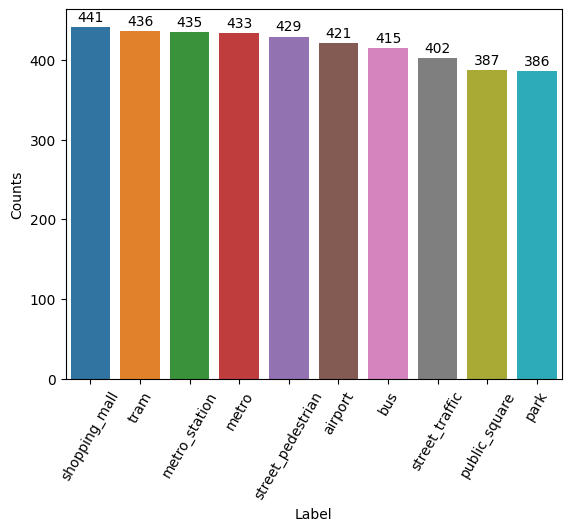

In [5]:
df_gb = eval_df['Actual Label'].value_counts().reset_index()
df_gb.columns = ['Label', 'Counts']

# Creating the bar plot
my_plot = sns.barplot(x='Label', y='Counts', data=df_gb, hue='Label', dodge=False)

# Setting the x-tick labels with rotation
my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=60)

# Adding the text labels on the bars
for p in my_plot.patches:
    my_plot.annotate(format(p.get_height(), '.0f'),  # Format the number as a float
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position for the text
                     ha = 'center',  # Center alignment
                     va = 'center',  # Center alignment
                     xytext = (0, 7),  # Distance from text to points (x,y)
                     textcoords = 'offset points')  # Offset (in points) from the *xy* value
# Show the plot
plt.show()

In [6]:
# Correct Predictions
correct_pred = eval_df[eval_df['Predicted Label'] == eval_df['Actual Label']]
print(correct_pred.shape)
correct_pred.head()

(2631, 4)


Filename       Actual Label  \
0   audio/street_pedestrian-lyon-1162-44093-a.wav  street_pedestrian   
2               audio/park-milan-1164-44095-a.wav               park   
3  audio/street_pedestrian-milan-1165-44096-a.wav  street_pedestrian   
4     audio/street_traffic-milan-1166-44097-a.wav     street_traffic   
6      audio/public_square-milan-1168-44099-a.wav      public_square   

     Predicted Label class_from_filename  
0  street_pedestrian   street_pedestrian  
2               park                park  
3  street_pedestrian   street_pedestrian  
4     street_traffic      street_traffic  
6      public_square       public_square

In [7]:
# Incorrect Predictions
incorrect_pred = eval_df[eval_df['Predicted Label'] != eval_df['Actual Label']]
incorrect_pred.shape

(1554, 4)

In [8]:
# Checking for accuracy
(correct_pred.shape[0]/4185) * 100

62.867383512544805

In [9]:
#Task 1a dev validation set
ThisPath = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/'
File = ThisPath + 'evaluation_setup/fold1_evaluate.csv'
sr = 48000
SampleDuration = 10
NumFreqBins = 128
NumFFTPoints = 2048
HopLength = int(NumFFTPoints/2)
NumTimeBins = int(np.ceil(SampleDuration*sr/HopLength))

In [10]:
custom_objects = {
    'PadChannels': PadChannels,
    'SliceLayer': SliceLayer
}
## 120 EPOCH CHECKPOINT
# model_path = "/work/aistwal/backup/MMDS_MasterThesis/models/asc/largemodel_checkpoint/DCASE_1a_Task_development_1.h5"
# best_model = keras.models.load_model(model_path, custom_objects=custom_objects)


# INTERMEDIATE KERAS CHECKPOINT
model_path = '/work/aistwal/backup/MMDS_MasterThesis/models/asc/largemodel_checkpoint/model_62-1.13.keras'
best_model = keras.saving.load_model(model_path)

model_name = model_path.split('/')[-1]
print("model name: ", model_name)
best_model.summary()

2024-07-10 19:21:37.136650: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46867 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:25:00.0, compute capability: 8.6


model name:  model_62-1.13.keras


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, None, │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer         │ (None, 64, None,  │          0 │ input_layer[0][0] │
│ (SliceLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_1       │ (None, 64, None,  │          0 │ input_layer[0][0] │
│ (SliceLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, None,  │          8 │ slice_layer[0][0] │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │          8 │ slice_layer_1[0]… │
│ (BatchNormalizatio… │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, None,  │        432 │ batch_normalizat… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, None,  │      6,912 │ batch_normalizat… │
│                     │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │      1,536 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 64, None,  │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 64, None,  │          0 │ batch_normalizat… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, None,  │      5,184 │ activation[0][0]  │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, None,  │  1,327,104 │ activation_16[0]… │
│                     │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, None,  │      1,536 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, None,  │          0 │ batch_normalizat… │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 64, None,  │          0 │ batch_normalizat

 Total params: 874,743,262 (3.26 GB)

 Trainable params: 437,334,440 (1.63 GB)

 Non-trainable params: 74,380 (290.55 KB)

 Optimizer params: 437,334,442 (1.63 GB)

Randomly get 10 audios

In [11]:
conv_layer = best_model.get_layer('conv2d_35')
conv_layer_output_shape = conv_layer.output
num_feature_maps = conv_layer_output_shape[-1]
print(num_feature_maps) #10

<KerasTensor shape=(64, None, 10), dtype=float32, sparse=False, name=keras_tensor_295>


In [12]:
correct_audio_list = correct_pred['Filename'].sample(n=10, random_state = 1).tolist()
correct_audio_list

['audio/street_pedestrian-barcelona-260-7900-a.wav',
 'audio/bus-lyon-1186-44750-a.wav',
 'audio/park-stockholm-245-7323-a.wav',
 'audio/park-prague-1185-44522-a.wav',
 'audio/park-paris-244-7279-a.wav',
 'audio/airport-stockholm-207-6304-a.wav',
 'audio/street_pedestrian-london-263-7985-a.wav',
 'audio/airport-barcelona-203-6134-a.wav',
 'audio/public_square-stockholm-252-7550-a.wav',
 'audio/street_pedestrian-paris-265-8065-a.wav']

In [13]:
labels = ['airport', 'bus', 'metro', 'metro_station', 'park', 'public_square', 'shopping_mall', 'street_pedestrian', 'street_traffic', 'tram']
lb_to_idx = {lb: idx for idx, lb in enumerate(labels)}
idx_to_lb = {idx: lb for idx, lb in enumerate(labels)}

In [14]:
idx_to_lb

{0: 'airport',
 1: 'bus',
 2: 'metro',
 3: 'metro_station',
 4: 'park',
 5: 'public_square',
 6: 'shopping_mall',
 7: 'street_pedestrian',
 8: 'street_traffic',
 9: 'tram'}

In [15]:
# # Getting keras model layers
# for layers in best_model.layers:
#     print(layers.name)

In [16]:
def display_log_mel_spectrogram(audioname, version, input_feature, model_name):
    print(audioname, "Log-Mel Feature Shape : ", input_feature.shape)
    plt.figure(figsize=(15, 6))
    plt.title(f'SPECTROGRAM FOR {audioname}')
    root_dir = '/work/aistwal/backup/MMDS_MasterThesis/models/asc'
    save_path = os.path.join(root_dir, 'large_model_files', model_name, version)
    
    # Create the directory if it does not exist
    os.makedirs(save_path, exist_ok=True)
    
    file_path = os.path.join(save_path, f'{audioname}-spectrogram.png')
    librosa.display.specshow(input_feature, x_axis='time', y_axis='linear', sr=sr, hop_length=HopLength)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()

In [17]:
def blackout_unimportant_features(grayscale_cam, input_spectrogram, percentile = 85):
    normalized_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))
    threshold = np.percentile(normalized_cam, percentile)
    # Create a mask for important regions
    important_mask = normalized_cam >= threshold
    
    # Get the minimum value of the input spectrogram
    min_value = np.min(input_spectrogram)
    
    # Create a copy of the input spectrogram to modify
    modified_spectrogram = np.copy(input_spectrogram)
    
    # Blackout unimportant regions by setting them to the minimum value
    modified_spectrogram[~important_mask] = min_value
    
    return modified_spectrogram

In [18]:
def spectrogram_indices_to_sample_range(col_index, hop_length = HopLength, n_fft = NumFFTPoints):
    """     
    Convert the column index of a spectrogram to the sample range of the original waveform.     
    Parameters:     
    
    column_index (int): The column index of the spectrogram.     
    hop_length (int): The hop length used in the STFT.     
    n_fft (int): The window length (number of FFT points) used in the STFT.     
    
    Returns:     
        tuple: A tuple containing the start and end sample indices (inclusive) in the original waveform.     
    """
    start_sample = col_index * hop_length
    end_sample = start_sample + n_fft
    return start_sample, end_sample

In [19]:
def blackout_only_x_dim(grayscale_cam, log_mel_spectrogram, percentile = 85):

    # Create copy of input_spectrogram
    generalized_cam_version = np.copy(log_mel_spectrogram) #64*641
    
    # Get the minimum value of the input spectrogram
    min_value = np.min(log_mel_spectrogram)
    
    normalized_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam))
    print("Columns: ", normalized_cam.shape[1])

    threshold = np.percentile(normalized_cam, percentile)
    threshold = float("{:.2f}".format(threshold))  #set threshold format
    print("Threshold: ", threshold)
    deactivated_col_list = []
    for col in range(0, normalized_cam.shape[1]):
        flag = np.all(normalized_cam[:,col] < threshold)
        if flag:
            deactivated_col_list.append(col)
            generalized_cam_version[:,col] = min_value
            
    return generalized_cam_version, deactivated_col_list

In [20]:
def make_gradcam_heatmap(img_array, best_model, last_conv_layer_name = 'conv2d_35', pred_index=None):
    ## First, we create a model that maps the input spectrogram feature to the activations of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        best_model.inputs, [best_model.get_layer(last_conv_layer_name).output, best_model.output]
    )

    ## Then, we compute the gradient of the top predicted class for our input feature for the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # print("Last convolutional layer output: ", last_conv_layer_output.shape)
    # print("Selected class channel:", class_channel)

    ## We are doing transfer learning on last layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    # We have 10 feature maps
    # print(grads.shape) #(1, 64, 30, 10)
    # This is a vector where each entry is the mean intensity of the gradient, as average across the batch size, height, and width dimensions will leave you with the mean gradient for each feature map.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    ## calculates a heatmap highlighting the regions of importance in an image for a specific predicted class by 
    ## combining the output of the last convolutional layer with the pooled gradients.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    ## For visualization purpose
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [21]:
def display_gradcam_with_spectrogram(spectrogram, version, model_name, heatmap, sr, alpha=0.5):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Resize heatmap to match spectrogram dimensions
    heatmap_resized = tf.image.resize(jet_heatmap, [spectrogram.shape[0], spectrogram.shape[1]]) #(128,469)

    # Set the save path
    root_dir = '/work/aistwal/backup/MMDS_MasterThesis/models/asc'
    save_path = os.path.join(root_dir, 'large_model_files', model_name, version)
    
    # Create the directory if it does not exist
    os.makedirs(save_path, exist_ok=True)
    
    file_path = os.path.join(save_path, f'{audioname}-spectrogram.png')
    # Display the spectrogram
    plt.figure(figsize=(15, 6))
    librosa.display.specshow(spectrogram, x_axis='time', y_axis='linear', sr=sr, hop_length=HopLength)

    # Overlay the heatmap
    plt.imshow(heatmap_resized, aspect='auto', alpha=alpha, origin='lower', interpolation='nearest')

    # Save and show the image
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-Mel Spectrogram with Grad-CAM')
    plt.tight_layout()
    plt.savefig(file_path)
    plt.show()

In [22]:
def get_log_mel_features(wavpaths):
    feature = np.zeros((len(wavpaths),NumFreqBins,NumTimeBins,2),'float32')
    for i in range(len(wavpaths)):
        
        stereo,fs = sound.read(wavpaths[i],stop=SampleDuration*sr)
        for channel in range(2):
            feature[i,:,:,channel]= librosa.feature.melspectrogram(y = stereo[:,channel], 
                                           sr=sr,
                                           n_fft=NumFFTPoints,
                                           hop_length=HopLength,
                                           n_mels=NumFreqBins,
                                           fmin=0.0,
                                           fmax=sr/2,
                                           htk=True,
                                           norm=None)

    feature = np.log(feature)
    return feature

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7900-a.wav


2024-07-10 19:22:06.061542: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39


I0000 00:00:1720632131.650854 1273678 service.cc:145] XLA service 0x7ff2c12e99d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720632131.650922 1273678 service.cc:153]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-07-10 19:22:11.684965: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Prediction for  street_pedestrian-barcelona-260-7900-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


I0000 00:00:1720632139.807019 1273678 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Prediction after cam mask for  street_pedestrian-barcelona-260-7900-a.wav is  street_pedestrian
street_pedestrian-barcelona-260-7900-a.wav Log-Mel Feature Shape :  (128, 469)


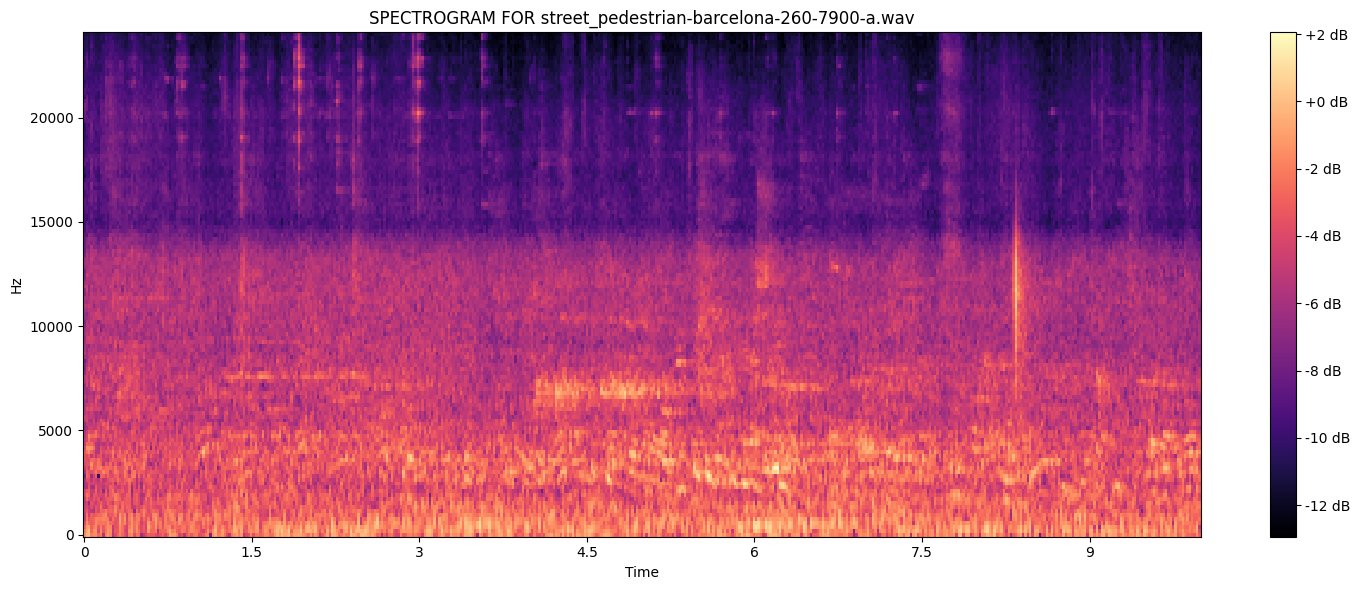

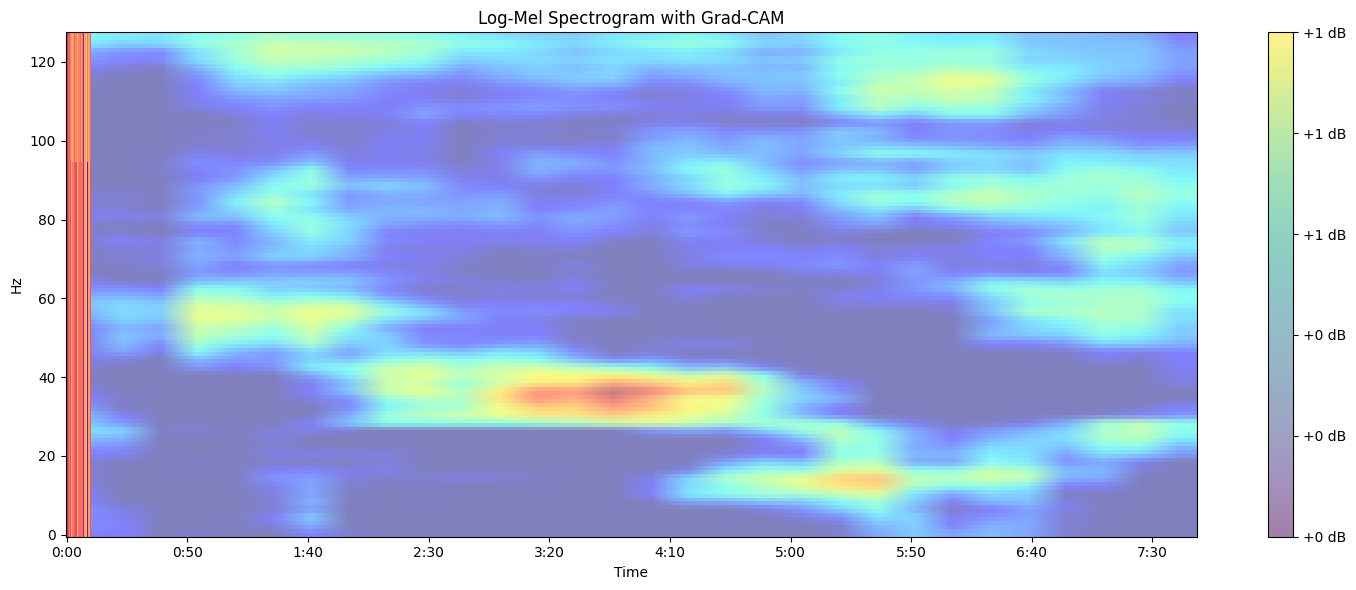

street_pedestrian-barcelona-260-7900-a.wav_modified Log-Mel Feature Shape :  (128, 469)


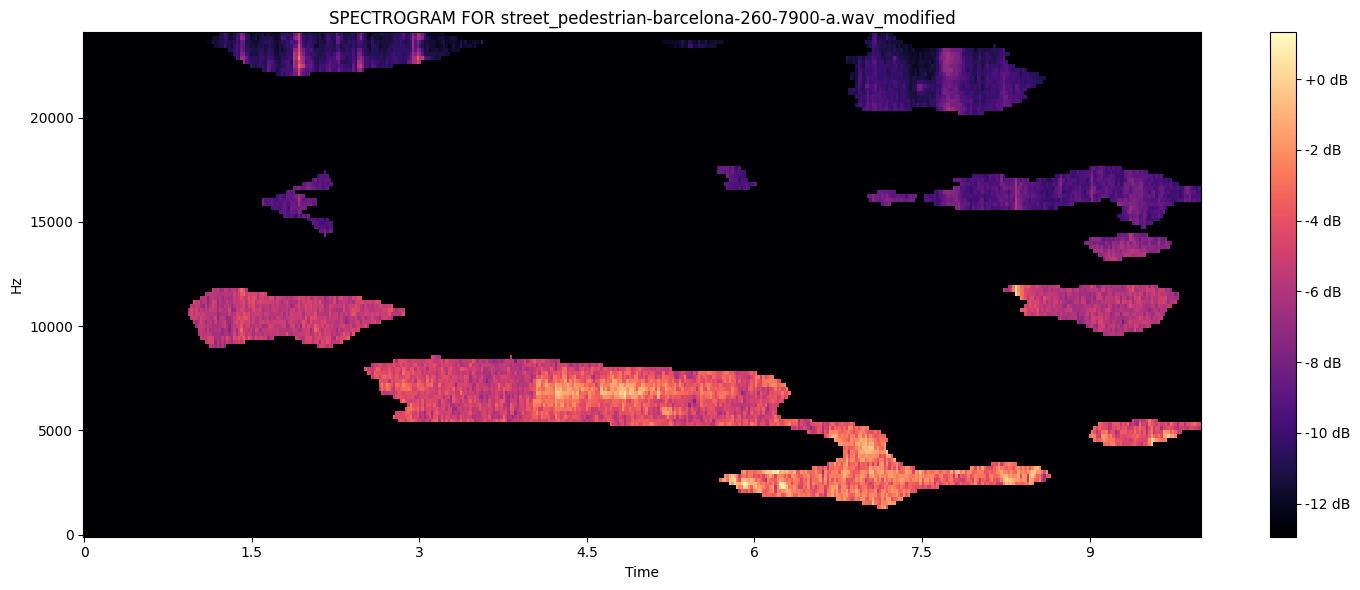

street_pedestrian-barcelona-260-7900-a.wav_generalized Log-Mel Feature Shape :  (128, 469)


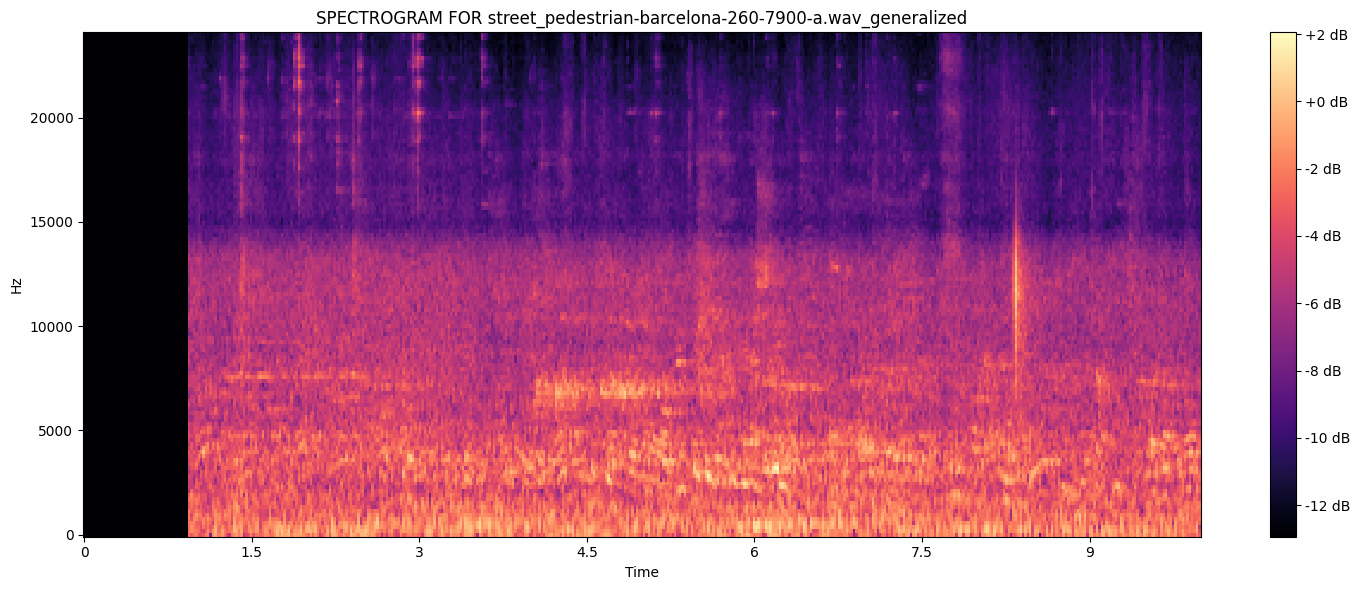

In [23]:
for audio in correct_audio_list[0:]:    
    audio_path = ThisPath + audio
    print(audio_path)
    audioname = audio.split('/')[-1]
    y, sr = sound.read(audio_path, stop=SampleDuration*sr)
    
    # Extract the log-mel features.
    original_log_mel_spectrogram = get_log_mel_features([audio_path])
    
    ## Extracting first channel as log-mel-spectrogram since we have processed stereo audios consisting of 2 channels.
    log_mel_spectrogram = original_log_mel_spectrogram[0,:,:,0]
    # log_mel_spectrogram = original_log_mel_spectrogram[0,:,:,1]
    
    heatmap = make_gradcam_heatmap(original_log_mel_spectrogram, best_model)
    print("Shape of heatmap ", heatmap.shape)
    # print("Max value of heatmap", np.max(heatmap), "Min value ", np.min(heatmap))
    # plt.matshow(heatmap)
    # plt.show()
    
    # Resize heatmap to match spectrogram dimensions
    heatmap_resized = tf.image.resize(heatmap[..., tf.newaxis], [log_mel_spectrogram.shape[0], log_mel_spectrogram.shape[1]]).numpy().squeeze()
    # print("Max value of heatmap_resized", np.max(heatmap_resized), "Min value ", np.min(heatmap_resized))

    #Blackout
    modified_spectrogram = blackout_unimportant_features(heatmap_resized, log_mel_spectrogram)

    #Blackout only x, leave y
    generalized_cam_version, deactivated_col_list = blackout_only_x_dim(heatmap_resized, log_mel_spectrogram)

    #Get altered audio
    y_alt = np.copy(y)

    # Get start index and stop index
    for col_index in deactivated_col_list:
        start_sample, end_sample = spectrogram_indices_to_sample_range(col_index)
        y_alt[start_sample:end_sample+1] = y.min()

    # Prediction of the audio
    predicted_class = np.argmax(best_model.predict(original_log_mel_spectrogram), axis=1)
    pred_label = idx_to_lb[predicted_class[0]]
    print("Prediction for ",audioname ,"is ", pred_label)
    
    # Duplicate the modified spectrogram along the channel dimension to create 2 channels
    generalized_spectrogram = np.stack((generalized_cam_version, generalized_cam_version), axis=-1)
    # Add the batch dimension
    generalized_spectrogram = np.expand_dims(generalized_spectrogram, axis=0)
    # print("Original shape:", original_log_mel_spectrogram.shape, "generalized shape:", generalized_cam_version.shape)
    
    prediction_class = np.argmax(best_model.predict(generalized_spectrogram), axis=1)
    preds_after_cam_label = idx_to_lb[predicted_class[0]]
    print("Prediction after cam mask for ", audioname, "is ", preds_after_cam_label)

    
    
    display_log_mel_spectrogram(audioname, "spectrograms",log_mel_spectrogram, model_name)
    display_gradcam_with_spectrogram(log_mel_spectrogram, "overlaid_spectrograms", model_name, heatmap, sr)
    display_log_mel_spectrogram(audioname+"_modified", "cam_spectrograms", modified_spectrogram, model_name)
    display_log_mel_spectrogram(audioname+"_generalized","generalized_cam_spectrograms", generalized_cam_version, model_name)
    break



In [24]:
audio_root_path = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/'
audio_path = audio_root_path+ correct_audio_list[0]
print(audio_path)
# Load the audio file

audio, sr = sound.read(audio_path,stop=SampleDuration*sr)
print(audio.shape)
print(audio[:,0].shape)
print("Sampling rate: ",sr)
Audio(data=audio[:,1], rate=sr)

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7900-a.wav
(480000, 2)
(480000,)
Sampling rate:  48000


In [25]:
y_alt.shape
Audio(data=y_alt[:,0], rate=sr)

In [26]:
def print_audio_tagging_result(clipwise_output):
    """Visualization of audio tagging result.

    Args:
      clipwise_output: (classes_num,)
    """
    sorted_indexes = np.argsort(clipwise_output)[::-1]

    # Print audio tagging top probabilities
    for k in range(10):
        print('{}: {:.3f}'.format(np.array(labels)[sorted_indexes[k]], 
            clipwise_output[sorted_indexes[k]]))

In [27]:
from panns_inference import AudioTagging, SoundEventDetection, labels
# INITIALIZE THE AUDIO TAGGER
at = AudioTagging(checkpoint_path='/home/aistwal/panns_data/Cnn14_mAP=0.431.pth', device="cuda") 
audio = correct_audio_list[0]
audio_root_path = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/'
audio = audio_root_path+audio
# audio = '/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45728-a.wav'

print(audio)
audioname = audio.split('/')[-1]
# Load the audio file
y, sr = sound.read(audio_path,stop=SampleDuration*sr)

#check panns inference
y = np.expand_dims(y[:,0], axis=0) # (batch_size, segment_samples)
print(y.shape)
(clipwise_output, embedding) = at.inference(y)
print_audio_tagging_result(clipwise_output[0])

print("New audio",y_alt.shape)
# #check panns inference
y_new = np.expand_dims(y_alt[:,0], axis = 0)
(clipwise_output, embedding) = at.inference(y_new)
print_audio_tagging_result(clipwise_output[0])


Checkpoint path: /home/aistwal/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7900-a.wav
(1, 480000)
Speech: 0.503
Animal: 0.290
Domestic animals, pets: 0.105
Clip-clop: 0.083
Dog: 0.079
Horse: 0.058
Chink, clink: 0.053
Mouse: 0.046
Inside, small room: 0.033
Vehicle: 0.032
New audio (480000, 2)
Speech: 0.509
Animal: 0.231
Domestic animals, pets: 0.105
Dog: 0.086
Silence: 0.070
Inside, small room: 0.041
Music: 0.030
Vehicle: 0.030
Chink, clink: 0.028
Horse: 0.022


### COLLECT EVENT LIST FOR ALL THE CORRECTLY PREDICTED AUDIOS


In [28]:
correct_pred = eval_df[eval_df['Predicted Label'] == eval_df['Actual Label']]
print(correct_pred.shape)
correct_pred.head()

(2631, 4)


Filename       Actual Label  \
0   audio/street_pedestrian-lyon-1162-44093-a.wav  street_pedestrian   
2               audio/park-milan-1164-44095-a.wav               park   
3  audio/street_pedestrian-milan-1165-44096-a.wav  street_pedestrian   
4     audio/street_traffic-milan-1166-44097-a.wav     street_traffic   
6      audio/public_square-milan-1168-44099-a.wav      public_square   

     Predicted Label class_from_filename  
0  street_pedestrian   street_pedestrian  
2               park                park  
3  street_pedestrian   street_pedestrian  
4     street_traffic      street_traffic  
6      public_square       public_square

In [29]:
# INITIALIZE THE AUDIO TAGGER
at = AudioTagging(checkpoint_path='/home/aistwal/panns_data/Cnn14_mAP=0.431.pth', device="cuda")

Checkpoint path: /home/aistwal/panns_data/Cnn14_mAP=0.431.pth
GPU number: 1


In [30]:
def print_audio_tagging_result(clipwise_output):
    sorted_indexes = np.argsort(clipwise_output)[::-1]
    events = []
    for k in range(10):
        # print('{}: {:.3f}'.format(np.array(labels)[sorted_indexes[k]], 
        #     clipwise_output[sorted_indexes[k]]))
        events.append(np.array(labels)[sorted_indexes[k]])
    return events

In [31]:
# GET EVENTS FOR ALL CORRECTLY PREDICTED 2230 AUDIOS, AND STORE THE PREDICTED SCENE AFTER CAM MASK

from tqdm import tqdm

final_events_before = []
final_events_after = []
final_preds_cam_label = []

for audio in tqdm(correct_pred['Filename']):
    
    audio_path = ThisPath + audio
    print(audio_path)
    audioname = audio.split('/')[-1]
    y, sr = sound.read(audio_path, stop=SampleDuration*sr)

    # Extract the log-mel features.
    original_log_mel_spectrogram = get_log_mel_features([audio_path])
    
    ## Extracting first channel as log-mel-spectrogram since we have processed stereo audios consisting of 2 channels.
    log_mel_spectrogram = original_log_mel_spectrogram[0,:,:,0]
    # log_mel_spectrogram = original_log_mel_spectrogram[0,:,:,1]
    
    heatmap = make_gradcam_heatmap(original_log_mel_spectrogram, best_model)
    print("Shape of heatmap ", heatmap.shape)
    
    # Resize heatmap to match spectrogram dimensions
    heatmap_resized = tf.image.resize(heatmap[..., tf.newaxis], [log_mel_spectrogram.shape[0], log_mel_spectrogram.shape[1]]).numpy().squeeze()

    #Blackout unimportant features
    modified_spectrogram = blackout_unimportant_features(heatmap_resized, log_mel_spectrogram)

    #Blackout only x, leave y
    generalized_cam_version, deactivated_col_list = blackout_only_x_dim(heatmap_resized, log_mel_spectrogram)
    
    
    #Get altered audio
    y_alt = np.copy(y)

    # Get start index and stop index
    for col_index in deactivated_col_list:
        start_sample, end_sample = spectrogram_indices_to_sample_range(col_index)
        y_alt[start_sample:end_sample+1] = y.min()

    
    # Prediction of the audio
    predicted_class = np.argmax(best_model.predict(original_log_mel_spectrogram), axis=1)
    pred_label = idx_to_lb[predicted_class[0]]
    print("Prediction for ",audioname ,"is ", pred_label)
    
    # Duplicate the modified spectrogram along the channel dimension to create 2 channels
    generalized_spectrogram = np.stack((generalized_cam_version, generalized_cam_version), axis=-1)
    # Add the batch dimension
    generalized_spectrogram = np.expand_dims(generalized_spectrogram, axis=0)
    # print("Original shape:", original_log_mel_spectrogram.shape, "generalized shape:", generalized_cam_version.shape)
    
    prediction_class = np.argmax(best_model.predict(generalized_spectrogram), axis=1)
    preds_after_cam_label = idx_to_lb[predicted_class[0]]
    print("Prediction after cam mask for ", audioname, "is ", preds_after_cam_label)    
    final_preds_cam_label.append(preds_after_cam_label)

    # Get panns inference for unaltered audio
    y = np.expand_dims(y[:,0], axis=0)  # (batch_size, segment_samples)
    (clipwise_output, embedding) = at.inference(y)
    events_before = print_audio_tagging_result(clipwise_output[0])
    final_events_before.append(events_before)
    
    # Get panns inference for altered audio
    y_new = np.expand_dims(y_alt[:,0], axis = 0)
    (clipwise_output, embedding) = at.inference(y_new)
    events_after = print_audio_tagging_result(clipwise_output[0])
    final_events_after.append(events_after)    
    
    print("----"*25)
    

  0%|                                                                                                            | 0/2631 [00:00<?, ?it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44093-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lyon-1162-44093-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|                                                                                                    | 1/2631 [00:00<23:06,  1.90it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44093-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44095-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44095-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|                                                                                                    | 2/2631 [00:01<22:48,  1.92it/s]

Prediction after cam mask for  park-milan-1164-44095-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44096-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1165-44096-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|                                                                                                    | 3/2631 [00:01<23:02,  1.90it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44096-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44097-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1166-44097-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|▏                                                                                                   | 4/2631 [00:02<23:21,  1.87it/s]

Prediction after cam mask for  street_traffic-milan-1166-44097-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44099-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-milan-1168-44099-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|▏                                                                                                   | 5/2631 [00:02<23:17,  1.88it/s]

Prediction after cam mask for  public_square-milan-1168-44099-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44100-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-44100-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|▏                                                                                                   | 6/2631 [00:03<23:07,  1.89it/s]

Prediction after cam mask for  airport-lyon-1169-44100-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-44101-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro_station-prague-1170-44101-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|▎                                                                                                   | 7/2631 [00:03<23:08,  1.89it/s]

Prediction after cam mask for  metro_station-prague-1170-44101-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44102-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lisbon-1171-44102-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|▎                                                                                                   | 8/2631 [00:04<23:17,  1.88it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44102-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44104-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1173-44104-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  0%|▎                                                                                                   | 9/2631 [00:04<23:04,  1.89it/s]

Prediction after cam mask for  airport-prague-1173-44104-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44105-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-44105-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|▍                                                                                                  | 10/2631 [00:05<23:08,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44105-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44109-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1177-44109-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|▍                                                                                                  | 11/2631 [00:06<26:51,  1.63it/s]

Prediction after cam mask for  bus-lyon-1177-44109-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44112-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lyon-1162-44112-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|▍                                                                                                  | 12/2631 [00:06<25:28,  1.71it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44112-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44115-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1180-44115-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|▍                                                                                                  | 13/2631 [00:07<24:35,  1.77it/s]

Prediction after cam mask for  bus-milan-1180-44115-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1184-44119-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1184-44119-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▌                                                                                                  | 14/2631 [00:07<24:20,  1.79it/s]

Prediction after cam mask for  tram-prague-1184-44119-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44120-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-prague-1185-44120-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▌                                                                                                  | 15/2631 [00:08<24:16,  1.80it/s]

Prediction after cam mask for  park-prague-1185-44120-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44121-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-milan-1164-44121-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▌                                                                                                  | 16/2631 [00:08<24:03,  1.81it/s]

Prediction after cam mask for  park-milan-1164-44121-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44122-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1186-44122-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▋                                                                                                  | 17/2631 [00:09<23:39,  1.84it/s]

Prediction after cam mask for  bus-lyon-1186-44122-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44124-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lyon-1188-44124-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▋                                                                                                  | 18/2631 [00:09<23:23,  1.86it/s]

Prediction after cam mask for  park-lyon-1188-44124-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44126-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-44126-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  1%|▋                                                                                                  | 19/2631 [00:10<23:11,  1.88it/s]

Prediction after cam mask for  airport-milan-1172-44126-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44127-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  airport-lyon-1169-44127-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▊                                                                                                  | 20/2631 [00:10<22:45,  1.91it/s]

Prediction after cam mask for  airport-lyon-1169-44127-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44129-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-lyon-1177-44129-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▊                                                                                                  | 21/2631 [00:11<22:33,  1.93it/s]

Prediction after cam mask for  bus-lyon-1177-44129-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44130-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-lyon-1162-44130-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|▊                                                                                                  | 22/2631 [00:11<22:57,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44130-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44131-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-milan-1164-44131-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▊                                                                                                  | 23/2631 [00:12<22:59,  1.89it/s]

Prediction after cam mask for  park-milan-1164-44131-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44132-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1190-44132-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▉                                                                                                  | 24/2631 [00:12<23:01,  1.89it/s]

Prediction after cam mask for  bus-milan-1190-44132-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44133-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lisbon-1191-44133-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|▉                                                                                                  | 25/2631 [00:13<23:16,  1.87it/s]

Prediction after cam mask for  tram-lisbon-1191-44133-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44135-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-prague-1193-44135-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|▉                                                                                                  | 26/2631 [00:14<23:32,  1.84it/s]

Prediction after cam mask for  street_traffic-prague-1193-44135-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-44136-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-prague-1194-44136-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|█                                                                                                  | 27/2631 [00:14<23:39,  1.83it/s]

Prediction after cam mask for  bus-prague-1194-44136-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44137-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-prague-1185-44137-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|█                                                                                                  | 28/2631 [00:15<23:35,  1.84it/s]

Prediction after cam mask for  park-prague-1185-44137-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44138-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-lyon-1188-44138-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|█                                                                                                  | 29/2631 [00:15<23:36,  1.84it/s]

Prediction after cam mask for  park-lyon-1188-44138-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44140-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1186-44140-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|█▏                                                                                                 | 30/2631 [00:16<23:31,  1.84it/s]

Prediction after cam mask for  bus-lyon-1186-44140-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44142-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1195-44142-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  1%|█▏                                                                                                 | 31/2631 [00:16<23:18,  1.86it/s]

Prediction after cam mask for  airport-prague-1195-44142-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44143-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-44143-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|█▏                                                                                                 | 32/2631 [00:17<22:53,  1.89it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-44143-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44147-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lisbon-1198-44147-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|█▏                                                                                                 | 33/2631 [00:17<22:42,  1.91it/s]

Prediction after cam mask for  park-lisbon-1198-44147-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44149-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-prague-1195-44149-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  1%|█▎                                                                                                 | 34/2631 [00:18<22:48,  1.90it/s]

Prediction after cam mask for  airport-prague-1195-44149-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44151-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-milan-1165-44151-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|█▎                                                                                                 | 35/2631 [00:18<22:56,  1.89it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44151-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-44152-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lisbon-1200-44152-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|█▎                                                                                                 | 36/2631 [00:19<23:00,  1.88it/s]

Prediction after cam mask for  tram-lisbon-1200-44152-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44156-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-milan-1165-44156-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|█▍                                                                                                 | 37/2631 [00:19<23:00,  1.88it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44156-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44159-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-lyon-1177-44159-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  1%|█▍                                                                                                 | 38/2631 [00:20<22:47,  1.90it/s]

Prediction after cam mask for  bus-lyon-1177-44159-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44160-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-milan-1202-44160-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  1%|█▍                                                                                                 | 39/2631 [00:21<23:15,  1.86it/s]

Prediction after cam mask for  street_traffic-milan-1202-44160-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44161-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-lyon-1188-44161-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|█▌                                                                                                 | 40/2631 [00:21<23:16,  1.86it/s]

Prediction after cam mask for  park-lyon-1188-44161-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44162-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-milan-1164-44162-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▌                                                                                                 | 41/2631 [00:22<23:00,  1.88it/s]

Prediction after cam mask for  park-milan-1164-44162-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44163-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-prague-1193-44163-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  2%|█▌                                                                                                 | 42/2631 [00:22<23:07,  1.87it/s]

Prediction after cam mask for  street_traffic-prague-1193-44163-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44164-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-prague-1203-44164-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▌                                                                                                 | 43/2631 [00:23<23:01,  1.87it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-44164-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44170-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lisbon-1198-44170-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|█▋                                                                                                 | 44/2631 [00:23<22:41,  1.90it/s]

Prediction after cam mask for  park-lisbon-1198-44170-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44171-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-milan-1205-44171-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|█▋                                                                                                 | 45/2631 [00:24<23:00,  1.87it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44171-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44174-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lisbon-1174-44174-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|█▋                                                                                                 | 46/2631 [00:24<23:01,  1.87it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44174-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-44175-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-prague-1207-44175-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▊                                                                                                 | 47/2631 [00:25<22:28,  1.92it/s]

Prediction after cam mask for  bus-prague-1207-44175-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44176-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-lisbon-1171-44176-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|█▊                                                                                                 | 48/2631 [00:25<22:36,  1.90it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44176-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44178-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1177-44178-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▊                                                                                                 | 49/2631 [00:26<22:47,  1.89it/s]

Prediction after cam mask for  bus-lyon-1177-44178-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44179-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lisbon-1174-44179-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  2%|█▉                                                                                                 | 50/2631 [00:26<22:54,  1.88it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44179-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44182-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1180-44182-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▉                                                                                                 | 51/2631 [00:27<22:38,  1.90it/s]

Prediction after cam mask for  bus-milan-1180-44182-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44184-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1210-44184-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|█▉                                                                                                 | 52/2631 [00:27<22:48,  1.88it/s]

Prediction after cam mask for  tram-prague-1210-44184-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44185-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lyon-1162-44185-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|█▉                                                                                                 | 53/2631 [00:28<22:44,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44185-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44186-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  airport-lisbon-1175-44186-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|██                                                                                                 | 54/2631 [00:28<22:41,  1.89it/s]

Prediction after cam mask for  airport-lisbon-1175-44186-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44187-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-prague-1185-44187-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|██                                                                                                 | 55/2631 [00:29<22:38,  1.90it/s]

Prediction after cam mask for  park-prague-1185-44187-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44188-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44188-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|██                                                                                                 | 56/2631 [00:30<22:43,  1.89it/s]

Prediction after cam mask for  park-milan-1164-44188-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44189-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1180-44189-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|██▏                                                                                                | 57/2631 [00:30<22:50,  1.88it/s]

Prediction after cam mask for  bus-milan-1180-44189-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44190-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lisbon-1211-44190-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  2%|██▏                                                                                                | 58/2631 [00:31<23:03,  1.86it/s]

Prediction after cam mask for  public_square-lisbon-1211-44190-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44191-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-prague-1210-44191-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  2%|██▏                                                                                                | 59/2631 [00:31<22:49,  1.88it/s]

Prediction after cam mask for  tram-prague-1210-44191-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44192-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lisbon-1171-44192-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|██▎                                                                                                | 60/2631 [00:32<22:40,  1.89it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44192-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44194-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lyon-1162-44194-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|██▎                                                                                                | 61/2631 [00:32<22:33,  1.90it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44194-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-44197-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1178-44197-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|██▎                                                                                                | 62/2631 [00:33<22:21,  1.92it/s]

Prediction after cam mask for  public_square-lyon-1178-44197-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44198-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1191-44198-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|██▎                                                                                                | 63/2631 [00:33<22:14,  1.92it/s]

Prediction after cam mask for  tram-lisbon-1191-44198-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44201-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1202-44201-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  2%|██▍                                                                                                | 64/2631 [00:34<22:38,  1.89it/s]

Prediction after cam mask for  street_traffic-milan-1202-44201-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44205-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-44205-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  2%|██▍                                                                                                | 65/2631 [00:34<22:43,  1.88it/s]

Prediction after cam mask for  airport-milan-1172-44205-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-44206-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1212-44206-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▍                                                                                                | 66/2631 [00:35<22:29,  1.90it/s]

Prediction after cam mask for  bus-lisbon-1212-44206-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44207-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1166-44207-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|██▌                                                                                                | 67/2631 [00:35<22:18,  1.92it/s]

Prediction after cam mask for  street_traffic-milan-1166-44207-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44208-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-44208-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▌                                                                                                | 68/2631 [00:36<22:19,  1.91it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-44208-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44209-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-milan-1190-44209-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|██▌                                                                                                | 69/2631 [00:36<22:10,  1.92it/s]

Prediction after cam mask for  bus-milan-1190-44209-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44210-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-lisbon-1175-44210-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|██▋                                                                                                | 70/2631 [00:37<22:12,  1.92it/s]

Prediction after cam mask for  airport-lisbon-1175-44210-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44215-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-milan-1172-44215-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|██▋                                                                                                | 71/2631 [00:37<22:32,  1.89it/s]

Prediction after cam mask for  airport-milan-1172-44215-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44216-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-milan-1168-44216-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|██▋                                                                                                | 72/2631 [00:38<23:01,  1.85it/s]

Prediction after cam mask for  public_square-milan-1168-44216-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44218-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-prague-1195-44218-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|██▋                                                                                                | 73/2631 [00:39<23:05,  1.85it/s]

Prediction after cam mask for  airport-prague-1195-44218-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44220-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-prague-1215-44220-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|██▊                                                                                                | 74/2631 [00:39<22:59,  1.85it/s]

Prediction after cam mask for  bus-prague-1215-44220-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44221-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-prague-1185-44221-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|██▊                                                                                                | 75/2631 [00:40<22:49,  1.87it/s]

Prediction after cam mask for  park-prague-1185-44221-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44223-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-milan-1183-44223-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|██▊                                                                                                | 76/2631 [00:40<22:57,  1.85it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44223-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44225-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1166-44225-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  3%|██▉                                                                                                | 77/2631 [00:41<22:49,  1.86it/s]

Prediction after cam mask for  street_traffic-milan-1166-44225-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44226-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-milan-1183-44226-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|██▉                                                                                                | 78/2631 [00:41<22:57,  1.85it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44226-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44227-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-lyon-1169-44227-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|██▉                                                                                                | 79/2631 [00:42<22:55,  1.85it/s]

Prediction after cam mask for  airport-lyon-1169-44227-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44228-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lisbon-1198-44228-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|███                                                                                                | 80/2631 [00:42<22:51,  1.86it/s]

Prediction after cam mask for  park-lisbon-1198-44228-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-44231-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro-milan-1197-44231-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|███                                                                                                | 81/2631 [00:43<22:49,  1.86it/s]

Prediction after cam mask for  metro-milan-1197-44231-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-44232-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-lyon-1178-44232-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|███                                                                                                | 82/2631 [00:43<22:59,  1.85it/s]

Prediction after cam mask for  public_square-lyon-1178-44232-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44233-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-lisbon-1175-44233-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|███                                                                                                | 83/2631 [00:44<22:51,  1.86it/s]

Prediction after cam mask for  airport-lisbon-1175-44233-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44234-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-prague-1185-44234-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|███▏                                                                                               | 84/2631 [00:44<22:31,  1.89it/s]

Prediction after cam mask for  park-prague-1185-44234-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44235-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-prague-1193-44235-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  3%|███▏                                                                                               | 85/2631 [00:45<22:25,  1.89it/s]

Prediction after cam mask for  street_traffic-prague-1193-44235-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44236-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-prague-1210-44236-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|███▏                                                                                               | 86/2631 [00:45<22:20,  1.90it/s]

Prediction after cam mask for  tram-prague-1210-44236-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44237-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lisbon-1191-44237-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|███▎                                                                                               | 87/2631 [00:46<22:10,  1.91it/s]

Prediction after cam mask for  tram-lisbon-1191-44237-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44238-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44238-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|███▎                                                                                               | 88/2631 [00:46<22:15,  1.90it/s]

Prediction after cam mask for  park-milan-1164-44238-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44239-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro_station-milan-1187-44239-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  3%|███▎                                                                                               | 89/2631 [00:47<22:19,  1.90it/s]

Prediction after cam mask for  metro_station-milan-1187-44239-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44241-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1191-44241-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|███▍                                                                                               | 90/2631 [00:48<22:27,  1.89it/s]

Prediction after cam mask for  tram-lisbon-1191-44241-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44243-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-44243-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  3%|███▍                                                                                               | 91/2631 [00:48<22:31,  1.88it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44243-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44244-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-milan-1205-44244-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  3%|███▍                                                                                               | 92/2631 [00:49<22:28,  1.88it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44244-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44245-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.86
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-44245-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▍                                                                                               | 93/2631 [00:49<22:28,  1.88it/s]

Prediction after cam mask for  park-lisbon-1198-44245-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44246-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-44246-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▌                                                                                               | 94/2631 [00:50<22:54,  1.85it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44246-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44247-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lisbon-1211-44247-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▌                                                                                               | 95/2631 [00:50<22:48,  1.85it/s]

Prediction after cam mask for  public_square-lisbon-1211-44247-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-44249-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lisbon-1176-44249-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|███▌                                                                                               | 96/2631 [00:51<22:45,  1.86it/s]

Prediction after cam mask for  shopping_mall-lisbon-1176-44249-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44250-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-prague-1185-44250-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▋                                                                                               | 97/2631 [00:51<22:41,  1.86it/s]

Prediction after cam mask for  park-prague-1185-44250-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44251-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44251-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|███▋                                                                                               | 98/2631 [00:52<22:23,  1.89it/s]

Prediction after cam mask for  park-milan-1164-44251-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44252-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lisbon-1191-44252-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▋                                                                                               | 99/2631 [00:52<22:12,  1.90it/s]

Prediction after cam mask for  tram-lisbon-1191-44252-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44254-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lyon-1216-44254-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▋                                                                                              | 100/2631 [00:53<22:11,  1.90it/s]

Prediction after cam mask for  tram-lyon-1216-44254-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44255-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1165-44255-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▊                                                                                              | 101/2631 [00:53<22:02,  1.91it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44255-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44258-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lisbon-1171-44258-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▊                                                                                              | 102/2631 [00:54<22:10,  1.90it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44258-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-44259-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-lisbon-1176-44259-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▊                                                                                              | 103/2631 [00:54<22:16,  1.89it/s]

Prediction after cam mask for  shopping_mall-lisbon-1176-44259-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44261-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-44261-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|███▊                                                                                              | 104/2631 [00:55<22:25,  1.88it/s]

Prediction after cam mask for  street_traffic-prague-1193-44261-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44264-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1177-44264-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▉                                                                                              | 105/2631 [00:56<22:32,  1.87it/s]

Prediction after cam mask for  bus-lyon-1177-44264-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44268-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1177-44268-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|███▉                                                                                              | 106/2631 [00:56<22:19,  1.89it/s]

Prediction after cam mask for  bus-lyon-1177-44268-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44270-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44270-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  4%|███▉                                                                                              | 107/2631 [00:57<22:22,  1.88it/s]

Prediction after cam mask for  park-milan-1164-44270-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-44271-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lisbon-1212-44271-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|████                                                                                              | 108/2631 [00:57<22:40,  1.86it/s]

Prediction after cam mask for  bus-lisbon-1212-44271-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44273-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-milan-1190-44273-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|████                                                                                              | 109/2631 [00:58<22:53,  1.84it/s]

Prediction after cam mask for  bus-milan-1190-44273-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44275-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1166-44275-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|████                                                                                              | 110/2631 [00:58<22:38,  1.86it/s]

Prediction after cam mask for  street_traffic-milan-1166-44275-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44277-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-lyon-1188-44277-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|████▏                                                                                             | 111/2631 [00:59<22:18,  1.88it/s]

Prediction after cam mask for  park-lyon-1188-44277-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44278-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-44278-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|████▏                                                                                             | 112/2631 [00:59<22:12,  1.89it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44278-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44279-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-44279-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|████▏                                                                                             | 113/2631 [01:00<22:21,  1.88it/s]

Prediction after cam mask for  airport-lyon-1169-44279-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-44280-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lisbon-1200-44280-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  4%|████▏                                                                                             | 114/2631 [01:00<22:22,  1.87it/s]

Prediction after cam mask for  tram-lisbon-1200-44280-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44281-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1208-44281-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|████▎                                                                                             | 115/2631 [01:01<22:18,  1.88it/s]

Prediction after cam mask for  public_square-lyon-1208-44281-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44283-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-44283-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|████▎                                                                                             | 116/2631 [01:01<22:09,  1.89it/s]

Prediction after cam mask for  airport-lyon-1169-44283-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44285-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-44285-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  4%|████▎                                                                                             | 117/2631 [01:02<22:04,  1.90it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44285-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44286-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1190-44286-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  4%|████▍                                                                                             | 118/2631 [01:02<22:03,  1.90it/s]

Prediction after cam mask for  bus-milan-1190-44286-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44287-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-prague-1185-44287-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|████▍                                                                                             | 119/2631 [01:03<22:03,  1.90it/s]

Prediction after cam mask for  park-prague-1185-44287-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-44288-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-prague-1194-44288-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|████▍                                                                                             | 120/2631 [01:04<21:57,  1.91it/s]

Prediction after cam mask for  bus-prague-1194-44288-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44290-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-44290-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|████▌                                                                                             | 121/2631 [01:04<21:57,  1.91it/s]

Prediction after cam mask for  park-lisbon-1198-44290-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44294-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lyon-1220-44294-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|████▌                                                                                             | 122/2631 [01:05<22:13,  1.88it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44294-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44295-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-prague-1185-44295-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  5%|████▌                                                                                             | 123/2631 [01:05<21:53,  1.91it/s]

Prediction after cam mask for  park-prague-1185-44295-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44297-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1190-44297-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|████▌                                                                                             | 124/2631 [01:06<22:09,  1.89it/s]

Prediction after cam mask for  bus-milan-1190-44297-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44298-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-44298-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|████▋                                                                                             | 125/2631 [01:06<22:01,  1.90it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44298-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44300-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.88
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lyon-1188-44300-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


  5%|████▋                                                                                             | 126/2631 [01:07<21:48,  1.91it/s]

Prediction after cam mask for  park-lyon-1188-44300-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-44302-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-prague-1192-44302-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|████▋                                                                                             | 127/2631 [01:07<21:37,  1.93it/s]

Prediction after cam mask for  public_square-prague-1192-44302-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44303-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-lyon-1208-44303-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|████▊                                                                                             | 128/2631 [01:08<22:07,  1.89it/s]

Prediction after cam mask for  public_square-lyon-1208-44303-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44304-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-milan-1164-44304-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|████▊                                                                                             | 129/2631 [01:08<22:03,  1.89it/s]

Prediction after cam mask for  park-milan-1164-44304-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44305-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lyon-1220-44305-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  5%|████▊                                                                                             | 130/2631 [01:09<21:56,  1.90it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44305-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44307-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-44307-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|████▉                                                                                             | 131/2631 [01:09<21:41,  1.92it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-44307-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44308-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-44308-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  5%|████▉                                                                                             | 132/2631 [01:10<21:56,  1.90it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44308-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44309-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-prague-1173-44309-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|████▉                                                                                             | 133/2631 [01:10<22:05,  1.88it/s]

Prediction after cam mask for  airport-prague-1173-44309-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44310-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-lisbon-1174-44310-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|████▉                                                                                             | 134/2631 [01:11<22:15,  1.87it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44310-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44311-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lisbon-1211-44311-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|█████                                                                                             | 135/2631 [01:11<22:35,  1.84it/s]

Prediction after cam mask for  public_square-lisbon-1211-44311-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44312-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-milan-1164-44312-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|█████                                                                                             | 136/2631 [01:12<22:15,  1.87it/s]

Prediction after cam mask for  park-milan-1164-44312-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44314-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-lyon-1169-44314-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|█████                                                                                             | 137/2631 [01:13<22:04,  1.88it/s]

Prediction after cam mask for  airport-lyon-1169-44314-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44315-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-lyon-1196-44315-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  5%|█████▏                                                                                            | 138/2631 [01:13<22:03,  1.88it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-44315-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44317-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lyon-1188-44317-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|█████▏                                                                                            | 139/2631 [01:14<22:04,  1.88it/s]

Prediction after cam mask for  park-lyon-1188-44317-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44319-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-prague-1210-44319-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|█████▏                                                                                            | 140/2631 [01:14<22:03,  1.88it/s]

Prediction after cam mask for  tram-prague-1210-44319-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44321-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-44321-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|█████▎                                                                                            | 141/2631 [01:15<22:14,  1.87it/s]

Prediction after cam mask for  airport-lyon-1169-44321-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-44322-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-prague-1207-44322-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|█████▎                                                                                            | 142/2631 [01:15<22:15,  1.86it/s]

Prediction after cam mask for  bus-prague-1207-44322-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44323-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-lyon-1188-44323-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  5%|█████▎                                                                                            | 143/2631 [01:16<22:20,  1.86it/s]

Prediction after cam mask for  park-lyon-1188-44323-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44326-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-44326-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  5%|█████▎                                                                                            | 144/2631 [01:16<22:28,  1.84it/s]

Prediction after cam mask for  park-lisbon-1198-44326-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44327-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1214-44327-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|█████▍                                                                                            | 145/2631 [01:17<22:38,  1.83it/s]

Prediction after cam mask for  public_square-prague-1214-44327-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44329-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lyon-1188-44329-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|█████▍                                                                                            | 146/2631 [01:17<22:27,  1.84it/s]

Prediction after cam mask for  park-lyon-1188-44329-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44330-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-lyon-1169-44330-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|█████▍                                                                                            | 147/2631 [01:18<22:26,  1.84it/s]

Prediction after cam mask for  airport-lyon-1169-44330-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44332-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lyon-1220-44332-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|█████▌                                                                                            | 148/2631 [01:18<22:33,  1.83it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44332-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44333-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-prague-1195-44333-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|█████▌                                                                                            | 149/2631 [01:19<22:47,  1.82it/s]

Prediction after cam mask for  airport-prague-1195-44333-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-44334-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-milan-1222-44334-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|█████▌                                                                                            | 150/2631 [01:20<22:36,  1.83it/s]

Prediction after cam mask for  tram-milan-1222-44334-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44335-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1215-44335-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|█████▌                                                                                            | 151/2631 [01:20<22:40,  1.82it/s]

Prediction after cam mask for  bus-prague-1215-44335-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44336-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1186-44336-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|█████▋                                                                                            | 152/2631 [01:21<22:18,  1.85it/s]

Prediction after cam mask for  bus-lyon-1186-44336-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1209-44337-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-milan-1209-44337-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|█████▋                                                                                            | 153/2631 [01:21<21:59,  1.88it/s]

Prediction after cam mask for  tram-milan-1209-44337-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-44338-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lisbon-1176-44338-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|█████▋                                                                                            | 154/2631 [01:22<21:44,  1.90it/s]

Prediction after cam mask for  shopping_mall-lisbon-1176-44338-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44341-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-milan-1166-44341-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|█████▊                                                                                            | 155/2631 [01:22<22:12,  1.86it/s]

Prediction after cam mask for  street_traffic-milan-1166-44341-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44345-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1210-44345-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|█████▊                                                                                            | 156/2631 [01:23<22:05,  1.87it/s]

Prediction after cam mask for  tram-prague-1210-44345-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44346-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-milan-1205-44346-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  6%|█████▊                                                                                            | 157/2631 [01:23<22:02,  1.87it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44346-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-44347-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-lisbon-1200-44347-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|█████▉                                                                                            | 158/2631 [01:24<21:53,  1.88it/s]

Prediction after cam mask for  tram-lisbon-1200-44347-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44348-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  airport-lyon-1169-44348-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|█████▉                                                                                            | 159/2631 [01:24<22:12,  1.85it/s]

Prediction after cam mask for  airport-lyon-1169-44348-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44349-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  shopping_mall-prague-1219-44349-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|█████▉                                                                                            | 160/2631 [01:25<22:19,  1.84it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44349-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44350-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44350-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|█████▉                                                                                            | 161/2631 [01:25<22:22,  1.84it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44350-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44351-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-lyon-1169-44351-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|██████                                                                                            | 162/2631 [01:26<22:37,  1.82it/s]

Prediction after cam mask for  airport-lyon-1169-44351-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44352-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1210-44352-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|██████                                                                                            | 163/2631 [01:27<22:22,  1.84it/s]

Prediction after cam mask for  tram-prague-1210-44352-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44354-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-prague-1173-44354-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|██████                                                                                            | 164/2631 [01:27<22:01,  1.87it/s]

Prediction after cam mask for  airport-prague-1173-44354-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44356-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-44356-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|██████▏                                                                                           | 165/2631 [01:28<21:53,  1.88it/s]

Prediction after cam mask for  street_traffic-prague-1193-44356-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44360-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1166-44360-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|██████▏                                                                                           | 166/2631 [01:28<21:54,  1.87it/s]

Prediction after cam mask for  street_traffic-milan-1166-44360-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44363-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-44363-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  6%|██████▏                                                                                           | 167/2631 [01:29<21:56,  1.87it/s]

Prediction after cam mask for  airport-lyon-1169-44363-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44365-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-44365-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|██████▎                                                                                           | 168/2631 [01:29<21:50,  1.88it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44365-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-44366-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lisbon-1212-44366-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|██████▎                                                                                           | 169/2631 [01:30<21:52,  1.88it/s]

Prediction after cam mask for  bus-lisbon-1212-44366-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44367-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lisbon-1174-44367-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  6%|██████▎                                                                                           | 170/2631 [01:30<21:41,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44367-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44371-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-44371-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  6%|██████▎                                                                                           | 171/2631 [01:31<21:32,  1.90it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44371-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44373-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-prague-1185-44373-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|██████▍                                                                                           | 172/2631 [01:31<21:18,  1.92it/s]

Prediction after cam mask for  park-prague-1185-44373-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44374-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1205-44374-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|██████▍                                                                                           | 173/2631 [01:32<21:09,  1.94it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44374-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44376-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-44376-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|██████▍                                                                                           | 174/2631 [01:32<21:16,  1.93it/s]

Prediction after cam mask for  airport-milan-1172-44376-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44378-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lyon-1162-44378-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|██████▌                                                                                           | 175/2631 [01:33<21:06,  1.94it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44378-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44380-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1216-44380-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|██████▌                                                                                           | 176/2631 [01:33<21:05,  1.94it/s]

Prediction after cam mask for  tram-lyon-1216-44380-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44381-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44381-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|██████▌                                                                                           | 177/2631 [01:34<21:24,  1.91it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44381-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44382-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1208-44382-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|██████▋                                                                                           | 178/2631 [01:34<21:18,  1.92it/s]

Prediction after cam mask for  public_square-lyon-1208-44382-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-44383-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1194-44383-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|██████▋                                                                                           | 179/2631 [01:35<21:32,  1.90it/s]

Prediction after cam mask for  bus-prague-1194-44383-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44384-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1202-44384-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|██████▋                                                                                           | 180/2631 [01:36<21:54,  1.86it/s]

Prediction after cam mask for  street_traffic-milan-1202-44384-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44385-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-lyon-1188-44385-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|██████▋                                                                                           | 181/2631 [01:36<22:02,  1.85it/s]

Prediction after cam mask for  park-lyon-1188-44385-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44387-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-lyon-1169-44387-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|██████▊                                                                                           | 182/2631 [01:37<21:47,  1.87it/s]

Prediction after cam mask for  airport-lyon-1169-44387-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44388-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  park-lyon-1188-44388-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|██████▊                                                                                           | 183/2631 [01:37<21:33,  1.89it/s]

Prediction after cam mask for  park-lyon-1188-44388-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44390-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-44390-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|██████▊                                                                                           | 184/2631 [01:38<21:45,  1.87it/s]

Prediction after cam mask for  street_traffic-prague-1193-44390-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44391-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1202-44391-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|██████▉                                                                                           | 185/2631 [01:38<21:46,  1.87it/s]

Prediction after cam mask for  street_traffic-milan-1202-44391-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44392-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-prague-1193-44392-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  7%|██████▉                                                                                           | 186/2631 [01:39<21:59,  1.85it/s]

Prediction after cam mask for  street_traffic-prague-1193-44392-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-44393-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1223-44393-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|██████▉                                                                                           | 187/2631 [01:39<21:51,  1.86it/s]

Prediction after cam mask for  bus-lisbon-1223-44393-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44396-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-milan-1180-44396-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|███████                                                                                           | 188/2631 [01:40<21:40,  1.88it/s]

Prediction after cam mask for  bus-milan-1180-44396-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44397-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1173-44397-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|███████                                                                                           | 189/2631 [01:40<21:34,  1.89it/s]

Prediction after cam mask for  airport-prague-1173-44397-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44398-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1191-44398-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|███████                                                                                           | 190/2631 [01:41<21:31,  1.89it/s]

Prediction after cam mask for  tram-lisbon-1191-44398-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44400-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1215-44400-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  7%|███████                                                                                           | 191/2631 [01:41<21:24,  1.90it/s]

Prediction after cam mask for  bus-prague-1215-44400-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44405-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-44405-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|███████▏                                                                                          | 192/2631 [01:42<21:15,  1.91it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44405-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-44406-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-lisbon-1212-44406-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|███████▏                                                                                          | 193/2631 [01:42<21:06,  1.92it/s]

Prediction after cam mask for  bus-lisbon-1212-44406-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-44407-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-lisbon-1223-44407-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|███████▏                                                                                          | 194/2631 [01:43<21:15,  1.91it/s]

Prediction after cam mask for  bus-lisbon-1223-44407-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44409-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-milan-1172-44409-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|███████▎                                                                                          | 195/2631 [01:43<21:22,  1.90it/s]

Prediction after cam mask for  airport-milan-1172-44409-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44410-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-44410-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  7%|███████▎                                                                                          | 196/2631 [01:44<21:20,  1.90it/s]

Prediction after cam mask for  street_traffic-prague-1193-44410-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44411-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-milan-1165-44411-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  7%|███████▎                                                                                          | 197/2631 [01:44<21:27,  1.89it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44411-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44413-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-milan-1183-44413-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|███████▍                                                                                          | 198/2631 [01:45<21:34,  1.88it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44413-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44415-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1214-44415-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|███████▍                                                                                          | 199/2631 [01:46<21:29,  1.89it/s]

Prediction after cam mask for  public_square-prague-1214-44415-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44417-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-44417-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|███████▍                                                                                          | 200/2631 [01:46<21:27,  1.89it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44417-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44418-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44418-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|███████▍                                                                                          | 201/2631 [01:47<21:43,  1.86it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44418-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44419-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  bus-milan-1180-44419-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|███████▌                                                                                          | 202/2631 [01:47<21:47,  1.86it/s]

Prediction after cam mask for  bus-milan-1180-44419-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44421-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-milan-1166-44421-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|███████▌                                                                                          | 203/2631 [01:48<22:03,  1.83it/s]

Prediction after cam mask for  street_traffic-milan-1166-44421-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44423-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-lisbon-1198-44423-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|███████▌                                                                                          | 204/2631 [01:48<21:42,  1.86it/s]

Prediction after cam mask for  park-lisbon-1198-44423-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44425-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-prague-1173-44425-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|███████▋                                                                                          | 205/2631 [01:49<21:27,  1.88it/s]

Prediction after cam mask for  airport-prague-1173-44425-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44426-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-prague-1195-44426-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|███████▋                                                                                          | 206/2631 [01:49<21:12,  1.91it/s]

Prediction after cam mask for  airport-prague-1195-44426-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44427-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-prague-1215-44427-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|███████▋                                                                                          | 207/2631 [01:50<21:05,  1.92it/s]

Prediction after cam mask for  bus-prague-1215-44427-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-44429-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lisbon-1223-44429-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|███████▋                                                                                          | 208/2631 [01:50<21:10,  1.91it/s]

Prediction after cam mask for  bus-lisbon-1223-44429-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44430-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-lyon-1169-44430-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|███████▊                                                                                          | 209/2631 [01:51<21:28,  1.88it/s]

Prediction after cam mask for  airport-lyon-1169-44430-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44431-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44431-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|███████▊                                                                                          | 210/2631 [01:51<21:39,  1.86it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44431-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44432-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-44432-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|███████▊                                                                                          | 211/2631 [01:52<21:42,  1.86it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44432-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44433-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-44433-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|███████▉                                                                                          | 212/2631 [01:53<21:44,  1.85it/s]

Prediction after cam mask for  airport-lyon-1169-44433-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44434-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-lyon-1169-44434-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|███████▉                                                                                          | 213/2631 [01:53<21:36,  1.86it/s]

Prediction after cam mask for  airport-lyon-1169-44434-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-44436-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1192-44436-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|███████▉                                                                                          | 214/2631 [01:54<21:20,  1.89it/s]

Prediction after cam mask for  public_square-prague-1192-44436-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44440-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-44440-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  8%|████████                                                                                          | 215/2631 [01:54<21:11,  1.90it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44440-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44441-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lisbon-1211-44441-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|████████                                                                                          | 216/2631 [01:55<21:05,  1.91it/s]

Prediction after cam mask for  public_square-lisbon-1211-44441-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44443-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1205-44443-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|████████                                                                                          | 217/2631 [01:55<21:03,  1.91it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44443-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44444-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1166-44444-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|████████                                                                                          | 218/2631 [01:56<21:05,  1.91it/s]

Prediction after cam mask for  street_traffic-milan-1166-44444-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44445-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-44445-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|████████▏                                                                                         | 219/2631 [01:56<21:04,  1.91it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44445-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44446-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-44446-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  8%|████████▏                                                                                         | 220/2631 [01:57<20:54,  1.92it/s]

Prediction after cam mask for  airport-lyon-1169-44446-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44447-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-milan-1166-44447-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  8%|████████▏                                                                                         | 221/2631 [01:57<21:10,  1.90it/s]

Prediction after cam mask for  street_traffic-milan-1166-44447-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44449-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44449-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|████████▎                                                                                         | 222/2631 [01:58<20:51,  1.92it/s]

Prediction after cam mask for  park-milan-1164-44449-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44450-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1165-44450-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  8%|████████▎                                                                                         | 223/2631 [01:58<20:49,  1.93it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44450-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44453-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lyon-1162-44453-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|████████▎                                                                                         | 224/2631 [01:59<20:52,  1.92it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44453-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-44454-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  public_square-prague-1192-44454-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|████████▍                                                                                         | 225/2631 [01:59<21:01,  1.91it/s]

Prediction after cam mask for  public_square-prague-1192-44454-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44456-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lyon-1220-44456-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|████████▍                                                                                         | 226/2631 [02:00<21:06,  1.90it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44456-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44457-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-prague-1185-44457-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|████████▍                                                                                         | 227/2631 [02:00<21:22,  1.87it/s]

Prediction after cam mask for  park-prague-1185-44457-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44460-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lyon-1188-44460-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|████████▍                                                                                         | 228/2631 [02:01<21:03,  1.90it/s]

Prediction after cam mask for  park-lyon-1188-44460-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44461-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lyon-1220-44461-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|████████▌                                                                                         | 229/2631 [02:01<21:17,  1.88it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44461-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-44463-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-lisbon-1212-44463-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|████████▌                                                                                         | 230/2631 [02:02<21:12,  1.89it/s]

Prediction after cam mask for  bus-lisbon-1212-44463-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44464-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lyon-1188-44464-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  9%|████████▌                                                                                         | 231/2631 [02:02<21:05,  1.90it/s]

Prediction after cam mask for  park-lyon-1188-44464-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44465-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1180-44465-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|████████▋                                                                                         | 232/2631 [02:03<20:59,  1.91it/s]

Prediction after cam mask for  bus-milan-1180-44465-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44466-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-44466-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


  9%|████████▋                                                                                         | 233/2631 [02:04<20:42,  1.93it/s]

Prediction after cam mask for  tram-lyon-1225-44466-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44467-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44467-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|████████▋                                                                                         | 234/2631 [02:04<20:44,  1.93it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44467-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44468-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lyon-1162-44468-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|████████▊                                                                                         | 235/2631 [02:05<21:06,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44468-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44470-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-44470-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|████████▊                                                                                         | 236/2631 [02:05<21:07,  1.89it/s]

Prediction after cam mask for  street_traffic-prague-1193-44470-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44472-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-prague-1193-44472-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|████████▊                                                                                         | 237/2631 [02:06<20:58,  1.90it/s]

Prediction after cam mask for  street_traffic-prague-1193-44472-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44473-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1214-44473-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|████████▊                                                                                         | 238/2631 [02:06<20:51,  1.91it/s]

Prediction after cam mask for  public_square-prague-1214-44473-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-44474-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1178-44474-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|████████▉                                                                                         | 239/2631 [02:07<20:48,  1.92it/s]

Prediction after cam mask for  public_square-lyon-1178-44474-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44475-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-prague-1214-44475-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|████████▉                                                                                         | 240/2631 [02:07<20:44,  1.92it/s]

Prediction after cam mask for  public_square-prague-1214-44475-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44476-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-prague-1215-44476-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|████████▉                                                                                         | 241/2631 [02:08<20:45,  1.92it/s]

Prediction after cam mask for  bus-prague-1215-44476-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44477-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1216-44477-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|█████████                                                                                         | 242/2631 [02:08<20:59,  1.90it/s]

Prediction after cam mask for  tram-lyon-1216-44477-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-44478-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-milan-1197-44478-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


  9%|█████████                                                                                         | 243/2631 [02:09<21:05,  1.89it/s]

Prediction after cam mask for  metro-milan-1197-44478-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44479-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lyon-1220-44479-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|█████████                                                                                         | 244/2631 [02:09<21:24,  1.86it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44479-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-44480-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lisbon-1176-44480-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|█████████▏                                                                                        | 245/2631 [02:10<21:10,  1.88it/s]

Prediction after cam mask for  shopping_mall-lisbon-1176-44480-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44481-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-44481-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|█████████▏                                                                                        | 246/2631 [02:10<21:17,  1.87it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44481-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44482-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1186-44482-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|█████████▏                                                                                        | 247/2631 [02:11<21:16,  1.87it/s]

Prediction after cam mask for  bus-lyon-1186-44482-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-44483-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1223-44483-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  9%|█████████▏                                                                                        | 248/2631 [02:11<21:20,  1.86it/s]

Prediction after cam mask for  bus-lisbon-1223-44483-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-44484-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-prague-1207-44484-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  9%|█████████▎                                                                                        | 249/2631 [02:12<21:10,  1.87it/s]

Prediction after cam mask for  bus-prague-1207-44484-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44486-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-lyon-1169-44486-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|█████████▎                                                                                        | 250/2631 [02:13<21:05,  1.88it/s]

Prediction after cam mask for  airport-lyon-1169-44486-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44487-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1208-44487-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█████████▎                                                                                        | 251/2631 [02:13<21:20,  1.86it/s]

Prediction after cam mask for  public_square-lyon-1208-44487-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44488-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-44488-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█████████▍                                                                                        | 252/2631 [02:14<21:19,  1.86it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-44488-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44489-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-milan-1190-44489-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█████████▍                                                                                        | 253/2631 [02:14<21:22,  1.85it/s]

Prediction after cam mask for  bus-milan-1190-44489-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44490-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-milan-1164-44490-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█████████▍                                                                                        | 254/2631 [02:15<21:09,  1.87it/s]

Prediction after cam mask for  park-milan-1164-44490-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-44491-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lisbon-1226-44491-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█████████▍                                                                                        | 255/2631 [02:15<21:01,  1.88it/s]

Prediction after cam mask for  bus-lisbon-1226-44491-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44492-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lisbon-1174-44492-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|█████████▌                                                                                        | 256/2631 [02:16<20:40,  1.92it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44492-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44493-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1166-44493-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|█████████▌                                                                                        | 257/2631 [02:16<20:53,  1.89it/s]

Prediction after cam mask for  street_traffic-milan-1166-44493-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-44495-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1178-44495-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█████████▌                                                                                        | 258/2631 [02:17<20:55,  1.89it/s]

Prediction after cam mask for  public_square-lyon-1178-44495-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44497-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-44497-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█████████▋                                                                                        | 259/2631 [02:17<20:40,  1.91it/s]

Prediction after cam mask for  airport-lyon-1169-44497-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-44498-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1212-44498-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|█████████▋                                                                                        | 260/2631 [02:18<20:29,  1.93it/s]

Prediction after cam mask for  bus-lisbon-1212-44498-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44501-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-44501-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█████████▋                                                                                        | 261/2631 [02:18<20:41,  1.91it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-44501-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44503-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-44503-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█████████▊                                                                                        | 262/2631 [02:19<20:35,  1.92it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44503-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44504-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-prague-1210-44504-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 10%|█████████▊                                                                                        | 263/2631 [02:19<20:27,  1.93it/s]

Prediction after cam mask for  tram-prague-1210-44504-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44505-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1202-44505-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█████████▊                                                                                        | 264/2631 [02:20<20:27,  1.93it/s]

Prediction after cam mask for  street_traffic-milan-1202-44505-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44506-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-milan-1180-44506-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|█████████▊                                                                                        | 265/2631 [02:20<20:45,  1.90it/s]

Prediction after cam mask for  bus-milan-1180-44506-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44509-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1186-44509-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|█████████▉                                                                                        | 266/2631 [02:21<20:57,  1.88it/s]

Prediction after cam mask for  bus-lyon-1186-44509-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44510-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-lyon-1216-44510-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█████████▉                                                                                        | 267/2631 [02:22<21:04,  1.87it/s]

Prediction after cam mask for  tram-lyon-1216-44510-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44511-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1190-44511-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|█████████▉                                                                                        | 268/2631 [02:22<20:47,  1.89it/s]

Prediction after cam mask for  bus-milan-1190-44511-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44513-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lisbon-1174-44513-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|██████████                                                                                        | 269/2631 [02:23<20:49,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44513-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44515-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lisbon-1211-44515-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|██████████                                                                                        | 270/2631 [02:23<20:46,  1.89it/s]

Prediction after cam mask for  public_square-lisbon-1211-44515-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44516-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-prague-1214-44516-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|██████████                                                                                        | 271/2631 [02:24<21:06,  1.86it/s]

Prediction after cam mask for  public_square-prague-1214-44516-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44518-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-milan-1202-44518-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|██████████▏                                                                                       | 272/2631 [02:24<21:00,  1.87it/s]

Prediction after cam mask for  street_traffic-milan-1202-44518-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44519-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44519-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|██████████▏                                                                                       | 273/2631 [02:25<20:57,  1.87it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44519-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-44520-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1207-44520-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 10%|██████████▏                                                                                       | 274/2631 [02:25<21:02,  1.87it/s]

Prediction after cam mask for  bus-prague-1207-44520-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44521-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lyon-1225-44521-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|██████████▏                                                                                       | 275/2631 [02:26<20:51,  1.88it/s]

Prediction after cam mask for  tram-lyon-1225-44521-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44522-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-prague-1185-44522-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 10%|██████████▎                                                                                       | 276/2631 [02:26<20:57,  1.87it/s]

Prediction after cam mask for  park-prague-1185-44522-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-44523-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1226-44523-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|██████████▎                                                                                       | 277/2631 [02:27<20:50,  1.88it/s]

Prediction after cam mask for  bus-lisbon-1226-44523-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44524-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-44524-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|██████████▎                                                                                       | 278/2631 [02:27<20:46,  1.89it/s]

Prediction after cam mask for  airport-milan-1172-44524-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44527-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44527-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|██████████▍                                                                                       | 279/2631 [02:28<20:30,  1.91it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44527-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44528-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-lyon-1169-44528-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|██████████▍                                                                                       | 280/2631 [02:28<20:17,  1.93it/s]

Prediction after cam mask for  airport-lyon-1169-44528-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-44531-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1212-44531-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|██████████▍                                                                                       | 281/2631 [02:29<20:18,  1.93it/s]

Prediction after cam mask for  bus-lisbon-1212-44531-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44532-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-milan-1168-44532-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|██████████▌                                                                                       | 282/2631 [02:29<20:21,  1.92it/s]

Prediction after cam mask for  public_square-milan-1168-44532-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44533-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-milan-1172-44533-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|██████████▌                                                                                       | 283/2631 [02:30<20:03,  1.95it/s]

Prediction after cam mask for  airport-milan-1172-44533-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44534-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-milan-1168-44534-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|██████████▌                                                                                       | 284/2631 [02:30<20:02,  1.95it/s]

Prediction after cam mask for  public_square-milan-1168-44534-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44536-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-lyon-1186-44536-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|██████████▌                                                                                       | 285/2631 [02:31<19:58,  1.96it/s]

Prediction after cam mask for  bus-lyon-1186-44536-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-44538-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-prague-1194-44538-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 11%|██████████▋                                                                                       | 286/2631 [02:31<19:57,  1.96it/s]

Prediction after cam mask for  bus-prague-1194-44538-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44539-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1214-44539-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|██████████▋                                                                                       | 287/2631 [02:32<19:50,  1.97it/s]

Prediction after cam mask for  public_square-prague-1214-44539-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44540-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1165-44540-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 11%|██████████▋                                                                                       | 288/2631 [02:32<19:59,  1.95it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44540-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44541-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44541-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|██████████▊                                                                                       | 289/2631 [02:33<20:19,  1.92it/s]

Prediction after cam mask for  park-milan-1164-44541-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44542-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44542-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|██████████▊                                                                                       | 290/2631 [02:34<20:16,  1.92it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44542-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44543-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1190-44543-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|██████████▊                                                                                       | 291/2631 [02:34<20:30,  1.90it/s]

Prediction after cam mask for  bus-milan-1190-44543-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44545-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-lyon-1220-44545-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|██████████▉                                                                                       | 292/2631 [02:35<20:40,  1.89it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44545-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44546-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1205-44546-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|██████████▉                                                                                       | 293/2631 [02:35<20:45,  1.88it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44546-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44547-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  tram-lisbon-1191-44547-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|██████████▉                                                                                       | 294/2631 [02:36<20:52,  1.87it/s]

Prediction after cam mask for  tram-lisbon-1191-44547-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44548-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-lisbon-1171-44548-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|██████████▉                                                                                       | 295/2631 [02:36<20:53,  1.86it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44548-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44549-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-44549-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 11%|███████████                                                                                       | 296/2631 [02:37<20:52,  1.86it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-44549-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44550-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction for  tram-lyon-1225-44550-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|███████████                                                                                       | 297/2631 [02:37<21:08,  1.84it/s]

Prediction after cam mask for  tram-lyon-1225-44550-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44552-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-prague-1214-44552-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|███████████                                                                                       | 298/2631 [02:38<20:50,  1.87it/s]

Prediction after cam mask for  public_square-prague-1214-44552-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44556-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lisbon-1174-44556-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|███████████▏                                                                                      | 299/2631 [02:38<20:40,  1.88it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44556-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-44558-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-milan-1222-44558-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|███████████▏                                                                                      | 300/2631 [02:39<20:32,  1.89it/s]

Prediction after cam mask for  tram-milan-1222-44558-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44559-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-milan-1205-44559-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 11%|███████████▏                                                                                      | 301/2631 [02:39<20:35,  1.89it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44559-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-44561-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-prague-1189-44561-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 11%|███████████▏                                                                                      | 302/2631 [02:40<20:33,  1.89it/s]

Prediction after cam mask for  tram-prague-1189-44561-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44562-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lyon-1216-44562-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|███████████▎                                                                                      | 303/2631 [02:40<20:26,  1.90it/s]

Prediction after cam mask for  tram-lyon-1216-44562-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44563-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-lyon-1196-44563-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|███████████▎                                                                                      | 304/2631 [02:41<20:31,  1.89it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-44563-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-44565-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1177-44565-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|███████████▎                                                                                      | 305/2631 [02:41<20:17,  1.91it/s]

Prediction after cam mask for  bus-lyon-1177-44565-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44567-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-milan-1172-44567-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|███████████▍                                                                                      | 306/2631 [02:42<19:57,  1.94it/s]

Prediction after cam mask for  airport-milan-1172-44567-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44569-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-lyon-1188-44569-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|███████████▍                                                                                      | 307/2631 [02:42<19:51,  1.95it/s]

Prediction after cam mask for  park-lyon-1188-44569-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44570-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-44570-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|███████████▍                                                                                      | 308/2631 [02:43<19:54,  1.95it/s]

Prediction after cam mask for  airport-lyon-1169-44570-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44571-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1166-44571-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|███████████▌                                                                                      | 309/2631 [02:44<19:59,  1.94it/s]

Prediction after cam mask for  street_traffic-milan-1166-44571-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-44572-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-prague-1207-44572-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|███████████▌                                                                                      | 310/2631 [02:44<19:53,  1.94it/s]

Prediction after cam mask for  bus-prague-1207-44572-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44573-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-milan-1168-44573-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|███████████▌                                                                                      | 311/2631 [02:45<20:01,  1.93it/s]

Prediction after cam mask for  public_square-milan-1168-44573-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44574-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-44574-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|███████████▌                                                                                      | 312/2631 [02:45<20:04,  1.92it/s]

Prediction after cam mask for  tram-lyon-1225-44574-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44575-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-44575-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 12%|███████████▋                                                                                      | 313/2631 [02:46<20:13,  1.91it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44575-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44576-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1210-44576-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|███████████▋                                                                                      | 314/2631 [02:46<20:19,  1.90it/s]

Prediction after cam mask for  tram-prague-1210-44576-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44580-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1166-44580-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|███████████▋                                                                                      | 315/2631 [02:47<20:38,  1.87it/s]

Prediction after cam mask for  street_traffic-milan-1166-44580-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-44582-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1194-44582-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|███████████▊                                                                                      | 316/2631 [02:47<20:39,  1.87it/s]

Prediction after cam mask for  bus-prague-1194-44582-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44583-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1190-44583-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|███████████▊                                                                                      | 317/2631 [02:48<20:21,  1.89it/s]

Prediction after cam mask for  bus-milan-1190-44583-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44584-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1202-44584-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|███████████▊                                                                                      | 318/2631 [02:48<20:22,  1.89it/s]

Prediction after cam mask for  street_traffic-milan-1202-44584-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44585-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-lyon-1216-44585-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|███████████▉                                                                                      | 319/2631 [02:49<20:19,  1.90it/s]

Prediction after cam mask for  tram-lyon-1216-44585-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44587-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-44587-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|███████████▉                                                                                      | 320/2631 [02:49<20:35,  1.87it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-44587-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44588-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-prague-1219-44588-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|███████████▉                                                                                      | 321/2631 [02:50<20:36,  1.87it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44588-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44590-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-prague-1185-44590-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|███████████▉                                                                                      | 322/2631 [02:50<20:42,  1.86it/s]

Prediction after cam mask for  park-prague-1185-44590-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44591-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-milan-1165-44591-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 12%|████████████                                                                                      | 323/2631 [02:51<20:49,  1.85it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44591-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44592-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-prague-1173-44592-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|████████████                                                                                      | 324/2631 [02:52<21:01,  1.83it/s]

Prediction after cam mask for  airport-prague-1173-44592-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-44593-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-lisbon-1223-44593-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 12%|████████████                                                                                      | 325/2631 [02:52<20:46,  1.85it/s]

Prediction after cam mask for  bus-lisbon-1223-44593-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44594-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-44594-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|████████████▏                                                                                     | 326/2631 [02:53<20:24,  1.88it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44594-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44598-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1190-44598-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 12%|████████████▏                                                                                     | 327/2631 [02:53<20:17,  1.89it/s]

Prediction after cam mask for  bus-milan-1190-44598-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44599-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lyon-1162-44599-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 12%|████████████▏                                                                                     | 328/2631 [02:54<20:20,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44599-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44600-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-lyon-1216-44600-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 13%|████████████▎                                                                                     | 329/2631 [02:54<20:17,  1.89it/s]

Prediction after cam mask for  tram-lyon-1216-44600-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-44601-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1226-44601-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|████████████▎                                                                                     | 330/2631 [02:55<20:26,  1.88it/s]

Prediction after cam mask for  bus-lisbon-1226-44601-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44605-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-44605-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|████████████▎                                                                                     | 331/2631 [02:55<20:40,  1.85it/s]

Prediction after cam mask for  park-lisbon-1198-44605-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44606-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lisbon-1175-44606-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|████████████▎                                                                                     | 332/2631 [02:56<20:52,  1.83it/s]

Prediction after cam mask for  airport-lisbon-1175-44606-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-44607-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1226-44607-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|████████████▍                                                                                     | 333/2631 [02:56<20:31,  1.87it/s]

Prediction after cam mask for  bus-lisbon-1226-44607-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44609-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-44609-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|████████████▍                                                                                     | 334/2631 [02:57<20:11,  1.90it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44609-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44610-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1180-44610-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|████████████▍                                                                                     | 335/2631 [02:57<20:06,  1.90it/s]

Prediction after cam mask for  bus-milan-1180-44610-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44612-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  street_pedestrian-prague-1203-44612-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|████████████▌                                                                                     | 336/2631 [02:58<19:56,  1.92it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-44612-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44613-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-lyon-1188-44613-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|████████████▌                                                                                     | 337/2631 [02:58<20:02,  1.91it/s]

Prediction after cam mask for  park-lyon-1188-44613-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-44614-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  public_square-lyon-1178-44614-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|████████████▌                                                                                     | 338/2631 [02:59<20:01,  1.91it/s]

Prediction after cam mask for  public_square-lyon-1178-44614-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44617-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44617-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|████████████▋                                                                                     | 339/2631 [02:59<19:53,  1.92it/s]

Prediction after cam mask for  park-milan-1164-44617-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-44618-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-prague-1194-44618-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|████████████▋                                                                                     | 340/2631 [03:00<19:47,  1.93it/s]

Prediction after cam mask for  bus-prague-1194-44618-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-44619-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1223-44619-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|████████████▋                                                                                     | 341/2631 [03:01<20:00,  1.91it/s]

Prediction after cam mask for  bus-lisbon-1223-44619-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44620-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-prague-1173-44620-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|████████████▋                                                                                     | 342/2631 [03:01<20:06,  1.90it/s]

Prediction after cam mask for  airport-prague-1173-44620-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44621-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lyon-1162-44621-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|████████████▊                                                                                     | 343/2631 [03:02<20:14,  1.88it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44621-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44622-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-milan-1183-44622-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|████████████▊                                                                                     | 344/2631 [03:02<20:17,  1.88it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44622-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44624-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-44624-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|████████████▊                                                                                     | 345/2631 [03:03<20:05,  1.90it/s]

Prediction after cam mask for  airport-milan-1172-44624-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44626-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1202-44626-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|████████████▉                                                                                     | 346/2631 [03:03<20:08,  1.89it/s]

Prediction after cam mask for  street_traffic-milan-1202-44626-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44627-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-44627-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|████████████▉                                                                                     | 347/2631 [03:04<19:59,  1.90it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44627-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44629-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1186-44629-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|████████████▉                                                                                     | 348/2631 [03:04<19:53,  1.91it/s]

Prediction after cam mask for  bus-lyon-1186-44629-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44630-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lyon-1162-44630-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|████████████▉                                                                                     | 349/2631 [03:05<19:58,  1.90it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44630-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44631-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-milan-1164-44631-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 13%|█████████████                                                                                     | 350/2631 [03:05<20:01,  1.90it/s]

Prediction after cam mask for  park-milan-1164-44631-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44632-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-44632-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█████████████                                                                                     | 351/2631 [03:06<20:09,  1.89it/s]

Prediction after cam mask for  park-lisbon-1198-44632-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44633-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-lyon-1220-44633-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█████████████                                                                                     | 352/2631 [03:06<19:57,  1.90it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44633-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44634-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-milan-1183-44634-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 13%|█████████████▏                                                                                    | 353/2631 [03:07<20:02,  1.89it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44634-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44636-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-44636-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 13%|█████████████▏                                                                                    | 354/2631 [03:07<19:58,  1.90it/s]

Prediction after cam mask for  park-lisbon-1198-44636-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44637-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44637-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 13%|█████████████▏                                                                                    | 355/2631 [03:08<20:12,  1.88it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44637-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44640-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1215-44640-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█████████████▎                                                                                    | 356/2631 [03:08<20:02,  1.89it/s]

Prediction after cam mask for  bus-prague-1215-44640-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44641-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-milan-1168-44641-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█████████████▎                                                                                    | 357/2631 [03:09<20:00,  1.89it/s]

Prediction after cam mask for  public_square-milan-1168-44641-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44644-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-lisbon-1198-44644-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█████████████▎                                                                                    | 358/2631 [03:09<19:53,  1.90it/s]

Prediction after cam mask for  park-lisbon-1198-44644-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44646-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  street_pedestrian-lisbon-1174-44646-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█████████████▎                                                                                    | 359/2631 [03:10<19:49,  1.91it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44646-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44647-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44647-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█████████████▍                                                                                    | 360/2631 [03:11<19:48,  1.91it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44647-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44648-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-44648-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█████████████▍                                                                                    | 361/2631 [03:11<19:50,  1.91it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-44648-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44649-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lyon-1162-44649-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█████████████▍                                                                                    | 362/2631 [03:12<19:48,  1.91it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44649-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44650-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-lyon-1162-44650-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█████████████▌                                                                                    | 363/2631 [03:12<19:51,  1.90it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44650-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44651-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-prague-1214-44651-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█████████████▌                                                                                    | 364/2631 [03:13<20:00,  1.89it/s]

Prediction after cam mask for  public_square-prague-1214-44651-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44652-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-prague-1203-44652-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█████████████▌                                                                                    | 365/2631 [03:13<20:05,  1.88it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-44652-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-44653-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1227-44653-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█████████████▋                                                                                    | 366/2631 [03:14<19:51,  1.90it/s]

Prediction after cam mask for  street_pedestrian-prague-1227-44653-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-44657-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  public_square-prague-1192-44657-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█████████████▋                                                                                    | 367/2631 [03:14<19:53,  1.90it/s]

Prediction after cam mask for  public_square-prague-1192-44657-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44658-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-lisbon-1198-44658-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|█████████████▋                                                                                    | 368/2631 [03:15<19:41,  1.91it/s]

Prediction after cam mask for  park-lisbon-1198-44658-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44659-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-prague-1185-44659-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█████████████▋                                                                                    | 369/2631 [03:15<19:44,  1.91it/s]

Prediction after cam mask for  park-prague-1185-44659-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44660-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-milan-1165-44660-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█████████████▊                                                                                    | 370/2631 [03:16<19:51,  1.90it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44660-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44661-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-44661-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█████████████▊                                                                                    | 371/2631 [03:16<19:52,  1.90it/s]

Prediction after cam mask for  airport-milan-1172-44661-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44662-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1215-44662-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  bus-prague-1215-44662-a.wav is  bus


 14%|█████████████▊                                                                                    | 372/2631 [03:17<19:38,  1.92it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44663-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lisbon-1171-44663-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 14%|█████████████▉                                                                                    | 373/2631 [03:17<20:09,  1.87it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44663-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44664-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-44664-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█████████████▉                                                                                    | 374/2631 [03:18<20:13,  1.86it/s]

Prediction after cam mask for  tram-lyon-1225-44664-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44665-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-44665-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|█████████████▉                                                                                    | 375/2631 [03:18<19:53,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44665-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44666-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-prague-1185-44666-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████████                                                                                    | 376/2631 [03:19<20:00,  1.88it/s]

Prediction after cam mask for  park-prague-1185-44666-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44667-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-lisbon-1198-44667-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████████                                                                                    | 377/2631 [03:19<19:43,  1.91it/s]

Prediction after cam mask for  park-lisbon-1198-44667-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44670-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lyon-1188-44670-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 14%|██████████████                                                                                    | 378/2631 [03:20<19:39,  1.91it/s]

Prediction after cam mask for  park-lyon-1188-44670-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44671-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-lisbon-1171-44671-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|██████████████                                                                                    | 379/2631 [03:21<19:37,  1.91it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44671-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44672-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1205-44672-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 14%|██████████████▏                                                                                   | 380/2631 [03:21<19:33,  1.92it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44672-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44673-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-44673-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 14%|██████████████▏                                                                                   | 381/2631 [03:22<19:34,  1.92it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44673-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44675-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  park-lisbon-1198-44675-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|██████████████▏                                                                                   | 382/2631 [03:22<19:54,  1.88it/s]

Prediction after cam mask for  park-lisbon-1198-44675-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44676-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44676-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|██████████████▎                                                                                   | 383/2631 [03:23<19:58,  1.88it/s]

Prediction after cam mask for  park-milan-1164-44676-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44678-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-44678-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|██████████████▎                                                                                   | 384/2631 [03:23<20:04,  1.87it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44678-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44681-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-44681-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|██████████████▎                                                                                   | 385/2631 [03:24<20:17,  1.84it/s]

Prediction after cam mask for  tram-lyon-1225-44681-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44682-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lyon-1162-44682-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|██████████████▍                                                                                   | 386/2631 [03:24<20:17,  1.84it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44682-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44685-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-prague-1219-44685-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|██████████████▍                                                                                   | 387/2631 [03:25<24:00,  1.56it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44685-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44686-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lyon-1188-44686-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|██████████████▍                                                                                   | 388/2631 [03:26<22:53,  1.63it/s]

Prediction after cam mask for  park-lyon-1188-44686-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44687-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  airport-milan-1172-44687-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|██████████████▍                                                                                   | 389/2631 [03:26<21:44,  1.72it/s]

Prediction after cam mask for  airport-milan-1172-44687-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44689-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1186-44689-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|██████████████▌                                                                                   | 390/2631 [03:27<20:51,  1.79it/s]

Prediction after cam mask for  bus-lyon-1186-44689-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44690-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-prague-1185-44690-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|██████████████▌                                                                                   | 391/2631 [03:27<20:20,  1.84it/s]

Prediction after cam mask for  park-prague-1185-44690-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-44695-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-lisbon-1223-44695-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|██████████████▌                                                                                   | 392/2631 [03:28<20:10,  1.85it/s]

Prediction after cam mask for  bus-lisbon-1223-44695-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44697-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1166-44697-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|██████████████▋                                                                                   | 393/2631 [03:28<20:02,  1.86it/s]

Prediction after cam mask for  street_traffic-milan-1166-44697-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44698-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-milan-1205-44698-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|██████████████▋                                                                                   | 394/2631 [03:29<19:48,  1.88it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44698-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44699-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lisbon-1211-44699-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|██████████████▋                                                                                   | 395/2631 [03:29<19:51,  1.88it/s]

Prediction after cam mask for  public_square-lisbon-1211-44699-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44702-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-lisbon-1175-44702-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|██████████████▊                                                                                   | 396/2631 [03:30<19:44,  1.89it/s]

Prediction after cam mask for  airport-lisbon-1175-44702-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44703-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lisbon-1175-44703-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|██████████████▊                                                                                   | 397/2631 [03:30<19:43,  1.89it/s]

Prediction after cam mask for  airport-lisbon-1175-44703-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44704-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-44704-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|██████████████▊                                                                                   | 398/2631 [03:31<19:36,  1.90it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44704-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44705-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1173-44705-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 15%|██████████████▊                                                                                   | 399/2631 [03:31<19:45,  1.88it/s]

Prediction after cam mask for  airport-prague-1173-44705-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44706-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-prague-1185-44706-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|██████████████▉                                                                                   | 400/2631 [03:32<19:47,  1.88it/s]

Prediction after cam mask for  park-prague-1185-44706-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44709-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1205-44709-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|██████████████▉                                                                                   | 401/2631 [03:33<19:27,  1.91it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44709-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-44711-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-prague-1227-44711-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|██████████████▉                                                                                   | 402/2631 [03:33<19:32,  1.90it/s]

Prediction after cam mask for  street_pedestrian-prague-1227-44711-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44712-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1216-44712-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|███████████████                                                                                   | 403/2631 [03:34<19:39,  1.89it/s]

Prediction after cam mask for  tram-lyon-1216-44712-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44714-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-milan-1164-44714-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 15%|███████████████                                                                                   | 404/2631 [03:34<19:34,  1.90it/s]

Prediction after cam mask for  park-milan-1164-44714-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44715-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1166-44715-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|███████████████                                                                                   | 405/2631 [03:35<19:28,  1.90it/s]

Prediction after cam mask for  street_traffic-milan-1166-44715-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44716-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1186-44716-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|███████████████                                                                                   | 406/2631 [03:35<19:32,  1.90it/s]

Prediction after cam mask for  bus-lyon-1186-44716-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44717-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lyon-1162-44717-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 15%|███████████████▏                                                                                  | 407/2631 [03:36<19:43,  1.88it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44717-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44718-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-milan-1183-44718-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|███████████████▏                                                                                  | 408/2631 [03:36<19:39,  1.88it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44718-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44719-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-milan-1165-44719-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|███████████████▏                                                                                  | 409/2631 [03:37<19:33,  1.89it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44719-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-44720-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1189-44720-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▎                                                                                  | 410/2631 [03:37<19:47,  1.87it/s]

Prediction after cam mask for  tram-prague-1189-44720-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44722-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lisbon-1191-44722-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▎                                                                                  | 411/2631 [03:38<19:33,  1.89it/s]

Prediction after cam mask for  tram-lisbon-1191-44722-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44724-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  shopping_mall-lyon-1196-44724-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▎                                                                                  | 412/2631 [03:38<19:30,  1.90it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-44724-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44726-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1205-44726-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▍                                                                                  | 413/2631 [03:39<19:17,  1.92it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44726-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44727-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-milan-1168-44727-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|███████████████▍                                                                                  | 414/2631 [03:39<19:21,  1.91it/s]

Prediction after cam mask for  public_square-milan-1168-44727-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44728-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-44728-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▍                                                                                  | 415/2631 [03:40<19:37,  1.88it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44728-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44729-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-44729-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▍                                                                                  | 416/2631 [03:40<19:27,  1.90it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44729-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44730-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44730-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|███████████████▌                                                                                  | 417/2631 [03:41<19:09,  1.93it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44730-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44732-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-milan-1168-44732-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▌                                                                                  | 418/2631 [03:41<19:18,  1.91it/s]

Prediction after cam mask for  public_square-milan-1168-44732-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44733-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-44733-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▌                                                                                  | 419/2631 [03:42<19:16,  1.91it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44733-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44735-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44735-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|███████████████▋                                                                                  | 420/2631 [03:43<19:17,  1.91it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44735-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44736-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lyon-1162-44736-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▋                                                                                  | 421/2631 [03:43<19:10,  1.92it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44736-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44737-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-44737-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|███████████████▋                                                                                  | 422/2631 [03:44<19:04,  1.93it/s]

Prediction after cam mask for  tram-lyon-1225-44737-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44738-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-44738-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▊                                                                                  | 423/2631 [03:44<19:00,  1.94it/s]

Prediction after cam mask for  airport-lyon-1169-44738-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44739-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1214-44739-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▊                                                                                  | 424/2631 [03:45<19:02,  1.93it/s]

Prediction after cam mask for  public_square-prague-1214-44739-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44740-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lisbon-1198-44740-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▊                                                                                  | 425/2631 [03:45<19:02,  1.93it/s]

Prediction after cam mask for  park-lisbon-1198-44740-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44741-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-milan-1183-44741-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▊                                                                                  | 426/2631 [03:46<19:25,  1.89it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44741-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44742-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-milan-1165-44742-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▉                                                                                  | 427/2631 [03:46<19:16,  1.91it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44742-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44746-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lyon-1225-44746-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 16%|███████████████▉                                                                                  | 428/2631 [03:47<19:06,  1.92it/s]

Prediction after cam mask for  tram-lyon-1225-44746-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44750-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1186-44750-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|███████████████▉                                                                                  | 429/2631 [03:47<19:19,  1.90it/s]

Prediction after cam mask for  bus-lyon-1186-44750-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-44752-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1178-44752-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|████████████████                                                                                  | 430/2631 [03:48<19:30,  1.88it/s]

Prediction after cam mask for  public_square-lyon-1178-44752-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44754-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-prague-1219-44754-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 16%|████████████████                                                                                  | 431/2631 [03:48<19:41,  1.86it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44754-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44759-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-milan-1183-44759-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|████████████████                                                                                  | 432/2631 [03:49<19:32,  1.88it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44759-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44760-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-milan-1183-44760-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 16%|████████████████▏                                                                                 | 433/2631 [03:49<19:29,  1.88it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44760-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44761-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-prague-1219-44761-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 16%|████████████████▏                                                                                 | 434/2631 [03:50<19:22,  1.89it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44761-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44762-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-milan-1172-44762-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|████████████████▏                                                                                 | 435/2631 [03:50<19:11,  1.91it/s]

Prediction after cam mask for  airport-milan-1172-44762-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44763-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1208-44763-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|████████████████▏                                                                                 | 436/2631 [03:51<19:09,  1.91it/s]

Prediction after cam mask for  public_square-lyon-1208-44763-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44765-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-milan-1164-44765-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|████████████████▎                                                                                 | 437/2631 [03:51<19:09,  1.91it/s]

Prediction after cam mask for  park-milan-1164-44765-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44766-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-44766-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|████████████████▎                                                                                 | 438/2631 [03:52<19:12,  1.90it/s]

Prediction after cam mask for  street_traffic-prague-1193-44766-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44767-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-milan-1205-44767-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|████████████████▎                                                                                 | 439/2631 [03:53<19:06,  1.91it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44767-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44768-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-milan-1172-44768-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|████████████████▍                                                                                 | 440/2631 [03:53<19:13,  1.90it/s]

Prediction after cam mask for  airport-milan-1172-44768-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-44769-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1200-44769-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|████████████████▍                                                                                 | 441/2631 [03:54<19:08,  1.91it/s]

Prediction after cam mask for  tram-lisbon-1200-44769-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44770-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1214-44770-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|████████████████▍                                                                                 | 442/2631 [03:54<19:23,  1.88it/s]

Prediction after cam mask for  public_square-prague-1214-44770-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44771-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-lyon-1225-44771-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|████████████████▌                                                                                 | 443/2631 [03:55<19:32,  1.87it/s]

Prediction after cam mask for  tram-lyon-1225-44771-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44772-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-milan-1166-44772-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|████████████████▌                                                                                 | 444/2631 [03:55<19:20,  1.88it/s]

Prediction after cam mask for  street_traffic-milan-1166-44772-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44773-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44773-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|████████████████▌                                                                                 | 445/2631 [03:56<19:16,  1.89it/s]

Prediction after cam mask for  park-milan-1164-44773-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1179-44778-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  metro_station-lyon-1179-44778-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 17%|████████████████▌                                                                                 | 446/2631 [03:56<19:12,  1.90it/s]

Prediction after cam mask for  metro_station-lyon-1179-44778-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44779-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lisbon-1174-44779-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|████████████████▋                                                                                 | 447/2631 [03:57<19:04,  1.91it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44779-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44781-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1208-44781-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|████████████████▋                                                                                 | 448/2631 [03:57<19:08,  1.90it/s]

Prediction after cam mask for  public_square-lyon-1208-44781-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44782-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-lyon-1169-44782-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|████████████████▋                                                                                 | 449/2631 [03:58<19:04,  1.91it/s]

Prediction after cam mask for  airport-lyon-1169-44782-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44784-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-lyon-1216-44784-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|████████████████▊                                                                                 | 450/2631 [03:58<19:07,  1.90it/s]

Prediction after cam mask for  tram-lyon-1216-44784-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44785-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lisbon-1211-44785-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|████████████████▊                                                                                 | 451/2631 [03:59<19:07,  1.90it/s]

Prediction after cam mask for  public_square-lisbon-1211-44785-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44786-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lyon-1162-44786-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|████████████████▊                                                                                 | 452/2631 [03:59<18:56,  1.92it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44786-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-44788-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-prague-1214-44788-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|████████████████▊                                                                                 | 453/2631 [04:00<19:03,  1.90it/s]

Prediction after cam mask for  public_square-prague-1214-44788-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44790-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lisbon-1171-44790-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 17%|████████████████▉                                                                                 | 454/2631 [04:00<19:24,  1.87it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44790-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44791-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-lisbon-1175-44791-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|████████████████▉                                                                                 | 455/2631 [04:01<19:17,  1.88it/s]

Prediction after cam mask for  airport-lisbon-1175-44791-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-44793-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-prague-1227-44793-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|████████████████▉                                                                                 | 456/2631 [04:02<19:23,  1.87it/s]

Prediction after cam mask for  street_pedestrian-prague-1227-44793-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44794-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-milan-1183-44794-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█████████████████                                                                                 | 457/2631 [04:02<19:18,  1.88it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44794-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44795-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-milan-1190-44795-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█████████████████                                                                                 | 458/2631 [04:03<19:10,  1.89it/s]

Prediction after cam mask for  bus-milan-1190-44795-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44797-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-milan-1168-44797-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 17%|█████████████████                                                                                 | 459/2631 [04:03<18:52,  1.92it/s]

Prediction after cam mask for  public_square-milan-1168-44797-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44798-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lyon-1225-44798-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 17%|█████████████████▏                                                                                | 460/2631 [04:04<18:50,  1.92it/s]

Prediction after cam mask for  tram-lyon-1225-44798-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-44799-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lisbon-1223-44799-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█████████████████▏                                                                                | 461/2631 [04:04<19:03,  1.90it/s]

Prediction after cam mask for  bus-lisbon-1223-44799-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44800-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-prague-1173-44800-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█████████████████▏                                                                                | 462/2631 [04:05<18:58,  1.90it/s]

Prediction after cam mask for  airport-prague-1173-44800-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44801-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-44801-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 18%|█████████████████▏                                                                                | 463/2631 [04:05<19:06,  1.89it/s]

Prediction after cam mask for  street_traffic-prague-1193-44801-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44803-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-milan-1165-44803-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█████████████████▎                                                                                | 464/2631 [04:06<19:08,  1.89it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44803-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44804-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-44804-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█████████████████▎                                                                                | 465/2631 [04:06<19:01,  1.90it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-44804-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44805-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1165-44805-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█████████████████▎                                                                                | 466/2631 [04:07<19:02,  1.90it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44805-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44807-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44807-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████████▍                                                                                | 467/2631 [04:07<18:57,  1.90it/s]

Prediction after cam mask for  park-milan-1164-44807-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44808-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1202-44808-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█████████████████▍                                                                                | 468/2631 [04:08<19:01,  1.89it/s]

Prediction after cam mask for  street_traffic-milan-1202-44808-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44809-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1166-44809-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█████████████████▍                                                                                | 469/2631 [04:08<18:59,  1.90it/s]

Prediction after cam mask for  street_traffic-milan-1166-44809-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44812-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-prague-1173-44812-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█████████████████▌                                                                                | 470/2631 [04:09<19:11,  1.88it/s]

Prediction after cam mask for  airport-prague-1173-44812-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44813-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lisbon-1175-44813-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 18%|█████████████████▌                                                                                | 471/2631 [04:09<19:12,  1.87it/s]

Prediction after cam mask for  airport-lisbon-1175-44813-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-44815-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-lyon-1201-44815-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█████████████████▌                                                                                | 472/2631 [04:10<19:07,  1.88it/s]

Prediction after cam mask for  metro-lyon-1201-44815-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44816-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1208-44816-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█████████████████▌                                                                                | 473/2631 [04:10<18:59,  1.89it/s]

Prediction after cam mask for  public_square-lyon-1208-44816-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44817-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1191-44817-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█████████████████▋                                                                                | 474/2631 [04:11<18:46,  1.92it/s]

Prediction after cam mask for  tram-lisbon-1191-44817-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-44818-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1180-44818-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█████████████████▋                                                                                | 475/2631 [04:12<18:43,  1.92it/s]

Prediction after cam mask for  bus-milan-1180-44818-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44819-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-milan-1172-44819-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█████████████████▋                                                                                | 476/2631 [04:12<18:44,  1.92it/s]

Prediction after cam mask for  airport-milan-1172-44819-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44820-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lisbon-1211-44820-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████████▊                                                                                | 477/2631 [04:13<18:48,  1.91it/s]

Prediction after cam mask for  public_square-lisbon-1211-44820-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44821-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-lyon-1196-44821-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█████████████████▊                                                                                | 478/2631 [04:13<18:42,  1.92it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-44821-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44823-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lyon-1188-44823-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█████████████████▊                                                                                | 479/2631 [04:14<18:43,  1.92it/s]

Prediction after cam mask for  park-lyon-1188-44823-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44824-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-prague-1195-44824-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|█████████████████▉                                                                                | 480/2631 [04:14<18:41,  1.92it/s]

Prediction after cam mask for  airport-prague-1195-44824-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-44826-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1166-44826-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 18%|█████████████████▉                                                                                | 481/2631 [04:15<18:55,  1.89it/s]

Prediction after cam mask for  street_traffic-milan-1166-44826-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44828-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-milan-1168-44828-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█████████████████▉                                                                                | 482/2631 [04:15<19:01,  1.88it/s]

Prediction after cam mask for  public_square-milan-1168-44828-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44830-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44830-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|█████████████████▉                                                                                | 483/2631 [04:16<19:00,  1.88it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44830-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-44831-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-lyon-1167-44831-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|██████████████████                                                                                | 484/2631 [04:16<19:09,  1.87it/s]

Prediction after cam mask for  metro_station-lyon-1167-44831-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44833-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  public_square-lyon-1208-44833-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 18%|██████████████████                                                                                | 485/2631 [04:17<18:50,  1.90it/s]

Prediction after cam mask for  public_square-lyon-1208-44833-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44834-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-lisbon-1174-44834-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 18%|██████████████████                                                                                | 486/2631 [04:17<19:02,  1.88it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44834-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44836-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-lisbon-1171-44836-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████████▏                                                                               | 487/2631 [04:18<19:02,  1.88it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44836-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-44837-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-prague-1170-44837-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████████▏                                                                               | 488/2631 [04:18<18:51,  1.89it/s]

Prediction after cam mask for  metro_station-prague-1170-44837-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44839-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-44839-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|██████████████████▏                                                                               | 489/2631 [04:19<18:49,  1.90it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44839-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44840-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1191-44840-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████████▎                                                                               | 490/2631 [04:19<18:37,  1.92it/s]

Prediction after cam mask for  tram-lisbon-1191-44840-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-44841-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-milan-1165-44841-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████████▎                                                                               | 491/2631 [04:20<18:43,  1.91it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-44841-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44843-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1173-44843-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████████▎                                                                               | 492/2631 [04:20<18:43,  1.90it/s]

Prediction after cam mask for  airport-prague-1173-44843-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44845-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1216-44845-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████████▎                                                                               | 493/2631 [04:21<18:38,  1.91it/s]

Prediction after cam mask for  tram-lyon-1216-44845-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44846-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1210-44846-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|██████████████████▍                                                                               | 494/2631 [04:22<18:50,  1.89it/s]

Prediction after cam mask for  tram-prague-1210-44846-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44847-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44847-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|██████████████████▍                                                                               | 495/2631 [04:22<18:59,  1.88it/s]

Prediction after cam mask for  park-milan-1164-44847-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44848-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lyon-1188-44848-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████████▍                                                                               | 496/2631 [04:23<18:46,  1.90it/s]

Prediction after cam mask for  park-lyon-1188-44848-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44849-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-lyon-1225-44849-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████████▌                                                                               | 497/2631 [04:23<18:33,  1.92it/s]

Prediction after cam mask for  tram-lyon-1225-44849-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-44850-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-lisbon-1200-44850-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|██████████████████▌                                                                               | 498/2631 [04:24<18:38,  1.91it/s]

Prediction after cam mask for  tram-lisbon-1200-44850-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-44851-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1210-44851-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|██████████████████▌                                                                               | 499/2631 [04:24<18:37,  1.91it/s]

Prediction after cam mask for  tram-prague-1210-44851-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-prague-1170-44852-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-prague-1170-44852-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|██████████████████▌                                                                               | 500/2631 [04:25<18:50,  1.89it/s]

Prediction after cam mask for  metro_station-prague-1170-44852-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44853-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-44853-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████████▋                                                                               | 501/2631 [04:25<19:06,  1.86it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44853-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44854-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-44854-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████████▋                                                                               | 502/2631 [04:26<19:05,  1.86it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44854-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-44855-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1215-44855-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|██████████████████▋                                                                               | 503/2631 [04:26<18:57,  1.87it/s]

Prediction after cam mask for  bus-prague-1215-44855-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44856-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1208-44856-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|██████████████████▊                                                                               | 504/2631 [04:27<18:51,  1.88it/s]

Prediction after cam mask for  public_square-lyon-1208-44856-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44859-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-milan-1168-44859-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████████▊                                                                               | 505/2631 [04:27<18:51,  1.88it/s]

Prediction after cam mask for  public_square-milan-1168-44859-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44860-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro_station-milan-1187-44860-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|██████████████████▊                                                                               | 506/2631 [04:28<18:39,  1.90it/s]

Prediction after cam mask for  metro_station-milan-1187-44860-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44861-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44861-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████████▉                                                                               | 507/2631 [04:28<18:42,  1.89it/s]

Prediction after cam mask for  park-milan-1164-44861-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1218-44863-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  metro-milan-1218-44863-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████████▉                                                                               | 508/2631 [04:29<18:44,  1.89it/s]

Prediction after cam mask for  metro-milan-1218-44863-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1184-44866-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1184-44866-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 19%|██████████████████▉                                                                               | 509/2631 [04:29<18:50,  1.88it/s]

Prediction after cam mask for  tram-prague-1184-44866-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44868-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lisbon-1211-44868-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|██████████████████▉                                                                               | 510/2631 [04:30<18:57,  1.86it/s]

Prediction after cam mask for  public_square-lisbon-1211-44868-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44869-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-44869-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|███████████████████                                                                               | 511/2631 [04:31<19:05,  1.85it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44869-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-44871-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-lisbon-1226-44871-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 19%|███████████████████                                                                               | 512/2631 [04:31<19:07,  1.85it/s]

Prediction after cam mask for  bus-lisbon-1226-44871-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-44875-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro-milan-1197-44875-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 19%|███████████████████                                                                               | 513/2631 [04:32<18:57,  1.86it/s]

Prediction after cam mask for  metro-milan-1197-44875-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44879-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lyon-1162-44879-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 20%|███████████████████▏                                                                              | 514/2631 [04:32<18:47,  1.88it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44879-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44880-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44880-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████████▏                                                                              | 515/2631 [04:33<18:53,  1.87it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44880-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44881-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lisbon-1171-44881-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████████▏                                                                              | 516/2631 [04:33<18:38,  1.89it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44881-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44882-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-lisbon-1198-44882-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████████▎                                                                              | 517/2631 [04:34<18:27,  1.91it/s]

Prediction after cam mask for  park-lisbon-1198-44882-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44883-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44883-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-milan-1164-44883-a.wav is  park


 20%|███████████████████▎                                                                              | 518/2631 [04:34<18:47,  1.87it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-44884-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-lisbon-1200-44884-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████████▎                                                                              | 519/2631 [04:35<19:10,  1.84it/s]

Prediction after cam mask for  tram-lisbon-1200-44884-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44885-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-lyon-1188-44885-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|███████████████████▎                                                                              | 520/2631 [04:35<18:58,  1.85it/s]

Prediction after cam mask for  park-lyon-1188-44885-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44886-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-lyon-1196-44886-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|███████████████████▍                                                                              | 521/2631 [04:36<19:02,  1.85it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-44886-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44887-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-milan-1172-44887-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|███████████████████▍                                                                              | 522/2631 [04:36<19:02,  1.85it/s]

Prediction after cam mask for  airport-milan-1172-44887-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-44888-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-44888-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|███████████████████▍                                                                              | 523/2631 [04:37<19:13,  1.83it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-44888-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-44889-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1208-44889-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|███████████████████▌                                                                              | 524/2631 [04:38<18:56,  1.85it/s]

Prediction after cam mask for  public_square-lyon-1208-44889-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44892-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lisbon-1198-44892-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████████▌                                                                              | 525/2631 [04:38<18:54,  1.86it/s]

Prediction after cam mask for  park-lisbon-1198-44892-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44893-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lisbon-1211-44893-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████████▌                                                                              | 526/2631 [04:39<18:42,  1.88it/s]

Prediction after cam mask for  public_square-lisbon-1211-44893-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44894-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-milan-1183-44894-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████████▋                                                                              | 527/2631 [04:39<18:32,  1.89it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44894-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44895-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1186-44895-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████████▋                                                                              | 528/2631 [04:40<18:44,  1.87it/s]

Prediction after cam mask for  bus-lyon-1186-44895-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44896-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-lisbon-1171-44896-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████████▋                                                                              | 529/2631 [04:40<18:41,  1.87it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44896-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44898-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lisbon-1211-44898-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|███████████████████▋                                                                              | 530/2631 [04:41<18:49,  1.86it/s]

Prediction after cam mask for  public_square-lisbon-1211-44898-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44899-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-prague-1185-44899-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████████▊                                                                              | 531/2631 [04:41<18:47,  1.86it/s]

Prediction after cam mask for  park-prague-1185-44899-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44900-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1202-44900-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|███████████████████▊                                                                              | 532/2631 [04:42<18:50,  1.86it/s]

Prediction after cam mask for  street_traffic-milan-1202-44900-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44904-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lyon-1188-44904-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|███████████████████▊                                                                              | 533/2631 [04:42<18:38,  1.88it/s]

Prediction after cam mask for  park-lyon-1188-44904-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-44905-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-prague-1185-44905-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|███████████████████▉                                                                              | 534/2631 [04:43<18:32,  1.89it/s]

Prediction after cam mask for  park-prague-1185-44905-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44907-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-44907-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|███████████████████▉                                                                              | 535/2631 [04:43<18:41,  1.87it/s]

Prediction after cam mask for  tram-lyon-1225-44907-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44908-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lyon-1188-44908-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 20%|███████████████████▉                                                                              | 536/2631 [04:44<18:26,  1.89it/s]

Prediction after cam mask for  park-lyon-1188-44908-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44912-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-milan-1168-44912-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|████████████████████                                                                              | 537/2631 [04:44<18:26,  1.89it/s]

Prediction after cam mask for  public_square-milan-1168-44912-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-44914-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-milan-1222-44914-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 20%|████████████████████                                                                              | 538/2631 [04:45<18:25,  1.89it/s]

Prediction after cam mask for  tram-milan-1222-44914-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44915-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-44915-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 20%|████████████████████                                                                              | 539/2631 [04:46<18:35,  1.88it/s]

Prediction after cam mask for  street_traffic-prague-1193-44915-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-44916-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lisbon-1175-44916-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████████                                                                              | 540/2631 [04:46<18:20,  1.90it/s]

Prediction after cam mask for  airport-lisbon-1175-44916-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-44917-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-prague-1193-44917-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████████▏                                                                             | 541/2631 [04:47<18:32,  1.88it/s]

Prediction after cam mask for  street_traffic-prague-1193-44917-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-44919-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  public_square-prague-1192-44919-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 21%|████████████████████▏                                                                             | 542/2631 [04:47<18:12,  1.91it/s]

Prediction after cam mask for  public_square-prague-1192-44919-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44920-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1205-44920-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████████▏                                                                             | 543/2631 [04:48<18:06,  1.92it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44920-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44922-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-milan-1168-44922-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████████▎                                                                             | 544/2631 [04:48<18:23,  1.89it/s]

Prediction after cam mask for  public_square-milan-1168-44922-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44924-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-lisbon-1198-44924-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████████▎                                                                             | 545/2631 [04:49<18:29,  1.88it/s]

Prediction after cam mask for  park-lisbon-1198-44924-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-44925-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-milan-1172-44925-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████████▎                                                                             | 546/2631 [04:49<18:23,  1.89it/s]

Prediction after cam mask for  airport-milan-1172-44925-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-44926-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1190-44926-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████████▎                                                                             | 547/2631 [04:50<18:17,  1.90it/s]

Prediction after cam mask for  bus-milan-1190-44926-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44928-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1195-44928-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████████▍                                                                             | 548/2631 [04:50<18:15,  1.90it/s]

Prediction after cam mask for  airport-prague-1195-44928-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-44932-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-44932-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████████▍                                                                             | 549/2631 [04:51<18:09,  1.91it/s]

Prediction after cam mask for  park-milan-1164-44932-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44933-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1186-44933-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|████████████████████▍                                                                             | 550/2631 [04:51<18:12,  1.90it/s]

Prediction after cam mask for  bus-lyon-1186-44933-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-44935-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-prague-1219-44935-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|████████████████████▌                                                                             | 551/2631 [04:52<18:25,  1.88it/s]

Prediction after cam mask for  shopping_mall-prague-1219-44935-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-44936-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1186-44936-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████████▌                                                                             | 552/2631 [04:52<18:17,  1.89it/s]

Prediction after cam mask for  bus-lyon-1186-44936-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44938-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1173-44938-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 21%|████████████████████▌                                                                             | 553/2631 [04:53<18:30,  1.87it/s]

Prediction after cam mask for  airport-prague-1173-44938-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44939-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44939-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|████████████████████▋                                                                             | 554/2631 [04:53<18:19,  1.89it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44939-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-44941-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro_station-lyon-1167-44941-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|████████████████████▋                                                                             | 555/2631 [04:54<18:29,  1.87it/s]

Prediction after cam mask for  metro_station-lyon-1167-44941-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-44942-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lisbon-1171-44942-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|████████████████████▋                                                                             | 556/2631 [04:55<18:26,  1.88it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-44942-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44943-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1205-44943-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 21%|████████████████████▋                                                                             | 557/2631 [04:55<18:10,  1.90it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44943-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44945-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lyon-1220-44945-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████████▊                                                                             | 558/2631 [04:56<18:16,  1.89it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44945-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44946-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-44946-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 21%|████████████████████▊                                                                             | 559/2631 [04:56<18:22,  1.88it/s]

Prediction after cam mask for  park-lisbon-1198-44946-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-44947-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1195-44947-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████████▊                                                                             | 560/2631 [04:57<18:14,  1.89it/s]

Prediction after cam mask for  airport-prague-1195-44947-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44948-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lyon-1225-44948-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████████▉                                                                             | 561/2631 [04:57<18:15,  1.89it/s]

Prediction after cam mask for  tram-lyon-1225-44948-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44949-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lisbon-1211-44949-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████████▉                                                                             | 562/2631 [04:58<18:14,  1.89it/s]

Prediction after cam mask for  public_square-lisbon-1211-44949-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44950-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-44950-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|████████████████████▉                                                                             | 563/2631 [04:58<18:09,  1.90it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44950-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44951-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-44951-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|█████████████████████                                                                             | 564/2631 [04:59<18:10,  1.90it/s]

Prediction after cam mask for  park-lisbon-1198-44951-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-44954-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  public_square-milan-1168-44954-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 21%|█████████████████████                                                                             | 565/2631 [04:59<18:09,  1.90it/s]

Prediction after cam mask for  public_square-milan-1168-44954-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44958-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1216-44958-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████                                                                             | 566/2631 [05:00<18:06,  1.90it/s]

Prediction after cam mask for  tram-lyon-1216-44958-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44959-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1191-44959-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|█████████████████████                                                                             | 567/2631 [05:00<18:10,  1.89it/s]

Prediction after cam mask for  tram-lisbon-1191-44959-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-44960-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lisbon-1200-44960-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|█████████████████████▏                                                                            | 568/2631 [05:01<18:03,  1.90it/s]

Prediction after cam mask for  tram-lisbon-1200-44960-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-44964-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1207-44964-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|█████████████████████▏                                                                            | 569/2631 [05:01<17:59,  1.91it/s]

Prediction after cam mask for  bus-prague-1207-44964-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-44966-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-lisbon-1198-44966-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 22%|█████████████████████▏                                                                            | 570/2631 [05:02<17:50,  1.93it/s]

Prediction after cam mask for  park-lisbon-1198-44966-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-44967-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1191-44967-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▎                                                                            | 571/2631 [05:02<17:56,  1.91it/s]

Prediction after cam mask for  tram-lisbon-1191-44967-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-44970-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-milan-1187-44970-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▎                                                                            | 572/2631 [05:03<18:04,  1.90it/s]

Prediction after cam mask for  metro_station-milan-1187-44970-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-44971-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lyon-1162-44971-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▎                                                                            | 573/2631 [05:03<18:16,  1.88it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-44971-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44972-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1202-44972-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▍                                                                            | 574/2631 [05:04<18:11,  1.88it/s]

Prediction after cam mask for  street_traffic-milan-1202-44972-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-44973-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-prague-1207-44973-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 22%|█████████████████████▍                                                                            | 575/2631 [05:05<18:25,  1.86it/s]

Prediction after cam mask for  bus-prague-1207-44973-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44974-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44974-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▍                                                                            | 576/2631 [05:05<18:37,  1.84it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44974-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-44976-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-44976-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▍                                                                            | 577/2631 [05:06<18:24,  1.86it/s]

Prediction after cam mask for  shopping_mall-milan-1183-44976-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-44978-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-prague-1203-44978-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▌                                                                            | 578/2631 [05:06<18:17,  1.87it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-44978-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-44979-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1202-44979-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▌                                                                            | 579/2631 [05:07<18:13,  1.88it/s]

Prediction after cam mask for  street_traffic-milan-1202-44979-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-44980-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1205-44980-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 22%|█████████████████████▌                                                                            | 580/2631 [05:07<18:04,  1.89it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-44980-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-44981-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-44981-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▋                                                                            | 581/2631 [05:08<17:54,  1.91it/s]

Prediction after cam mask for  airport-lyon-1169-44981-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44984-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lyon-1188-44984-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▋                                                                            | 582/2631 [05:08<17:53,  1.91it/s]

Prediction after cam mask for  park-lyon-1188-44984-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44985-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lyon-1188-44985-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▋                                                                            | 583/2631 [05:09<17:52,  1.91it/s]

Prediction after cam mask for  park-lyon-1188-44985-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44986-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  tram-lyon-1216-44986-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▊                                                                            | 584/2631 [05:09<17:54,  1.91it/s]

Prediction after cam mask for  tram-lyon-1216-44986-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-44987-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-lisbon-1174-44987-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▊                                                                            | 585/2631 [05:10<17:53,  1.91it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-44987-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-44988-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lisbon-1211-44988-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▊                                                                            | 586/2631 [05:10<17:56,  1.90it/s]

Prediction after cam mask for  public_square-lisbon-1211-44988-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-44990-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-lyon-1216-44990-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 22%|█████████████████████▊                                                                            | 587/2631 [05:11<18:03,  1.89it/s]

Prediction after cam mask for  tram-lyon-1216-44990-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-44992-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1189-44992-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▉                                                                            | 588/2631 [05:11<18:00,  1.89it/s]

Prediction after cam mask for  tram-prague-1189-44992-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-44993-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-44993-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▉                                                                            | 589/2631 [05:12<18:09,  1.87it/s]

Prediction after cam mask for  street_traffic-lyon-1220-44993-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-44995-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-44995-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|█████████████████████▉                                                                            | 590/2631 [05:13<18:09,  1.87it/s]

Prediction after cam mask for  tram-lyon-1225-44995-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-44997-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1173-44997-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 22%|██████████████████████                                                                            | 591/2631 [05:13<18:04,  1.88it/s]

Prediction after cam mask for  airport-prague-1173-44997-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-44998-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1192-44998-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████████                                                                            | 592/2631 [05:14<18:03,  1.88it/s]

Prediction after cam mask for  public_square-prague-1192-44998-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-44999-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-lyon-1188-44999-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████████                                                                            | 593/2631 [05:14<17:51,  1.90it/s]

Prediction after cam mask for  park-lyon-1188-44999-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45001-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-milan-1168-45001-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████████▏                                                                           | 594/2631 [05:15<17:49,  1.91it/s]

Prediction after cam mask for  public_square-milan-1168-45001-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45002-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-45002-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 23%|██████████████████████▏                                                                           | 595/2631 [05:15<17:55,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45002-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45003-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-45003-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██████████████████████▏                                                                           | 596/2631 [05:16<17:53,  1.90it/s]

Prediction after cam mask for  tram-lyon-1225-45003-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45004-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-45004-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██████████████████████▏                                                                           | 597/2631 [05:16<17:47,  1.91it/s]

Prediction after cam mask for  park-lisbon-1198-45004-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45006-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-45006-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██████████████████████▎                                                                           | 598/2631 [05:17<17:42,  1.91it/s]

Prediction after cam mask for  tram-lyon-1225-45006-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45007-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1186-45007-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████████▎                                                                           | 599/2631 [05:17<17:48,  1.90it/s]

Prediction after cam mask for  bus-lyon-1186-45007-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45009-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-lisbon-1191-45009-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██████████████████████▎                                                                           | 600/2631 [05:18<17:50,  1.90it/s]

Prediction after cam mask for  tram-lisbon-1191-45009-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45010-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-lyon-1188-45010-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██████████████████████▍                                                                           | 601/2631 [05:18<17:54,  1.89it/s]

Prediction after cam mask for  park-lyon-1188-45010-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-45012-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1166-45012-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████████▍                                                                           | 602/2631 [05:19<17:58,  1.88it/s]

Prediction after cam mask for  street_traffic-milan-1166-45012-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45014-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-45014-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██████████████████████▍                                                                           | 603/2631 [05:19<17:57,  1.88it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45014-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45015-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-prague-1194-45015-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██████████████████████▍                                                                           | 604/2631 [05:20<17:57,  1.88it/s]

Prediction after cam mask for  bus-prague-1194-45015-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45021-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-45021-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████████▌                                                                           | 605/2631 [05:20<17:53,  1.89it/s]

Prediction after cam mask for  tram-lyon-1225-45021-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45028-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-milan-1172-45028-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██████████████████████▌                                                                           | 606/2631 [05:21<17:52,  1.89it/s]

Prediction after cam mask for  airport-milan-1172-45028-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45029-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  public_square-lisbon-1211-45029-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████████▌                                                                           | 607/2631 [05:22<18:04,  1.87it/s]

Prediction after cam mask for  public_square-lisbon-1211-45029-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45031-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1178-45031-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████████▋                                                                           | 608/2631 [05:22<18:10,  1.85it/s]

Prediction after cam mask for  public_square-lyon-1178-45031-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45032-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-prague-1173-45032-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████████▋                                                                           | 609/2631 [05:23<18:01,  1.87it/s]

Prediction after cam mask for  airport-prague-1173-45032-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1218-45033-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro-milan-1218-45033-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 23%|██████████████████████▋                                                                           | 610/2631 [05:23<17:56,  1.88it/s]

Prediction after cam mask for  metro-milan-1218-45033-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45035-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1226-45035-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████████▊                                                                           | 611/2631 [05:24<17:45,  1.89it/s]

Prediction after cam mask for  bus-lisbon-1226-45035-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45036-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1191-45036-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████████▊                                                                           | 612/2631 [05:24<17:35,  1.91it/s]

Prediction after cam mask for  tram-lisbon-1191-45036-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45037-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-45037-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████████▊                                                                           | 613/2631 [05:25<17:40,  1.90it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45037-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45039-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-milan-1164-45039-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 23%|██████████████████████▊                                                                           | 614/2631 [05:25<17:44,  1.89it/s]

Prediction after cam mask for  park-milan-1164-45039-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45040-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1178-45040-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████████▉                                                                           | 615/2631 [05:26<17:48,  1.89it/s]

Prediction after cam mask for  public_square-lyon-1178-45040-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45041-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-45041-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 23%|██████████████████████▉                                                                           | 616/2631 [05:26<17:41,  1.90it/s]

Prediction after cam mask for  park-milan-1164-45041-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45044-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1208-45044-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|██████████████████████▉                                                                           | 617/2631 [05:27<17:36,  1.91it/s]

Prediction after cam mask for  public_square-lyon-1208-45044-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45045-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro_station-milan-1187-45045-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 23%|███████████████████████                                                                           | 618/2631 [05:27<17:37,  1.90it/s]

Prediction after cam mask for  metro_station-milan-1187-45045-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45046-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  bus-lyon-1186-45046-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|███████████████████████                                                                           | 619/2631 [05:28<17:35,  1.91it/s]

Prediction after cam mask for  bus-lyon-1186-45046-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45048-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1200-45048-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|███████████████████████                                                                           | 620/2631 [05:28<17:29,  1.92it/s]

Prediction after cam mask for  tram-lisbon-1200-45048-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45050-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-prague-1185-45050-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▏                                                                          | 621/2631 [05:29<17:38,  1.90it/s]

Prediction after cam mask for  park-prague-1185-45050-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45052-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1191-45052-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 24%|███████████████████████▏                                                                          | 622/2631 [05:29<17:36,  1.90it/s]

Prediction after cam mask for  tram-lisbon-1191-45052-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45053-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1214-45053-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▏                                                                          | 623/2631 [05:30<17:32,  1.91it/s]

Prediction after cam mask for  public_square-prague-1214-45053-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45054-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-milan-1222-45054-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▏                                                                          | 624/2631 [05:30<17:29,  1.91it/s]

Prediction after cam mask for  tram-milan-1222-45054-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45055-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lisbon-1171-45055-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▎                                                                          | 625/2631 [05:31<17:36,  1.90it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-45055-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45056-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  public_square-lisbon-1211-45056-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 24%|███████████████████████▎                                                                          | 626/2631 [05:31<17:27,  1.91it/s]

Prediction after cam mask for  public_square-lisbon-1211-45056-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-45057-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-lisbon-1223-45057-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|███████████████████████▎                                                                          | 627/2631 [05:32<17:20,  1.93it/s]

Prediction after cam mask for  bus-lisbon-1223-45057-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45058-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-45058-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▍                                                                          | 628/2631 [05:33<17:21,  1.92it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-45058-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45060-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1194-45060-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|███████████████████████▍                                                                          | 629/2631 [05:33<17:24,  1.92it/s]

Prediction after cam mask for  bus-prague-1194-45060-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45061-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-lyon-1186-45061-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▍                                                                          | 630/2631 [05:34<17:32,  1.90it/s]

Prediction after cam mask for  bus-lyon-1186-45061-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45063-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1195-45063-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▌                                                                          | 631/2631 [05:34<17:32,  1.90it/s]

Prediction after cam mask for  airport-prague-1195-45063-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45064-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-45064-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▌                                                                          | 632/2631 [05:35<17:33,  1.90it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45064-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45065-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-prague-1195-45065-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▌                                                                          | 633/2631 [05:35<17:29,  1.90it/s]

Prediction after cam mask for  airport-prague-1195-45065-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45068-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-lyon-1169-45068-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|███████████████████████▌                                                                          | 634/2631 [05:36<17:25,  1.91it/s]

Prediction after cam mask for  airport-lyon-1169-45068-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-45070-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-lisbon-1175-45070-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▋                                                                          | 635/2631 [05:36<17:25,  1.91it/s]

Prediction after cam mask for  airport-lisbon-1175-45070-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45077-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1214-45077-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▋                                                                          | 636/2631 [05:37<17:30,  1.90it/s]

Prediction after cam mask for  public_square-prague-1214-45077-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45079-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1207-45079-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|███████████████████████▋                                                                          | 637/2631 [05:37<17:34,  1.89it/s]

Prediction after cam mask for  bus-prague-1207-45079-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-45080-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1212-45080-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 24%|███████████████████████▊                                                                          | 638/2631 [05:38<17:26,  1.91it/s]

Prediction after cam mask for  bus-lisbon-1212-45080-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45081-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-lisbon-1198-45081-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 24%|███████████████████████▊                                                                          | 639/2631 [05:38<17:17,  1.92it/s]

Prediction after cam mask for  park-lisbon-1198-45081-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45082-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-milan-1172-45082-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▊                                                                          | 640/2631 [05:39<17:20,  1.91it/s]

Prediction after cam mask for  airport-milan-1172-45082-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45083-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-lyon-1162-45083-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▉                                                                          | 641/2631 [05:39<17:27,  1.90it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-45083-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45084-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-45084-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▉                                                                          | 642/2631 [05:40<17:29,  1.90it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45084-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45085-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1226-45085-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 24%|███████████████████████▉                                                                          | 643/2631 [05:40<17:32,  1.89it/s]

Prediction after cam mask for  bus-lisbon-1226-45085-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45086-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-lyon-1220-45086-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 24%|███████████████████████▉                                                                          | 644/2631 [05:41<17:38,  1.88it/s]

Prediction after cam mask for  street_traffic-lyon-1220-45086-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45087-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-milan-1183-45087-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████                                                                          | 645/2631 [05:42<17:43,  1.87it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45087-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45088-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-milan-1183-45088-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████                                                                          | 646/2631 [05:42<17:32,  1.89it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45088-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45090-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1186-45090-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████                                                                          | 647/2631 [05:43<17:26,  1.90it/s]

Prediction after cam mask for  bus-lyon-1186-45090-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45091-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1194-45091-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████▏                                                                         | 648/2631 [05:43<17:20,  1.91it/s]

Prediction after cam mask for  bus-prague-1194-45091-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45092-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1207-45092-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|████████████████████████▏                                                                         | 649/2631 [05:44<17:15,  1.91it/s]

Prediction after cam mask for  bus-prague-1207-45092-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45093-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-45093-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|████████████████████████▏                                                                         | 650/2631 [05:44<17:10,  1.92it/s]

Prediction after cam mask for  park-milan-1164-45093-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45094-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-prague-1227-45094-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|████████████████████████▏                                                                         | 651/2631 [05:45<17:08,  1.93it/s]

Prediction after cam mask for  street_pedestrian-prague-1227-45094-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45095-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1226-45095-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████▎                                                                         | 652/2631 [05:45<17:13,  1.92it/s]

Prediction after cam mask for  bus-lisbon-1226-45095-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45096-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-prague-1195-45096-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 25%|████████████████████████▎                                                                         | 653/2631 [05:46<17:03,  1.93it/s]

Prediction after cam mask for  airport-prague-1195-45096-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45097-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-prague-1219-45097-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  shopping_mall-prague-1219-45097-a.wav is  shopping_mall


 25%|████████████████████████▎                                                                         | 654/2631 [05:46<17:07,  1.92it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45099-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lisbon-1211-45099-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████▍                                                                         | 655/2631 [05:47<17:08,  1.92it/s]

Prediction after cam mask for  public_square-lisbon-1211-45099-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45100-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1226-45100-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 25%|████████████████████████▍                                                                         | 656/2631 [05:47<17:23,  1.89it/s]

Prediction after cam mask for  bus-lisbon-1226-45100-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45101-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  street_pedestrian-prague-1227-45101-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████▍                                                                         | 657/2631 [05:48<17:30,  1.88it/s]

Prediction after cam mask for  street_pedestrian-prague-1227-45101-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45104-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-prague-1192-45104-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████▌                                                                         | 658/2631 [05:48<17:29,  1.88it/s]

Prediction after cam mask for  public_square-prague-1192-45104-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45106-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lisbon-1211-45106-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████▌                                                                         | 659/2631 [05:49<17:30,  1.88it/s]

Prediction after cam mask for  public_square-lisbon-1211-45106-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-45107-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro_station-lyon-1167-45107-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████▌                                                                         | 660/2631 [05:49<17:12,  1.91it/s]

Prediction after cam mask for  metro_station-lyon-1167-45107-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45109-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1195-45109-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████▌                                                                         | 661/2631 [05:50<17:09,  1.91it/s]

Prediction after cam mask for  airport-prague-1195-45109-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45110-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-45110-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|████████████████████████▋                                                                         | 662/2631 [05:50<17:06,  1.92it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45110-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45113-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-milan-1183-45113-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████▋                                                                         | 663/2631 [05:51<17:07,  1.92it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45113-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1218-45117-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-milan-1218-45117-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████▋                                                                         | 664/2631 [05:51<17:06,  1.92it/s]

Prediction after cam mask for  metro-milan-1218-45117-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45118-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-45118-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|████████████████████████▊                                                                         | 665/2631 [05:52<17:11,  1.91it/s]

Prediction after cam mask for  park-milan-1164-45118-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45120-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-prague-1193-45120-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████▊                                                                         | 666/2631 [05:53<17:12,  1.90it/s]

Prediction after cam mask for  street_traffic-prague-1193-45120-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45121-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1178-45121-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 25%|████████████████████████▊                                                                         | 667/2631 [05:53<17:19,  1.89it/s]

Prediction after cam mask for  public_square-lyon-1178-45121-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45122-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1186-45122-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 25%|████████████████████████▉                                                                         | 668/2631 [05:54<17:27,  1.87it/s]

Prediction after cam mask for  bus-lyon-1186-45122-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45124-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-45124-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████▉                                                                         | 669/2631 [05:54<17:06,  1.91it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45124-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-45128-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1165-45128-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 25%|████████████████████████▉                                                                         | 670/2631 [05:55<17:05,  1.91it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-45128-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45129-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-lyon-1169-45129-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|████████████████████████▉                                                                         | 671/2631 [05:55<17:06,  1.91it/s]

Prediction after cam mask for  airport-lyon-1169-45129-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45131-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-lisbon-1174-45131-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|█████████████████████████                                                                         | 672/2631 [05:56<17:07,  1.91it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45131-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45132-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1216-45132-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|█████████████████████████                                                                         | 673/2631 [05:56<17:12,  1.90it/s]

Prediction after cam mask for  tram-lyon-1216-45132-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-45133-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1215-45133-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|█████████████████████████                                                                         | 674/2631 [05:57<17:07,  1.90it/s]

Prediction after cam mask for  bus-prague-1215-45133-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45134-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  public_square-prague-1192-45134-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|█████████████████████████▏                                                                        | 675/2631 [05:57<17:19,  1.88it/s]

Prediction after cam mask for  public_square-prague-1192-45134-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45135-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1186-45135-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|█████████████████████████▏                                                                        | 676/2631 [05:58<17:11,  1.90it/s]

Prediction after cam mask for  bus-lyon-1186-45135-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-lyon-1201-45136-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro-lyon-1201-45136-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|█████████████████████████▏                                                                        | 677/2631 [05:58<17:03,  1.91it/s]

Prediction after cam mask for  metro-lyon-1201-45136-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-45137-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1202-45137-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|█████████████████████████▎                                                                        | 678/2631 [05:59<17:06,  1.90it/s]

Prediction after cam mask for  street_traffic-milan-1202-45137-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45138-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-45138-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|█████████████████████████▎                                                                        | 679/2631 [05:59<17:19,  1.88it/s]

Prediction after cam mask for  tram-lyon-1225-45138-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45139-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  public_square-lisbon-1211-45139-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|█████████████████████████▎                                                                        | 680/2631 [06:00<17:12,  1.89it/s]

Prediction after cam mask for  public_square-lisbon-1211-45139-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45141-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  public_square-prague-1192-45141-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|█████████████████████████▎                                                                        | 681/2631 [06:00<17:05,  1.90it/s]

Prediction after cam mask for  public_square-prague-1192-45141-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45142-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lisbon-1174-45142-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|█████████████████████████▍                                                                        | 682/2631 [06:01<17:04,  1.90it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45142-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-45144-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1166-45144-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|█████████████████████████▍                                                                        | 683/2631 [06:01<17:00,  1.91it/s]

Prediction after cam mask for  street_traffic-milan-1166-45144-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-45145-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-milan-1197-45145-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|█████████████████████████▍                                                                        | 684/2631 [06:02<17:10,  1.89it/s]

Prediction after cam mask for  metro-milan-1197-45145-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45146-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1190-45146-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|█████████████████████████▌                                                                        | 685/2631 [06:03<17:08,  1.89it/s]

Prediction after cam mask for  bus-milan-1190-45146-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45151-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lyon-1188-45151-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|█████████████████████████▌                                                                        | 686/2631 [06:03<17:03,  1.90it/s]

Prediction after cam mask for  park-lyon-1188-45151-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45152-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-45152-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|█████████████████████████▌                                                                        | 687/2631 [06:04<17:02,  1.90it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45152-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45153-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1208-45153-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|█████████████████████████▋                                                                        | 688/2631 [06:04<17:04,  1.90it/s]

Prediction after cam mask for  public_square-lyon-1208-45153-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45155-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-45155-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|█████████████████████████▋                                                                        | 689/2631 [06:05<16:54,  1.91it/s]

Prediction after cam mask for  park-lisbon-1198-45155-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-45156-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1210-45156-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 26%|█████████████████████████▋                                                                        | 690/2631 [06:05<16:56,  1.91it/s]

Prediction after cam mask for  tram-prague-1210-45156-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45158-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1173-45158-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|█████████████████████████▋                                                                        | 691/2631 [06:06<16:54,  1.91it/s]

Prediction after cam mask for  airport-prague-1173-45158-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45159-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-prague-1185-45159-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|█████████████████████████▊                                                                        | 692/2631 [06:06<16:58,  1.90it/s]

Prediction after cam mask for  park-prague-1185-45159-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45160-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-45160-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|█████████████████████████▊                                                                        | 693/2631 [06:07<17:06,  1.89it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45160-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45164-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-milan-1168-45164-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|█████████████████████████▊                                                                        | 694/2631 [06:07<17:02,  1.90it/s]

Prediction after cam mask for  public_square-milan-1168-45164-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45165-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-45165-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 26%|█████████████████████████▉                                                                        | 695/2631 [06:08<16:53,  1.91it/s]

Prediction after cam mask for  airport-milan-1172-45165-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45167-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-milan-1168-45167-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 26%|█████████████████████████▉                                                                        | 696/2631 [06:08<16:46,  1.92it/s]

Prediction after cam mask for  public_square-milan-1168-45167-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45168-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-45168-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 26%|█████████████████████████▉                                                                        | 697/2631 [06:09<16:43,  1.93it/s]

Prediction after cam mask for  park-lisbon-1198-45168-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45169-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1191-45169-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|█████████████████████████▉                                                                        | 698/2631 [06:09<16:36,  1.94it/s]

Prediction after cam mask for  tram-lisbon-1191-45169-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-45171-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1202-45171-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██████████████████████████                                                                        | 699/2631 [06:10<16:43,  1.93it/s]

Prediction after cam mask for  street_traffic-milan-1202-45171-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45172-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-milan-1205-45172-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████                                                                        | 700/2631 [06:10<16:50,  1.91it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-45172-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45173-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lisbon-1171-45173-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████                                                                        | 701/2631 [06:11<17:03,  1.89it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-45173-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45174-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-prague-1185-45174-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██████████████████████████▏                                                                       | 702/2631 [06:11<17:01,  1.89it/s]

Prediction after cam mask for  park-prague-1185-45174-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-45175-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1210-45175-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████▏                                                                       | 703/2631 [06:12<16:56,  1.90it/s]

Prediction after cam mask for  tram-prague-1210-45175-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45176-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1190-45176-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 27%|██████████████████████████▏                                                                       | 704/2631 [06:13<17:06,  1.88it/s]

Prediction after cam mask for  bus-milan-1190-45176-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45178-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-45178-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████▎                                                                       | 705/2631 [06:13<16:53,  1.90it/s]

Prediction after cam mask for  park-lisbon-1198-45178-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45181-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-45181-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██████████████████████████▎                                                                       | 706/2631 [06:14<16:44,  1.92it/s]

Prediction after cam mask for  tram-lyon-1225-45181-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45182-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-lisbon-1171-45182-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████▎                                                                       | 707/2631 [06:14<16:42,  1.92it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-45182-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-45183-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1202-45183-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████▎                                                                       | 708/2631 [06:15<16:45,  1.91it/s]

Prediction after cam mask for  street_traffic-milan-1202-45183-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45184-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-45184-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████▍                                                                       | 709/2631 [06:15<16:52,  1.90it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45184-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45185-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-45185-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██████████████████████████▍                                                                       | 710/2631 [06:16<16:50,  1.90it/s]

Prediction after cam mask for  airport-lyon-1169-45185-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45186-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-prague-1203-45186-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 27%|██████████████████████████▍                                                                       | 711/2631 [06:16<16:46,  1.91it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45186-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45187-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-45187-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████▌                                                                       | 712/2631 [06:17<16:40,  1.92it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45187-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45190-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-45190-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████▌                                                                       | 713/2631 [06:17<16:41,  1.91it/s]

Prediction after cam mask for  airport-milan-1172-45190-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45191-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-45191-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████▌                                                                       | 714/2631 [06:18<16:40,  1.92it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45191-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-45192-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-milan-1202-45192-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 27%|██████████████████████████▋                                                                       | 715/2631 [06:18<16:45,  1.91it/s]

Prediction after cam mask for  street_traffic-milan-1202-45192-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-45193-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1177-45193-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██████████████████████████▋                                                                       | 716/2631 [06:19<16:45,  1.90it/s]

Prediction after cam mask for  bus-lyon-1177-45193-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45194-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-45194-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████▋                                                                       | 717/2631 [06:19<16:38,  1.92it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45194-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45195-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-prague-1193-45195-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████▋                                                                       | 718/2631 [06:20<16:47,  1.90it/s]

Prediction after cam mask for  street_traffic-prague-1193-45195-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45197-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-lyon-1196-45197-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 27%|██████████████████████████▊                                                                       | 719/2631 [06:20<16:46,  1.90it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45197-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45199-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-45199-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████▊                                                                       | 720/2631 [06:21<16:41,  1.91it/s]

Prediction after cam mask for  park-lisbon-1198-45199-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45200-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lisbon-1200-45200-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████▊                                                                       | 721/2631 [06:21<16:44,  1.90it/s]

Prediction after cam mask for  tram-lisbon-1200-45200-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45201-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-prague-1173-45201-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 27%|██████████████████████████▉                                                                       | 722/2631 [06:22<16:41,  1.91it/s]

Prediction after cam mask for  airport-prague-1173-45201-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45203-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-45203-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  park-milan-1164-45203-a.wav is  park


 27%|██████████████████████████▉                                                                       | 723/2631 [06:22<16:35,  1.92it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-45204-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-milan-1197-45204-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|██████████████████████████▉                                                                       | 724/2631 [06:23<16:48,  1.89it/s]

Prediction after cam mask for  metro-milan-1197-45204-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45206-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-lisbon-1200-45206-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|███████████████████████████                                                                       | 725/2631 [06:23<16:37,  1.91it/s]

Prediction after cam mask for  tram-lisbon-1200-45206-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45208-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-45208-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 28%|███████████████████████████                                                                       | 726/2631 [06:24<16:34,  1.92it/s]

Prediction after cam mask for  park-milan-1164-45208-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45209-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-45209-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|███████████████████████████                                                                       | 727/2631 [06:25<16:31,  1.92it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45209-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45210-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1207-45210-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 28%|███████████████████████████                                                                       | 728/2631 [06:25<16:36,  1.91it/s]

Prediction after cam mask for  bus-prague-1207-45210-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45212-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-milan-1168-45212-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|███████████████████████████▏                                                                      | 729/2631 [06:26<16:29,  1.92it/s]

Prediction after cam mask for  public_square-milan-1168-45212-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45214-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-milan-1172-45214-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|███████████████████████████▏                                                                      | 730/2631 [06:26<16:28,  1.92it/s]

Prediction after cam mask for  airport-milan-1172-45214-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45215-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lisbon-1198-45215-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|███████████████████████████▏                                                                      | 731/2631 [06:27<16:37,  1.90it/s]

Prediction after cam mask for  park-lisbon-1198-45215-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45218-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lisbon-1171-45218-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|███████████████████████████▎                                                                      | 732/2631 [06:27<16:44,  1.89it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-45218-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45219-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1200-45219-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|███████████████████████████▎                                                                      | 733/2631 [06:28<16:49,  1.88it/s]

Prediction after cam mask for  tram-lisbon-1200-45219-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-45220-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-lisbon-1223-45220-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|███████████████████████████▎                                                                      | 734/2631 [06:28<16:46,  1.89it/s]

Prediction after cam mask for  bus-lisbon-1223-45220-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45221-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-milan-1180-45221-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|███████████████████████████▍                                                                      | 735/2631 [06:29<16:50,  1.88it/s]

Prediction after cam mask for  bus-milan-1180-45221-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45222-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-milan-1183-45222-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|███████████████████████████▍                                                                      | 736/2631 [06:29<16:40,  1.89it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45222-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45225-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-45225-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|███████████████████████████▍                                                                      | 737/2631 [06:30<16:34,  1.91it/s]

Prediction after cam mask for  airport-milan-1172-45225-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45227-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-lyon-1188-45227-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|███████████████████████████▍                                                                      | 738/2631 [06:30<16:43,  1.89it/s]

Prediction after cam mask for  park-lyon-1188-45227-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45228-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-milan-1205-45228-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|███████████████████████████▌                                                                      | 739/2631 [06:31<16:48,  1.88it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-45228-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45229-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-45229-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|███████████████████████████▌                                                                      | 740/2631 [06:31<16:49,  1.87it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45229-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45230-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lyon-1162-45230-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|███████████████████████████▌                                                                      | 741/2631 [06:32<16:40,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-45230-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-45231-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  metro-milan-1197-45231-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|███████████████████████████▋                                                                      | 742/2631 [06:32<16:28,  1.91it/s]

Prediction after cam mask for  metro-milan-1197-45231-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45232-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-milan-1222-45232-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|███████████████████████████▋                                                                      | 743/2631 [06:33<16:33,  1.90it/s]

Prediction after cam mask for  tram-milan-1222-45232-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45233-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lyon-1220-45233-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|███████████████████████████▋                                                                      | 744/2631 [06:34<16:47,  1.87it/s]

Prediction after cam mask for  street_traffic-lyon-1220-45233-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45236-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-45236-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|███████████████████████████▋                                                                      | 745/2631 [06:34<16:45,  1.88it/s]

Prediction after cam mask for  tram-lyon-1225-45236-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45237-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-prague-1193-45237-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 28%|███████████████████████████▊                                                                      | 746/2631 [06:35<16:51,  1.86it/s]

Prediction after cam mask for  street_traffic-prague-1193-45237-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45239-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-45239-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 28%|███████████████████████████▊                                                                      | 747/2631 [06:35<16:56,  1.85it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45239-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45241-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-milan-1180-45241-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 28%|███████████████████████████▊                                                                      | 748/2631 [06:36<16:57,  1.85it/s]

Prediction after cam mask for  bus-milan-1180-45241-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45242-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  bus-milan-1180-45242-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 28%|███████████████████████████▉                                                                      | 749/2631 [06:36<17:06,  1.83it/s]

Prediction after cam mask for  bus-milan-1180-45242-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45243-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-45243-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|███████████████████████████▉                                                                      | 750/2631 [06:37<16:56,  1.85it/s]

Prediction after cam mask for  street_traffic-lyon-1220-45243-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-45244-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1223-45244-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|███████████████████████████▉                                                                      | 751/2631 [06:37<16:47,  1.87it/s]

Prediction after cam mask for  bus-lisbon-1223-45244-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45246-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1205-45246-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|████████████████████████████                                                                      | 752/2631 [06:38<16:28,  1.90it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-45246-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45248-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  park-lyon-1188-45248-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|████████████████████████████                                                                      | 753/2631 [06:38<16:15,  1.92it/s]

Prediction after cam mask for  park-lyon-1188-45248-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45251-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  public_square-prague-1214-45251-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|████████████████████████████                                                                      | 754/2631 [06:39<16:13,  1.93it/s]

Prediction after cam mask for  public_square-prague-1214-45251-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-45253-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-milan-1166-45253-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|████████████████████████████                                                                      | 755/2631 [06:39<16:20,  1.91it/s]

Prediction after cam mask for  street_traffic-milan-1166-45253-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45254-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-45254-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|████████████████████████████▏                                                                     | 756/2631 [06:40<16:36,  1.88it/s]

Prediction after cam mask for  park-lisbon-1198-45254-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45255-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-milan-1164-45255-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 29%|████████████████████████████▏                                                                     | 757/2631 [06:40<16:36,  1.88it/s]

Prediction after cam mask for  park-milan-1164-45255-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45258-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lyon-1162-45258-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|████████████████████████████▏                                                                     | 758/2631 [06:41<16:27,  1.90it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-45258-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45259-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-45259-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|████████████████████████████▎                                                                     | 759/2631 [06:41<16:22,  1.90it/s]

Prediction after cam mask for  park-lisbon-1198-45259-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45260-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1195-45260-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|████████████████████████████▎                                                                     | 760/2631 [06:42<16:30,  1.89it/s]

Prediction after cam mask for  airport-prague-1195-45260-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45261-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-45261-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|████████████████████████████▎                                                                     | 761/2631 [06:43<16:33,  1.88it/s]

Prediction after cam mask for  airport-milan-1172-45261-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45263-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-lyon-1169-45263-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|████████████████████████████▍                                                                     | 762/2631 [06:43<16:35,  1.88it/s]

Prediction after cam mask for  airport-lyon-1169-45263-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45264-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1186-45264-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 29%|████████████████████████████▍                                                                     | 763/2631 [06:44<16:28,  1.89it/s]

Prediction after cam mask for  bus-lyon-1186-45264-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45265-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1195-45265-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|████████████████████████████▍                                                                     | 764/2631 [06:44<16:20,  1.90it/s]

Prediction after cam mask for  airport-prague-1195-45265-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45267-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1180-45267-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|████████████████████████████▍                                                                     | 765/2631 [06:45<16:08,  1.93it/s]

Prediction after cam mask for  bus-milan-1180-45267-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45268-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-prague-1203-45268-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|████████████████████████████▌                                                                     | 766/2631 [06:45<16:10,  1.92it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45268-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45269-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lyon-1216-45269-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 29%|████████████████████████████▌                                                                     | 767/2631 [06:46<19:13,  1.62it/s]

Prediction after cam mask for  tram-lyon-1216-45269-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-45271-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-milan-1166-45271-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|████████████████████████████▌                                                                     | 768/2631 [06:47<18:30,  1.68it/s]

Prediction after cam mask for  street_traffic-milan-1166-45271-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45273-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-lisbon-1174-45273-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|████████████████████████████▋                                                                     | 769/2631 [06:47<18:02,  1.72it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45273-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45274-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1178-45274-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 29%|████████████████████████████▋                                                                     | 770/2631 [06:48<17:38,  1.76it/s]

Prediction after cam mask for  public_square-lyon-1178-45274-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-45275-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1177-45275-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|████████████████████████████▋                                                                     | 771/2631 [06:48<17:13,  1.80it/s]

Prediction after cam mask for  bus-lyon-1177-45275-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45276-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1205-45276-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|████████████████████████████▊                                                                     | 772/2631 [06:49<16:45,  1.85it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-45276-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45277-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-prague-1214-45277-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|████████████████████████████▊                                                                     | 773/2631 [06:49<16:35,  1.87it/s]

Prediction after cam mask for  public_square-prague-1214-45277-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45278-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-prague-1185-45278-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|████████████████████████████▊                                                                     | 774/2631 [06:50<16:22,  1.89it/s]

Prediction after cam mask for  park-prague-1185-45278-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-45280-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1223-45280-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 29%|████████████████████████████▊                                                                     | 775/2631 [06:50<16:29,  1.88it/s]

Prediction after cam mask for  bus-lisbon-1223-45280-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-45281-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro_station-lyon-1167-45281-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 29%|████████████████████████████▉                                                                     | 776/2631 [06:51<16:18,  1.90it/s]

Prediction after cam mask for  metro_station-lyon-1167-45281-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45282-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-milan-1168-45282-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|████████████████████████████▉                                                                     | 777/2631 [06:51<16:24,  1.88it/s]

Prediction after cam mask for  public_square-milan-1168-45282-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45283-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1180-45283-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|████████████████████████████▉                                                                     | 778/2631 [06:52<16:35,  1.86it/s]

Prediction after cam mask for  bus-milan-1180-45283-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-45285-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-milan-1165-45285-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|█████████████████████████████                                                                     | 779/2631 [06:52<16:49,  1.83it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-45285-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-45286-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1202-45286-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|█████████████████████████████                                                                     | 780/2631 [06:53<16:54,  1.82it/s]

Prediction after cam mask for  street_traffic-milan-1202-45286-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45287-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1200-45287-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|█████████████████████████████                                                                     | 781/2631 [06:54<16:47,  1.84it/s]

Prediction after cam mask for  tram-lisbon-1200-45287-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45288-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-prague-1185-45288-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|█████████████████████████████▏                                                                    | 782/2631 [06:54<16:26,  1.88it/s]

Prediction after cam mask for  park-prague-1185-45288-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45290-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-45290-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|█████████████████████████████▏                                                                    | 783/2631 [06:55<16:13,  1.90it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-45290-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-45291-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1202-45291-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|█████████████████████████████▏                                                                    | 784/2631 [06:55<16:18,  1.89it/s]

Prediction after cam mask for  street_traffic-milan-1202-45291-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45293-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-45293-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  street_traffic-prague-1193-45293-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------


 30%|█████████████████████████████▏                                                                    | 785/2631 [06:56<16:23,  1.88it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45295-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-prague-1194-45295-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|█████████████████████████████▎                                                                    | 786/2631 [06:56<16:29,  1.87it/s]

Prediction after cam mask for  bus-prague-1194-45295-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45296-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-lyon-1169-45296-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|█████████████████████████████▎                                                                    | 787/2631 [06:57<16:18,  1.88it/s]

Prediction after cam mask for  airport-lyon-1169-45296-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45297-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lisbon-1211-45297-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|█████████████████████████████▎                                                                    | 788/2631 [06:57<16:06,  1.91it/s]

Prediction after cam mask for  public_square-lisbon-1211-45297-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45299-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1173-45299-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|█████████████████████████████▍                                                                    | 789/2631 [06:58<16:13,  1.89it/s]

Prediction after cam mask for  airport-prague-1173-45299-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-45300-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lisbon-1175-45300-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|█████████████████████████████▍                                                                    | 790/2631 [06:58<16:08,  1.90it/s]

Prediction after cam mask for  airport-lisbon-1175-45300-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45301-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lisbon-1198-45301-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|█████████████████████████████▍                                                                    | 791/2631 [06:59<16:07,  1.90it/s]

Prediction after cam mask for  park-lisbon-1198-45301-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45303-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lisbon-1211-45303-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|█████████████████████████████▌                                                                    | 792/2631 [06:59<16:05,  1.90it/s]

Prediction after cam mask for  public_square-lisbon-1211-45303-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45305-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-milan-1180-45305-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|█████████████████████████████▌                                                                    | 793/2631 [07:00<15:55,  1.92it/s]

Prediction after cam mask for  bus-milan-1180-45305-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45306-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-45306-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|█████████████████████████████▌                                                                    | 794/2631 [07:00<16:12,  1.89it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-45306-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45312-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-prague-1195-45312-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|█████████████████████████████▌                                                                    | 795/2631 [07:01<16:11,  1.89it/s]

Prediction after cam mask for  airport-prague-1195-45312-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45317-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-milan-1222-45317-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|█████████████████████████████▋                                                                    | 796/2631 [07:01<16:05,  1.90it/s]

Prediction after cam mask for  tram-milan-1222-45317-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45318-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-milan-1180-45318-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|█████████████████████████████▋                                                                    | 797/2631 [07:02<16:01,  1.91it/s]

Prediction after cam mask for  bus-milan-1180-45318-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1210-45319-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1210-45319-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 30%|█████████████████████████████▋                                                                    | 798/2631 [07:02<15:59,  1.91it/s]

Prediction after cam mask for  tram-prague-1210-45319-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45320-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-45320-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 30%|█████████████████████████████▊                                                                    | 799/2631 [07:03<15:55,  1.92it/s]

Prediction after cam mask for  airport-milan-1172-45320-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45321-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-milan-1180-45321-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 30%|█████████████████████████████▊                                                                    | 800/2631 [07:04<16:13,  1.88it/s]

Prediction after cam mask for  bus-milan-1180-45321-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45324-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lisbon-1211-45324-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|█████████████████████████████▊                                                                    | 801/2631 [07:04<16:22,  1.86it/s]

Prediction after cam mask for  public_square-lisbon-1211-45324-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45327-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-milan-1172-45327-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 30%|█████████████████████████████▊                                                                    | 802/2631 [07:05<16:06,  1.89it/s]

Prediction after cam mask for  airport-milan-1172-45327-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45328-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-prague-1219-45328-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|█████████████████████████████▉                                                                    | 803/2631 [07:05<16:15,  1.87it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45328-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45329-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lyon-1220-45329-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|█████████████████████████████▉                                                                    | 804/2631 [07:06<16:31,  1.84it/s]

Prediction after cam mask for  street_traffic-lyon-1220-45329-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45330-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-45330-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|█████████████████████████████▉                                                                    | 805/2631 [07:06<16:28,  1.85it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45330-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-45332-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-prague-1215-45332-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|██████████████████████████████                                                                    | 806/2631 [07:07<16:10,  1.88it/s]

Prediction after cam mask for  bus-prague-1215-45332-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45333-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-prague-1207-45333-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|██████████████████████████████                                                                    | 807/2631 [07:07<16:08,  1.88it/s]

Prediction after cam mask for  bus-prague-1207-45333-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45334-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1192-45334-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|██████████████████████████████                                                                    | 808/2631 [07:08<16:10,  1.88it/s]

Prediction after cam mask for  public_square-prague-1192-45334-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45335-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-45335-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|██████████████████████████████▏                                                                   | 809/2631 [07:08<16:07,  1.88it/s]

Prediction after cam mask for  street_traffic-lyon-1220-45335-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45336-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-prague-1173-45336-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|██████████████████████████████▏                                                                   | 810/2631 [07:09<16:01,  1.89it/s]

Prediction after cam mask for  airport-prague-1173-45336-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45337-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lisbon-1200-45337-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 31%|██████████████████████████████▏                                                                   | 811/2631 [07:09<16:15,  1.87it/s]

Prediction after cam mask for  tram-lisbon-1200-45337-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45338-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1207-45338-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|██████████████████████████████▏                                                                   | 812/2631 [07:10<16:19,  1.86it/s]

Prediction after cam mask for  bus-prague-1207-45338-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45339-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-45339-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|██████████████████████████████▎                                                                   | 813/2631 [07:10<16:21,  1.85it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45339-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45342-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-lyon-1178-45342-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|██████████████████████████████▎                                                                   | 814/2631 [07:11<16:25,  1.84it/s]

Prediction after cam mask for  public_square-lyon-1178-45342-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45344-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1227-45344-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|██████████████████████████████▎                                                                   | 815/2631 [07:12<16:30,  1.83it/s]

Prediction after cam mask for  street_pedestrian-prague-1227-45344-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45345-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-milan-1190-45345-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|██████████████████████████████▍                                                                   | 816/2631 [07:12<16:27,  1.84it/s]

Prediction after cam mask for  bus-milan-1190-45345-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45346-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-prague-1193-45346-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|██████████████████████████████▍                                                                   | 817/2631 [07:13<16:36,  1.82it/s]

Prediction after cam mask for  street_traffic-prague-1193-45346-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45347-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-lisbon-1171-45347-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|██████████████████████████████▍                                                                   | 818/2631 [07:13<16:32,  1.83it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-45347-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45349-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1186-45349-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|██████████████████████████████▌                                                                   | 819/2631 [07:14<16:17,  1.85it/s]

Prediction after cam mask for  bus-lyon-1186-45349-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45352-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-prague-1194-45352-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|██████████████████████████████▌                                                                   | 820/2631 [07:14<16:20,  1.85it/s]

Prediction after cam mask for  bus-prague-1194-45352-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45353-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-milan-1205-45353-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|██████████████████████████████▌                                                                   | 821/2631 [07:15<16:23,  1.84it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-45353-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45355-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-milan-1172-45355-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 31%|██████████████████████████████▌                                                                   | 822/2631 [07:15<16:16,  1.85it/s]

Prediction after cam mask for  airport-milan-1172-45355-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45356-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-prague-1227-45356-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|██████████████████████████████▋                                                                   | 823/2631 [07:16<16:26,  1.83it/s]

Prediction after cam mask for  street_pedestrian-prague-1227-45356-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45358-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-prague-1203-45358-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 31%|██████████████████████████████▋                                                                   | 824/2631 [07:16<16:29,  1.83it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45358-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45359-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-45359-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|██████████████████████████████▋                                                                   | 825/2631 [07:17<16:17,  1.85it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45359-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45361-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1192-45361-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|██████████████████████████████▊                                                                   | 826/2631 [07:18<16:07,  1.87it/s]

Prediction after cam mask for  public_square-prague-1192-45361-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45365-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1216-45365-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|██████████████████████████████▊                                                                   | 827/2631 [07:18<16:05,  1.87it/s]

Prediction after cam mask for  tram-lyon-1216-45365-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1218-45366-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro-milan-1218-45366-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 31%|██████████████████████████████▊                                                                   | 828/2631 [07:19<16:01,  1.88it/s]

Prediction after cam mask for  metro-milan-1218-45366-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-45367-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-prague-1189-45367-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|██████████████████████████████▉                                                                   | 829/2631 [07:19<15:57,  1.88it/s]

Prediction after cam mask for  tram-prague-1189-45367-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45369-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-45369-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|██████████████████████████████▉                                                                   | 830/2631 [07:20<15:50,  1.90it/s]

Prediction after cam mask for  street_traffic-prague-1193-45369-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45370-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-45370-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|██████████████████████████████▉                                                                   | 831/2631 [07:20<16:03,  1.87it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45370-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45371-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-lyon-1162-45371-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|██████████████████████████████▉                                                                   | 832/2631 [07:21<16:05,  1.86it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-45371-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45372-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-milan-1164-45372-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███████████████████████████████                                                                   | 833/2631 [07:21<16:01,  1.87it/s]

Prediction after cam mask for  park-milan-1164-45372-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45373-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lyon-1188-45373-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███████████████████████████████                                                                   | 834/2631 [07:22<16:05,  1.86it/s]

Prediction after cam mask for  park-lyon-1188-45373-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45375-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-prague-1219-45375-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███████████████████████████████                                                                   | 835/2631 [07:22<15:56,  1.88it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45375-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45376-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-milan-1183-45376-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███████████████████████████████▏                                                                  | 836/2631 [07:23<15:51,  1.89it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45376-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45377-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-prague-1185-45377-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███████████████████████████████▏                                                                  | 837/2631 [07:23<15:39,  1.91it/s]

Prediction after cam mask for  park-prague-1185-45377-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45378-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-45378-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███████████████████████████████▏                                                                  | 838/2631 [07:24<15:47,  1.89it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45378-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45379-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-prague-1203-45379-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 32%|███████████████████████████████▎                                                                  | 839/2631 [07:24<15:54,  1.88it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45379-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45380-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-prague-1219-45380-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███████████████████████████████▎                                                                  | 840/2631 [07:25<15:55,  1.87it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45380-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45382-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-45382-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███████████████████████████████▎                                                                  | 841/2631 [07:26<15:53,  1.88it/s]

Prediction after cam mask for  park-lisbon-1198-45382-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45384-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1191-45384-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███████████████████████████████▎                                                                  | 842/2631 [07:26<15:47,  1.89it/s]

Prediction after cam mask for  tram-lisbon-1191-45384-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45385-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-lyon-1196-45385-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███████████████████████████████▍                                                                  | 843/2631 [07:27<15:45,  1.89it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45385-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45386-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1190-45386-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███████████████████████████████▍                                                                  | 844/2631 [07:27<15:45,  1.89it/s]

Prediction after cam mask for  bus-milan-1190-45386-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45387-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lyon-1216-45387-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███████████████████████████████▍                                                                  | 845/2631 [07:28<15:44,  1.89it/s]

Prediction after cam mask for  tram-lyon-1216-45387-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45388-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1186-45388-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 32%|███████████████████████████████▌                                                                  | 846/2631 [07:28<15:55,  1.87it/s]

Prediction after cam mask for  bus-lyon-1186-45388-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45390-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-milan-1180-45390-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███████████████████████████████▌                                                                  | 847/2631 [07:29<15:44,  1.89it/s]

Prediction after cam mask for  bus-milan-1180-45390-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45392-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-45392-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███████████████████████████████▌                                                                  | 848/2631 [07:29<15:43,  1.89it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-45392-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45393-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lyon-1216-45393-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 32%|███████████████████████████████▌                                                                  | 849/2631 [07:30<15:39,  1.90it/s]

Prediction after cam mask for  tram-lyon-1216-45393-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45394-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1214-45394-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███████████████████████████████▋                                                                  | 850/2631 [07:30<15:49,  1.88it/s]

Prediction after cam mask for  public_square-prague-1214-45394-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45395-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-prague-1185-45395-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 32%|███████████████████████████████▋                                                                  | 851/2631 [07:31<15:38,  1.90it/s]

Prediction after cam mask for  park-prague-1185-45395-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45396-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-lyon-1169-45396-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 32%|███████████████████████████████▋                                                                  | 852/2631 [07:31<15:30,  1.91it/s]

Prediction after cam mask for  airport-lyon-1169-45396-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45399-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-milan-1183-45399-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███████████████████████████████▊                                                                  | 853/2631 [07:32<15:35,  1.90it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45399-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45400-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-prague-1203-45400-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███████████████████████████████▊                                                                  | 854/2631 [07:32<15:30,  1.91it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45400-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45401-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  tram-lyon-1216-45401-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 32%|███████████████████████████████▊                                                                  | 855/2631 [07:33<15:22,  1.93it/s]

Prediction after cam mask for  tram-lyon-1216-45401-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45402-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lyon-1162-45402-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███████████████████████████████▉                                                                  | 856/2631 [07:33<15:19,  1.93it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-45402-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45403-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-prague-1227-45403-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███████████████████████████████▉                                                                  | 857/2631 [07:34<15:27,  1.91it/s]

Prediction after cam mask for  street_pedestrian-prague-1227-45403-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45405-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-prague-1173-45405-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███████████████████████████████▉                                                                  | 858/2631 [07:34<15:30,  1.91it/s]

Prediction after cam mask for  airport-prague-1173-45405-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45407-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-45407-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|███████████████████████████████▉                                                                  | 859/2631 [07:35<15:30,  1.90it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-45407-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45408-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1216-45408-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|████████████████████████████████                                                                  | 860/2631 [07:36<15:36,  1.89it/s]

Prediction after cam mask for  tram-lyon-1216-45408-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45409-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-45409-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|████████████████████████████████                                                                  | 861/2631 [07:36<15:31,  1.90it/s]

Prediction after cam mask for  airport-milan-1172-45409-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45410-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-prague-1219-45410-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 33%|████████████████████████████████                                                                  | 862/2631 [07:37<15:44,  1.87it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45410-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45412-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-lyon-1196-45412-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 33%|████████████████████████████████▏                                                                 | 863/2631 [07:37<15:40,  1.88it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45412-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-milan-1187-45415-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro_station-milan-1187-45415-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|████████████████████████████████▏                                                                 | 864/2631 [07:38<15:29,  1.90it/s]

Prediction after cam mask for  metro_station-milan-1187-45415-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45416-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lisbon-1198-45416-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|████████████████████████████████▏                                                                 | 865/2631 [07:38<15:29,  1.90it/s]

Prediction after cam mask for  park-lisbon-1198-45416-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45417-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-lyon-1196-45417-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|████████████████████████████████▎                                                                 | 866/2631 [07:39<15:30,  1.90it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45417-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45419-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lisbon-1211-45419-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|████████████████████████████████▎                                                                 | 867/2631 [07:39<15:25,  1.91it/s]

Prediction after cam mask for  public_square-lisbon-1211-45419-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45420-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-45420-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|████████████████████████████████▎                                                                 | 868/2631 [07:40<15:59,  1.84it/s]

Prediction after cam mask for  airport-milan-1172-45420-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-45422-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-milan-1166-45422-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|████████████████████████████████▎                                                                 | 869/2631 [07:40<15:51,  1.85it/s]

Prediction after cam mask for  street_traffic-milan-1166-45422-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45423-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-lyon-1196-45423-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|████████████████████████████████▍                                                                 | 870/2631 [07:41<15:34,  1.88it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45423-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45424-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1178-45424-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 33%|████████████████████████████████▍                                                                 | 871/2631 [07:41<15:32,  1.89it/s]

Prediction after cam mask for  public_square-lyon-1178-45424-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45425-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-45425-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|████████████████████████████████▍                                                                 | 872/2631 [07:42<15:30,  1.89it/s]

Prediction after cam mask for  park-milan-1164-45425-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45427-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-45427-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|████████████████████████████████▌                                                                 | 873/2631 [07:42<15:21,  1.91it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45427-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45428-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-milan-1222-45428-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 33%|████████████████████████████████▌                                                                 | 874/2631 [07:43<15:21,  1.91it/s]

Prediction after cam mask for  tram-milan-1222-45428-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45429-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-45429-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|████████████████████████████████▌                                                                 | 875/2631 [07:43<15:14,  1.92it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45429-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45430-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-prague-1207-45430-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|████████████████████████████████▋                                                                 | 876/2631 [07:44<15:09,  1.93it/s]

Prediction after cam mask for  bus-prague-1207-45430-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45431-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-45431-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|████████████████████████████████▋                                                                 | 877/2631 [07:44<15:12,  1.92it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45431-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45432-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-prague-1193-45432-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 33%|████████████████████████████████▋                                                                 | 878/2631 [07:45<15:18,  1.91it/s]

Prediction after cam mask for  street_traffic-prague-1193-45432-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45433-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-45433-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|████████████████████████████████▋                                                                 | 879/2631 [07:46<15:33,  1.88it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45433-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45434-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-45434-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|████████████████████████████████▊                                                                 | 880/2631 [07:46<15:30,  1.88it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45434-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45436-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1186-45436-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 33%|████████████████████████████████▊                                                                 | 881/2631 [07:47<15:27,  1.89it/s]

Prediction after cam mask for  bus-lyon-1186-45436-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-45437-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-prague-1189-45437-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|████████████████████████████████▊                                                                 | 882/2631 [07:47<15:23,  1.89it/s]

Prediction after cam mask for  tram-prague-1189-45437-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45438-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lyon-1162-45438-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|████████████████████████████████▉                                                                 | 883/2631 [07:48<15:31,  1.88it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-45438-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45439-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-45439-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|████████████████████████████████▉                                                                 | 884/2631 [07:48<15:27,  1.88it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45439-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45441-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-45441-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|████████████████████████████████▉                                                                 | 885/2631 [07:49<15:19,  1.90it/s]

Prediction after cam mask for  tram-lyon-1225-45441-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45442-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lisbon-1200-45442-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|█████████████████████████████████                                                                 | 886/2631 [07:49<15:15,  1.91it/s]

Prediction after cam mask for  tram-lisbon-1200-45442-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45443-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-45443-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|█████████████████████████████████                                                                 | 887/2631 [07:50<15:19,  1.90it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-45443-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45444-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lisbon-1211-45444-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|█████████████████████████████████                                                                 | 888/2631 [07:50<15:28,  1.88it/s]

Prediction after cam mask for  public_square-lisbon-1211-45444-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45446-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1208-45446-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|█████████████████████████████████                                                                 | 889/2631 [07:51<15:24,  1.88it/s]

Prediction after cam mask for  public_square-lyon-1208-45446-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45448-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-45448-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|█████████████████████████████████▏                                                                | 890/2631 [07:51<15:12,  1.91it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45448-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-45449-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1166-45449-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|█████████████████████████████████▏                                                                | 891/2631 [07:52<15:28,  1.87it/s]

Prediction after cam mask for  street_traffic-milan-1166-45449-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45452-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-45452-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|█████████████████████████████████▏                                                                | 892/2631 [07:52<15:33,  1.86it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45452-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1202-45454-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-milan-1202-45454-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 34%|█████████████████████████████████▎                                                                | 893/2631 [07:53<15:36,  1.86it/s]

Prediction after cam mask for  street_traffic-milan-1202-45454-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45456-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-45456-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|█████████████████████████████████▎                                                                | 894/2631 [07:54<15:38,  1.85it/s]

Prediction after cam mask for  tram-lyon-1225-45456-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-45457-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1212-45457-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|█████████████████████████████████▎                                                                | 895/2631 [07:54<15:38,  1.85it/s]

Prediction after cam mask for  bus-lisbon-1212-45457-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1209-45458-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-milan-1209-45458-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|█████████████████████████████████▎                                                                | 896/2631 [07:55<15:25,  1.87it/s]

Prediction after cam mask for  tram-milan-1209-45458-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45459-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-lisbon-1174-45459-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|█████████████████████████████████▍                                                                | 897/2631 [07:55<15:19,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45459-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45460-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-45460-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|█████████████████████████████████▍                                                                | 898/2631 [07:56<15:20,  1.88it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45460-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45461-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-45461-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|█████████████████████████████████▍                                                                | 899/2631 [07:56<15:23,  1.88it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45461-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45464-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-lisbon-1200-45464-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|█████████████████████████████████▌                                                                | 900/2631 [07:57<15:31,  1.86it/s]

Prediction after cam mask for  tram-lisbon-1200-45464-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45466-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-45466-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|█████████████████████████████████▌                                                                | 901/2631 [07:57<15:32,  1.85it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45466-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45467-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1216-45467-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 34%|█████████████████████████████████▌                                                                | 902/2631 [07:58<15:22,  1.87it/s]

Prediction after cam mask for  tram-lyon-1216-45467-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45468-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-lyon-1188-45468-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|█████████████████████████████████▋                                                                | 903/2631 [07:58<15:23,  1.87it/s]

Prediction after cam mask for  park-lyon-1188-45468-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45471-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-45471-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|█████████████████████████████████▋                                                                | 904/2631 [07:59<15:18,  1.88it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45471-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45472-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1225-45472-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|█████████████████████████████████▋                                                                | 905/2631 [07:59<15:06,  1.90it/s]

Prediction after cam mask for  tram-lyon-1225-45472-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45474-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-lyon-1196-45474-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 34%|█████████████████████████████████▋                                                                | 906/2631 [08:00<15:13,  1.89it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45474-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45475-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1178-45475-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 34%|█████████████████████████████████▊                                                                | 907/2631 [08:00<15:18,  1.88it/s]

Prediction after cam mask for  public_square-lyon-1178-45475-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45476-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-prague-1207-45476-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|█████████████████████████████████▊                                                                | 908/2631 [08:01<15:21,  1.87it/s]

Prediction after cam mask for  bus-prague-1207-45476-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-45477-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1165-45477-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|█████████████████████████████████▊                                                                | 909/2631 [08:02<15:23,  1.87it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-45477-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45478-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1191-45478-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|█████████████████████████████████▉                                                                | 910/2631 [08:02<15:11,  1.89it/s]

Prediction after cam mask for  tram-lisbon-1191-45478-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45479-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-45479-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|█████████████████████████████████▉                                                                | 911/2631 [08:03<15:04,  1.90it/s]

Prediction after cam mask for  street_traffic-lyon-1220-45479-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45480-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_pedestrian-lyon-1162-45480-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|█████████████████████████████████▉                                                                | 912/2631 [08:03<15:10,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-45480-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45483-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-45483-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████████████                                                                | 913/2631 [08:04<15:08,  1.89it/s]

Prediction after cam mask for  street_traffic-prague-1193-45483-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45485-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1173-45485-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 35%|██████████████████████████████████                                                                | 914/2631 [08:04<15:03,  1.90it/s]

Prediction after cam mask for  airport-prague-1173-45485-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45487-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-45487-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████████████                                                                | 915/2631 [08:05<14:57,  1.91it/s]

Prediction after cam mask for  airport-lyon-1169-45487-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45489-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  shopping_mall-milan-1183-45489-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████████████                                                                | 916/2631 [08:05<15:07,  1.89it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45489-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45490-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-45490-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████████████▏                                                               | 917/2631 [08:06<15:09,  1.88it/s]

Prediction after cam mask for  airport-milan-1172-45490-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45491-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1190-45491-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|██████████████████████████████████▏                                                               | 918/2631 [08:06<15:06,  1.89it/s]

Prediction after cam mask for  bus-milan-1190-45491-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45492-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lyon-1188-45492-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|██████████████████████████████████▏                                                               | 919/2631 [08:07<15:08,  1.89it/s]

Prediction after cam mask for  park-lyon-1188-45492-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1207-45493-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1207-45493-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████████████▎                                                               | 920/2631 [08:07<15:12,  1.87it/s]

Prediction after cam mask for  bus-prague-1207-45493-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-45494-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1177-45494-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████████████▎                                                               | 921/2631 [08:08<15:04,  1.89it/s]

Prediction after cam mask for  bus-lyon-1177-45494-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45496-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1226-45496-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████████████▎                                                               | 922/2631 [08:08<15:10,  1.88it/s]

Prediction after cam mask for  bus-lisbon-1226-45496-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45498-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-lyon-1169-45498-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████████████▍                                                               | 923/2631 [08:09<15:11,  1.87it/s]

Prediction after cam mask for  airport-lyon-1169-45498-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45501-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-45501-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████████████▍                                                               | 924/2631 [08:10<15:22,  1.85it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-45501-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45502-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1200-45502-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████████████▍                                                               | 925/2631 [08:10<15:18,  1.86it/s]

Prediction after cam mask for  tram-lisbon-1200-45502-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45503-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-45503-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████████████▍                                                               | 926/2631 [08:11<15:07,  1.88it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45503-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45504-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1200-45504-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████████████▌                                                               | 927/2631 [08:11<15:03,  1.89it/s]

Prediction after cam mask for  tram-lisbon-1200-45504-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45505-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-milan-1172-45505-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████████████▌                                                               | 928/2631 [08:12<14:49,  1.91it/s]

Prediction after cam mask for  airport-milan-1172-45505-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45506-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-prague-1193-45506-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████████████▌                                                               | 929/2631 [08:12<15:01,  1.89it/s]

Prediction after cam mask for  street_traffic-prague-1193-45506-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45510-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1208-45510-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████████████▋                                                               | 930/2631 [08:13<15:16,  1.86it/s]

Prediction after cam mask for  public_square-lyon-1208-45510-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45511-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-45511-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 35%|██████████████████████████████████▋                                                               | 931/2631 [08:13<15:01,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45511-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45512-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-45512-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|██████████████████████████████████▋                                                               | 932/2631 [08:14<14:56,  1.89it/s]

Prediction after cam mask for  street_traffic-lyon-1220-45512-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45514-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lisbon-1211-45514-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 35%|██████████████████████████████████▊                                                               | 933/2631 [08:14<14:54,  1.90it/s]

Prediction after cam mask for  public_square-lisbon-1211-45514-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45516-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-45516-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 35%|██████████████████████████████████▊                                                               | 934/2631 [08:15<14:59,  1.89it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45516-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45517-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  shopping_mall-lyon-1196-45517-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|██████████████████████████████████▊                                                               | 935/2631 [08:15<14:55,  1.89it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45517-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45519-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-45519-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|██████████████████████████████████▊                                                               | 936/2631 [08:16<14:57,  1.89it/s]

Prediction after cam mask for  airport-lyon-1169-45519-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45520-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-45520-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|██████████████████████████████████▉                                                               | 937/2631 [08:16<15:07,  1.87it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45520-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-45521-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-lyon-1177-45521-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|██████████████████████████████████▉                                                               | 938/2631 [08:17<15:16,  1.85it/s]

Prediction after cam mask for  bus-lyon-1177-45521-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45523-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1192-45523-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|██████████████████████████████████▉                                                               | 939/2631 [08:17<15:13,  1.85it/s]

Prediction after cam mask for  public_square-prague-1192-45523-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-lyon-1167-45525-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro_station-lyon-1167-45525-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████████████                                                               | 940/2631 [08:18<15:00,  1.88it/s]

Prediction after cam mask for  metro_station-lyon-1167-45525-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45526-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-prague-1219-45526-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████████████                                                               | 941/2631 [08:19<14:51,  1.90it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45526-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1177-45528-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lyon-1177-45528-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████████████                                                               | 942/2631 [08:19<14:41,  1.92it/s]

Prediction after cam mask for  bus-lyon-1177-45528-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-45529-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1189-45529-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████████████▏                                                              | 943/2631 [08:20<14:53,  1.89it/s]

Prediction after cam mask for  tram-prague-1189-45529-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45531-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lisbon-1198-45531-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-lisbon-1198-45531-a.wav is  park


 36%|███████████████████████████████████▏                                                              | 944/2631 [08:20<14:51,  1.89it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45532-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1214-45532-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███████████████████████████████████▏                                                              | 945/2631 [08:21<14:57,  1.88it/s]

Prediction after cam mask for  public_square-prague-1214-45532-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45533-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-45533-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████████████▏                                                              | 946/2631 [08:21<15:01,  1.87it/s]

Prediction after cam mask for  street_traffic-prague-1193-45533-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-45534-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lisbon-1212-45534-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████████████▎                                                              | 947/2631 [08:22<14:46,  1.90it/s]

Prediction after cam mask for  bus-lisbon-1212-45534-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45535-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-45535-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████████████▎                                                              | 948/2631 [08:22<14:45,  1.90it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45535-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45537-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1195-45537-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████████████▎                                                              | 949/2631 [08:23<14:48,  1.89it/s]

Prediction after cam mask for  airport-prague-1195-45537-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45538-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-45538-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████████████▍                                                              | 950/2631 [08:23<14:50,  1.89it/s]

Prediction after cam mask for  park-milan-1164-45538-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45541-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1178-45541-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███████████████████████████████████▍                                                              | 951/2631 [08:24<14:42,  1.90it/s]

Prediction after cam mask for  public_square-lyon-1178-45541-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45542-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-45542-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████████████▍                                                              | 952/2631 [08:24<14:51,  1.88it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45542-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45543-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-45543-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████████████▍                                                              | 953/2631 [08:25<14:57,  1.87it/s]

Prediction after cam mask for  street_traffic-prague-1193-45543-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45544-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  bus-lisbon-1226-45544-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████████████▌                                                              | 954/2631 [08:25<15:05,  1.85it/s]

Prediction after cam mask for  bus-lisbon-1226-45544-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45545-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-lyon-1162-45545-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 36%|███████████████████████████████████▌                                                              | 955/2631 [08:26<15:00,  1.86it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-45545-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45546-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-45546-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████████████▌                                                              | 956/2631 [08:26<14:58,  1.87it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45546-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-45548-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-lisbon-1212-45548-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 36%|███████████████████████████████████▋                                                              | 957/2631 [08:27<14:51,  1.88it/s]

Prediction after cam mask for  bus-lisbon-1212-45548-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45549-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-prague-1185-45549-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 36%|███████████████████████████████████▋                                                              | 958/2631 [08:28<14:56,  1.87it/s]

Prediction after cam mask for  park-prague-1185-45549-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45550-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-45550-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 36%|███████████████████████████████████▋                                                              | 959/2631 [08:28<14:47,  1.88it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45550-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-45551-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lisbon-1176-45551-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 36%|███████████████████████████████████▊                                                              | 960/2631 [08:29<14:46,  1.89it/s]

Prediction after cam mask for  shopping_mall-lisbon-1176-45551-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45552-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1190-45552-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███████████████████████████████████▊                                                              | 961/2631 [08:29<14:38,  1.90it/s]

Prediction after cam mask for  bus-milan-1190-45552-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45553-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-lyon-1225-45553-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███████████████████████████████████▊                                                              | 962/2631 [08:30<14:32,  1.91it/s]

Prediction after cam mask for  tram-lyon-1225-45553-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45554-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1208-45554-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███████████████████████████████████▊                                                              | 963/2631 [08:30<14:33,  1.91it/s]

Prediction after cam mask for  public_square-lyon-1208-45554-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45556-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-milan-1205-45556-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███████████████████████████████████▉                                                              | 964/2631 [08:31<14:39,  1.90it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-45556-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45557-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-45557-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|███████████████████████████████████▉                                                              | 965/2631 [08:31<14:50,  1.87it/s]

Prediction after cam mask for  park-lisbon-1198-45557-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1192-45558-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-prague-1192-45558-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|███████████████████████████████████▉                                                              | 966/2631 [08:32<14:39,  1.89it/s]

Prediction after cam mask for  public_square-prague-1192-45558-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45560-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-45560-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|████████████████████████████████████                                                              | 967/2631 [08:32<14:32,  1.91it/s]

Prediction after cam mask for  airport-lyon-1169-45560-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45561-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lyon-1162-45561-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|████████████████████████████████████                                                              | 968/2631 [08:33<14:41,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-45561-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45562-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1208-45562-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|████████████████████████████████████                                                              | 969/2631 [08:33<14:52,  1.86it/s]

Prediction after cam mask for  public_square-lyon-1208-45562-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45563-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1216-45563-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|████████████████████████████████████▏                                                             | 970/2631 [08:34<14:50,  1.86it/s]

Prediction after cam mask for  tram-lyon-1216-45563-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1225-45564-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lyon-1225-45564-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 37%|████████████████████████████████████▏                                                             | 971/2631 [08:34<14:54,  1.86it/s]

Prediction after cam mask for  tram-lyon-1225-45564-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45565-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-milan-1205-45565-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|████████████████████████████████████▏                                                             | 972/2631 [08:35<14:53,  1.86it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-45565-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45566-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  shopping_mall-lyon-1196-45566-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|████████████████████████████████████▏                                                             | 973/2631 [08:36<14:52,  1.86it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45566-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45567-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-milan-1183-45567-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|████████████████████████████████████▎                                                             | 974/2631 [08:36<14:53,  1.85it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45567-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45568-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-45568-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|████████████████████████████████████▎                                                             | 975/2631 [08:37<14:51,  1.86it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45568-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45571-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1191-45571-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|████████████████████████████████████▎                                                             | 976/2631 [08:37<14:42,  1.87it/s]

Prediction after cam mask for  tram-lisbon-1191-45571-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45572-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-45572-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|████████████████████████████████████▍                                                             | 977/2631 [08:38<14:32,  1.90it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45572-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-45573-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1215-45573-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|████████████████████████████████████▍                                                             | 978/2631 [08:38<14:25,  1.91it/s]

Prediction after cam mask for  bus-prague-1215-45573-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45574-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-lisbon-1191-45574-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|████████████████████████████████████▍                                                             | 979/2631 [08:39<14:18,  1.92it/s]

Prediction after cam mask for  tram-lisbon-1191-45574-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45576-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1178-45576-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|████████████████████████████████████▌                                                             | 980/2631 [08:39<14:20,  1.92it/s]

Prediction after cam mask for  public_square-lyon-1178-45576-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45579-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1178-45579-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 37%|████████████████████████████████████▌                                                             | 981/2631 [08:40<14:18,  1.92it/s]

Prediction after cam mask for  public_square-lyon-1178-45579-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45580-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1178-45580-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|████████████████████████████████████▌                                                             | 982/2631 [08:40<14:24,  1.91it/s]

Prediction after cam mask for  public_square-lyon-1178-45580-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45582-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-45582-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 37%|████████████████████████████████████▌                                                             | 983/2631 [08:41<14:36,  1.88it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45582-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45584-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-lyon-1186-45584-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 37%|████████████████████████████████████▋                                                             | 984/2631 [08:41<14:39,  1.87it/s]

Prediction after cam mask for  bus-lyon-1186-45584-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-45585-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-lisbon-1175-45585-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|████████████████████████████████████▋                                                             | 985/2631 [08:42<14:26,  1.90it/s]

Prediction after cam mask for  airport-lisbon-1175-45585-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45586-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-45586-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 37%|████████████████████████████████████▋                                                             | 986/2631 [08:42<14:26,  1.90it/s]

Prediction after cam mask for  street_traffic-prague-1193-45586-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45588-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-45588-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|████████████████████████████████████▊                                                             | 987/2631 [08:43<14:21,  1.91it/s]

Prediction after cam mask for  airport-lyon-1169-45588-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45589-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-45589-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|████████████████████████████████████▊                                                             | 988/2631 [08:43<14:20,  1.91it/s]

Prediction after cam mask for  street_traffic-prague-1193-45589-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45592-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-milan-1222-45592-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|████████████████████████████████████▊                                                             | 989/2631 [08:44<14:09,  1.93it/s]

Prediction after cam mask for  tram-milan-1222-45592-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1205-45594-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1205-45594-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|████████████████████████████████████▉                                                             | 990/2631 [08:44<14:11,  1.93it/s]

Prediction after cam mask for  street_pedestrian-milan-1205-45594-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45595-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-prague-1185-45595-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|████████████████████████████████████▉                                                             | 991/2631 [08:45<14:14,  1.92it/s]

Prediction after cam mask for  park-prague-1185-45595-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1190-45599-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1190-45599-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|████████████████████████████████████▉                                                             | 992/2631 [08:46<14:27,  1.89it/s]

Prediction after cam mask for  bus-milan-1190-45599-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-45601-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lisbon-1212-45601-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|████████████████████████████████████▉                                                             | 993/2631 [08:46<14:33,  1.88it/s]

Prediction after cam mask for  bus-lisbon-1212-45601-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45604-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-45604-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|█████████████████████████████████████                                                             | 994/2631 [08:47<14:45,  1.85it/s]

Prediction after cam mask for  street_traffic-prague-1193-45604-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45606-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-prague-1193-45606-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████████████                                                             | 995/2631 [08:47<14:43,  1.85it/s]

Prediction after cam mask for  street_traffic-prague-1193-45606-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-45607-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-prague-1215-45607-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|█████████████████████████████████████                                                             | 996/2631 [08:48<14:37,  1.86it/s]

Prediction after cam mask for  bus-prague-1215-45607-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45608-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-lyon-1178-45608-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 38%|█████████████████████████████████████▏                                                            | 997/2631 [08:48<14:39,  1.86it/s]

Prediction after cam mask for  public_square-lyon-1178-45608-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45609-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-lyon-1196-45609-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████████████▏                                                            | 998/2631 [08:49<14:43,  1.85it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45609-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lisbon-1198-45610-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lisbon-1198-45610-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████████████▏                                                            | 999/2631 [08:49<14:41,  1.85it/s]

Prediction after cam mask for  park-lisbon-1198-45610-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-45612-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1189-45612-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|████████████████████████████████████▊                                                            | 1000/2631 [08:50<14:49,  1.83it/s]

Prediction after cam mask for  tram-prague-1189-45612-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1178-45613-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1178-45613-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|████████████████████████████████████▉                                                            | 1001/2631 [08:50<14:33,  1.87it/s]

Prediction after cam mask for  public_square-lyon-1178-45613-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45614-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-prague-1185-45614-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|████████████████████████████████████▉                                                            | 1002/2631 [08:51<14:39,  1.85it/s]

Prediction after cam mask for  park-prague-1185-45614-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-45615-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-prague-1189-45615-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|████████████████████████████████████▉                                                            | 1003/2631 [08:51<14:38,  1.85it/s]

Prediction after cam mask for  tram-prague-1189-45615-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45617-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-prague-1185-45617-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████████████                                                            | 1004/2631 [08:52<14:28,  1.87it/s]

Prediction after cam mask for  park-prague-1185-45617-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45618-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lisbon-1211-45618-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████████████                                                            | 1005/2631 [08:53<14:36,  1.86it/s]

Prediction after cam mask for  public_square-lisbon-1211-45618-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45621-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-45621-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 38%|█████████████████████████████████████                                                            | 1006/2631 [08:53<14:38,  1.85it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45621-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45622-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-prague-1219-45622-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 38%|█████████████████████████████████████▏                                                           | 1007/2631 [08:54<14:20,  1.89it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45622-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45623-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-45623-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████████████▏                                                           | 1008/2631 [08:54<14:14,  1.90it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45623-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45624-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-prague-1203-45624-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████████████▏                                                           | 1009/2631 [08:55<14:03,  1.92it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45624-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45625-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-lyon-1196-45625-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████████████▏                                                           | 1010/2631 [08:55<14:02,  1.92it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45625-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45626-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1194-45626-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 38%|█████████████████████████████████████▎                                                           | 1011/2631 [08:56<13:59,  1.93it/s]

Prediction after cam mask for  bus-prague-1194-45626-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45628-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lyon-1169-45628-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 38%|█████████████████████████████████████▎                                                           | 1012/2631 [08:56<14:04,  1.92it/s]

Prediction after cam mask for  airport-lyon-1169-45628-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45629-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1216-45629-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████████████▎                                                           | 1013/2631 [08:57<13:58,  1.93it/s]

Prediction after cam mask for  tram-lyon-1216-45629-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45630-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1194-45630-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|█████████████████████████████████████▍                                                           | 1014/2631 [08:57<13:53,  1.94it/s]

Prediction after cam mask for  bus-prague-1194-45630-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-milan-1183-45631-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-milan-1183-45631-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████████████▍                                                           | 1015/2631 [08:58<14:03,  1.92it/s]

Prediction after cam mask for  shopping_mall-milan-1183-45631-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45633-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-lyon-1188-45633-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|█████████████████████████████████████▍                                                           | 1016/2631 [08:58<14:01,  1.92it/s]

Prediction after cam mask for  park-lyon-1188-45633-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45635-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-prague-1193-45635-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|█████████████████████████████████████▍                                                           | 1017/2631 [08:59<14:15,  1.89it/s]

Prediction after cam mask for  street_traffic-prague-1193-45635-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-45638-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1165-45638-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████████████▌                                                           | 1018/2631 [08:59<14:11,  1.89it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-45638-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-45639-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-lisbon-1223-45639-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████████████▌                                                           | 1019/2631 [09:00<14:05,  1.91it/s]

Prediction after cam mask for  bus-lisbon-1223-45639-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45640-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1173-45640-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████████████▌                                                           | 1020/2631 [09:00<13:59,  1.92it/s]

Prediction after cam mask for  airport-prague-1173-45640-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45641-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1200-45641-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████████████▋                                                           | 1021/2631 [09:01<13:53,  1.93it/s]

Prediction after cam mask for  tram-lisbon-1200-45641-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45642-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-lyon-1188-45642-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████████████▋                                                           | 1022/2631 [09:01<13:52,  1.93it/s]

Prediction after cam mask for  park-lyon-1188-45642-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45645-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-milan-1172-45645-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████████████▋                                                           | 1023/2631 [09:02<13:51,  1.93it/s]

Prediction after cam mask for  airport-milan-1172-45645-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-milan-1197-45646-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro-milan-1197-45646-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████████████▊                                                           | 1024/2631 [09:02<13:54,  1.93it/s]

Prediction after cam mask for  metro-milan-1197-45646-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45650-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-lisbon-1200-45650-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████████████▊                                                           | 1025/2631 [09:03<13:54,  1.92it/s]

Prediction after cam mask for  tram-lisbon-1200-45650-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45651-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-45651-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|█████████████████████████████████████▊                                                           | 1026/2631 [09:03<13:57,  1.92it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45651-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45652-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lyon-1188-45652-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████████████▊                                                           | 1027/2631 [09:04<13:54,  1.92it/s]

Prediction after cam mask for  park-lyon-1188-45652-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-45654-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-prague-1189-45654-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|█████████████████████████████████████▉                                                           | 1028/2631 [09:05<13:55,  1.92it/s]

Prediction after cam mask for  tram-prague-1189-45654-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-45655-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-milan-1165-45655-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 39%|█████████████████████████████████████▉                                                           | 1029/2631 [09:05<14:09,  1.89it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-45655-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45656-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-milan-1168-45656-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|█████████████████████████████████████▉                                                           | 1030/2631 [09:06<14:16,  1.87it/s]

Prediction after cam mask for  public_square-milan-1168-45656-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45657-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1195-45657-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|██████████████████████████████████████                                                           | 1031/2631 [09:06<14:06,  1.89it/s]

Prediction after cam mask for  airport-prague-1195-45657-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45659-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-45659-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|██████████████████████████████████████                                                           | 1032/2631 [09:07<14:09,  1.88it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45659-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1191-45661-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1191-45661-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|██████████████████████████████████████                                                           | 1033/2631 [09:07<14:09,  1.88it/s]

Prediction after cam mask for  tram-lisbon-1191-45661-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45662-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1208-45662-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|██████████████████████████████████████                                                           | 1034/2631 [09:08<14:08,  1.88it/s]

Prediction after cam mask for  public_square-lyon-1208-45662-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45663-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-45663-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|██████████████████████████████████████▏                                                          | 1035/2631 [09:08<14:18,  1.86it/s]

Prediction after cam mask for  street_traffic-lyon-1220-45663-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45664-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-45664-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 39%|██████████████████████████████████████▏                                                          | 1036/2631 [09:09<14:08,  1.88it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45664-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-45666-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-prague-1215-45666-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|██████████████████████████████████████▏                                                          | 1037/2631 [09:09<13:59,  1.90it/s]

Prediction after cam mask for  bus-prague-1215-45666-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-milan-1168-45667-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-milan-1168-45667-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 39%|██████████████████████████████████████▎                                                          | 1038/2631 [09:10<13:52,  1.91it/s]

Prediction after cam mask for  public_square-milan-1168-45667-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45669-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-45669-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 39%|██████████████████████████████████████▎                                                          | 1039/2631 [09:10<13:52,  1.91it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45669-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lyon-1186-45670-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lyon-1186-45670-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 40%|██████████████████████████████████████▎                                                          | 1040/2631 [09:11<13:51,  1.91it/s]

Prediction after cam mask for  bus-lyon-1186-45670-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lyon-1169-45672-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-lyon-1169-45672-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▍                                                          | 1041/2631 [09:11<13:48,  1.92it/s]

Prediction after cam mask for  airport-lyon-1169-45672-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-milan-1166-45673-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  street_traffic-milan-1166-45673-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▍                                                          | 1042/2631 [09:12<13:43,  1.93it/s]

Prediction after cam mask for  street_traffic-milan-1166-45673-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45676-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1216-45676-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 40%|██████████████████████████████████████▍                                                          | 1043/2631 [09:12<13:40,  1.94it/s]

Prediction after cam mask for  tram-lyon-1216-45676-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lyon-1216-45677-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lyon-1216-45677-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▍                                                          | 1044/2631 [09:13<13:42,  1.93it/s]

Prediction after cam mask for  tram-lyon-1216-45677-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-milan-1165-45678-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-milan-1165-45678-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▌                                                          | 1045/2631 [09:13<13:45,  1.92it/s]

Prediction after cam mask for  street_pedestrian-milan-1165-45678-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45679-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  airport-prague-1173-45679-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|██████████████████████████████████████▌                                                          | 1046/2631 [09:14<13:40,  1.93it/s]

Prediction after cam mask for  airport-prague-1173-45679-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-45680-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lisbon-1176-45680-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▌                                                          | 1047/2631 [09:14<13:34,  1.94it/s]

Prediction after cam mask for  shopping_mall-lisbon-1176-45680-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45681-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1200-45681-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▋                                                          | 1048/2631 [09:15<13:40,  1.93it/s]

Prediction after cam mask for  tram-lisbon-1200-45681-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45682-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-prague-1203-45682-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▋                                                          | 1049/2631 [09:16<13:41,  1.92it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45682-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45683-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lisbon-1174-45683-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▋                                                          | 1050/2631 [09:16<13:45,  1.92it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45683-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45688-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-45688-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▋                                                          | 1051/2631 [09:17<13:37,  1.93it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45688-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1223-45689-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lisbon-1223-45689-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▊                                                          | 1052/2631 [09:17<13:45,  1.91it/s]

Prediction after cam mask for  bus-lisbon-1223-45689-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45691-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lyon-1162-45691-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▊                                                          | 1053/2631 [09:18<13:51,  1.90it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-45691-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45694-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-45694-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▊                                                          | 1054/2631 [09:18<13:52,  1.89it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-45694-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45696-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lyon-1220-45696-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▉                                                          | 1055/2631 [09:19<13:44,  1.91it/s]

Prediction after cam mask for  street_traffic-lyon-1220-45696-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45697-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1200-45697-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▉                                                          | 1056/2631 [09:19<13:38,  1.92it/s]

Prediction after cam mask for  tram-lisbon-1200-45697-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lyon-1220-45699-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediction for  street_traffic-lyon-1220-45699-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|██████████████████████████████████████▉                                                          | 1057/2631 [09:20<13:52,  1.89it/s]

Prediction after cam mask for  street_traffic-lyon-1220-45699-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45700-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-prague-1214-45700-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███████████████████████████████████████                                                          | 1058/2631 [09:20<13:47,  1.90it/s]

Prediction after cam mask for  public_square-prague-1214-45700-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45701-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lyon-1162-45701-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███████████████████████████████████████                                                          | 1059/2631 [09:21<13:51,  1.89it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-45701-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-lisbon-1171-45702-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-lisbon-1171-45702-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███████████████████████████████████████                                                          | 1060/2631 [09:21<13:57,  1.88it/s]

Prediction after cam mask for  street_traffic-lisbon-1171-45702-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45703-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-45703-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|███████████████████████████████████████                                                          | 1061/2631 [09:22<13:45,  1.90it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45703-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45704-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1195-45704-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 40%|███████████████████████████████████████▏                                                         | 1062/2631 [09:22<13:47,  1.90it/s]

Prediction after cam mask for  airport-prague-1195-45704-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45705-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-milan-1164-45705-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|███████████████████████████████████████▏                                                         | 1063/2631 [09:23<13:43,  1.90it/s]

Prediction after cam mask for  park-milan-1164-45705-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-45707-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lisbon-1175-45707-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 40%|███████████████████████████████████████▏                                                         | 1064/2631 [09:23<13:50,  1.89it/s]

Prediction after cam mask for  airport-lisbon-1175-45707-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45710-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-milan-1172-45710-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 40%|███████████████████████████████████████▎                                                         | 1065/2631 [09:24<13:51,  1.88it/s]

Prediction after cam mask for  airport-milan-1172-45710-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-milan-1164-45712-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-milan-1164-45712-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|███████████████████████████████████████▎                                                         | 1066/2631 [09:24<13:46,  1.89it/s]

Prediction after cam mask for  park-milan-1164-45712-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45713-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-prague-1227-45713-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|███████████████████████████████████████▎                                                         | 1067/2631 [09:25<13:54,  1.87it/s]

Prediction after cam mask for  street_pedestrian-prague-1227-45713-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-prague-1193-45714-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-prague-1193-45714-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|███████████████████████████████████████▍                                                         | 1068/2631 [09:26<14:01,  1.86it/s]

Prediction after cam mask for  street_traffic-prague-1193-45714-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1212-45715-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-lisbon-1212-45715-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|███████████████████████████████████████▍                                                         | 1069/2631 [09:26<13:52,  1.88it/s]

Prediction after cam mask for  bus-lisbon-1212-45715-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lisbon-1211-45717-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lisbon-1211-45717-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|███████████████████████████████████████▍                                                         | 1070/2631 [09:27<13:44,  1.89it/s]

Prediction after cam mask for  public_square-lisbon-1211-45717-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-lisbon-1200-45720-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-lisbon-1200-45720-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|███████████████████████████████████████▍                                                         | 1071/2631 [09:27<13:34,  1.91it/s]

Prediction after cam mask for  tram-lisbon-1200-45720-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45722-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-prague-1173-45722-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|███████████████████████████████████████▌                                                         | 1072/2631 [09:28<13:39,  1.90it/s]

Prediction after cam mask for  airport-prague-1173-45722-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45723-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-prague-1203-45723-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|███████████████████████████████████████▌                                                         | 1073/2631 [09:28<13:37,  1.90it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45723-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1203-45726-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1203-45726-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|███████████████████████████████████████▌                                                         | 1074/2631 [09:29<13:46,  1.88it/s]

Prediction after cam mask for  street_pedestrian-prague-1203-45726-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-prague-1214-45729-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-prague-1214-45729-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 41%|███████████████████████████████████████▋                                                         | 1075/2631 [09:29<13:41,  1.89it/s]

Prediction after cam mask for  public_square-prague-1214-45729-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lyon-1196-45730-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lyon-1196-45730-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|███████████████████████████████████████▋                                                         | 1076/2631 [09:30<13:45,  1.88it/s]

Prediction after cam mask for  shopping_mall-lyon-1196-45730-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-lisbon-1175-45732-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-lisbon-1175-45732-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|███████████████████████████████████████▋                                                         | 1077/2631 [09:30<13:42,  1.89it/s]

Prediction after cam mask for  airport-lisbon-1175-45732-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-prague-1189-45733-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-prague-1189-45733-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|███████████████████████████████████████▋                                                         | 1078/2631 [09:31<13:32,  1.91it/s]

Prediction after cam mask for  tram-prague-1189-45733-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45734-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lisbon-1174-45734-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|███████████████████████████████████████▊                                                         | 1079/2631 [09:31<13:29,  1.92it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45734-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45736-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-lyon-1188-45736-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|███████████████████████████████████████▊                                                         | 1080/2631 [09:32<13:19,  1.94it/s]

Prediction after cam mask for  park-lyon-1188-45736-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-lyon-1208-45737-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-lyon-1208-45737-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|███████████████████████████████████████▊                                                         | 1081/2631 [09:32<13:15,  1.95it/s]

Prediction after cam mask for  public_square-lyon-1208-45737-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-milan-1172-45738-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-milan-1172-45738-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|███████████████████████████████████████▉                                                         | 1082/2631 [09:33<13:28,  1.92it/s]

Prediction after cam mask for  airport-milan-1172-45738-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lisbon-1174-45739-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-lisbon-1174-45739-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|███████████████████████████████████████▉                                                         | 1083/2631 [09:33<13:22,  1.93it/s]

Prediction after cam mask for  street_pedestrian-lisbon-1174-45739-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-lisbon-1176-45740-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-lisbon-1176-45740-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|███████████████████████████████████████▉                                                         | 1084/2631 [09:34<13:17,  1.94it/s]

Prediction after cam mask for  shopping_mall-lisbon-1176-45740-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-prague-1185-45741-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-prague-1185-45741-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████████████████████████████████████████                                                         | 1085/2631 [09:34<13:12,  1.95it/s]

Prediction after cam mask for  park-prague-1185-45741-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1173-45742-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-prague-1173-45742-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 41%|████████████████████████████████████████                                                         | 1086/2631 [09:35<13:22,  1.93it/s]

Prediction after cam mask for  airport-prague-1173-45742-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-prague-1219-45744-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-prague-1219-45744-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████████████████████████████████████████                                                         | 1087/2631 [09:35<13:23,  1.92it/s]

Prediction after cam mask for  shopping_mall-prague-1219-45744-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45745-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-lyon-1162-45745-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████████████████████████████████████████                                                         | 1088/2631 [09:36<13:23,  1.92it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-45745-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1215-45746-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-prague-1215-45746-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████████████████████████████████████████▏                                                        | 1089/2631 [09:37<13:23,  1.92it/s]

Prediction after cam mask for  bus-prague-1215-45746-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-prague-1194-45747-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-prague-1194-45747-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 41%|████████████████████████████████████████▏                                                        | 1090/2631 [09:37<13:36,  1.89it/s]

Prediction after cam mask for  bus-prague-1194-45747-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45749-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-prague-1195-45749-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 41%|████████████████████████████████████████▏                                                        | 1091/2631 [09:38<13:40,  1.88it/s]

Prediction after cam mask for  airport-prague-1195-45749-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-lyon-1162-45750-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-lyon-1162-45750-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████████████▎                                                        | 1092/2631 [09:38<13:43,  1.87it/s]

Prediction after cam mask for  street_pedestrian-lyon-1162-45750-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45752-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-prague-1195-45752-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████████████▎                                                        | 1093/2631 [09:39<13:30,  1.90it/s]

Prediction after cam mask for  airport-prague-1195-45752-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-milan-1180-45753-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-milan-1180-45753-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████████████████████████████████████████▎                                                        | 1094/2631 [09:39<13:32,  1.89it/s]

Prediction after cam mask for  bus-milan-1180-45753-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-prague-1195-45754-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-prague-1195-45754-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████████████▎                                                        | 1095/2631 [09:40<13:29,  1.90it/s]

Prediction after cam mask for  airport-prague-1195-45754-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-milan-1222-45755-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-milan-1222-45755-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████████████▍                                                        | 1096/2631 [09:40<13:38,  1.88it/s]

Prediction after cam mask for  tram-milan-1222-45755-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-lisbon-1226-45756-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-lisbon-1226-45756-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|████████████████████████████████████████▍                                                        | 1097/2631 [09:41<13:44,  1.86it/s]

Prediction after cam mask for  bus-lisbon-1226-45756-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-prague-1227-45757-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-prague-1227-45757-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████████████▍                                                        | 1098/2631 [09:41<13:36,  1.88it/s]

Prediction after cam mask for  street_pedestrian-prague-1227-45757-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-lyon-1188-45758-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-lyon-1188-45758-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████████████████████████████████████████▌                                                        | 1099/2631 [09:42<13:25,  1.90it/s]

Prediction after cam mask for  park-lyon-1188-45758-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6122-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-barcelona-203-6122-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████████████████████████████████████████▌                                                        | 1100/2631 [09:42<13:30,  1.89it/s]

Prediction after cam mask for  airport-barcelona-203-6122-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6123-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-barcelona-203-6123-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████████████████████████████████████████▌                                                        | 1101/2631 [09:43<13:28,  1.89it/s]

Prediction after cam mask for  airport-barcelona-203-6123-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6124-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-barcelona-203-6124-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████████████▋                                                        | 1102/2631 [09:43<13:27,  1.89it/s]

Prediction after cam mask for  airport-barcelona-203-6124-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6125-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-barcelona-203-6125-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████████████▋                                                        | 1103/2631 [09:44<13:26,  1.89it/s]

Prediction after cam mask for  airport-barcelona-203-6125-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6126-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-barcelona-203-6126-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████████████▋                                                        | 1104/2631 [09:44<13:18,  1.91it/s]

Prediction after cam mask for  airport-barcelona-203-6126-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6127-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-barcelona-203-6127-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████████████▋                                                        | 1105/2631 [09:45<13:16,  1.92it/s]

Prediction after cam mask for  airport-barcelona-203-6127-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6129-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-barcelona-203-6129-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████████████▊                                                        | 1106/2631 [09:46<13:18,  1.91it/s]

Prediction after cam mask for  airport-barcelona-203-6129-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6130-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-barcelona-203-6130-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████████████▊                                                        | 1107/2631 [09:46<13:26,  1.89it/s]

Prediction after cam mask for  airport-barcelona-203-6130-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6131-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-barcelona-203-6131-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████████████▊                                                        | 1108/2631 [09:47<13:30,  1.88it/s]

Prediction after cam mask for  airport-barcelona-203-6131-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6132-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-barcelona-203-6132-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|████████████████████████████████████████▉                                                        | 1109/2631 [09:47<13:29,  1.88it/s]

Prediction after cam mask for  airport-barcelona-203-6132-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6134-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-barcelona-203-6134-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████████████████████████████████████████▉                                                        | 1110/2631 [09:48<13:27,  1.88it/s]

Prediction after cam mask for  airport-barcelona-203-6134-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6135-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-barcelona-203-6135-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 42%|████████████████████████████████████████▉                                                        | 1111/2631 [09:48<13:34,  1.87it/s]

Prediction after cam mask for  airport-barcelona-203-6135-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6136-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-barcelona-203-6136-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 42%|████████████████████████████████████████▉                                                        | 1112/2631 [09:49<13:29,  1.88it/s]

Prediction after cam mask for  airport-barcelona-203-6136-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-barcelona-203-6137-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-barcelona-203-6137-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|█████████████████████████████████████████                                                        | 1113/2631 [09:49<13:23,  1.89it/s]

Prediction after cam mask for  airport-barcelona-203-6137-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6138-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-helsinki-204-6138-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|█████████████████████████████████████████                                                        | 1114/2631 [09:50<13:18,  1.90it/s]

Prediction after cam mask for  airport-helsinki-204-6138-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6139-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-helsinki-204-6139-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 42%|█████████████████████████████████████████                                                        | 1115/2631 [09:50<13:18,  1.90it/s]

Prediction after cam mask for  airport-helsinki-204-6139-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6141-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-helsinki-204-6141-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|█████████████████████████████████████████▏                                                       | 1116/2631 [09:51<13:20,  1.89it/s]

Prediction after cam mask for  airport-helsinki-204-6141-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6142-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-helsinki-204-6142-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|█████████████████████████████████████████▏                                                       | 1117/2631 [09:51<13:22,  1.89it/s]

Prediction after cam mask for  airport-helsinki-204-6142-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6145-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-helsinki-204-6145-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 42%|█████████████████████████████████████████▏                                                       | 1118/2631 [09:52<13:15,  1.90it/s]

Prediction after cam mask for  airport-helsinki-204-6145-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6146-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-helsinki-204-6146-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|█████████████████████████████████████████▎                                                       | 1119/2631 [09:52<13:10,  1.91it/s]

Prediction after cam mask for  airport-helsinki-204-6146-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6147-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-helsinki-204-6147-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|█████████████████████████████████████████▎                                                       | 1120/2631 [09:53<13:07,  1.92it/s]

Prediction after cam mask for  airport-helsinki-204-6147-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6148-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-helsinki-204-6148-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|█████████████████████████████████████████▎                                                       | 1121/2631 [09:53<13:03,  1.93it/s]

Prediction after cam mask for  airport-helsinki-204-6148-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6151-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-helsinki-204-6151-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|█████████████████████████████████████████▎                                                       | 1122/2631 [09:54<13:05,  1.92it/s]

Prediction after cam mask for  airport-helsinki-204-6151-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6152-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-helsinki-204-6152-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|█████████████████████████████████████████▍                                                       | 1123/2631 [09:54<13:06,  1.92it/s]

Prediction after cam mask for  airport-helsinki-204-6152-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6153-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-helsinki-204-6153-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|█████████████████████████████████████████▍                                                       | 1124/2631 [09:55<13:03,  1.92it/s]

Prediction after cam mask for  airport-helsinki-204-6153-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6154-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-helsinki-204-6154-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|█████████████████████████████████████████▍                                                       | 1125/2631 [09:56<13:11,  1.90it/s]

Prediction after cam mask for  airport-helsinki-204-6154-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6155-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-helsinki-204-6155-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|█████████████████████████████████████████▌                                                       | 1126/2631 [09:56<13:07,  1.91it/s]

Prediction after cam mask for  airport-helsinki-204-6155-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6157-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-helsinki-204-6157-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|█████████████████████████████████████████▌                                                       | 1127/2631 [09:57<13:07,  1.91it/s]

Prediction after cam mask for  airport-helsinki-204-6157-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6158-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-helsinki-204-6158-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|█████████████████████████████████████████▌                                                       | 1128/2631 [09:57<13:06,  1.91it/s]

Prediction after cam mask for  airport-helsinki-204-6158-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6159-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-helsinki-204-6159-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 43%|█████████████████████████████████████████▌                                                       | 1129/2631 [09:58<13:04,  1.91it/s]

Prediction after cam mask for  airport-helsinki-204-6159-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6161-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-helsinki-204-6161-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|█████████████████████████████████████████▋                                                       | 1130/2631 [09:58<13:07,  1.91it/s]

Prediction after cam mask for  airport-helsinki-204-6161-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6165-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-helsinki-204-6165-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|█████████████████████████████████████████▋                                                       | 1131/2631 [09:59<13:11,  1.89it/s]

Prediction after cam mask for  airport-helsinki-204-6165-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6166-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-helsinki-204-6166-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|█████████████████████████████████████████▋                                                       | 1132/2631 [09:59<13:17,  1.88it/s]

Prediction after cam mask for  airport-helsinki-204-6166-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6167-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-helsinki-204-6167-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|█████████████████████████████████████████▊                                                       | 1133/2631 [10:00<13:25,  1.86it/s]

Prediction after cam mask for  airport-helsinki-204-6167-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6171-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-helsinki-204-6171-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|█████████████████████████████████████████▊                                                       | 1134/2631 [10:00<13:24,  1.86it/s]

Prediction after cam mask for  airport-helsinki-204-6171-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6172-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-helsinki-204-6172-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|█████████████████████████████████████████▊                                                       | 1135/2631 [10:01<13:19,  1.87it/s]

Prediction after cam mask for  airport-helsinki-204-6172-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6173-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-helsinki-204-6173-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|█████████████████████████████████████████▉                                                       | 1136/2631 [10:01<13:19,  1.87it/s]

Prediction after cam mask for  airport-helsinki-204-6173-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6175-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-helsinki-204-6175-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|█████████████████████████████████████████▉                                                       | 1137/2631 [10:02<13:19,  1.87it/s]

Prediction after cam mask for  airport-helsinki-204-6175-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-helsinki-204-6177-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  airport-helsinki-204-6177-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|█████████████████████████████████████████▉                                                       | 1138/2631 [10:02<13:06,  1.90it/s]

Prediction after cam mask for  airport-helsinki-204-6177-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6178-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6178-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|█████████████████████████████████████████▉                                                       | 1139/2631 [10:03<13:01,  1.91it/s]

Prediction after cam mask for  airport-london-205-6178-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6179-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6179-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 43%|██████████████████████████████████████████                                                       | 1140/2631 [10:03<13:07,  1.89it/s]

Prediction after cam mask for  airport-london-205-6179-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6180-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-london-205-6180-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|██████████████████████████████████████████                                                       | 1141/2631 [10:04<13:08,  1.89it/s]

Prediction after cam mask for  airport-london-205-6180-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6181-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6181-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 43%|██████████████████████████████████████████                                                       | 1142/2631 [10:05<13:06,  1.89it/s]

Prediction after cam mask for  airport-london-205-6181-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6182-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-london-205-6182-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 43%|██████████████████████████████████████████▏                                                      | 1143/2631 [10:05<12:58,  1.91it/s]

Prediction after cam mask for  airport-london-205-6182-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6185-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6185-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 43%|██████████████████████████████████████████▏                                                      | 1144/2631 [10:06<13:02,  1.90it/s]

Prediction after cam mask for  airport-london-205-6185-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6186-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-london-205-6186-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|██████████████████████████████████████████▏                                                      | 1145/2631 [10:06<13:10,  1.88it/s]

Prediction after cam mask for  airport-london-205-6186-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6187-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6187-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|██████████████████████████████████████████▎                                                      | 1146/2631 [10:07<15:46,  1.57it/s]

Prediction after cam mask for  airport-london-205-6187-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6188-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6188-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|██████████████████████████████████████████▎                                                      | 1147/2631 [10:08<14:54,  1.66it/s]

Prediction after cam mask for  airport-london-205-6188-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6189-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6189-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|██████████████████████████████████████████▎                                                      | 1148/2631 [10:08<14:20,  1.72it/s]

Prediction after cam mask for  airport-london-205-6189-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6190-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6190-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|██████████████████████████████████████████▎                                                      | 1149/2631 [10:09<13:58,  1.77it/s]

Prediction after cam mask for  airport-london-205-6190-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6191-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6191-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|██████████████████████████████████████████▍                                                      | 1150/2631 [10:09<13:37,  1.81it/s]

Prediction after cam mask for  airport-london-205-6191-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6192-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6192-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|██████████████████████████████████████████▍                                                      | 1151/2631 [10:10<13:22,  1.84it/s]

Prediction after cam mask for  airport-london-205-6192-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6194-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6194-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|██████████████████████████████████████████▍                                                      | 1152/2631 [10:10<13:12,  1.87it/s]

Prediction after cam mask for  airport-london-205-6194-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6195-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6195-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|██████████████████████████████████████████▌                                                      | 1153/2631 [10:11<13:10,  1.87it/s]

Prediction after cam mask for  airport-london-205-6195-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6196-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-london-205-6196-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|██████████████████████████████████████████▌                                                      | 1154/2631 [10:11<13:09,  1.87it/s]

Prediction after cam mask for  airport-london-205-6196-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6197-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6197-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|██████████████████████████████████████████▌                                                      | 1155/2631 [10:12<12:59,  1.89it/s]

Prediction after cam mask for  airport-london-205-6197-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6199-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6199-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|██████████████████████████████████████████▌                                                      | 1156/2631 [10:12<12:53,  1.91it/s]

Prediction after cam mask for  airport-london-205-6199-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6200-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6200-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|██████████████████████████████████████████▋                                                      | 1157/2631 [10:13<12:53,  1.90it/s]

Prediction after cam mask for  airport-london-205-6200-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6201-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6201-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|██████████████████████████████████████████▋                                                      | 1158/2631 [10:13<13:00,  1.89it/s]

Prediction after cam mask for  airport-london-205-6201-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6202-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6202-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 44%|██████████████████████████████████████████▋                                                      | 1159/2631 [10:14<13:06,  1.87it/s]

Prediction after cam mask for  airport-london-205-6202-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6203-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6203-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 44%|██████████████████████████████████████████▊                                                      | 1160/2631 [10:14<13:08,  1.87it/s]

Prediction after cam mask for  airport-london-205-6203-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6204-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6204-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|██████████████████████████████████████████▊                                                      | 1161/2631 [10:15<12:59,  1.89it/s]

Prediction after cam mask for  airport-london-205-6204-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6205-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6205-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|██████████████████████████████████████████▊                                                      | 1162/2631 [10:15<12:54,  1.90it/s]

Prediction after cam mask for  airport-london-205-6205-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6206-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6206-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 44%|██████████████████████████████████████████▉                                                      | 1163/2631 [10:16<12:53,  1.90it/s]

Prediction after cam mask for  airport-london-205-6206-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6207-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6207-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|██████████████████████████████████████████▉                                                      | 1164/2631 [10:16<12:57,  1.89it/s]

Prediction after cam mask for  airport-london-205-6207-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6208-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6208-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|██████████████████████████████████████████▉                                                      | 1165/2631 [10:17<12:57,  1.89it/s]

Prediction after cam mask for  airport-london-205-6208-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6209-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6209-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|██████████████████████████████████████████▉                                                      | 1166/2631 [10:18<12:50,  1.90it/s]

Prediction after cam mask for  airport-london-205-6209-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6210-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6210-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|███████████████████████████████████████████                                                      | 1167/2631 [10:18<12:45,  1.91it/s]

Prediction after cam mask for  airport-london-205-6210-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6211-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-london-205-6211-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|███████████████████████████████████████████                                                      | 1168/2631 [10:19<12:40,  1.92it/s]

Prediction after cam mask for  airport-london-205-6211-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6212-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6212-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 44%|███████████████████████████████████████████                                                      | 1169/2631 [10:19<12:35,  1.94it/s]

Prediction after cam mask for  airport-london-205-6212-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6214-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-london-205-6214-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 44%|███████████████████████████████████████████▏                                                     | 1170/2631 [10:20<12:33,  1.94it/s]

Prediction after cam mask for  airport-london-205-6214-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6215-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-london-205-6215-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▏                                                     | 1171/2631 [10:20<12:47,  1.90it/s]

Prediction after cam mask for  airport-london-205-6215-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6216-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6216-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▏                                                     | 1172/2631 [10:21<12:57,  1.88it/s]

Prediction after cam mask for  airport-london-205-6216-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6218-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6218-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▏                                                     | 1173/2631 [10:21<12:48,  1.90it/s]

Prediction after cam mask for  airport-london-205-6218-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6219-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6219-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▎                                                     | 1174/2631 [10:22<12:44,  1.91it/s]

Prediction after cam mask for  airport-london-205-6219-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6220-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6220-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▎                                                     | 1175/2631 [10:22<12:42,  1.91it/s]

Prediction after cam mask for  airport-london-205-6220-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6221-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6221-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|███████████████████████████████████████████▎                                                     | 1176/2631 [10:23<12:50,  1.89it/s]

Prediction after cam mask for  airport-london-205-6221-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6222-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6222-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▍                                                     | 1177/2631 [10:23<12:48,  1.89it/s]

Prediction after cam mask for  airport-london-205-6222-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6223-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6223-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▍                                                     | 1178/2631 [10:24<12:56,  1.87it/s]

Prediction after cam mask for  airport-london-205-6223-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6224-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6224-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▍                                                     | 1179/2631 [10:24<13:02,  1.86it/s]

Prediction after cam mask for  airport-london-205-6224-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6225-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6225-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▌                                                     | 1180/2631 [10:25<12:47,  1.89it/s]

Prediction after cam mask for  airport-london-205-6225-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6226-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6226-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▌                                                     | 1181/2631 [10:25<12:38,  1.91it/s]

Prediction after cam mask for  airport-london-205-6226-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6227-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6227-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▌                                                     | 1182/2631 [10:26<12:36,  1.91it/s]

Prediction after cam mask for  airport-london-205-6227-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6228-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  airport-london-205-6228-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|███████████████████████████████████████████▌                                                     | 1183/2631 [10:26<12:37,  1.91it/s]

Prediction after cam mask for  airport-london-205-6228-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6229-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6229-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▋                                                     | 1184/2631 [10:27<12:50,  1.88it/s]

Prediction after cam mask for  airport-london-205-6229-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6230-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6230-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 45%|███████████████████████████████████████████▋                                                     | 1185/2631 [10:28<13:00,  1.85it/s]

Prediction after cam mask for  airport-london-205-6230-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6231-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-london-205-6231-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▋                                                     | 1186/2631 [10:28<13:05,  1.84it/s]

Prediction after cam mask for  airport-london-205-6231-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6232-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-london-205-6232-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▊                                                     | 1187/2631 [10:29<13:06,  1.84it/s]

Prediction after cam mask for  airport-london-205-6232-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6234-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-london-205-6234-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 45%|███████████████████████████████████████████▊                                                     | 1188/2631 [10:29<12:54,  1.86it/s]

Prediction after cam mask for  airport-london-205-6234-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-london-205-6236-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-london-205-6236-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 45%|███████████████████████████████████████████▊                                                     | 1189/2631 [10:30<13:00,  1.85it/s]

Prediction after cam mask for  airport-london-205-6236-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6237-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-paris-206-6237-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▊                                                     | 1190/2631 [10:30<12:49,  1.87it/s]

Prediction after cam mask for  airport-paris-206-6237-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6239-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-paris-206-6239-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▉                                                     | 1191/2631 [10:31<12:41,  1.89it/s]

Prediction after cam mask for  airport-paris-206-6239-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6240-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-paris-206-6240-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▉                                                     | 1192/2631 [10:31<12:36,  1.90it/s]

Prediction after cam mask for  airport-paris-206-6240-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6245-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-paris-206-6245-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|███████████████████████████████████████████▉                                                     | 1193/2631 [10:32<12:47,  1.87it/s]

Prediction after cam mask for  airport-paris-206-6245-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6251-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-paris-206-6251-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████████████████████████████████████████████                                                     | 1194/2631 [10:32<12:46,  1.87it/s]

Prediction after cam mask for  airport-paris-206-6251-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6258-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-paris-206-6258-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████████████████████████████████████████████                                                     | 1195/2631 [10:33<12:40,  1.89it/s]

Prediction after cam mask for  airport-paris-206-6258-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6266-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-paris-206-6266-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████████████████████████████████████████████                                                     | 1196/2631 [10:33<12:32,  1.91it/s]

Prediction after cam mask for  airport-paris-206-6266-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6274-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-paris-206-6274-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 45%|████████████████████████████████████████████▏                                                    | 1197/2631 [10:34<12:42,  1.88it/s]

Prediction after cam mask for  airport-paris-206-6274-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6279-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-paris-206-6279-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▏                                                    | 1198/2631 [10:35<12:43,  1.88it/s]

Prediction after cam mask for  airport-paris-206-6279-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-paris-206-6280-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-paris-206-6280-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████████████████████████████████████████████▏                                                    | 1199/2631 [10:35<12:39,  1.88it/s]

Prediction after cam mask for  airport-paris-206-6280-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6283-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-stockholm-207-6283-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▏                                                    | 1200/2631 [10:36<12:33,  1.90it/s]

Prediction after cam mask for  airport-stockholm-207-6283-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6284-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-stockholm-207-6284-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████████████████████████████████████████████▎                                                    | 1201/2631 [10:36<12:35,  1.89it/s]

Prediction after cam mask for  airport-stockholm-207-6284-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6285-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-stockholm-207-6285-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▎                                                    | 1202/2631 [10:37<12:29,  1.91it/s]

Prediction after cam mask for  airport-stockholm-207-6285-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6286-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-stockholm-207-6286-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▎                                                    | 1203/2631 [10:37<12:28,  1.91it/s]

Prediction after cam mask for  airport-stockholm-207-6286-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6287-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6287-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████████████████████████████████████████████▍                                                    | 1204/2631 [10:38<12:28,  1.91it/s]

Prediction after cam mask for  airport-stockholm-207-6287-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6288-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6288-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▍                                                    | 1205/2631 [10:38<12:34,  1.89it/s]

Prediction after cam mask for  airport-stockholm-207-6288-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6289-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6289-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▍                                                    | 1206/2631 [10:39<12:38,  1.88it/s]

Prediction after cam mask for  airport-stockholm-207-6289-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6290-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6290-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▍                                                    | 1207/2631 [10:39<12:33,  1.89it/s]

Prediction after cam mask for  airport-stockholm-207-6290-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6291-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  airport-stockholm-207-6291-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▌                                                    | 1208/2631 [10:40<12:25,  1.91it/s]

Prediction after cam mask for  airport-stockholm-207-6291-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6292-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-stockholm-207-6292-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▌                                                    | 1209/2631 [10:40<12:35,  1.88it/s]

Prediction after cam mask for  airport-stockholm-207-6292-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6293-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-stockholm-207-6293-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▌                                                    | 1210/2631 [10:41<12:31,  1.89it/s]

Prediction after cam mask for  airport-stockholm-207-6293-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6294-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6294-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▋                                                    | 1211/2631 [10:41<12:35,  1.88it/s]

Prediction after cam mask for  airport-stockholm-207-6294-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6295-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6295-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▋                                                    | 1212/2631 [10:42<12:28,  1.90it/s]

Prediction after cam mask for  airport-stockholm-207-6295-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6296-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6296-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▋                                                    | 1213/2631 [10:42<12:28,  1.90it/s]

Prediction after cam mask for  airport-stockholm-207-6296-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6297-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6297-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▊                                                    | 1214/2631 [10:43<12:31,  1.89it/s]

Prediction after cam mask for  airport-stockholm-207-6297-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6298-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6298-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 46%|████████████████████████████████████████████▊                                                    | 1215/2631 [10:43<12:37,  1.87it/s]

Prediction after cam mask for  airport-stockholm-207-6298-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6299-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6299-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████████████████████████████████████████████▊                                                    | 1216/2631 [10:44<12:34,  1.88it/s]

Prediction after cam mask for  airport-stockholm-207-6299-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6300-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6300-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████████████████████████████████████████████▊                                                    | 1217/2631 [10:45<12:31,  1.88it/s]

Prediction after cam mask for  airport-stockholm-207-6300-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6301-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6301-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|████████████████████████████████████████████▉                                                    | 1218/2631 [10:45<12:29,  1.89it/s]

Prediction after cam mask for  airport-stockholm-207-6301-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6302-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6302-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  airport-stockholm-207-6302-a.wav is  airport
----------------------------------------------------------------------------------------------------


 46%|████████████████████████████████████████████▉                                                    | 1219/2631 [10:46<12:31,  1.88it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6303-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-stockholm-207-6303-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|████████████████████████████████████████████▉                                                    | 1220/2631 [10:46<12:34,  1.87it/s]

Prediction after cam mask for  airport-stockholm-207-6303-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6304-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-stockholm-207-6304-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 46%|█████████████████████████████████████████████                                                    | 1221/2631 [10:47<12:26,  1.89it/s]

Prediction after cam mask for  airport-stockholm-207-6304-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6305-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6305-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|█████████████████████████████████████████████                                                    | 1222/2631 [10:47<12:19,  1.91it/s]

Prediction after cam mask for  airport-stockholm-207-6305-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6306-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6306-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 46%|█████████████████████████████████████████████                                                    | 1223/2631 [10:48<12:18,  1.91it/s]

Prediction after cam mask for  airport-stockholm-207-6306-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6307-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6307-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|█████████████████████████████████████████████▏                                                   | 1224/2631 [10:48<12:19,  1.90it/s]

Prediction after cam mask for  airport-stockholm-207-6307-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6308-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6308-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 47%|█████████████████████████████████████████████▏                                                   | 1225/2631 [10:49<12:20,  1.90it/s]

Prediction after cam mask for  airport-stockholm-207-6308-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6309-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6309-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|█████████████████████████████████████████████▏                                                   | 1226/2631 [10:49<12:16,  1.91it/s]

Prediction after cam mask for  airport-stockholm-207-6309-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6310-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6310-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|█████████████████████████████████████████████▏                                                   | 1227/2631 [10:50<12:24,  1.89it/s]

Prediction after cam mask for  airport-stockholm-207-6310-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6311-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6311-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|█████████████████████████████████████████████▎                                                   | 1228/2631 [10:50<12:26,  1.88it/s]

Prediction after cam mask for  airport-stockholm-207-6311-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6312-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-stockholm-207-6312-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|█████████████████████████████████████████████▎                                                   | 1229/2631 [10:51<12:21,  1.89it/s]

Prediction after cam mask for  airport-stockholm-207-6312-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6313-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-stockholm-207-6313-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|█████████████████████████████████████████████▎                                                   | 1230/2631 [10:51<12:13,  1.91it/s]

Prediction after cam mask for  airport-stockholm-207-6313-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-207-6314-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-207-6314-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|█████████████████████████████████████████████▍                                                   | 1231/2631 [10:52<12:08,  1.92it/s]

Prediction after cam mask for  airport-stockholm-207-6314-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6315-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6315-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|█████████████████████████████████████████████▍                                                   | 1232/2631 [10:52<12:06,  1.92it/s]

Prediction after cam mask for  airport-stockholm-208-6315-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6316-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-stockholm-208-6316-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|█████████████████████████████████████████████▍                                                   | 1233/2631 [10:53<12:03,  1.93it/s]

Prediction after cam mask for  airport-stockholm-208-6316-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6317-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6317-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|█████████████████████████████████████████████▍                                                   | 1234/2631 [10:53<12:07,  1.92it/s]

Prediction after cam mask for  airport-stockholm-208-6317-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6318-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6318-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|█████████████████████████████████████████████▌                                                   | 1235/2631 [10:54<12:04,  1.93it/s]

Prediction after cam mask for  airport-stockholm-208-6318-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6319-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6319-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|█████████████████████████████████████████████▌                                                   | 1236/2631 [10:55<12:11,  1.91it/s]

Prediction after cam mask for  airport-stockholm-208-6319-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6321-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6321-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 47%|█████████████████████████████████████████████▌                                                   | 1237/2631 [10:55<12:09,  1.91it/s]

Prediction after cam mask for  airport-stockholm-208-6321-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6322-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-stockholm-208-6322-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|█████████████████████████████████████████████▋                                                   | 1238/2631 [10:56<12:09,  1.91it/s]

Prediction after cam mask for  airport-stockholm-208-6322-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6323-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-stockholm-208-6323-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|█████████████████████████████████████████████▋                                                   | 1239/2631 [10:56<12:08,  1.91it/s]

Prediction after cam mask for  airport-stockholm-208-6323-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6324-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-stockholm-208-6324-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|█████████████████████████████████████████████▋                                                   | 1240/2631 [10:57<12:07,  1.91it/s]

Prediction after cam mask for  airport-stockholm-208-6324-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6325-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-stockholm-208-6325-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 47%|█████████████████████████████████████████████▊                                                   | 1241/2631 [10:57<12:14,  1.89it/s]

Prediction after cam mask for  airport-stockholm-208-6325-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6326-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6326-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|█████████████████████████████████████████████▊                                                   | 1242/2631 [10:58<12:17,  1.88it/s]

Prediction after cam mask for  airport-stockholm-208-6326-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6327-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-stockholm-208-6327-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|█████████████████████████████████████████████▊                                                   | 1243/2631 [10:58<12:15,  1.89it/s]

Prediction after cam mask for  airport-stockholm-208-6327-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6328-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6328-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|█████████████████████████████████████████████▊                                                   | 1244/2631 [10:59<12:12,  1.89it/s]

Prediction after cam mask for  airport-stockholm-208-6328-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6329-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  airport-stockholm-208-6329-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|█████████████████████████████████████████████▉                                                   | 1245/2631 [10:59<12:08,  1.90it/s]

Prediction after cam mask for  airport-stockholm-208-6329-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6330-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6330-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|█████████████████████████████████████████████▉                                                   | 1246/2631 [11:00<12:05,  1.91it/s]

Prediction after cam mask for  airport-stockholm-208-6330-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6331-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6331-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|█████████████████████████████████████████████▉                                                   | 1247/2631 [11:00<12:02,  1.92it/s]

Prediction after cam mask for  airport-stockholm-208-6331-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6332-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-stockholm-208-6332-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 47%|██████████████████████████████████████████████                                                   | 1248/2631 [11:01<12:04,  1.91it/s]

Prediction after cam mask for  airport-stockholm-208-6332-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6333-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-stockholm-208-6333-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 47%|██████████████████████████████████████████████                                                   | 1249/2631 [11:01<12:01,  1.92it/s]

Prediction after cam mask for  airport-stockholm-208-6333-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6334-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6334-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|██████████████████████████████████████████████                                                   | 1250/2631 [11:02<11:56,  1.93it/s]

Prediction after cam mask for  airport-stockholm-208-6334-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6335-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6335-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|██████████████████████████████████████████████                                                   | 1251/2631 [11:02<12:02,  1.91it/s]

Prediction after cam mask for  airport-stockholm-208-6335-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6336-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6336-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 48%|██████████████████████████████████████████████▏                                                  | 1252/2631 [11:03<12:01,  1.91it/s]

Prediction after cam mask for  airport-stockholm-208-6336-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6337-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-stockholm-208-6337-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|██████████████████████████████████████████████▏                                                  | 1253/2631 [11:03<12:13,  1.88it/s]

Prediction after cam mask for  airport-stockholm-208-6337-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6338-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-stockholm-208-6338-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|██████████████████████████████████████████████▏                                                  | 1254/2631 [11:04<12:13,  1.88it/s]

Prediction after cam mask for  airport-stockholm-208-6338-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6339-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-stockholm-208-6339-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|██████████████████████████████████████████████▎                                                  | 1255/2631 [11:05<12:06,  1.89it/s]

Prediction after cam mask for  airport-stockholm-208-6339-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6340-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-stockholm-208-6340-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|██████████████████████████████████████████████▎                                                  | 1256/2631 [11:05<12:02,  1.90it/s]

Prediction after cam mask for  airport-stockholm-208-6340-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6341-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6341-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|██████████████████████████████████████████████▎                                                  | 1257/2631 [11:06<12:10,  1.88it/s]

Prediction after cam mask for  airport-stockholm-208-6341-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6342-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6342-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|██████████████████████████████████████████████▍                                                  | 1258/2631 [11:06<12:10,  1.88it/s]

Prediction after cam mask for  airport-stockholm-208-6342-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6343-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6343-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|██████████████████████████████████████████████▍                                                  | 1259/2631 [11:07<12:04,  1.89it/s]

Prediction after cam mask for  airport-stockholm-208-6343-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-stockholm-208-6346-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-stockholm-208-6346-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|██████████████████████████████████████████████▍                                                  | 1260/2631 [11:07<12:11,  1.87it/s]

Prediction after cam mask for  airport-stockholm-208-6346-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6350-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-vienna-209-6350-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 48%|██████████████████████████████████████████████▍                                                  | 1261/2631 [11:08<12:17,  1.86it/s]

Prediction after cam mask for  airport-vienna-209-6350-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6351-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-vienna-209-6351-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|██████████████████████████████████████████████▌                                                  | 1262/2631 [11:08<12:05,  1.89it/s]

Prediction after cam mask for  airport-vienna-209-6351-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6352-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-vienna-209-6352-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|██████████████████████████████████████████████▌                                                  | 1263/2631 [11:09<12:02,  1.89it/s]

Prediction after cam mask for  airport-vienna-209-6352-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6355-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-vienna-209-6355-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|██████████████████████████████████████████████▌                                                  | 1264/2631 [11:09<12:05,  1.88it/s]

Prediction after cam mask for  airport-vienna-209-6355-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6356-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-vienna-209-6356-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|██████████████████████████████████████████████▋                                                  | 1265/2631 [11:10<12:03,  1.89it/s]

Prediction after cam mask for  airport-vienna-209-6356-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6359-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  airport-vienna-209-6359-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|██████████████████████████████████████████████▋                                                  | 1266/2631 [11:10<11:59,  1.90it/s]

Prediction after cam mask for  airport-vienna-209-6359-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6360-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-vienna-209-6360-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|██████████████████████████████████████████████▋                                                  | 1267/2631 [11:11<11:54,  1.91it/s]

Prediction after cam mask for  airport-vienna-209-6360-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6361-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-vienna-209-6361-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|██████████████████████████████████████████████▋                                                  | 1268/2631 [11:11<11:44,  1.94it/s]

Prediction after cam mask for  airport-vienna-209-6361-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6363-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-vienna-209-6363-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|██████████████████████████████████████████████▊                                                  | 1269/2631 [11:12<11:48,  1.92it/s]

Prediction after cam mask for  airport-vienna-209-6363-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6364-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-vienna-209-6364-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|██████████████████████████████████████████████▊                                                  | 1270/2631 [11:12<11:53,  1.91it/s]

Prediction after cam mask for  airport-vienna-209-6364-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6365-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-vienna-209-6365-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 48%|██████████████████████████████████████████████▊                                                  | 1271/2631 [11:13<11:53,  1.91it/s]

Prediction after cam mask for  airport-vienna-209-6365-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6366-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-vienna-209-6366-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 48%|██████████████████████████████████████████████▉                                                  | 1272/2631 [11:13<11:54,  1.90it/s]

Prediction after cam mask for  airport-vienna-209-6366-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6367-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  airport-vienna-209-6367-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|██████████████████████████████████████████████▉                                                  | 1273/2631 [11:14<12:03,  1.88it/s]

Prediction after cam mask for  airport-vienna-209-6367-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6368-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-vienna-209-6368-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 48%|██████████████████████████████████████████████▉                                                  | 1274/2631 [11:15<12:12,  1.85it/s]

Prediction after cam mask for  airport-vienna-209-6368-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6369-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  airport-vienna-209-6369-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 48%|███████████████████████████████████████████████                                                  | 1275/2631 [11:15<12:10,  1.86it/s]

Prediction after cam mask for  airport-vienna-209-6369-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6370-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-vienna-209-6370-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-vienna-209-6370-a.wav is  airport


 48%|███████████████████████████████████████████████                                                  | 1276/2631 [11:16<12:09,  1.86it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6371-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-vienna-209-6371-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-vienna-209-6371-a.wav is  airport


 49%|███████████████████████████████████████████████                                                  | 1277/2631 [11:16<12:29,  1.81it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6372-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-vienna-209-6372-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  airport-vienna-209-6372-a.wav is  airport


 49%|███████████████████████████████████████████████                                                  | 1278/2631 [11:17<12:53,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6374-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-vienna-209-6374-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-vienna-209-6374-a.wav is  airport


 49%|███████████████████████████████████████████████▏                                                 | 1279/2631 [11:17<12:55,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6376-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  airport-vienna-209-6376-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-vienna-209-6376-a.wav is  airport


 49%|███████████████████████████████████████████████▏                                                 | 1280/2631 [11:18<13:08,  1.71it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6377-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-vienna-209-6377-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  airport-vienna-209-6377-a.wav is  airport


 49%|███████████████████████████████████████████████▏                                                 | 1281/2631 [11:19<13:13,  1.70it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6378-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-vienna-209-6378-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  airport-vienna-209-6378-a.wav is  airport


 49%|███████████████████████████████████████████████▎                                                 | 1282/2631 [11:19<13:08,  1.71it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6382-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-vienna-209-6382-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  airport-vienna-209-6382-a.wav is  airport


 49%|███████████████████████████████████████████████▎                                                 | 1283/2631 [11:20<13:06,  1.71it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6383-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  airport-vienna-209-6383-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 49%|███████████████████████████████████████████████▎                                                 | 1284/2631 [11:20<13:18,  1.69it/s]

Prediction after cam mask for  airport-vienna-209-6383-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6385-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-vienna-209-6385-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|███████████████████████████████████████████████▍                                                 | 1285/2631 [11:21<13:29,  1.66it/s]

Prediction after cam mask for  airport-vienna-209-6385-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/airport-vienna-209-6386-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  airport-vienna-209-6386-a.wav is  airport
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|███████████████████████████████████████████████▍                                                 | 1286/2631 [11:22<13:05,  1.71it/s]

Prediction after cam mask for  airport-vienna-209-6386-a.wav is  airport
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6389-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-barcelona-210-6389-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|███████████████████████████████████████████████▍                                                 | 1287/2631 [11:22<12:42,  1.76it/s]

Prediction after cam mask for  bus-barcelona-210-6389-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6390-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-barcelona-210-6390-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|███████████████████████████████████████████████▍                                                 | 1288/2631 [11:23<12:24,  1.81it/s]

Prediction after cam mask for  bus-barcelona-210-6390-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6391-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-barcelona-210-6391-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|███████████████████████████████████████████████▌                                                 | 1289/2631 [11:23<12:14,  1.83it/s]

Prediction after cam mask for  bus-barcelona-210-6391-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6392-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-barcelona-210-6392-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|███████████████████████████████████████████████▌                                                 | 1290/2631 [11:24<12:11,  1.83it/s]

Prediction after cam mask for  bus-barcelona-210-6392-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6393-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-barcelona-210-6393-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|███████████████████████████████████████████████▌                                                 | 1291/2631 [11:24<12:11,  1.83it/s]

Prediction after cam mask for  bus-barcelona-210-6393-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6394-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-barcelona-210-6394-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|███████████████████████████████████████████████▋                                                 | 1292/2631 [11:25<12:01,  1.85it/s]

Prediction after cam mask for  bus-barcelona-210-6394-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6395-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-barcelona-210-6395-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|███████████████████████████████████████████████▋                                                 | 1293/2631 [11:25<11:53,  1.87it/s]

Prediction after cam mask for  bus-barcelona-210-6395-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6397-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-barcelona-210-6397-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 49%|███████████████████████████████████████████████▋                                                 | 1294/2631 [11:26<11:53,  1.87it/s]

Prediction after cam mask for  bus-barcelona-210-6397-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6399-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-barcelona-210-6399-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|███████████████████████████████████████████████▋                                                 | 1295/2631 [11:26<11:46,  1.89it/s]

Prediction after cam mask for  bus-barcelona-210-6399-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6400-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-barcelona-210-6400-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|███████████████████████████████████████████████▊                                                 | 1296/2631 [11:27<11:40,  1.91it/s]

Prediction after cam mask for  bus-barcelona-210-6400-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6401-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-barcelona-210-6401-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|███████████████████████████████████████████████▊                                                 | 1297/2631 [11:27<11:44,  1.89it/s]

Prediction after cam mask for  bus-barcelona-210-6401-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6402-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-barcelona-210-6402-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|███████████████████████████████████████████████▊                                                 | 1298/2631 [11:28<11:36,  1.91it/s]

Prediction after cam mask for  bus-barcelona-210-6402-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6403-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-barcelona-210-6403-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 49%|███████████████████████████████████████████████▉                                                 | 1299/2631 [11:28<11:34,  1.92it/s]

Prediction after cam mask for  bus-barcelona-210-6403-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6404-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-barcelona-210-6404-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|███████████████████████████████████████████████▉                                                 | 1300/2631 [11:29<11:34,  1.92it/s]

Prediction after cam mask for  bus-barcelona-210-6404-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6406-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-barcelona-210-6406-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 49%|███████████████████████████████████████████████▉                                                 | 1301/2631 [11:29<11:38,  1.90it/s]

Prediction after cam mask for  bus-barcelona-210-6406-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6407-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-barcelona-210-6407-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 49%|████████████████████████████████████████████████                                                 | 1302/2631 [11:30<11:39,  1.90it/s]

Prediction after cam mask for  bus-barcelona-210-6407-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6408-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-barcelona-210-6408-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████████████████████████████████████████████████                                                 | 1303/2631 [11:31<11:48,  1.87it/s]

Prediction after cam mask for  bus-barcelona-210-6408-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6409-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-barcelona-210-6409-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|████████████████████████████████████████████████                                                 | 1304/2631 [11:31<11:45,  1.88it/s]

Prediction after cam mask for  bus-barcelona-210-6409-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6410-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-barcelona-210-6410-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████████████████████████████████████████████████                                                 | 1305/2631 [11:32<11:47,  1.88it/s]

Prediction after cam mask for  bus-barcelona-210-6410-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6413-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-barcelona-210-6413-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████████████████████████████████████████████████▏                                                | 1306/2631 [11:32<11:38,  1.90it/s]

Prediction after cam mask for  bus-barcelona-210-6413-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6414-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-barcelona-210-6414-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████████████████████████████████████████████████▏                                                | 1307/2631 [11:33<11:31,  1.91it/s]

Prediction after cam mask for  bus-barcelona-210-6414-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6415-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-barcelona-210-6415-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|████████████████████████████████████████████████▏                                                | 1308/2631 [11:33<11:34,  1.91it/s]

Prediction after cam mask for  bus-barcelona-210-6415-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6416-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-barcelona-210-6416-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████████████████████████████████████████████████▎                                                | 1309/2631 [11:34<11:36,  1.90it/s]

Prediction after cam mask for  bus-barcelona-210-6416-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6417-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-barcelona-210-6417-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████████████████████████████████████████████████▎                                                | 1310/2631 [11:34<11:41,  1.88it/s]

Prediction after cam mask for  bus-barcelona-210-6417-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6419-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-barcelona-210-6419-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████████████████████████████████████████████████▎                                                | 1311/2631 [11:35<11:43,  1.88it/s]

Prediction after cam mask for  bus-barcelona-210-6419-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6420-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-barcelona-210-6420-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|████████████████████████████████████████████████▎                                                | 1312/2631 [11:35<11:43,  1.87it/s]

Prediction after cam mask for  bus-barcelona-210-6420-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6421-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-barcelona-210-6421-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████████████████████████████████████████████████▍                                                | 1313/2631 [11:36<11:55,  1.84it/s]

Prediction after cam mask for  bus-barcelona-210-6421-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-barcelona-210-6422-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-barcelona-210-6422-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 50%|████████████████████████████████████████████████▍                                                | 1314/2631 [11:36<11:54,  1.84it/s]

Prediction after cam mask for  bus-barcelona-210-6422-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6423-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-helsinki-211-6423-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████████████████████████████████████████████████▍                                                | 1315/2631 [11:37<11:50,  1.85it/s]

Prediction after cam mask for  bus-helsinki-211-6423-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6424-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-helsinki-211-6424-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████████████████████████████████████████████████▌                                                | 1316/2631 [11:38<11:50,  1.85it/s]

Prediction after cam mask for  bus-helsinki-211-6424-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6425-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6425-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████████████████████████████████████████████████▌                                                | 1317/2631 [11:38<11:45,  1.86it/s]

Prediction after cam mask for  bus-helsinki-211-6425-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6426-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6426-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 50%|████████████████████████████████████████████████▌                                                | 1318/2631 [11:39<11:39,  1.88it/s]

Prediction after cam mask for  bus-helsinki-211-6426-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6427-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6427-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████████████████████████████████████████████████▋                                                | 1319/2631 [11:39<11:37,  1.88it/s]

Prediction after cam mask for  bus-helsinki-211-6427-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6428-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6428-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████████████████████████████████████████████████▋                                                | 1320/2631 [11:40<11:32,  1.89it/s]

Prediction after cam mask for  bus-helsinki-211-6428-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6429-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6429-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████████████████████████████████████████████████▋                                                | 1321/2631 [11:40<11:29,  1.90it/s]

Prediction after cam mask for  bus-helsinki-211-6429-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6430-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-helsinki-211-6430-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████████████████████████████████████████████████▋                                                | 1322/2631 [11:41<11:27,  1.90it/s]

Prediction after cam mask for  bus-helsinki-211-6430-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6431-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-helsinki-211-6431-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████████████████████████████████████████████████▊                                                | 1323/2631 [11:41<11:32,  1.89it/s]

Prediction after cam mask for  bus-helsinki-211-6431-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6432-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6432-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████████████████████████████████████████████████▊                                                | 1324/2631 [11:42<11:36,  1.88it/s]

Prediction after cam mask for  bus-helsinki-211-6432-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6433-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-helsinki-211-6433-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████████████████████████████████████████████████▊                                                | 1325/2631 [11:42<11:30,  1.89it/s]

Prediction after cam mask for  bus-helsinki-211-6433-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6434-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-helsinki-211-6434-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 50%|████████████████████████████████████████████████▉                                                | 1326/2631 [11:43<11:26,  1.90it/s]

Prediction after cam mask for  bus-helsinki-211-6434-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6435-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6435-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 50%|████████████████████████████████████████████████▉                                                | 1327/2631 [11:43<11:21,  1.91it/s]

Prediction after cam mask for  bus-helsinki-211-6435-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6436-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6436-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 50%|████████████████████████████████████████████████▉                                                | 1328/2631 [11:44<11:23,  1.91it/s]

Prediction after cam mask for  bus-helsinki-211-6436-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6437-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-helsinki-211-6437-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|████████████████████████████████████████████████▉                                                | 1329/2631 [11:44<11:25,  1.90it/s]

Prediction after cam mask for  bus-helsinki-211-6437-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6438-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6438-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████████████████████████████████████████████████                                                | 1330/2631 [11:45<11:21,  1.91it/s]

Prediction after cam mask for  bus-helsinki-211-6438-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6439-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-helsinki-211-6439-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████████████████████████████████████████████████                                                | 1331/2631 [11:45<11:22,  1.90it/s]

Prediction after cam mask for  bus-helsinki-211-6439-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6440-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-helsinki-211-6440-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████████████████████████████████████████████████                                                | 1332/2631 [11:46<11:19,  1.91it/s]

Prediction after cam mask for  bus-helsinki-211-6440-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6441-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6441-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 51%|█████████████████████████████████████████████████▏                                               | 1333/2631 [11:46<11:16,  1.92it/s]

Prediction after cam mask for  bus-helsinki-211-6441-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6442-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-helsinki-211-6442-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████████████████████████████████████████████████▏                                               | 1334/2631 [11:47<11:14,  1.92it/s]

Prediction after cam mask for  bus-helsinki-211-6442-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6443-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-helsinki-211-6443-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 51%|█████████████████████████████████████████████████▏                                               | 1335/2631 [11:47<11:15,  1.92it/s]

Prediction after cam mask for  bus-helsinki-211-6443-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6444-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6444-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████████████████████████████████████████████████▎                                               | 1336/2631 [11:48<11:26,  1.89it/s]

Prediction after cam mask for  bus-helsinki-211-6444-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6445-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6445-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████████████████████████████████████████████████▎                                               | 1337/2631 [11:49<11:33,  1.87it/s]

Prediction after cam mask for  bus-helsinki-211-6445-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6446-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-helsinki-211-6446-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-helsinki-211-6446-a.wav is  bus


 51%|█████████████████████████████████████████████████▎                                               | 1338/2631 [11:49<11:44,  1.84it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6447-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction for  bus-helsinki-211-6447-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 51%|█████████████████████████████████████████████████▎                                               | 1339/2631 [11:50<11:46,  1.83it/s]

Prediction after cam mask for  bus-helsinki-211-6447-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6448-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6448-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████████████████████████████████████████████████▍                                               | 1340/2631 [11:50<11:46,  1.83it/s]

Prediction after cam mask for  bus-helsinki-211-6448-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6449-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6449-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 51%|█████████████████████████████████████████████████▍                                               | 1341/2631 [11:51<11:47,  1.82it/s]

Prediction after cam mask for  bus-helsinki-211-6449-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6450-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-helsinki-211-6450-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████████████████████████████████████████████████▍                                               | 1342/2631 [11:51<11:44,  1.83it/s]

Prediction after cam mask for  bus-helsinki-211-6450-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6451-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-helsinki-211-6451-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-helsinki-211-6451-a.wav is  bus
----------------------------------------------------------------------------------------------------


 51%|█████████████████████████████████████████████████▌                                               | 1343/2631 [11:52<11:43,  1.83it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6452-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6452-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████████████████████████████████████████████████▌                                               | 1344/2631 [11:52<11:43,  1.83it/s]

Prediction after cam mask for  bus-helsinki-211-6452-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6453-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6453-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 51%|█████████████████████████████████████████████████▌                                               | 1345/2631 [11:53<11:46,  1.82it/s]

Prediction after cam mask for  bus-helsinki-211-6453-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6454-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-helsinki-211-6454-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████████████████████████████████████████████████▌                                               | 1346/2631 [11:54<11:36,  1.84it/s]

Prediction after cam mask for  bus-helsinki-211-6454-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6455-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6455-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████████████████████████████████████████████████▋                                               | 1347/2631 [11:54<11:38,  1.84it/s]

Prediction after cam mask for  bus-helsinki-211-6455-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6457-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6457-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████████████████████████████████████████████████▋                                               | 1348/2631 [11:55<11:31,  1.86it/s]

Prediction after cam mask for  bus-helsinki-211-6457-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6458-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6458-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████████████████████████████████████████████████▋                                               | 1349/2631 [11:55<11:27,  1.86it/s]

Prediction after cam mask for  bus-helsinki-211-6458-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6459-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-helsinki-211-6459-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 51%|█████████████████████████████████████████████████▊                                               | 1350/2631 [11:56<11:24,  1.87it/s]

Prediction after cam mask for  bus-helsinki-211-6459-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6460-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-helsinki-211-6460-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████████████████████████████████████████████████▊                                               | 1351/2631 [11:56<11:33,  1.85it/s]

Prediction after cam mask for  bus-helsinki-211-6460-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6461-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6461-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████████████████████████████████████████████████▊                                               | 1352/2631 [11:57<11:30,  1.85it/s]

Prediction after cam mask for  bus-helsinki-211-6461-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6462-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6462-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 51%|█████████████████████████████████████████████████▉                                               | 1353/2631 [11:57<11:42,  1.82it/s]

Prediction after cam mask for  bus-helsinki-211-6462-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6463-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6463-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 51%|█████████████████████████████████████████████████▉                                               | 1354/2631 [11:58<11:36,  1.83it/s]

Prediction after cam mask for  bus-helsinki-211-6463-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6464-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6464-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████████████████████████████████████████████████▉                                               | 1355/2631 [11:58<11:29,  1.85it/s]

Prediction after cam mask for  bus-helsinki-211-6464-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6465-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-helsinki-211-6465-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 52%|█████████████████████████████████████████████████▉                                               | 1356/2631 [11:59<11:38,  1.82it/s]

Prediction after cam mask for  bus-helsinki-211-6465-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-helsinki-211-6466-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-helsinki-211-6466-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-helsinki-211-6466-a.wav is  bus


 52%|██████████████████████████████████████████████████                                               | 1357/2631 [12:00<11:50,  1.79it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6468-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-212-6468-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-london-212-6468-a.wav is  bus


 52%|██████████████████████████████████████████████████                                               | 1358/2631 [12:00<12:01,  1.76it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6469-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-212-6469-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|██████████████████████████████████████████████████                                               | 1359/2631 [12:01<12:05,  1.75it/s]

Prediction after cam mask for  bus-london-212-6469-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6470-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-london-212-6470-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|██████████████████████████████████████████████████▏                                              | 1360/2631 [12:01<12:11,  1.74it/s]

Prediction after cam mask for  bus-london-212-6470-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6471-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  bus-london-212-6471-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-london-212-6471-a.wav is  bus


 52%|██████████████████████████████████████████████████▏                                              | 1361/2631 [12:02<12:06,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6473-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-212-6473-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-london-212-6473-a.wav is  bus


 52%|██████████████████████████████████████████████████▏                                              | 1362/2631 [12:02<12:12,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6474-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-212-6474-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-london-212-6474-a.wav is  bus


 52%|██████████████████████████████████████████████████▎                                              | 1363/2631 [12:03<12:09,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6475-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-212-6475-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|██████████████████████████████████████████████████▎                                              | 1364/2631 [12:04<12:15,  1.72it/s]

Prediction after cam mask for  bus-london-212-6475-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6476-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-london-212-6476-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-london-212-6476-a.wav is  bus


 52%|██████████████████████████████████████████████████▎                                              | 1365/2631 [12:04<12:07,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6477-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-london-212-6477-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-london-212-6477-a.wav is  bus


 52%|██████████████████████████████████████████████████▎                                              | 1366/2631 [12:05<12:13,  1.72it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6478-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-london-212-6478-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-london-212-6478-a.wav is  bus


 52%|██████████████████████████████████████████████████▍                                              | 1367/2631 [12:05<12:16,  1.72it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6479-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-london-212-6479-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|██████████████████████████████████████████████████▍                                              | 1368/2631 [12:06<12:12,  1.72it/s]

Prediction after cam mask for  bus-london-212-6479-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6481-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-london-212-6481-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-london-212-6481-a.wav is  bus
----------------------------------------------------------------------------------------------------


 52%|██████████████████████████████████████████████████▍                                              | 1369/2631 [12:06<12:10,  1.73it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6482-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-london-212-6482-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-london-212-6482-a.wav is  bus


 52%|██████████████████████████████████████████████████▌                                              | 1370/2631 [12:07<12:07,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6483-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-212-6483-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-london-212-6483-a.wav is  bus


 52%|██████████████████████████████████████████████████▌                                              | 1371/2631 [12:08<12:04,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6484-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-london-212-6484-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-london-212-6484-a.wav is  bus


 52%|██████████████████████████████████████████████████▌                                              | 1372/2631 [12:08<12:11,  1.72it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-212-6485-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-212-6485-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-london-212-6485-a.wav is  bus


 52%|██████████████████████████████████████████████████▌                                              | 1373/2631 [12:09<12:26,  1.69it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6487-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-london-213-6487-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|██████████████████████████████████████████████████▋                                              | 1374/2631 [12:09<12:15,  1.71it/s]

Prediction after cam mask for  bus-london-213-6487-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6488-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-london-213-6488-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|██████████████████████████████████████████████████▋                                              | 1375/2631 [12:10<12:04,  1.73it/s]

Prediction after cam mask for  bus-london-213-6488-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6490-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-213-6490-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 52%|██████████████████████████████████████████████████▋                                              | 1376/2631 [12:11<11:57,  1.75it/s]

Prediction after cam mask for  bus-london-213-6490-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6491-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-213-6491-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|██████████████████████████████████████████████████▊                                              | 1377/2631 [12:11<11:56,  1.75it/s]

Prediction after cam mask for  bus-london-213-6491-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6492-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-213-6492-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 52%|██████████████████████████████████████████████████▊                                              | 1378/2631 [12:12<11:53,  1.76it/s]

Prediction after cam mask for  bus-london-213-6492-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6493-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  bus-london-213-6493-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-london-213-6493-a.wav is  bus
----------------------------------------------------------------------------------------------------


 52%|██████████████████████████████████████████████████▊                                              | 1379/2631 [12:12<12:03,  1.73it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6494-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-213-6494-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-london-213-6494-a.wav is  bus


 52%|██████████████████████████████████████████████████▉                                              | 1380/2631 [12:13<12:10,  1.71it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6495-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-213-6495-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-london-213-6495-a.wav is  bus


 52%|██████████████████████████████████████████████████▉                                              | 1381/2631 [12:13<12:05,  1.72it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6496-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-213-6496-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-london-213-6496-a.wav is  bus
----------------------------------------------------------------------------------------------------


 53%|██████████████████████████████████████████████████▉                                              | 1382/2631 [12:14<12:01,  1.73it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6498-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-213-6498-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|██████████████████████████████████████████████████▉                                              | 1383/2631 [12:15<12:04,  1.72it/s]

Prediction after cam mask for  bus-london-213-6498-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6499-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-london-213-6499-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|███████████████████████████████████████████████████                                              | 1384/2631 [12:15<12:05,  1.72it/s]

Prediction after cam mask for  bus-london-213-6499-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6500-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-london-213-6500-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|███████████████████████████████████████████████████                                              | 1385/2631 [12:16<12:05,  1.72it/s]

Prediction after cam mask for  bus-london-213-6500-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6501-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-london-213-6501-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-london-213-6501-a.wav is  bus


 53%|███████████████████████████████████████████████████                                              | 1386/2631 [12:16<12:00,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6503-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-london-213-6503-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|███████████████████████████████████████████████████▏                                             | 1387/2631 [12:17<11:53,  1.74it/s]

Prediction after cam mask for  bus-london-213-6503-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6504-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-london-213-6504-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|███████████████████████████████████████████████████▏                                             | 1388/2631 [12:17<11:49,  1.75it/s]

Prediction after cam mask for  bus-london-213-6504-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6505-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-london-213-6505-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-london-213-6505-a.wav is  bus


 53%|███████████████████████████████████████████████████▏                                             | 1389/2631 [12:18<11:48,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-london-213-6506-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-london-213-6506-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|███████████████████████████████████████████████████▏                                             | 1390/2631 [12:19<11:47,  1.75it/s]

Prediction after cam mask for  bus-london-213-6506-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6507-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-paris-214-6507-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|███████████████████████████████████████████████████▎                                             | 1391/2631 [12:19<11:47,  1.75it/s]

Prediction after cam mask for  bus-paris-214-6507-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6508-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-paris-214-6508-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-paris-214-6508-a.wav is  bus


 53%|███████████████████████████████████████████████████▎                                             | 1392/2631 [12:20<11:47,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6509-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-paris-214-6509-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-paris-214-6509-a.wav is  bus


 53%|███████████████████████████████████████████████████▎                                             | 1393/2631 [12:20<11:50,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6510-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-paris-214-6510-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-paris-214-6510-a.wav is  bus


 53%|███████████████████████████████████████████████████▍                                             | 1394/2631 [12:21<11:57,  1.72it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6511-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-paris-214-6511-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|███████████████████████████████████████████████████▍                                             | 1395/2631 [12:22<12:06,  1.70it/s]

Prediction after cam mask for  bus-paris-214-6511-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6512-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-paris-214-6512-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 53%|███████████████████████████████████████████████████▍                                             | 1396/2631 [12:22<11:54,  1.73it/s]

Prediction after cam mask for  bus-paris-214-6512-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6513-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-paris-214-6513-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 53%|███████████████████████████████████████████████████▌                                             | 1397/2631 [12:23<11:48,  1.74it/s]

Prediction after cam mask for  bus-paris-214-6513-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6514-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-paris-214-6514-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-paris-214-6514-a.wav is  bus


 53%|███████████████████████████████████████████████████▌                                             | 1398/2631 [12:23<11:49,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6515-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  bus-paris-214-6515-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 53%|███████████████████████████████████████████████████▌                                             | 1399/2631 [12:24<11:39,  1.76it/s]

Prediction after cam mask for  bus-paris-214-6515-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6516-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-paris-214-6516-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|███████████████████████████████████████████████████▌                                             | 1400/2631 [12:24<11:30,  1.78it/s]

Prediction after cam mask for  bus-paris-214-6516-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6517-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-paris-214-6517-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|███████████████████████████████████████████████████▋                                             | 1401/2631 [12:25<11:37,  1.76it/s]

Prediction after cam mask for  bus-paris-214-6517-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6518-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-paris-214-6518-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|███████████████████████████████████████████████████▋                                             | 1402/2631 [12:25<11:34,  1.77it/s]

Prediction after cam mask for  bus-paris-214-6518-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-214-6519-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-paris-214-6519-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|███████████████████████████████████████████████████▋                                             | 1403/2631 [12:26<11:31,  1.78it/s]

Prediction after cam mask for  bus-paris-214-6519-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6520-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-paris-215-6520-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 53%|███████████████████████████████████████████████████▊                                             | 1404/2631 [12:27<11:22,  1.80it/s]

Prediction after cam mask for  bus-paris-215-6520-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6521-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-paris-215-6521-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|███████████████████████████████████████████████████▊                                             | 1405/2631 [12:27<11:25,  1.79it/s]

Prediction after cam mask for  bus-paris-215-6521-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6522-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-paris-215-6522-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|███████████████████████████████████████████████████▊                                             | 1406/2631 [12:28<11:22,  1.79it/s]

Prediction after cam mask for  bus-paris-215-6522-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6523-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-paris-215-6523-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 53%|███████████████████████████████████████████████████▊                                             | 1407/2631 [12:28<11:14,  1.82it/s]

Prediction after cam mask for  bus-paris-215-6523-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6525-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-paris-215-6525-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  bus-paris-215-6525-a.wav is  bus


 54%|███████████████████████████████████████████████████▉                                             | 1408/2631 [12:29<11:16,  1.81it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6526-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-paris-215-6526-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|███████████████████████████████████████████████████▉                                             | 1409/2631 [12:29<11:15,  1.81it/s]

Prediction after cam mask for  bus-paris-215-6526-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6527-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-paris-215-6527-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|███████████████████████████████████████████████████▉                                             | 1410/2631 [12:30<11:25,  1.78it/s]

Prediction after cam mask for  bus-paris-215-6527-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6528-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-paris-215-6528-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████                                             | 1411/2631 [12:30<11:18,  1.80it/s]

Prediction after cam mask for  bus-paris-215-6528-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6529-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-paris-215-6529-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████                                             | 1412/2631 [12:31<11:16,  1.80it/s]

Prediction after cam mask for  bus-paris-215-6529-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6530-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-paris-215-6530-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████                                             | 1413/2631 [12:32<11:14,  1.81it/s]

Prediction after cam mask for  bus-paris-215-6530-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6531-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-paris-215-6531-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████▏                                            | 1414/2631 [12:32<11:13,  1.81it/s]

Prediction after cam mask for  bus-paris-215-6531-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-215-6532-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-paris-215-6532-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 54%|████████████████████████████████████████████████████▏                                            | 1415/2631 [12:33<11:24,  1.78it/s]

Prediction after cam mask for  bus-paris-215-6532-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-216-6537-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-paris-216-6537-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████▏                                            | 1416/2631 [12:33<11:30,  1.76it/s]

Prediction after cam mask for  bus-paris-216-6537-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-216-6538-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-paris-216-6538-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction after cam mask for  bus-paris-216-6538-a.wav is  bus


 54%|████████████████████████████████████████████████████▏                                            | 1417/2631 [12:34<11:40,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-216-6541-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-paris-216-6541-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████▎                                            | 1418/2631 [12:34<11:39,  1.73it/s]

Prediction after cam mask for  bus-paris-216-6541-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-paris-216-6544-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-paris-216-6544-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████▎                                            | 1419/2631 [12:35<11:30,  1.75it/s]

Prediction after cam mask for  bus-paris-216-6544-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6545-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-217-6545-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████▎                                            | 1420/2631 [12:36<11:25,  1.77it/s]

Prediction after cam mask for  bus-stockholm-217-6545-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6546-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-stockholm-217-6546-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████▍                                            | 1421/2631 [12:36<11:27,  1.76it/s]

Prediction after cam mask for  bus-stockholm-217-6546-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6548-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-217-6548-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████▍                                            | 1422/2631 [12:37<11:15,  1.79it/s]

Prediction after cam mask for  bus-stockholm-217-6548-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6549-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-217-6549-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████▍                                            | 1423/2631 [12:37<11:15,  1.79it/s]

Prediction after cam mask for  bus-stockholm-217-6549-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6550-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  bus-stockholm-217-6550-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████▌                                            | 1424/2631 [12:38<11:13,  1.79it/s]

Prediction after cam mask for  bus-stockholm-217-6550-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6552-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-217-6552-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████▌                                            | 1425/2631 [12:38<10:59,  1.83it/s]

Prediction after cam mask for  bus-stockholm-217-6552-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6553-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  bus-stockholm-217-6553-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████▌                                            | 1426/2631 [12:39<11:02,  1.82it/s]

Prediction after cam mask for  bus-stockholm-217-6553-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6554-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-217-6554-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████▌                                            | 1427/2631 [12:39<11:10,  1.80it/s]

Prediction after cam mask for  bus-stockholm-217-6554-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6555-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-217-6555-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 54%|████████████████████████████████████████████████████▋                                            | 1428/2631 [12:40<11:11,  1.79it/s]

Prediction after cam mask for  bus-stockholm-217-6555-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6556-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-217-6556-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-stockholm-217-6556-a.wav is  bus


 54%|████████████████████████████████████████████████████▋                                            | 1429/2631 [12:41<11:08,  1.80it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6557-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-217-6557-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████▋                                            | 1430/2631 [12:41<11:13,  1.78it/s]

Prediction after cam mask for  bus-stockholm-217-6557-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6558-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-217-6558-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-stockholm-217-6558-a.wav is  bus


 54%|████████████████████████████████████████████████████▊                                            | 1431/2631 [12:42<11:17,  1.77it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6560-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-217-6560-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 54%|████████████████████████████████████████████████████▊                                            | 1432/2631 [12:42<11:25,  1.75it/s]

Prediction after cam mask for  bus-stockholm-217-6560-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6561-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-217-6561-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 54%|████████████████████████████████████████████████████▊                                            | 1433/2631 [12:43<11:24,  1.75it/s]

Prediction after cam mask for  bus-stockholm-217-6561-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6562-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-217-6562-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|████████████████████████████████████████████████████▊                                            | 1434/2631 [12:43<11:23,  1.75it/s]

Prediction after cam mask for  bus-stockholm-217-6562-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6564-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-217-6564-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|████████████████████████████████████████████████████▉                                            | 1435/2631 [12:44<11:18,  1.76it/s]

Prediction after cam mask for  bus-stockholm-217-6564-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6566-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-217-6566-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|████████████████████████████████████████████████████▉                                            | 1436/2631 [12:45<11:08,  1.79it/s]

Prediction after cam mask for  bus-stockholm-217-6566-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-217-6567-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-217-6567-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-stockholm-217-6567-a.wav is  bus


 55%|████████████████████████████████████████████████████▉                                            | 1437/2631 [12:45<11:19,  1.76it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6569-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-218-6569-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████                                            | 1438/2631 [12:46<11:11,  1.78it/s]

Prediction after cam mask for  bus-stockholm-218-6569-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6570-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-218-6570-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████                                            | 1439/2631 [12:46<11:06,  1.79it/s]

Prediction after cam mask for  bus-stockholm-218-6570-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6571-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-stockholm-218-6571-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  bus-stockholm-218-6571-a.wav is  bus


 55%|█████████████████████████████████████████████████████                                            | 1440/2631 [12:47<11:05,  1.79it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6572-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-218-6572-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-stockholm-218-6572-a.wav is  bus


 55%|█████████████████████████████████████████████████████▏                                           | 1441/2631 [12:47<11:05,  1.79it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6573-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-218-6573-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████▏                                           | 1442/2631 [12:48<11:03,  1.79it/s]

Prediction after cam mask for  bus-stockholm-218-6573-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6574-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-218-6574-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  bus-stockholm-218-6574-a.wav is  bus


 55%|█████████████████████████████████████████████████████▏                                           | 1443/2631 [12:48<10:59,  1.80it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6575-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-stockholm-218-6575-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████▏                                           | 1444/2631 [12:49<11:01,  1.79it/s]

Prediction after cam mask for  bus-stockholm-218-6575-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6576-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-218-6576-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  bus-stockholm-218-6576-a.wav is  bus
----------------------------------------------------------------------------------------------------


 55%|█████████████████████████████████████████████████████▎                                           | 1445/2631 [12:50<11:05,  1.78it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6577-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  bus-stockholm-218-6577-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████▎                                           | 1446/2631 [12:50<11:11,  1.76it/s]

Prediction after cam mask for  bus-stockholm-218-6577-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6578-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-218-6578-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████▎                                           | 1447/2631 [12:51<11:12,  1.76it/s]

Prediction after cam mask for  bus-stockholm-218-6578-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6579-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-218-6579-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  bus-stockholm-218-6579-a.wav is  bus


 55%|█████████████████████████████████████████████████████▍                                           | 1448/2631 [12:51<11:10,  1.76it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6580-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-218-6580-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████▍                                           | 1449/2631 [12:52<11:10,  1.76it/s]

Prediction after cam mask for  bus-stockholm-218-6580-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6581-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-218-6581-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████▍                                           | 1450/2631 [12:52<11:02,  1.78it/s]

Prediction after cam mask for  bus-stockholm-218-6581-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6582-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-218-6582-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████▍                                           | 1451/2631 [12:53<11:06,  1.77it/s]

Prediction after cam mask for  bus-stockholm-218-6582-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6583-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-218-6583-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████▌                                           | 1452/2631 [12:54<11:09,  1.76it/s]

Prediction after cam mask for  bus-stockholm-218-6583-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6584-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-218-6584-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 55%|█████████████████████████████████████████████████████▌                                           | 1453/2631 [12:54<11:06,  1.77it/s]

Prediction after cam mask for  bus-stockholm-218-6584-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6585-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-218-6585-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  bus-stockholm-218-6585-a.wav is  bus


 55%|█████████████████████████████████████████████████████▌                                           | 1454/2631 [12:55<11:10,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6586-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-218-6586-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 55%|█████████████████████████████████████████████████████▋                                           | 1455/2631 [12:55<11:13,  1.75it/s]

Prediction after cam mask for  bus-stockholm-218-6586-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6587-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-218-6587-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████▋                                           | 1456/2631 [12:56<11:04,  1.77it/s]

Prediction after cam mask for  bus-stockholm-218-6587-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6588-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-218-6588-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████▋                                           | 1457/2631 [12:56<10:58,  1.78it/s]

Prediction after cam mask for  bus-stockholm-218-6588-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6589-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-218-6589-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████▊                                           | 1458/2631 [12:57<10:53,  1.80it/s]

Prediction after cam mask for  bus-stockholm-218-6589-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6590-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-stockholm-218-6590-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████▊                                           | 1459/2631 [12:57<10:53,  1.79it/s]

Prediction after cam mask for  bus-stockholm-218-6590-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6591-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-218-6591-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 55%|█████████████████████████████████████████████████████▊                                           | 1460/2631 [12:58<10:47,  1.81it/s]

Prediction after cam mask for  bus-stockholm-218-6591-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-stockholm-218-6592-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-stockholm-218-6592-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|█████████████████████████████████████████████████████▊                                           | 1461/2631 [12:59<10:35,  1.84it/s]

Prediction after cam mask for  bus-stockholm-218-6592-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6596-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-vienna-219-6596-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████████████████████████████████████████████████████▉                                           | 1462/2631 [12:59<10:37,  1.83it/s]

Prediction after cam mask for  bus-vienna-219-6596-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6599-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-vienna-219-6599-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|█████████████████████████████████████████████████████▉                                           | 1463/2631 [13:00<10:48,  1.80it/s]

Prediction after cam mask for  bus-vienna-219-6599-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6600-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-vienna-219-6600-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|█████████████████████████████████████████████████████▉                                           | 1464/2631 [13:00<10:47,  1.80it/s]

Prediction after cam mask for  bus-vienna-219-6600-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6602-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-vienna-219-6602-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|██████████████████████████████████████████████████████                                           | 1465/2631 [13:01<10:42,  1.82it/s]

Prediction after cam mask for  bus-vienna-219-6602-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6603-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-vienna-219-6603-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|██████████████████████████████████████████████████████                                           | 1466/2631 [13:01<10:49,  1.80it/s]

Prediction after cam mask for  bus-vienna-219-6603-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6605-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-vienna-219-6605-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|██████████████████████████████████████████████████████                                           | 1467/2631 [13:02<10:43,  1.81it/s]

Prediction after cam mask for  bus-vienna-219-6605-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6606-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-vienna-219-6606-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|██████████████████████████████████████████████████████                                           | 1468/2631 [13:02<10:44,  1.80it/s]

Prediction after cam mask for  bus-vienna-219-6606-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6607-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-vienna-219-6607-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 56%|██████████████████████████████████████████████████████▏                                          | 1469/2631 [13:03<10:42,  1.81it/s]

Prediction after cam mask for  bus-vienna-219-6607-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6609-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-vienna-219-6609-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|██████████████████████████████████████████████████████▏                                          | 1470/2631 [13:04<10:43,  1.81it/s]

Prediction after cam mask for  bus-vienna-219-6609-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6611-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-vienna-219-6611-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|██████████████████████████████████████████████████████▏                                          | 1471/2631 [13:04<10:35,  1.83it/s]

Prediction after cam mask for  bus-vienna-219-6611-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6613-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-vienna-219-6613-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-vienna-219-6613-a.wav is  bus


 56%|██████████████████████████████████████████████████████▎                                          | 1472/2631 [13:05<10:33,  1.83it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6614-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-vienna-219-6614-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|██████████████████████████████████████████████████████▎                                          | 1473/2631 [13:05<10:33,  1.83it/s]

Prediction after cam mask for  bus-vienna-219-6614-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6615-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-vienna-219-6615-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|██████████████████████████████████████████████████████▎                                          | 1474/2631 [13:06<10:29,  1.84it/s]

Prediction after cam mask for  bus-vienna-219-6615-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6616-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  bus-vienna-219-6616-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction after cam mask for  bus-vienna-219-6616-a.wav is  bus


 56%|██████████████████████████████████████████████████████▍                                          | 1475/2631 [13:06<10:37,  1.81it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6618-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-vienna-219-6618-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|██████████████████████████████████████████████████████▍                                          | 1476/2631 [13:07<10:31,  1.83it/s]

Prediction after cam mask for  bus-vienna-219-6618-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6619-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-vienna-219-6619-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 56%|██████████████████████████████████████████████████████▍                                          | 1477/2631 [13:07<10:38,  1.81it/s]

Prediction after cam mask for  bus-vienna-219-6619-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6622-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-vienna-219-6622-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|██████████████████████████████████████████████████████▍                                          | 1478/2631 [13:08<10:34,  1.82it/s]

Prediction after cam mask for  bus-vienna-219-6622-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6623-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-vienna-219-6623-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  bus-vienna-219-6623-a.wav is  bus


 56%|██████████████████████████████████████████████████████▌                                          | 1479/2631 [13:09<10:49,  1.77it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6624-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-vienna-219-6624-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|██████████████████████████████████████████████████████▌                                          | 1480/2631 [13:09<10:49,  1.77it/s]

Prediction after cam mask for  bus-vienna-219-6624-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6625-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  bus-vienna-219-6625-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 56%|██████████████████████████████████████████████████████▌                                          | 1481/2631 [13:10<10:45,  1.78it/s]

Prediction after cam mask for  bus-vienna-219-6625-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6626-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  bus-vienna-219-6626-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|██████████████████████████████████████████████████████▋                                          | 1482/2631 [13:10<10:44,  1.78it/s]

Prediction after cam mask for  bus-vienna-219-6626-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/bus-vienna-219-6628-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  bus-vienna-219-6628-a.wav is  bus
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|██████████████████████████████████████████████████████▋                                          | 1483/2631 [13:11<10:39,  1.80it/s]

Prediction after cam mask for  bus-vienna-219-6628-a.wav is  bus
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6634-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-barcelona-220-6634-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 56%|██████████████████████████████████████████████████████▋                                          | 1484/2631 [13:11<10:38,  1.80it/s]

Prediction after cam mask for  metro-barcelona-220-6634-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6641-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  metro-barcelona-220-6641-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|██████████████████████████████████████████████████████▋                                          | 1485/2631 [13:12<10:36,  1.80it/s]

Prediction after cam mask for  metro-barcelona-220-6641-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6642-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-barcelona-220-6642-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 56%|██████████████████████████████████████████████████████▊                                          | 1486/2631 [13:12<10:37,  1.80it/s]

Prediction after cam mask for  metro-barcelona-220-6642-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6644-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  metro-barcelona-220-6644-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|██████████████████████████████████████████████████████▊                                          | 1487/2631 [13:13<10:38,  1.79it/s]

Prediction after cam mask for  metro-barcelona-220-6644-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6647-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro-barcelona-220-6647-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|██████████████████████████████████████████████████████▊                                          | 1488/2631 [13:14<10:39,  1.79it/s]

Prediction after cam mask for  metro-barcelona-220-6647-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6651-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro-barcelona-220-6651-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|██████████████████████████████████████████████████████▉                                          | 1489/2631 [13:14<10:41,  1.78it/s]

Prediction after cam mask for  metro-barcelona-220-6651-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6667-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-barcelona-220-6667-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|██████████████████████████████████████████████████████▉                                          | 1490/2631 [13:15<10:43,  1.77it/s]

Prediction after cam mask for  metro-barcelona-220-6667-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-barcelona-220-6677-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  metro-barcelona-220-6677-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|██████████████████████████████████████████████████████▉                                          | 1491/2631 [13:15<10:43,  1.77it/s]

Prediction after cam mask for  metro-barcelona-220-6677-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-221-6696-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro-helsinki-221-6696-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|███████████████████████████████████████████████████████                                          | 1492/2631 [13:16<10:36,  1.79it/s]

Prediction after cam mask for  metro-helsinki-221-6696-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-helsinki-222-6765-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro-helsinki-222-6765-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|███████████████████████████████████████████████████████                                          | 1493/2631 [13:16<10:36,  1.79it/s]

Prediction after cam mask for  metro-helsinki-222-6765-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-225-6795-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  metro-paris-225-6795-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|███████████████████████████████████████████████████████                                          | 1494/2631 [13:17<10:48,  1.75it/s]

Prediction after cam mask for  metro-paris-225-6795-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-225-6796-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro-paris-225-6796-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|███████████████████████████████████████████████████████                                          | 1495/2631 [13:17<10:42,  1.77it/s]

Prediction after cam mask for  metro-paris-225-6796-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-paris-225-6806-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-paris-225-6806-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████████████████▏                                         | 1496/2631 [13:18<10:36,  1.78it/s]

Prediction after cam mask for  metro-paris-225-6806-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro-vienna-228-6885-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro-vienna-228-6885-a.wav is  metro_station
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|███████████████████████████████████████████████████████▏                                         | 1497/2631 [13:19<10:40,  1.77it/s]

Prediction after cam mask for  metro-vienna-228-6885-a.wav is  metro_station
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-barcelona-229-6891-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  metro_station-barcelona-229-6891-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 57%|███████████████████████████████████████████████████████▏                                         | 1498/2631 [13:19<10:33,  1.79it/s]

Prediction after cam mask for  metro_station-barcelona-229-6891-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-helsinki-232-6979-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  metro_station-helsinki-232-6979-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████████████████▎                                         | 1499/2631 [13:20<10:29,  1.80it/s]

Prediction after cam mask for  metro_station-helsinki-232-6979-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-london-235-7019-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  metro_station-london-235-7019-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████████████████▎                                         | 1500/2631 [13:20<10:34,  1.78it/s]

Prediction after cam mask for  metro_station-london-235-7019-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/metro_station-vienna-240-7122-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  metro_station-vienna-240-7122-a.wav is  metro
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|███████████████████████████████████████████████████████▎                                         | 1501/2631 [13:21<10:37,  1.77it/s]

Prediction after cam mask for  metro_station-vienna-240-7122-a.wav is  metro
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7149-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-barcelona-241-7149-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|███████████████████████████████████████████████████████▍                                         | 1502/2631 [13:21<10:31,  1.79it/s]

Prediction after cam mask for  park-barcelona-241-7149-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7150-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-barcelona-241-7150-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████████████████▍                                         | 1503/2631 [13:22<10:31,  1.79it/s]

Prediction after cam mask for  park-barcelona-241-7150-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7151-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-barcelona-241-7151-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 57%|███████████████████████████████████████████████████████▍                                         | 1504/2631 [13:23<10:30,  1.79it/s]

Prediction after cam mask for  park-barcelona-241-7151-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7152-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-barcelona-241-7152-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████████████████▍                                         | 1505/2631 [13:23<10:30,  1.79it/s]

Prediction after cam mask for  park-barcelona-241-7152-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7153-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-barcelona-241-7153-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████████████████▌                                         | 1506/2631 [13:24<10:27,  1.79it/s]

Prediction after cam mask for  park-barcelona-241-7153-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7154-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-barcelona-241-7154-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████████████████▌                                         | 1507/2631 [13:24<10:23,  1.80it/s]

Prediction after cam mask for  park-barcelona-241-7154-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7155-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-barcelona-241-7155-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████████████████▌                                         | 1508/2631 [13:25<10:26,  1.79it/s]

Prediction after cam mask for  park-barcelona-241-7155-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7156-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  park-barcelona-241-7156-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████████████████▋                                         | 1509/2631 [13:25<10:30,  1.78it/s]

Prediction after cam mask for  park-barcelona-241-7156-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7157-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-barcelona-241-7157-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 57%|███████████████████████████████████████████████████████▋                                         | 1510/2631 [13:26<10:25,  1.79it/s]

Prediction after cam mask for  park-barcelona-241-7157-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7158-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-barcelona-241-7158-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 57%|███████████████████████████████████████████████████████▋                                         | 1511/2631 [13:26<10:24,  1.79it/s]

Prediction after cam mask for  park-barcelona-241-7158-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7159-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-barcelona-241-7159-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-barcelona-241-7159-a.wav is  park


 57%|███████████████████████████████████████████████████████▋                                         | 1512/2631 [13:27<10:30,  1.78it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7160-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-barcelona-241-7160-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-barcelona-241-7160-a.wav is  park


 58%|███████████████████████████████████████████████████████▊                                         | 1513/2631 [13:28<10:40,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7161-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-barcelona-241-7161-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|███████████████████████████████████████████████████████▊                                         | 1514/2631 [13:28<10:25,  1.79it/s]

Prediction after cam mask for  park-barcelona-241-7161-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7162-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-barcelona-241-7162-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-barcelona-241-7162-a.wav is  park


 58%|███████████████████████████████████████████████████████▊                                         | 1515/2631 [13:29<10:29,  1.77it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7163-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-barcelona-241-7163-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|███████████████████████████████████████████████████████▉                                         | 1516/2631 [13:29<10:30,  1.77it/s]

Prediction after cam mask for  park-barcelona-241-7163-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7164-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-barcelona-241-7164-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|███████████████████████████████████████████████████████▉                                         | 1517/2631 [13:30<10:23,  1.79it/s]

Prediction after cam mask for  park-barcelona-241-7164-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7165-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-barcelona-241-7165-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-barcelona-241-7165-a.wav is  park


 58%|███████████████████████████████████████████████████████▉                                         | 1518/2631 [13:30<10:28,  1.77it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7166-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-barcelona-241-7166-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|████████████████████████████████████████████████████████                                         | 1519/2631 [13:31<10:28,  1.77it/s]

Prediction after cam mask for  park-barcelona-241-7166-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7167-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-barcelona-241-7167-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 58%|████████████████████████████████████████████████████████                                         | 1520/2631 [13:31<10:19,  1.79it/s]

Prediction after cam mask for  park-barcelona-241-7167-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7168-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-barcelona-241-7168-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 58%|████████████████████████████████████████████████████████                                         | 1521/2631 [13:32<10:23,  1.78it/s]

Prediction after cam mask for  park-barcelona-241-7168-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7169-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-barcelona-241-7169-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|████████████████████████████████████████████████████████                                         | 1522/2631 [13:33<10:26,  1.77it/s]

Prediction after cam mask for  park-barcelona-241-7169-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7170-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-barcelona-241-7170-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|████████████████████████████████████████████████████████▏                                        | 1523/2631 [13:33<10:22,  1.78it/s]

Prediction after cam mask for  park-barcelona-241-7170-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7171-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-barcelona-241-7171-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 58%|████████████████████████████████████████████████████████▏                                        | 1524/2631 [13:34<10:16,  1.80it/s]

Prediction after cam mask for  park-barcelona-241-7171-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7172-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  park-barcelona-241-7172-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  park-barcelona-241-7172-a.wav is  park


 58%|████████████████████████████████████████████████████████▏                                        | 1525/2631 [13:34<10:18,  1.79it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7173-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-barcelona-241-7173-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|████████████████████████████████████████████████████████▎                                        | 1526/2631 [13:36<14:04,  1.31it/s]

Prediction after cam mask for  park-barcelona-241-7173-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7174-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-barcelona-241-7174-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|████████████████████████████████████████████████████████▎                                        | 1527/2631 [13:36<12:53,  1.43it/s]

Prediction after cam mask for  park-barcelona-241-7174-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7175-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-barcelona-241-7175-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|████████████████████████████████████████████████████████▎                                        | 1528/2631 [13:37<12:10,  1.51it/s]

Prediction after cam mask for  park-barcelona-241-7175-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7176-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-barcelona-241-7176-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-barcelona-241-7176-a.wav is  park


 58%|████████████████████████████████████████████████████████▎                                        | 1529/2631 [13:37<11:38,  1.58it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7177-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-barcelona-241-7177-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|████████████████████████████████████████████████████████▍                                        | 1530/2631 [13:38<11:14,  1.63it/s]

Prediction after cam mask for  park-barcelona-241-7177-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7178-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-barcelona-241-7178-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|████████████████████████████████████████████████████████▍                                        | 1531/2631 [13:38<10:51,  1.69it/s]

Prediction after cam mask for  park-barcelona-241-7178-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7179-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-barcelona-241-7179-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|████████████████████████████████████████████████████████▍                                        | 1532/2631 [13:39<10:40,  1.71it/s]

Prediction after cam mask for  park-barcelona-241-7179-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7180-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-barcelona-241-7180-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|████████████████████████████████████████████████████████▌                                        | 1533/2631 [13:39<10:33,  1.73it/s]

Prediction after cam mask for  park-barcelona-241-7180-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7181-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-barcelona-241-7181-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-barcelona-241-7181-a.wav is  park
----------------------------------------------------------------------------------------------------


 58%|████████████████████████████████████████████████████████▌                                        | 1534/2631 [13:40<10:35,  1.73it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7182-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-barcelona-241-7182-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|████████████████████████████████████████████████████████▌                                        | 1535/2631 [13:41<10:33,  1.73it/s]

Prediction after cam mask for  park-barcelona-241-7182-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7183-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-barcelona-241-7183-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-barcelona-241-7183-a.wav is  park


 58%|████████████████████████████████████████████████████████▋                                        | 1536/2631 [13:41<10:30,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-barcelona-241-7184-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-barcelona-241-7184-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-barcelona-241-7184-a.wav is  park


 58%|████████████████████████████████████████████████████████▋                                        | 1537/2631 [13:42<10:31,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7185-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-helsinki-242-7185-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 58%|████████████████████████████████████████████████████████▋                                        | 1538/2631 [13:42<10:28,  1.74it/s]

Prediction after cam mask for  park-helsinki-242-7185-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7186-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-helsinki-242-7186-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 58%|████████████████████████████████████████████████████████▋                                        | 1539/2631 [13:43<10:21,  1.76it/s]

Prediction after cam mask for  park-helsinki-242-7186-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7187-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-helsinki-242-7187-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|████████████████████████████████████████████████████████▊                                        | 1540/2631 [13:43<10:17,  1.77it/s]

Prediction after cam mask for  park-helsinki-242-7187-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7188-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-helsinki-242-7188-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|████████████████████████████████████████████████████████▊                                        | 1541/2631 [13:44<10:18,  1.76it/s]

Prediction after cam mask for  park-helsinki-242-7188-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7189-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-helsinki-242-7189-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-helsinki-242-7189-a.wav is  park


 59%|████████████████████████████████████████████████████████▊                                        | 1542/2631 [13:45<10:25,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7190-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7190-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|████████████████████████████████████████████████████████▉                                        | 1543/2631 [13:45<10:21,  1.75it/s]

Prediction after cam mask for  park-helsinki-242-7190-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7191-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-helsinki-242-7191-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|████████████████████████████████████████████████████████▉                                        | 1544/2631 [13:46<10:16,  1.76it/s]

Prediction after cam mask for  park-helsinki-242-7191-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7192-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7192-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|████████████████████████████████████████████████████████▉                                        | 1545/2631 [13:46<10:14,  1.77it/s]

Prediction after cam mask for  park-helsinki-242-7192-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7193-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7193-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|████████████████████████████████████████████████████████▉                                        | 1546/2631 [13:47<10:17,  1.76it/s]

Prediction after cam mask for  park-helsinki-242-7193-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7194-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-helsinki-242-7194-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-helsinki-242-7194-a.wav is  park


 59%|█████████████████████████████████████████████████████████                                        | 1547/2631 [13:47<10:12,  1.77it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7195-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7195-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-helsinki-242-7195-a.wav is  park


 59%|█████████████████████████████████████████████████████████                                        | 1548/2631 [13:48<10:18,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7196-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-helsinki-242-7196-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-helsinki-242-7196-a.wav is  park


 59%|█████████████████████████████████████████████████████████                                        | 1549/2631 [13:49<10:17,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7197-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7197-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████████████████████████████████████████████████████████▏                                       | 1550/2631 [13:49<10:10,  1.77it/s]

Prediction after cam mask for  park-helsinki-242-7197-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7198-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-helsinki-242-7198-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████████████████████████████████████████████████████████▏                                       | 1551/2631 [13:50<10:11,  1.77it/s]

Prediction after cam mask for  park-helsinki-242-7198-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7199-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7199-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████████████████████████████████████████████████████████▏                                       | 1552/2631 [13:50<10:09,  1.77it/s]

Prediction after cam mask for  park-helsinki-242-7199-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7200-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7200-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 59%|█████████████████████████████████████████████████████████▎                                       | 1553/2631 [13:51<10:11,  1.76it/s]

Prediction after cam mask for  park-helsinki-242-7200-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7201-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-helsinki-242-7201-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction after cam mask for  park-helsinki-242-7201-a.wav is  park


 59%|█████████████████████████████████████████████████████████▎                                       | 1554/2631 [13:51<10:17,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7202-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7202-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████████████████████████████████████████████████████████▎                                       | 1555/2631 [13:52<10:14,  1.75it/s]

Prediction after cam mask for  park-helsinki-242-7202-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7203-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7203-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████████████████████████████████████████████████████████▎                                       | 1556/2631 [13:53<10:07,  1.77it/s]

Prediction after cam mask for  park-helsinki-242-7203-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7204-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-helsinki-242-7204-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████████████████████████████████████████████████████████▍                                       | 1557/2631 [13:53<10:09,  1.76it/s]

Prediction after cam mask for  park-helsinki-242-7204-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7205-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-helsinki-242-7205-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████████████████████████████████████████████████████████▍                                       | 1558/2631 [13:54<10:04,  1.78it/s]

Prediction after cam mask for  park-helsinki-242-7205-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7206-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  park-helsinki-242-7206-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-helsinki-242-7206-a.wav is  park


 59%|█████████████████████████████████████████████████████████▍                                       | 1559/2631 [13:54<10:06,  1.77it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7207-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-helsinki-242-7207-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████████████████████████████████████████████████████████▌                                       | 1560/2631 [13:55<10:15,  1.74it/s]

Prediction after cam mask for  park-helsinki-242-7207-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7208-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-helsinki-242-7208-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-helsinki-242-7208-a.wav is  park


 59%|█████████████████████████████████████████████████████████▌                                       | 1561/2631 [13:55<10:16,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7209-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7209-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 59%|█████████████████████████████████████████████████████████▌                                       | 1562/2631 [13:56<10:15,  1.74it/s]

Prediction after cam mask for  park-helsinki-242-7209-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7210-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-helsinki-242-7210-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 59%|█████████████████████████████████████████████████████████▌                                       | 1563/2631 [13:57<10:10,  1.75it/s]

Prediction after cam mask for  park-helsinki-242-7210-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7211-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-helsinki-242-7211-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████████████████████████████████████████████████████████▋                                       | 1564/2631 [13:57<10:13,  1.74it/s]

Prediction after cam mask for  park-helsinki-242-7211-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7212-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-helsinki-242-7212-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 59%|█████████████████████████████████████████████████████████▋                                       | 1565/2631 [13:58<10:07,  1.75it/s]

Prediction after cam mask for  park-helsinki-242-7212-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7213-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-helsinki-242-7213-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|█████████████████████████████████████████████████████████▋                                       | 1566/2631 [13:58<10:05,  1.76it/s]

Prediction after cam mask for  park-helsinki-242-7213-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7214-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-helsinki-242-7214-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 60%|█████████████████████████████████████████████████████████▊                                       | 1567/2631 [13:59<10:11,  1.74it/s]

Prediction after cam mask for  park-helsinki-242-7214-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7215-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7215-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|█████████████████████████████████████████████████████████▊                                       | 1568/2631 [13:59<10:08,  1.75it/s]

Prediction after cam mask for  park-helsinki-242-7215-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7216-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7216-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 60%|█████████████████████████████████████████████████████████▊                                       | 1569/2631 [14:00<10:09,  1.74it/s]

Prediction after cam mask for  park-helsinki-242-7216-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7217-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7217-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|█████████████████████████████████████████████████████████▉                                       | 1570/2631 [14:01<10:12,  1.73it/s]

Prediction after cam mask for  park-helsinki-242-7217-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7218-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-helsinki-242-7218-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|█████████████████████████████████████████████████████████▉                                       | 1571/2631 [14:01<10:03,  1.76it/s]

Prediction after cam mask for  park-helsinki-242-7218-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7219-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7219-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|█████████████████████████████████████████████████████████▉                                       | 1572/2631 [14:02<10:02,  1.76it/s]

Prediction after cam mask for  park-helsinki-242-7219-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7220-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-helsinki-242-7220-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-helsinki-242-7220-a.wav is  park


 60%|█████████████████████████████████████████████████████████▉                                       | 1573/2631 [14:02<09:56,  1.77it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7221-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-helsinki-242-7221-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████████████████████████████████████████████████████████                                       | 1574/2631 [14:03<09:55,  1.78it/s]

Prediction after cam mask for  park-helsinki-242-7221-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7222-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-helsinki-242-7222-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████████████████████████████████████████████████████████                                       | 1575/2631 [14:03<09:58,  1.76it/s]

Prediction after cam mask for  park-helsinki-242-7222-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7223-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-helsinki-242-7223-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████████████████████████████████████████████████████████                                       | 1576/2631 [14:04<09:53,  1.78it/s]

Prediction after cam mask for  park-helsinki-242-7223-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7224-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-helsinki-242-7224-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████████████████████████████████████████████████████████▏                                      | 1577/2631 [14:04<09:48,  1.79it/s]

Prediction after cam mask for  park-helsinki-242-7224-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-helsinki-242-7225-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-helsinki-242-7225-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-helsinki-242-7225-a.wav is  park


 60%|██████████████████████████████████████████████████████████▏                                      | 1578/2631 [14:05<09:51,  1.78it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7226-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7226-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████████████████████████████████████████████████████████▏                                      | 1579/2631 [14:06<09:44,  1.80it/s]

Prediction after cam mask for  park-london-243-7226-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7227-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-london-243-7227-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-london-243-7227-a.wav is  park


 60%|██████████████████████████████████████████████████████████▎                                      | 1580/2631 [14:06<09:46,  1.79it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7228-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-london-243-7228-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████████████████████████████████████████████████████████▎                                      | 1581/2631 [14:07<09:49,  1.78it/s]

Prediction after cam mask for  park-london-243-7228-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7229-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7229-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████████████████████████████████████████████████████████▎                                      | 1582/2631 [14:07<09:54,  1.76it/s]

Prediction after cam mask for  park-london-243-7229-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7230-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7230-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-london-243-7230-a.wav is  park
----------------------------------------------------------------------------------------------------


 60%|██████████████████████████████████████████████████████████▎                                      | 1583/2631 [14:08<09:59,  1.75it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7231-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7231-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 60%|██████████████████████████████████████████████████████████▍                                      | 1584/2631 [14:08<09:58,  1.75it/s]

Prediction after cam mask for  park-london-243-7231-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7232-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7232-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-london-243-7232-a.wav is  park


 60%|██████████████████████████████████████████████████████████▍                                      | 1585/2631 [14:09<09:47,  1.78it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7233-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-london-243-7233-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████████████████████████████████████████████████████████▍                                      | 1586/2631 [14:10<09:46,  1.78it/s]

Prediction after cam mask for  park-london-243-7233-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7234-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7234-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████████████████████████████████████████████████████████▌                                      | 1587/2631 [14:10<09:45,  1.78it/s]

Prediction after cam mask for  park-london-243-7234-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7235-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7235-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 60%|██████████████████████████████████████████████████████████▌                                      | 1588/2631 [14:11<09:50,  1.76it/s]

Prediction after cam mask for  park-london-243-7235-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7236-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7236-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  park-london-243-7236-a.wav is  park


 60%|██████████████████████████████████████████████████████████▌                                      | 1589/2631 [14:11<09:44,  1.78it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7237-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7237-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████████████████████████████████████████████████████████▌                                      | 1590/2631 [14:12<09:43,  1.78it/s]

Prediction after cam mask for  park-london-243-7237-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7238-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7238-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 60%|██████████████████████████████████████████████████████████▋                                      | 1591/2631 [14:12<09:45,  1.77it/s]

Prediction after cam mask for  park-london-243-7238-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7239-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-london-243-7239-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████████████████████████████████████████████████████████▋                                      | 1592/2631 [14:13<09:45,  1.77it/s]

Prediction after cam mask for  park-london-243-7239-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7240-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7240-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████████████████████████████████████████████████████████▋                                      | 1593/2631 [14:14<09:43,  1.78it/s]

Prediction after cam mask for  park-london-243-7240-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7241-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7241-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████████████████████████████████████████████████████████▊                                      | 1594/2631 [14:14<09:45,  1.77it/s]

Prediction after cam mask for  park-london-243-7241-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7242-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7242-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████████████████████████████████████████████████████████▊                                      | 1595/2631 [14:15<09:41,  1.78it/s]

Prediction after cam mask for  park-london-243-7242-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7243-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-london-243-7243-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████████████████████████████████████████████████████████▊                                      | 1596/2631 [14:15<09:37,  1.79it/s]

Prediction after cam mask for  park-london-243-7243-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7244-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-london-243-7244-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  park-london-243-7244-a.wav is  park


 61%|██████████████████████████████████████████████████████████▉                                      | 1597/2631 [14:16<09:48,  1.76it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7245-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7245-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|██████████████████████████████████████████████████████████▉                                      | 1598/2631 [14:16<09:44,  1.77it/s]

Prediction after cam mask for  park-london-243-7245-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7246-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-london-243-7246-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████████████████████████████████████████████████████████▉                                      | 1599/2631 [14:17<09:46,  1.76it/s]

Prediction after cam mask for  park-london-243-7246-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7247-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-london-243-7247-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|██████████████████████████████████████████████████████████▉                                      | 1600/2631 [14:18<09:51,  1.74it/s]

Prediction after cam mask for  park-london-243-7247-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7248-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-london-243-7248-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|███████████████████████████████████████████████████████████                                      | 1601/2631 [14:18<09:53,  1.73it/s]

Prediction after cam mask for  park-london-243-7248-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7249-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-london-243-7249-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|███████████████████████████████████████████████████████████                                      | 1602/2631 [14:19<09:51,  1.74it/s]

Prediction after cam mask for  park-london-243-7249-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7250-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-london-243-7250-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|███████████████████████████████████████████████████████████                                      | 1603/2631 [14:19<09:41,  1.77it/s]

Prediction after cam mask for  park-london-243-7250-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7251-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7251-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|███████████████████████████████████████████████████████████▏                                     | 1604/2631 [14:20<09:29,  1.80it/s]

Prediction after cam mask for  park-london-243-7251-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7252-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7252-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|███████████████████████████████████████████████████████████▏                                     | 1605/2631 [14:20<09:29,  1.80it/s]

Prediction after cam mask for  park-london-243-7252-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7253-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7253-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|███████████████████████████████████████████████████████████▏                                     | 1606/2631 [14:21<09:33,  1.79it/s]

Prediction after cam mask for  park-london-243-7253-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7254-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7254-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 61%|███████████████████████████████████████████████████████████▏                                     | 1607/2631 [14:21<09:30,  1.80it/s]

Prediction after cam mask for  park-london-243-7254-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7255-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-london-243-7255-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 61%|███████████████████████████████████████████████████████████▎                                     | 1608/2631 [14:22<09:23,  1.81it/s]

Prediction after cam mask for  park-london-243-7255-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7256-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7256-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|███████████████████████████████████████████████████████████▎                                     | 1609/2631 [14:23<09:34,  1.78it/s]

Prediction after cam mask for  park-london-243-7256-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7257-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7257-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|███████████████████████████████████████████████████████████▎                                     | 1610/2631 [14:23<09:30,  1.79it/s]

Prediction after cam mask for  park-london-243-7257-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7258-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7258-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 61%|███████████████████████████████████████████████████████████▍                                     | 1611/2631 [14:24<09:29,  1.79it/s]

Prediction after cam mask for  park-london-243-7258-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7259-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-london-243-7259-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|███████████████████████████████████████████████████████████▍                                     | 1612/2631 [14:24<09:37,  1.76it/s]

Prediction after cam mask for  park-london-243-7259-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7260-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-london-243-7260-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 61%|███████████████████████████████████████████████████████████▍                                     | 1613/2631 [14:25<09:43,  1.75it/s]

Prediction after cam mask for  park-london-243-7260-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-london-243-7261-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-london-243-7261-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-london-243-7261-a.wav is  park


 61%|███████████████████████████████████████████████████████████▌                                     | 1614/2631 [14:25<09:40,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7262-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-paris-244-7262-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-paris-244-7262-a.wav is  park


 61%|███████████████████████████████████████████████████████████▌                                     | 1615/2631 [14:26<09:39,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7263-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-paris-244-7263-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-paris-244-7263-a.wav is  park


 61%|███████████████████████████████████████████████████████████▌                                     | 1616/2631 [14:27<09:51,  1.72it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7264-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-paris-244-7264-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-paris-244-7264-a.wav is  park
----------------------------------------------------------------------------------------------------


 61%|███████████████████████████████████████████████████████████▌                                     | 1617/2631 [14:27<09:48,  1.72it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7265-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-paris-244-7265-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-paris-244-7265-a.wav is  park


 61%|███████████████████████████████████████████████████████████▋                                     | 1618/2631 [14:28<09:42,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7266-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-paris-244-7266-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-paris-244-7266-a.wav is  park


 62%|███████████████████████████████████████████████████████████▋                                     | 1619/2631 [14:28<09:34,  1.76it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7267-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-paris-244-7267-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-paris-244-7267-a.wav is  park


 62%|███████████████████████████████████████████████████████████▋                                     | 1620/2631 [14:29<09:31,  1.77it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7268-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-paris-244-7268-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-paris-244-7268-a.wav is  park


 62%|███████████████████████████████████████████████████████████▊                                     | 1621/2631 [14:29<09:31,  1.77it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7269-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-paris-244-7269-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 62%|███████████████████████████████████████████████████████████▊                                     | 1622/2631 [14:30<09:24,  1.79it/s]

Prediction after cam mask for  park-paris-244-7269-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7270-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-paris-244-7270-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-paris-244-7270-a.wav is  park


 62%|███████████████████████████████████████████████████████████▊                                     | 1623/2631 [14:30<09:19,  1.80it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7271-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  park-paris-244-7271-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-paris-244-7271-a.wav is  park
----------------------------------------------------------------------------------------------------


 62%|███████████████████████████████████████████████████████████▊                                     | 1624/2631 [14:31<09:22,  1.79it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7272-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-paris-244-7272-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-paris-244-7272-a.wav is  park


 62%|███████████████████████████████████████████████████████████▉                                     | 1625/2631 [14:32<09:22,  1.79it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7273-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.82
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-paris-244-7273-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-paris-244-7273-a.wav is  park


 62%|███████████████████████████████████████████████████████████▉                                     | 1626/2631 [14:32<09:31,  1.76it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7274-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-paris-244-7274-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-paris-244-7274-a.wav is  park


 62%|███████████████████████████████████████████████████████████▉                                     | 1627/2631 [14:33<09:27,  1.77it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7275-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-paris-244-7275-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-paris-244-7275-a.wav is  park


 62%|████████████████████████████████████████████████████████████                                     | 1628/2631 [14:33<09:32,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7276-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-paris-244-7276-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 62%|████████████████████████████████████████████████████████████                                     | 1629/2631 [14:34<09:30,  1.76it/s]

Prediction after cam mask for  park-paris-244-7276-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7277-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-paris-244-7277-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-paris-244-7277-a.wav is  park


 62%|████████████████████████████████████████████████████████████                                     | 1630/2631 [14:34<09:23,  1.78it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7278-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-paris-244-7278-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|████████████████████████████████████████████████████████████▏                                    | 1631/2631 [14:35<09:18,  1.79it/s]

Prediction after cam mask for  park-paris-244-7278-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7279-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  park-paris-244-7279-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|████████████████████████████████████████████████████████████▏                                    | 1632/2631 [14:36<09:18,  1.79it/s]

Prediction after cam mask for  park-paris-244-7279-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7280-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-paris-244-7280-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|████████████████████████████████████████████████████████████▏                                    | 1633/2631 [14:36<09:16,  1.79it/s]

Prediction after cam mask for  park-paris-244-7280-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7281-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.84
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-paris-244-7281-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-paris-244-7281-a.wav is  park


 62%|████████████████████████████████████████████████████████████▏                                    | 1634/2631 [14:37<09:12,  1.81it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7282-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-paris-244-7282-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 62%|████████████████████████████████████████████████████████████▎                                    | 1635/2631 [14:37<09:26,  1.76it/s]

Prediction after cam mask for  park-paris-244-7282-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7283-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-paris-244-7283-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 62%|████████████████████████████████████████████████████████████▎                                    | 1636/2631 [14:38<09:18,  1.78it/s]

Prediction after cam mask for  park-paris-244-7283-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7284-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-paris-244-7284-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 62%|████████████████████████████████████████████████████████████▎                                    | 1637/2631 [14:38<09:10,  1.80it/s]

Prediction after cam mask for  park-paris-244-7284-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7285-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-paris-244-7285-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 62%|████████████████████████████████████████████████████████████▍                                    | 1638/2631 [14:39<09:09,  1.81it/s]

Prediction after cam mask for  park-paris-244-7285-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7286-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-paris-244-7286-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 62%|████████████████████████████████████████████████████████████▍                                    | 1639/2631 [14:39<09:06,  1.82it/s]

Prediction after cam mask for  park-paris-244-7286-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7287-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-paris-244-7287-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 62%|████████████████████████████████████████████████████████████▍                                    | 1640/2631 [14:40<09:06,  1.81it/s]

Prediction after cam mask for  park-paris-244-7287-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7288-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-paris-244-7288-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-paris-244-7288-a.wav is  park


 62%|████████████████████████████████████████████████████████████▌                                    | 1641/2631 [14:41<09:11,  1.80it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7289-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-paris-244-7289-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 62%|████████████████████████████████████████████████████████████▌                                    | 1642/2631 [14:41<09:05,  1.81it/s]

Prediction after cam mask for  park-paris-244-7289-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7290-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  park-paris-244-7290-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 62%|████████████████████████████████████████████████████████████▌                                    | 1643/2631 [14:42<09:08,  1.80it/s]

Prediction after cam mask for  park-paris-244-7290-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7291-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-paris-244-7291-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 62%|████████████████████████████████████████████████████████████▌                                    | 1644/2631 [14:42<09:07,  1.80it/s]

Prediction after cam mask for  park-paris-244-7291-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7292-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-paris-244-7292-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-paris-244-7292-a.wav is  park


 63%|████████████████████████████████████████████████████████████▋                                    | 1645/2631 [14:43<09:04,  1.81it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7293-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-paris-244-7293-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|████████████████████████████████████████████████████████████▋                                    | 1646/2631 [14:43<08:59,  1.83it/s]

Prediction after cam mask for  park-paris-244-7293-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7294-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-paris-244-7294-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|████████████████████████████████████████████████████████████▋                                    | 1647/2631 [14:44<08:59,  1.83it/s]

Prediction after cam mask for  park-paris-244-7294-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7295-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-paris-244-7295-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-paris-244-7295-a.wav is  park


 63%|████████████████████████████████████████████████████████████▊                                    | 1648/2631 [14:44<08:59,  1.82it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7296-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-paris-244-7296-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-paris-244-7296-a.wav is  park


 63%|████████████████████████████████████████████████████████████▊                                    | 1649/2631 [14:45<08:58,  1.82it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-paris-244-7297-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-paris-244-7297-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|████████████████████████████████████████████████████████████▊                                    | 1650/2631 [14:45<09:00,  1.81it/s]

Prediction after cam mask for  park-paris-244-7297-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7298-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-stockholm-245-7298-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|████████████████████████████████████████████████████████████▊                                    | 1651/2631 [14:46<08:54,  1.83it/s]

Prediction after cam mask for  park-stockholm-245-7298-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7299-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7299-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|████████████████████████████████████████████████████████████▉                                    | 1652/2631 [14:47<08:53,  1.83it/s]

Prediction after cam mask for  park-stockholm-245-7299-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7300-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-stockholm-245-7300-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|████████████████████████████████████████████████████████████▉                                    | 1653/2631 [14:47<08:53,  1.83it/s]

Prediction after cam mask for  park-stockholm-245-7300-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7301-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7301-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediction after cam mask for  park-stockholm-245-7301-a.wav is  park


 63%|████████████████████████████████████████████████████████████▉                                    | 1654/2631 [14:48<08:47,  1.85it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7302-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7302-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|█████████████████████████████████████████████████████████████                                    | 1655/2631 [14:48<08:47,  1.85it/s]

Prediction after cam mask for  park-stockholm-245-7302-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7303-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7303-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|█████████████████████████████████████████████████████████████                                    | 1656/2631 [14:49<08:53,  1.83it/s]

Prediction after cam mask for  park-stockholm-245-7303-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7304-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7304-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-stockholm-245-7304-a.wav is  park


 63%|█████████████████████████████████████████████████████████████                                    | 1657/2631 [14:49<08:56,  1.81it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7305-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-stockholm-245-7305-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|█████████████████████████████████████████████████████████████▏                                   | 1658/2631 [14:50<08:51,  1.83it/s]

Prediction after cam mask for  park-stockholm-245-7305-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7306-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7306-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|█████████████████████████████████████████████████████████████▏                                   | 1659/2631 [14:50<09:04,  1.79it/s]

Prediction after cam mask for  park-stockholm-245-7306-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7307-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7307-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|█████████████████████████████████████████████████████████████▏                                   | 1660/2631 [14:51<09:01,  1.79it/s]

Prediction after cam mask for  park-stockholm-245-7307-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7308-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7308-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|█████████████████████████████████████████████████████████████▏                                   | 1661/2631 [14:52<09:03,  1.79it/s]

Prediction after cam mask for  park-stockholm-245-7308-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7309-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-stockholm-245-7309-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|█████████████████████████████████████████████████████████████▎                                   | 1662/2631 [14:52<09:07,  1.77it/s]

Prediction after cam mask for  park-stockholm-245-7309-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7310-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-stockholm-245-7310-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 63%|█████████████████████████████████████████████████████████████▎                                   | 1663/2631 [14:53<08:58,  1.80it/s]

Prediction after cam mask for  park-stockholm-245-7310-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7311-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7311-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|█████████████████████████████████████████████████████████████▎                                   | 1664/2631 [14:53<08:51,  1.82it/s]

Prediction after cam mask for  park-stockholm-245-7311-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7312-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-stockholm-245-7312-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 63%|█████████████████████████████████████████████████████████████▍                                   | 1665/2631 [14:54<08:45,  1.84it/s]

Prediction after cam mask for  park-stockholm-245-7312-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7313-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-stockholm-245-7313-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|█████████████████████████████████████████████████████████████▍                                   | 1666/2631 [14:54<08:41,  1.85it/s]

Prediction after cam mask for  park-stockholm-245-7313-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7314-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-stockholm-245-7314-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 63%|█████████████████████████████████████████████████████████████▍                                   | 1667/2631 [14:55<08:45,  1.84it/s]

Prediction after cam mask for  park-stockholm-245-7314-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7315-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7315-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|█████████████████████████████████████████████████████████████▍                                   | 1668/2631 [14:55<08:47,  1.83it/s]

Prediction after cam mask for  park-stockholm-245-7315-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7316-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-stockholm-245-7316-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|█████████████████████████████████████████████████████████████▌                                   | 1669/2631 [14:56<08:43,  1.84it/s]

Prediction after cam mask for  park-stockholm-245-7316-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7317-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-stockholm-245-7317-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 63%|█████████████████████████████████████████████████████████████▌                                   | 1670/2631 [14:56<08:42,  1.84it/s]

Prediction after cam mask for  park-stockholm-245-7317-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7318-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7318-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  park-stockholm-245-7318-a.wav is  park


 64%|█████████████████████████████████████████████████████████████▌                                   | 1671/2631 [14:57<08:44,  1.83it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7319-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7319-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|█████████████████████████████████████████████████████████████▋                                   | 1672/2631 [14:58<08:44,  1.83it/s]

Prediction after cam mask for  park-stockholm-245-7319-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7320-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-stockholm-245-7320-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|█████████████████████████████████████████████████████████████▋                                   | 1673/2631 [14:58<08:42,  1.83it/s]

Prediction after cam mask for  park-stockholm-245-7320-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7321-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7321-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-stockholm-245-7321-a.wav is  park
----------------------------------------------------------------------------------------------------


 64%|█████████████████████████████████████████████████████████████▋                                   | 1674/2631 [14:59<08:43,  1.83it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7322-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-stockholm-245-7322-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|█████████████████████████████████████████████████████████████▊                                   | 1675/2631 [14:59<08:42,  1.83it/s]

Prediction after cam mask for  park-stockholm-245-7322-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7323-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7323-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|█████████████████████████████████████████████████████████████▊                                   | 1676/2631 [15:00<08:44,  1.82it/s]

Prediction after cam mask for  park-stockholm-245-7323-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7324-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-stockholm-245-7324-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction after cam mask for  park-stockholm-245-7324-a.wav is  park


 64%|█████████████████████████████████████████████████████████████▊                                   | 1677/2631 [15:00<08:52,  1.79it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7325-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-stockholm-245-7325-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|█████████████████████████████████████████████████████████████▊                                   | 1678/2631 [15:01<08:55,  1.78it/s]

Prediction after cam mask for  park-stockholm-245-7325-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-245-7326-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-245-7326-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|█████████████████████████████████████████████████████████████▉                                   | 1679/2631 [15:01<08:46,  1.81it/s]

Prediction after cam mask for  park-stockholm-245-7326-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7328-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-stockholm-246-7328-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|█████████████████████████████████████████████████████████████▉                                   | 1680/2631 [15:02<08:48,  1.80it/s]

Prediction after cam mask for  park-stockholm-246-7328-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7332-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  park-stockholm-246-7332-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  park-stockholm-246-7332-a.wav is  park


 64%|█████████████████████████████████████████████████████████████▉                                   | 1681/2631 [15:03<08:48,  1.80it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7336-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-stockholm-246-7336-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████████████████████████████████████████████████████████████                                   | 1682/2631 [15:03<08:44,  1.81it/s]

Prediction after cam mask for  park-stockholm-246-7336-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7339-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  park-stockholm-246-7339-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████████████████████████████████████████████████████████████                                   | 1683/2631 [15:04<08:40,  1.82it/s]

Prediction after cam mask for  park-stockholm-246-7339-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7344-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-stockholm-246-7344-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████████████████████████████████████████████████████████████                                   | 1684/2631 [15:04<08:38,  1.83it/s]

Prediction after cam mask for  park-stockholm-246-7344-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7345-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-stockholm-246-7345-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction after cam mask for  park-stockholm-246-7345-a.wav is  park
----------------------------------------------------------------------------------------------------


 64%|██████████████████████████████████████████████████████████████                                   | 1685/2631 [15:05<08:35,  1.83it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7347-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  park-stockholm-246-7347-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████████████████████████████████████████████████████████████▏                                  | 1686/2631 [15:05<08:41,  1.81it/s]

Prediction after cam mask for  park-stockholm-246-7347-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7348-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction for  park-stockholm-246-7348-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 64%|██████████████████████████████████████████████████████████████▏                                  | 1687/2631 [15:06<08:44,  1.80it/s]

Prediction after cam mask for  park-stockholm-246-7348-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7349-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-stockholm-246-7349-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████████████████████████████████████████████████████████████▏                                  | 1688/2631 [15:06<08:38,  1.82it/s]

Prediction after cam mask for  park-stockholm-246-7349-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7351-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-stockholm-246-7351-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 64%|██████████████████████████████████████████████████████████████▎                                  | 1689/2631 [15:07<08:27,  1.86it/s]

Prediction after cam mask for  park-stockholm-246-7351-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-stockholm-246-7354-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-stockholm-246-7354-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████████████████████████████████████████████████████████████▎                                  | 1690/2631 [15:07<08:26,  1.86it/s]

Prediction after cam mask for  park-stockholm-246-7354-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7355-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7355-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████████████████████████████████████████████████████████████▎                                  | 1691/2631 [15:08<08:30,  1.84it/s]

Prediction after cam mask for  park-vienna-247-7355-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7356-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7356-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 64%|██████████████████████████████████████████████████████████████▍                                  | 1692/2631 [15:09<08:27,  1.85it/s]

Prediction after cam mask for  park-vienna-247-7356-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7357-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7357-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████████████████████████████████████████████████████████████▍                                  | 1693/2631 [15:09<08:24,  1.86it/s]

Prediction after cam mask for  park-vienna-247-7357-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7358-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7358-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████████████████████████████████████████████████████████████▍                                  | 1694/2631 [15:10<08:20,  1.87it/s]

Prediction after cam mask for  park-vienna-247-7358-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7359-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7359-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 64%|██████████████████████████████████████████████████████████████▍                                  | 1695/2631 [15:10<08:23,  1.86it/s]

Prediction after cam mask for  park-vienna-247-7359-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7360-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7360-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 64%|██████████████████████████████████████████████████████████████▌                                  | 1696/2631 [15:11<08:21,  1.86it/s]

Prediction after cam mask for  park-vienna-247-7360-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7361-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7361-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████████████████████████████████████████████████████████████▌                                  | 1697/2631 [15:11<08:13,  1.89it/s]

Prediction after cam mask for  park-vienna-247-7361-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7362-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7362-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████████████████████████████████████████████████████████████▌                                  | 1698/2631 [15:12<08:13,  1.89it/s]

Prediction after cam mask for  park-vienna-247-7362-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7363-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7363-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████████████████████████████████████████████████████████████▋                                  | 1699/2631 [15:12<08:09,  1.90it/s]

Prediction after cam mask for  park-vienna-247-7363-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7364-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7364-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  park-vienna-247-7364-a.wav is  park
----------------------------------------------------------------------------------------------------


 65%|██████████████████████████████████████████████████████████████▋                                  | 1700/2631 [15:13<08:10,  1.90it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7365-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  park-vienna-247-7365-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 65%|██████████████████████████████████████████████████████████████▋                                  | 1701/2631 [15:13<08:18,  1.87it/s]

Prediction after cam mask for  park-vienna-247-7365-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7366-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7366-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████████████████████████████████████████████████████████████▋                                  | 1702/2631 [15:14<08:17,  1.87it/s]

Prediction after cam mask for  park-vienna-247-7366-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7367-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7367-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|██████████████████████████████████████████████████████████████▊                                  | 1703/2631 [15:14<08:14,  1.88it/s]

Prediction after cam mask for  park-vienna-247-7367-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7368-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-vienna-247-7368-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████████████████████████████████████████████████████████████▊                                  | 1704/2631 [15:15<08:14,  1.87it/s]

Prediction after cam mask for  park-vienna-247-7368-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7369-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7369-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████████████████████████████████████████████████████████████▊                                  | 1705/2631 [15:15<08:22,  1.84it/s]

Prediction after cam mask for  park-vienna-247-7369-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7370-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7370-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|██████████████████████████████████████████████████████████████▉                                  | 1706/2631 [15:16<08:15,  1.87it/s]

Prediction after cam mask for  park-vienna-247-7370-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7371-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7371-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████████████████████████████████████████████████████████████▉                                  | 1707/2631 [15:17<08:10,  1.89it/s]

Prediction after cam mask for  park-vienna-247-7371-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7372-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7372-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|██████████████████████████████████████████████████████████████▉                                  | 1708/2631 [15:17<08:08,  1.89it/s]

Prediction after cam mask for  park-vienna-247-7372-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7373-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7373-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|███████████████████████████████████████████████████████████████                                  | 1709/2631 [15:18<08:05,  1.90it/s]

Prediction after cam mask for  park-vienna-247-7373-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7374-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7374-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|███████████████████████████████████████████████████████████████                                  | 1710/2631 [15:18<08:02,  1.91it/s]

Prediction after cam mask for  park-vienna-247-7374-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7375-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7375-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|███████████████████████████████████████████████████████████████                                  | 1711/2631 [15:19<08:05,  1.90it/s]

Prediction after cam mask for  park-vienna-247-7375-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7376-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7376-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|███████████████████████████████████████████████████████████████                                  | 1712/2631 [15:19<07:59,  1.92it/s]

Prediction after cam mask for  park-vienna-247-7376-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7377-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7377-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|███████████████████████████████████████████████████████████████▏                                 | 1713/2631 [15:20<07:57,  1.92it/s]

Prediction after cam mask for  park-vienna-247-7377-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7378-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7378-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|███████████████████████████████████████████████████████████████▏                                 | 1714/2631 [15:20<07:55,  1.93it/s]

Prediction after cam mask for  park-vienna-247-7378-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7379-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7379-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|███████████████████████████████████████████████████████████████▏                                 | 1715/2631 [15:21<08:02,  1.90it/s]

Prediction after cam mask for  park-vienna-247-7379-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7380-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7380-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|███████████████████████████████████████████████████████████████▎                                 | 1716/2631 [15:21<07:58,  1.91it/s]

Prediction after cam mask for  park-vienna-247-7380-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7381-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7381-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 65%|███████████████████████████████████████████████████████████████▎                                 | 1717/2631 [15:22<07:59,  1.91it/s]

Prediction after cam mask for  park-vienna-247-7381-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7382-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7382-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|███████████████████████████████████████████████████████████████▎                                 | 1718/2631 [15:22<07:57,  1.91it/s]

Prediction after cam mask for  park-vienna-247-7382-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7383-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7383-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|███████████████████████████████████████████████████████████████▍                                 | 1719/2631 [15:23<07:57,  1.91it/s]

Prediction after cam mask for  park-vienna-247-7383-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7384-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7384-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|███████████████████████████████████████████████████████████████▍                                 | 1720/2631 [15:23<07:54,  1.92it/s]

Prediction after cam mask for  park-vienna-247-7384-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7385-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7385-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|███████████████████████████████████████████████████████████████▍                                 | 1721/2631 [15:24<07:58,  1.90it/s]

Prediction after cam mask for  park-vienna-247-7385-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7386-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7386-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 65%|███████████████████████████████████████████████████████████████▍                                 | 1722/2631 [15:24<07:59,  1.90it/s]

Prediction after cam mask for  park-vienna-247-7386-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7387-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7387-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 65%|███████████████████████████████████████████████████████████████▌                                 | 1723/2631 [15:25<08:03,  1.88it/s]

Prediction after cam mask for  park-vienna-247-7387-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7388-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  park-vienna-247-7388-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████████████████▌                                 | 1724/2631 [15:25<08:00,  1.89it/s]

Prediction after cam mask for  park-vienna-247-7388-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7389-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  park-vienna-247-7389-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████████████████▌                                 | 1725/2631 [15:26<08:02,  1.88it/s]

Prediction after cam mask for  park-vienna-247-7389-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/park-vienna-247-7390-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  park-vienna-247-7390-a.wav is  park
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████████████████▋                                 | 1726/2631 [15:26<08:00,  1.88it/s]

Prediction after cam mask for  park-vienna-247-7390-a.wav is  park
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7391-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-barcelona-248-7391-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|███████████████████████████████████████████████████████████████▋                                 | 1727/2631 [15:27<08:01,  1.88it/s]

Prediction after cam mask for  public_square-barcelona-248-7391-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7393-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-barcelona-248-7393-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|███████████████████████████████████████████████████████████████▋                                 | 1728/2631 [15:28<07:57,  1.89it/s]

Prediction after cam mask for  public_square-barcelona-248-7393-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7394-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  public_square-barcelona-248-7394-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|███████████████████████████████████████████████████████████████▋                                 | 1729/2631 [15:28<07:56,  1.89it/s]

Prediction after cam mask for  public_square-barcelona-248-7394-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7395-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-barcelona-248-7395-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████████████████▊                                 | 1730/2631 [15:29<08:04,  1.86it/s]

Prediction after cam mask for  public_square-barcelona-248-7395-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7397-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-barcelona-248-7397-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|███████████████████████████████████████████████████████████████▊                                 | 1731/2631 [15:29<08:03,  1.86it/s]

Prediction after cam mask for  public_square-barcelona-248-7397-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7398-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-barcelona-248-7398-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████████████████▊                                 | 1732/2631 [15:30<08:05,  1.85it/s]

Prediction after cam mask for  public_square-barcelona-248-7398-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7401-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  public_square-barcelona-248-7401-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████████████████▉                                 | 1733/2631 [15:30<08:02,  1.86it/s]

Prediction after cam mask for  public_square-barcelona-248-7401-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7403-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.35
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-barcelona-248-7403-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████████████████▉                                 | 1734/2631 [15:31<07:57,  1.88it/s]

Prediction after cam mask for  public_square-barcelona-248-7403-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7405-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-barcelona-248-7405-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|███████████████████████████████████████████████████████████████▉                                 | 1735/2631 [15:31<07:55,  1.88it/s]

Prediction after cam mask for  public_square-barcelona-248-7405-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7406-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-barcelona-248-7406-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|████████████████████████████████████████████████████████████████                                 | 1736/2631 [15:32<07:51,  1.90it/s]

Prediction after cam mask for  public_square-barcelona-248-7406-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7408-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  public_square-barcelona-248-7408-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|████████████████████████████████████████████████████████████████                                 | 1737/2631 [15:32<07:55,  1.88it/s]

Prediction after cam mask for  public_square-barcelona-248-7408-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7410-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  public_square-barcelona-248-7410-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|████████████████████████████████████████████████████████████████                                 | 1738/2631 [15:33<07:56,  1.87it/s]

Prediction after cam mask for  public_square-barcelona-248-7410-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7412-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-barcelona-248-7412-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|████████████████████████████████████████████████████████████████                                 | 1739/2631 [15:33<07:57,  1.87it/s]

Prediction after cam mask for  public_square-barcelona-248-7412-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7415-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-barcelona-248-7415-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|████████████████████████████████████████████████████████████████▏                                | 1740/2631 [15:34<07:55,  1.87it/s]

Prediction after cam mask for  public_square-barcelona-248-7415-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7416-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  public_square-barcelona-248-7416-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|████████████████████████████████████████████████████████████████▏                                | 1741/2631 [15:35<07:58,  1.86it/s]

Prediction after cam mask for  public_square-barcelona-248-7416-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7418-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-barcelona-248-7418-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|████████████████████████████████████████████████████████████████▏                                | 1742/2631 [15:35<08:00,  1.85it/s]

Prediction after cam mask for  public_square-barcelona-248-7418-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7421-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-barcelona-248-7421-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|████████████████████████████████████████████████████████████████▎                                | 1743/2631 [15:36<08:00,  1.85it/s]

Prediction after cam mask for  public_square-barcelona-248-7421-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7422-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-barcelona-248-7422-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|████████████████████████████████████████████████████████████████▎                                | 1744/2631 [15:36<08:02,  1.84it/s]

Prediction after cam mask for  public_square-barcelona-248-7422-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7424-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  public_square-barcelona-248-7424-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|████████████████████████████████████████████████████████████████▎                                | 1745/2631 [15:37<07:57,  1.86it/s]

Prediction after cam mask for  public_square-barcelona-248-7424-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7425-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-barcelona-248-7425-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 66%|████████████████████████████████████████████████████████████████▎                                | 1746/2631 [15:37<07:59,  1.84it/s]

Prediction after cam mask for  public_square-barcelona-248-7425-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-barcelona-248-7426-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-barcelona-248-7426-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 66%|████████████████████████████████████████████████████████████████▍                                | 1747/2631 [15:38<07:57,  1.85it/s]

Prediction after cam mask for  public_square-barcelona-248-7426-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7427-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  public_square-helsinki-249-7427-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|████████████████████████████████████████████████████████████████▍                                | 1748/2631 [15:38<07:52,  1.87it/s]

Prediction after cam mask for  public_square-helsinki-249-7427-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7428-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  public_square-helsinki-249-7428-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 66%|████████████████████████████████████████████████████████████████▍                                | 1749/2631 [15:39<07:46,  1.89it/s]

Prediction after cam mask for  public_square-helsinki-249-7428-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7432-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-helsinki-249-7432-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|████████████████████████████████████████████████████████████████▌                                | 1750/2631 [15:39<07:44,  1.90it/s]

Prediction after cam mask for  public_square-helsinki-249-7432-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7433-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-helsinki-249-7433-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|████████████████████████████████████████████████████████████████▌                                | 1751/2631 [15:40<07:41,  1.91it/s]

Prediction after cam mask for  public_square-helsinki-249-7433-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7435-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-helsinki-249-7435-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|████████████████████████████████████████████████████████████████▌                                | 1752/2631 [15:40<07:43,  1.90it/s]

Prediction after cam mask for  public_square-helsinki-249-7435-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7437-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-helsinki-249-7437-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|████████████████████████████████████████████████████████████████▋                                | 1753/2631 [15:41<07:42,  1.90it/s]

Prediction after cam mask for  public_square-helsinki-249-7437-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7438-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-helsinki-249-7438-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|████████████████████████████████████████████████████████████████▋                                | 1754/2631 [15:41<07:43,  1.89it/s]

Prediction after cam mask for  public_square-helsinki-249-7438-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7439-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-helsinki-249-7439-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|████████████████████████████████████████████████████████████████▋                                | 1755/2631 [15:42<07:42,  1.89it/s]

Prediction after cam mask for  public_square-helsinki-249-7439-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7443-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-helsinki-249-7443-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|████████████████████████████████████████████████████████████████▋                                | 1756/2631 [15:42<07:38,  1.91it/s]

Prediction after cam mask for  public_square-helsinki-249-7443-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7444-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-helsinki-249-7444-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|████████████████████████████████████████████████████████████████▊                                | 1757/2631 [15:43<07:44,  1.88it/s]

Prediction after cam mask for  public_square-helsinki-249-7444-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7445-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-helsinki-249-7445-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|████████████████████████████████████████████████████████████████▊                                | 1758/2631 [15:44<07:47,  1.87it/s]

Prediction after cam mask for  public_square-helsinki-249-7445-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7447-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  public_square-helsinki-249-7447-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|████████████████████████████████████████████████████████████████▊                                | 1759/2631 [15:44<07:52,  1.85it/s]

Prediction after cam mask for  public_square-helsinki-249-7447-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7448-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-helsinki-249-7448-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|████████████████████████████████████████████████████████████████▉                                | 1760/2631 [15:45<07:51,  1.85it/s]

Prediction after cam mask for  public_square-helsinki-249-7448-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7451-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-helsinki-249-7451-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|████████████████████████████████████████████████████████████████▉                                | 1761/2631 [15:45<07:53,  1.84it/s]

Prediction after cam mask for  public_square-helsinki-249-7451-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7452-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-helsinki-249-7452-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|████████████████████████████████████████████████████████████████▉                                | 1762/2631 [15:46<07:46,  1.86it/s]

Prediction after cam mask for  public_square-helsinki-249-7452-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7453-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-helsinki-249-7453-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|████████████████████████████████████████████████████████████████▉                                | 1763/2631 [15:46<07:42,  1.88it/s]

Prediction after cam mask for  public_square-helsinki-249-7453-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7454-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Prediction for  public_square-helsinki-249-7454-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|█████████████████████████████████████████████████████████████████                                | 1764/2631 [15:47<07:40,  1.88it/s]

Prediction after cam mask for  public_square-helsinki-249-7454-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7455-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-helsinki-249-7455-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|█████████████████████████████████████████████████████████████████                                | 1765/2631 [15:47<07:36,  1.90it/s]

Prediction after cam mask for  public_square-helsinki-249-7455-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7456-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-helsinki-249-7456-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|█████████████████████████████████████████████████████████████████                                | 1766/2631 [15:48<07:33,  1.91it/s]

Prediction after cam mask for  public_square-helsinki-249-7456-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-helsinki-249-7459-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-helsinki-249-7459-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|█████████████████████████████████████████████████████████████████▏                               | 1767/2631 [15:48<07:36,  1.89it/s]

Prediction after cam mask for  public_square-helsinki-249-7459-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7463-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-london-250-7463-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|█████████████████████████████████████████████████████████████████▏                               | 1768/2631 [15:49<07:38,  1.88it/s]

Prediction after cam mask for  public_square-london-250-7463-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7464-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-london-250-7464-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|█████████████████████████████████████████████████████████████████▏                               | 1769/2631 [15:49<07:35,  1.89it/s]

Prediction after cam mask for  public_square-london-250-7464-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7465-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7465-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|█████████████████████████████████████████████████████████████████▎                               | 1770/2631 [15:50<07:32,  1.90it/s]

Prediction after cam mask for  public_square-london-250-7465-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7466-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-london-250-7466-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|█████████████████████████████████████████████████████████████████▎                               | 1771/2631 [15:50<07:32,  1.90it/s]

Prediction after cam mask for  public_square-london-250-7466-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7467-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-london-250-7467-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 67%|█████████████████████████████████████████████████████████████████▎                               | 1772/2631 [15:51<07:41,  1.86it/s]

Prediction after cam mask for  public_square-london-250-7467-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7468-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-london-250-7468-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 67%|█████████████████████████████████████████████████████████████████▎                               | 1773/2631 [15:52<07:37,  1.87it/s]

Prediction after cam mask for  public_square-london-250-7468-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7469-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-london-250-7469-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 67%|█████████████████████████████████████████████████████████████████▍                               | 1774/2631 [15:52<07:33,  1.89it/s]

Prediction after cam mask for  public_square-london-250-7469-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7470-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7470-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 67%|█████████████████████████████████████████████████████████████████▍                               | 1775/2631 [15:53<07:33,  1.89it/s]

Prediction after cam mask for  public_square-london-250-7470-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7471-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7471-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|█████████████████████████████████████████████████████████████████▍                               | 1776/2631 [15:53<07:32,  1.89it/s]

Prediction after cam mask for  public_square-london-250-7471-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7472-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7472-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|█████████████████████████████████████████████████████████████████▌                               | 1777/2631 [15:54<07:29,  1.90it/s]

Prediction after cam mask for  public_square-london-250-7472-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7473-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-london-250-7473-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|█████████████████████████████████████████████████████████████████▌                               | 1778/2631 [15:54<07:26,  1.91it/s]

Prediction after cam mask for  public_square-london-250-7473-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7474-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7474-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 68%|█████████████████████████████████████████████████████████████████▌                               | 1779/2631 [15:55<07:25,  1.91it/s]

Prediction after cam mask for  public_square-london-250-7474-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7475-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7475-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|█████████████████████████████████████████████████████████████████▋                               | 1780/2631 [15:55<07:26,  1.91it/s]

Prediction after cam mask for  public_square-london-250-7475-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7476-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7476-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|█████████████████████████████████████████████████████████████████▋                               | 1781/2631 [15:56<07:26,  1.90it/s]

Prediction after cam mask for  public_square-london-250-7476-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7477-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7477-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 68%|█████████████████████████████████████████████████████████████████▋                               | 1782/2631 [15:56<07:25,  1.90it/s]

Prediction after cam mask for  public_square-london-250-7477-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7478-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-london-250-7478-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|█████████████████████████████████████████████████████████████████▋                               | 1783/2631 [15:57<07:21,  1.92it/s]

Prediction after cam mask for  public_square-london-250-7478-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7479-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7479-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|█████████████████████████████████████████████████████████████████▊                               | 1784/2631 [15:57<07:20,  1.92it/s]

Prediction after cam mask for  public_square-london-250-7479-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7480-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7480-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|█████████████████████████████████████████████████████████████████▊                               | 1785/2631 [15:58<07:27,  1.89it/s]

Prediction after cam mask for  public_square-london-250-7480-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7481-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-london-250-7481-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 68%|█████████████████████████████████████████████████████████████████▊                               | 1786/2631 [15:58<07:24,  1.90it/s]

Prediction after cam mask for  public_square-london-250-7481-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7483-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-london-250-7483-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|█████████████████████████████████████████████████████████████████▉                               | 1787/2631 [15:59<07:22,  1.91it/s]

Prediction after cam mask for  public_square-london-250-7483-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7484-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7484-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|█████████████████████████████████████████████████████████████████▉                               | 1788/2631 [15:59<07:21,  1.91it/s]

Prediction after cam mask for  public_square-london-250-7484-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7486-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7486-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|█████████████████████████████████████████████████████████████████▉                               | 1789/2631 [16:00<07:21,  1.91it/s]

Prediction after cam mask for  public_square-london-250-7486-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7487-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7487-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|█████████████████████████████████████████████████████████████████▉                               | 1790/2631 [16:00<07:20,  1.91it/s]

Prediction after cam mask for  public_square-london-250-7487-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7488-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7488-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████████████████████████████████████████████████████████████████                               | 1791/2631 [16:01<07:15,  1.93it/s]

Prediction after cam mask for  public_square-london-250-7488-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7490-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7490-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████████████████████████████████████████████████████████████████                               | 1792/2631 [16:01<07:14,  1.93it/s]

Prediction after cam mask for  public_square-london-250-7490-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7491-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  public_square-london-250-7491-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████████████████████████████████████████████████████████████████                               | 1793/2631 [16:02<07:10,  1.95it/s]

Prediction after cam mask for  public_square-london-250-7491-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7492-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7492-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████████████████████████████████████████████████████████████████▏                              | 1794/2631 [16:03<07:14,  1.93it/s]

Prediction after cam mask for  public_square-london-250-7492-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7493-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7493-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████████████████████████████████████████████████████████████████▏                              | 1795/2631 [16:03<07:19,  1.90it/s]

Prediction after cam mask for  public_square-london-250-7493-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7494-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7494-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████████████████████████████████████████████████████████████████▏                              | 1796/2631 [16:04<07:23,  1.88it/s]

Prediction after cam mask for  public_square-london-250-7494-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7495-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-london-250-7495-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|██████████████████████████████████████████████████████████████████▎                              | 1797/2631 [16:04<07:18,  1.90it/s]

Prediction after cam mask for  public_square-london-250-7495-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7496-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7496-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████████████████████████████████████████████████████████████████▎                              | 1798/2631 [16:05<07:16,  1.91it/s]

Prediction after cam mask for  public_square-london-250-7496-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7497-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7497-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|██████████████████████████████████████████████████████████████████▎                              | 1799/2631 [16:05<07:12,  1.92it/s]

Prediction after cam mask for  public_square-london-250-7497-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-london-250-7498-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-london-250-7498-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████████████████████████████████████████████████████████████████▎                              | 1800/2631 [16:06<07:09,  1.93it/s]

Prediction after cam mask for  public_square-london-250-7498-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7499-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-paris-251-7499-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 68%|██████████████████████████████████████████████████████████████████▍                              | 1801/2631 [16:06<07:10,  1.93it/s]

Prediction after cam mask for  public_square-paris-251-7499-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7501-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  public_square-paris-251-7501-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 68%|██████████████████████████████████████████████████████████████████▍                              | 1802/2631 [16:07<07:09,  1.93it/s]

Prediction after cam mask for  public_square-paris-251-7501-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7506-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-paris-251-7506-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████████████████████████████████████████████████████████████████▍                              | 1803/2631 [16:07<07:09,  1.93it/s]

Prediction after cam mask for  public_square-paris-251-7506-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7508-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-paris-251-7508-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 69%|██████████████████████████████████████████████████████████████████▌                              | 1804/2631 [16:08<07:10,  1.92it/s]

Prediction after cam mask for  public_square-paris-251-7508-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7511-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-paris-251-7511-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████████████████████████████████████████████████████████████████▌                              | 1805/2631 [16:08<07:11,  1.92it/s]

Prediction after cam mask for  public_square-paris-251-7511-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7512-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-paris-251-7512-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████████████████████████████████████████████████████████████████▌                              | 1806/2631 [16:09<07:07,  1.93it/s]

Prediction after cam mask for  public_square-paris-251-7512-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7513-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-paris-251-7513-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████████████████████████████████████████████████████████████████▌                              | 1807/2631 [16:09<07:10,  1.91it/s]

Prediction after cam mask for  public_square-paris-251-7513-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7514-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-paris-251-7514-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████████████████████████████████████████████████████████████████▋                              | 1808/2631 [16:10<07:13,  1.90it/s]

Prediction after cam mask for  public_square-paris-251-7514-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7515-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-paris-251-7515-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████████████████████████████████████████████████████████████████▋                              | 1809/2631 [16:10<07:14,  1.89it/s]

Prediction after cam mask for  public_square-paris-251-7515-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7517-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-paris-251-7517-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████████████████████████████████████████████████████████████████▋                              | 1810/2631 [16:11<07:13,  1.89it/s]

Prediction after cam mask for  public_square-paris-251-7517-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7519-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-paris-251-7519-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████████████████████████████████████████████████████████████████▊                              | 1811/2631 [16:11<07:10,  1.91it/s]

Prediction after cam mask for  public_square-paris-251-7519-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7521-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-paris-251-7521-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████████████████████████████████████████████████████████████████▊                              | 1812/2631 [16:12<07:10,  1.90it/s]

Prediction after cam mask for  public_square-paris-251-7521-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7526-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-paris-251-7526-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████████████████████████████████████████████████████████████████▊                              | 1813/2631 [16:12<07:06,  1.92it/s]

Prediction after cam mask for  public_square-paris-251-7526-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7527-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-paris-251-7527-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 69%|██████████████████████████████████████████████████████████████████▉                              | 1814/2631 [16:13<07:04,  1.92it/s]

Prediction after cam mask for  public_square-paris-251-7527-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7531-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  public_square-paris-251-7531-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|██████████████████████████████████████████████████████████████████▉                              | 1815/2631 [16:14<07:07,  1.91it/s]

Prediction after cam mask for  public_square-paris-251-7531-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-paris-251-7533-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-paris-251-7533-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████████████████████████████████████████████████████████████████▉                              | 1816/2631 [16:14<07:14,  1.87it/s]

Prediction after cam mask for  public_square-paris-251-7533-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7535-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7535-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|██████████████████████████████████████████████████████████████████▉                              | 1817/2631 [16:15<07:08,  1.90it/s]

Prediction after cam mask for  public_square-stockholm-252-7535-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7536-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7536-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|███████████████████████████████████████████████████████████████████                              | 1818/2631 [16:15<07:06,  1.91it/s]

Prediction after cam mask for  public_square-stockholm-252-7536-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7537-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7537-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|███████████████████████████████████████████████████████████████████                              | 1819/2631 [16:16<07:08,  1.90it/s]

Prediction after cam mask for  public_square-stockholm-252-7537-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7538-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7538-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|███████████████████████████████████████████████████████████████████                              | 1820/2631 [16:16<07:11,  1.88it/s]

Prediction after cam mask for  public_square-stockholm-252-7538-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7539-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7539-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|███████████████████████████████████████████████████████████████████▏                             | 1821/2631 [16:17<07:13,  1.87it/s]

Prediction after cam mask for  public_square-stockholm-252-7539-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7540-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7540-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|███████████████████████████████████████████████████████████████████▏                             | 1822/2631 [16:17<07:19,  1.84it/s]

Prediction after cam mask for  public_square-stockholm-252-7540-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7541-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7541-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|███████████████████████████████████████████████████████████████████▏                             | 1823/2631 [16:18<07:13,  1.86it/s]

Prediction after cam mask for  public_square-stockholm-252-7541-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7542-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7542-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 69%|███████████████████████████████████████████████████████████████████▏                             | 1824/2631 [16:18<07:14,  1.86it/s]

Prediction after cam mask for  public_square-stockholm-252-7542-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7543-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7543-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|███████████████████████████████████████████████████████████████████▎                             | 1825/2631 [16:19<07:13,  1.86it/s]

Prediction after cam mask for  public_square-stockholm-252-7543-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7544-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7544-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 69%|███████████████████████████████████████████████████████████████████▎                             | 1826/2631 [16:19<07:12,  1.86it/s]

Prediction after cam mask for  public_square-stockholm-252-7544-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7545-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7545-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|███████████████████████████████████████████████████████████████████▎                             | 1827/2631 [16:20<07:12,  1.86it/s]

Prediction after cam mask for  public_square-stockholm-252-7545-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7546-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7546-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 69%|███████████████████████████████████████████████████████████████████▍                             | 1828/2631 [16:21<07:14,  1.85it/s]

Prediction after cam mask for  public_square-stockholm-252-7546-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7547-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7547-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|███████████████████████████████████████████████████████████████████▍                             | 1829/2631 [16:21<07:14,  1.84it/s]

Prediction after cam mask for  public_square-stockholm-252-7547-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7548-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7548-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|███████████████████████████████████████████████████████████████████▍                             | 1830/2631 [16:22<07:13,  1.85it/s]

Prediction after cam mask for  public_square-stockholm-252-7548-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7549-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7549-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|███████████████████████████████████████████████████████████████████▌                             | 1831/2631 [16:22<07:05,  1.88it/s]

Prediction after cam mask for  public_square-stockholm-252-7549-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7550-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7550-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████████████████████████████████████████████████████████████████▌                             | 1832/2631 [16:23<06:59,  1.90it/s]

Prediction after cam mask for  public_square-stockholm-252-7550-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7551-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7551-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████████████████████████████████████████████████████████████████▌                             | 1833/2631 [16:23<07:00,  1.90it/s]

Prediction after cam mask for  public_square-stockholm-252-7551-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7552-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7552-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|███████████████████████████████████████████████████████████████████▌                             | 1834/2631 [16:24<06:59,  1.90it/s]

Prediction after cam mask for  public_square-stockholm-252-7552-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7553-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7553-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|███████████████████████████████████████████████████████████████████▋                             | 1835/2631 [16:24<06:57,  1.91it/s]

Prediction after cam mask for  public_square-stockholm-252-7553-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7554-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7554-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████████████████████████████████████████████████████████████████▋                             | 1836/2631 [16:25<06:52,  1.93it/s]

Prediction after cam mask for  public_square-stockholm-252-7554-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7555-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7555-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████████████████████████████████████████████████████████████████▋                             | 1837/2631 [16:25<06:51,  1.93it/s]

Prediction after cam mask for  public_square-stockholm-252-7555-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7556-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7556-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████████████████████████████████████████████████████████████████▊                             | 1838/2631 [16:26<06:50,  1.93it/s]

Prediction after cam mask for  public_square-stockholm-252-7556-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7557-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7557-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|███████████████████████████████████████████████████████████████████▊                             | 1839/2631 [16:26<06:47,  1.95it/s]

Prediction after cam mask for  public_square-stockholm-252-7557-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7558-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7558-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████████████████████████████████████████████████████████████████▊                             | 1840/2631 [16:27<06:54,  1.91it/s]

Prediction after cam mask for  public_square-stockholm-252-7558-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7559-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7559-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|███████████████████████████████████████████████████████████████████▊                             | 1841/2631 [16:27<06:52,  1.92it/s]

Prediction after cam mask for  public_square-stockholm-252-7559-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7560-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7560-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 70%|███████████████████████████████████████████████████████████████████▉                             | 1842/2631 [16:28<06:50,  1.92it/s]

Prediction after cam mask for  public_square-stockholm-252-7560-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7561-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7561-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████████████████████████████████████████████████████████████████▉                             | 1843/2631 [16:28<06:49,  1.92it/s]

Prediction after cam mask for  public_square-stockholm-252-7561-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7562-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-stockholm-252-7562-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|███████████████████████████████████████████████████████████████████▉                             | 1844/2631 [16:29<06:57,  1.88it/s]

Prediction after cam mask for  public_square-stockholm-252-7562-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7564-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7564-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|████████████████████████████████████████████████████████████████████                             | 1845/2631 [16:29<06:55,  1.89it/s]

Prediction after cam mask for  public_square-stockholm-252-7564-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7565-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-stockholm-252-7565-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|████████████████████████████████████████████████████████████████████                             | 1846/2631 [16:30<06:57,  1.88it/s]

Prediction after cam mask for  public_square-stockholm-252-7565-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7566-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7566-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 70%|████████████████████████████████████████████████████████████████████                             | 1847/2631 [16:30<06:53,  1.90it/s]

Prediction after cam mask for  public_square-stockholm-252-7566-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7567-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7567-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|████████████████████████████████████████████████████████████████████▏                            | 1848/2631 [16:31<06:52,  1.90it/s]

Prediction after cam mask for  public_square-stockholm-252-7567-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7568-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7568-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 70%|████████████████████████████████████████████████████████████████████▏                            | 1849/2631 [16:32<06:51,  1.90it/s]

Prediction after cam mask for  public_square-stockholm-252-7568-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7569-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-stockholm-252-7569-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|████████████████████████████████████████████████████████████████████▏                            | 1850/2631 [16:32<06:49,  1.91it/s]

Prediction after cam mask for  public_square-stockholm-252-7569-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-stockholm-252-7570-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-stockholm-252-7570-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 70%|████████████████████████████████████████████████████████████████████▏                            | 1851/2631 [16:33<06:54,  1.88it/s]

Prediction after cam mask for  public_square-stockholm-252-7570-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7571-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-vienna-253-7571-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|████████████████████████████████████████████████████████████████████▎                            | 1852/2631 [16:33<06:55,  1.87it/s]

Prediction after cam mask for  public_square-vienna-253-7571-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7572-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-vienna-253-7572-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 70%|████████████████████████████████████████████████████████████████████▎                            | 1853/2631 [16:34<07:01,  1.85it/s]

Prediction after cam mask for  public_square-vienna-253-7572-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7573-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-vienna-253-7573-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 70%|████████████████████████████████████████████████████████████████████▎                            | 1854/2631 [16:34<07:02,  1.84it/s]

Prediction after cam mask for  public_square-vienna-253-7573-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7576-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-vienna-253-7576-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|████████████████████████████████████████████████████████████████████▍                            | 1855/2631 [16:35<07:03,  1.83it/s]

Prediction after cam mask for  public_square-vienna-253-7576-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7580-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-vienna-253-7580-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|████████████████████████████████████████████████████████████████████▍                            | 1856/2631 [16:35<07:04,  1.83it/s]

Prediction after cam mask for  public_square-vienna-253-7580-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7583-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-vienna-253-7583-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 71%|████████████████████████████████████████████████████████████████████▍                            | 1857/2631 [16:36<07:03,  1.83it/s]

Prediction after cam mask for  public_square-vienna-253-7583-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7584-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  public_square-vienna-253-7584-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|████████████████████████████████████████████████████████████████████▌                            | 1858/2631 [16:36<07:04,  1.82it/s]

Prediction after cam mask for  public_square-vienna-253-7584-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7586-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-vienna-253-7586-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|████████████████████████████████████████████████████████████████████▌                            | 1859/2631 [16:37<06:57,  1.85it/s]

Prediction after cam mask for  public_square-vienna-253-7586-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7587-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-vienna-253-7587-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction after cam mask for  public_square-vienna-253-7587-a.wav is  public_square


 71%|████████████████████████████████████████████████████████████████████▌                            | 1860/2631 [16:37<06:55,  1.86it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7588-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-vienna-253-7588-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 71%|████████████████████████████████████████████████████████████████████▌                            | 1861/2631 [16:38<06:57,  1.85it/s]

Prediction after cam mask for  public_square-vienna-253-7588-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7591-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-vienna-253-7591-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|████████████████████████████████████████████████████████████████████▋                            | 1862/2631 [16:39<06:51,  1.87it/s]

Prediction after cam mask for  public_square-vienna-253-7591-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7593-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-vienna-253-7593-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|████████████████████████████████████████████████████████████████████▋                            | 1863/2631 [16:39<06:52,  1.86it/s]

Prediction after cam mask for  public_square-vienna-253-7593-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7594-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-vienna-253-7594-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|████████████████████████████████████████████████████████████████████▋                            | 1864/2631 [16:40<06:54,  1.85it/s]

Prediction after cam mask for  public_square-vienna-253-7594-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7595-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-vienna-253-7595-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction after cam mask for  public_square-vienna-253-7595-a.wav is  public_square


 71%|████████████████████████████████████████████████████████████████████▊                            | 1865/2631 [16:40<06:54,  1.85it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7597-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-vienna-253-7597-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|████████████████████████████████████████████████████████████████████▊                            | 1866/2631 [16:41<06:52,  1.86it/s]

Prediction after cam mask for  public_square-vienna-253-7597-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7600-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-vienna-253-7600-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|████████████████████████████████████████████████████████████████████▊                            | 1867/2631 [16:41<06:47,  1.88it/s]

Prediction after cam mask for  public_square-vienna-253-7600-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7604-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  public_square-vienna-253-7604-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|████████████████████████████████████████████████████████████████████▊                            | 1868/2631 [16:42<06:42,  1.89it/s]

Prediction after cam mask for  public_square-vienna-253-7604-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7605-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  public_square-vienna-253-7605-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|████████████████████████████████████████████████████████████████████▉                            | 1869/2631 [16:42<06:41,  1.90it/s]

Prediction after cam mask for  public_square-vienna-253-7605-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/public_square-vienna-253-7606-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  public_square-vienna-253-7606-a.wav is  public_square
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|████████████████████████████████████████████████████████████████████▉                            | 1870/2631 [16:43<06:45,  1.88it/s]

Prediction after cam mask for  public_square-vienna-253-7606-a.wav is  public_square
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7607-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-barcelona-254-7607-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|████████████████████████████████████████████████████████████████████▉                            | 1871/2631 [16:43<06:39,  1.90it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7607-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7608-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7608-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 71%|█████████████████████████████████████████████████████████████████████                            | 1872/2631 [16:44<06:38,  1.90it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7608-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7609-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-barcelona-254-7609-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|█████████████████████████████████████████████████████████████████████                            | 1873/2631 [16:44<06:36,  1.91it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7609-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7610-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7610-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|█████████████████████████████████████████████████████████████████████                            | 1874/2631 [16:45<06:38,  1.90it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7610-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7611-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7611-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 71%|█████████████████████████████████████████████████████████████████████▏                           | 1875/2631 [16:45<06:34,  1.92it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7611-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7612-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-barcelona-254-7612-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|█████████████████████████████████████████████████████████████████████▏                           | 1876/2631 [16:46<06:33,  1.92it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7612-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7613-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7613-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|█████████████████████████████████████████████████████████████████████▏                           | 1877/2631 [16:46<06:39,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7613-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7614-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-barcelona-254-7614-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|█████████████████████████████████████████████████████████████████████▏                           | 1878/2631 [16:47<06:38,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7614-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7615-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7615-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 71%|█████████████████████████████████████████████████████████████████████▎                           | 1879/2631 [16:48<06:35,  1.90it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7615-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7616-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-barcelona-254-7616-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|█████████████████████████████████████████████████████████████████████▎                           | 1880/2631 [16:48<06:38,  1.88it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7616-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7617-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7617-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 71%|█████████████████████████████████████████████████████████████████████▎                           | 1881/2631 [16:49<06:38,  1.88it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7617-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7618-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7618-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 72%|█████████████████████████████████████████████████████████████████████▍                           | 1882/2631 [16:49<06:34,  1.90it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7618-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7619-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7619-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|█████████████████████████████████████████████████████████████████████▍                           | 1883/2631 [16:50<06:36,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7619-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7620-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-barcelona-254-7620-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|█████████████████████████████████████████████████████████████████████▍                           | 1884/2631 [16:50<06:34,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7620-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7621-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7621-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|█████████████████████████████████████████████████████████████████████▍                           | 1885/2631 [16:51<06:34,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7621-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7622-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-barcelona-254-7622-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|█████████████████████████████████████████████████████████████████████▌                           | 1886/2631 [16:51<06:33,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7622-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7623-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-barcelona-254-7623-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|█████████████████████████████████████████████████████████████████████▌                           | 1887/2631 [16:52<06:33,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7623-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7624-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7624-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|█████████████████████████████████████████████████████████████████████▌                           | 1888/2631 [16:52<06:33,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7624-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7625-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7625-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|█████████████████████████████████████████████████████████████████████▋                           | 1889/2631 [16:53<06:31,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7625-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7626-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7626-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|█████████████████████████████████████████████████████████████████████▋                           | 1890/2631 [16:53<06:31,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7626-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7627-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-barcelona-254-7627-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|█████████████████████████████████████████████████████████████████████▋                           | 1891/2631 [16:54<06:30,  1.90it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7627-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7628-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7628-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|█████████████████████████████████████████████████████████████████████▊                           | 1892/2631 [16:54<06:30,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7628-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7629-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7629-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 72%|█████████████████████████████████████████████████████████████████████▊                           | 1893/2631 [16:55<06:31,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7629-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7630-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-barcelona-254-7630-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|█████████████████████████████████████████████████████████████████████▊                           | 1894/2631 [16:55<06:31,  1.88it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7630-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7631-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  shopping_mall-barcelona-254-7631-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|█████████████████████████████████████████████████████████████████████▊                           | 1895/2631 [16:56<06:27,  1.90it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7631-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7632-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7632-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|█████████████████████████████████████████████████████████████████████▉                           | 1896/2631 [16:57<06:28,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7632-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7633-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-barcelona-254-7633-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|█████████████████████████████████████████████████████████████████████▉                           | 1897/2631 [16:57<06:27,  1.90it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7633-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7634-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7634-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 72%|█████████████████████████████████████████████████████████████████████▉                           | 1898/2631 [16:58<06:28,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7634-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7635-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  shopping_mall-barcelona-254-7635-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|██████████████████████████████████████████████████████████████████████                           | 1899/2631 [16:58<06:28,  1.88it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7635-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7636-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7636-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|██████████████████████████████████████████████████████████████████████                           | 1900/2631 [16:59<06:26,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7636-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7637-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-barcelona-254-7637-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 72%|██████████████████████████████████████████████████████████████████████                           | 1901/2631 [16:59<06:25,  1.89it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7637-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7638-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7638-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|██████████████████████████████████████████████████████████████████████                           | 1902/2631 [17:00<06:23,  1.90it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7638-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7639-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-barcelona-254-7639-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 72%|██████████████████████████████████████████████████████████████████████▏                          | 1903/2631 [17:00<06:22,  1.90it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7639-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7640-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-barcelona-254-7640-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|██████████████████████████████████████████████████████████████████████▏                          | 1904/2631 [17:01<06:19,  1.92it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7640-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7641-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7641-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|██████████████████████████████████████████████████████████████████████▏                          | 1905/2631 [17:01<06:19,  1.91it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7641-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-barcelona-254-7642-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-barcelona-254-7642-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 72%|██████████████████████████████████████████████████████████████████████▎                          | 1906/2631 [17:02<06:17,  1.92it/s]

Prediction after cam mask for  shopping_mall-barcelona-254-7642-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7646-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-helsinki-255-7646-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 72%|██████████████████████████████████████████████████████████████████████▎                          | 1907/2631 [17:03<07:32,  1.60it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7646-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7648-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-helsinki-255-7648-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|██████████████████████████████████████████████████████████████████████▎                          | 1908/2631 [17:03<07:07,  1.69it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7648-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7650-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-helsinki-255-7650-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|██████████████████████████████████████████████████████████████████████▍                          | 1909/2631 [17:04<06:56,  1.74it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7650-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7652-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-helsinki-255-7652-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|██████████████████████████████████████████████████████████████████████▍                          | 1910/2631 [17:04<06:45,  1.78it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7652-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7653-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-helsinki-255-7653-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|██████████████████████████████████████████████████████████████████████▍                          | 1911/2631 [17:05<06:34,  1.83it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7653-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7655-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-helsinki-255-7655-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|██████████████████████████████████████████████████████████████████████▍                          | 1912/2631 [17:05<06:27,  1.86it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7655-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7664-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-helsinki-255-7664-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|██████████████████████████████████████████████████████████████████████▌                          | 1913/2631 [17:06<06:22,  1.88it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7664-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7665-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-helsinki-255-7665-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|██████████████████████████████████████████████████████████████████████▌                          | 1914/2631 [17:06<06:20,  1.88it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7665-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7667-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-helsinki-255-7667-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|██████████████████████████████████████████████████████████████████████▌                          | 1915/2631 [17:07<06:24,  1.86it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7667-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7671-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-helsinki-255-7671-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|██████████████████████████████████████████████████████████████████████▋                          | 1916/2631 [17:07<06:21,  1.88it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7671-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7673-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-helsinki-255-7673-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|██████████████████████████████████████████████████████████████████████▋                          | 1917/2631 [17:08<06:18,  1.89it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7673-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7676-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-helsinki-255-7676-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|██████████████████████████████████████████████████████████████████████▋                          | 1918/2631 [17:08<06:15,  1.90it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7676-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-helsinki-255-7678-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-helsinki-255-7678-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|██████████████████████████████████████████████████████████████████████▋                          | 1919/2631 [17:09<06:15,  1.90it/s]

Prediction after cam mask for  shopping_mall-helsinki-255-7678-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7679-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-london-256-7679-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|██████████████████████████████████████████████████████████████████████▊                          | 1920/2631 [17:09<06:13,  1.90it/s]

Prediction after cam mask for  shopping_mall-london-256-7679-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7681-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7681-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|██████████████████████████████████████████████████████████████████████▊                          | 1921/2631 [17:10<06:13,  1.90it/s]

Prediction after cam mask for  shopping_mall-london-256-7681-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7682-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7682-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|██████████████████████████████████████████████████████████████████████▊                          | 1922/2631 [17:11<06:15,  1.89it/s]

Prediction after cam mask for  shopping_mall-london-256-7682-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7683-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7683-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|██████████████████████████████████████████████████████████████████████▉                          | 1923/2631 [17:11<06:22,  1.85it/s]

Prediction after cam mask for  shopping_mall-london-256-7683-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7684-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7684-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 73%|██████████████████████████████████████████████████████████████████████▉                          | 1924/2631 [17:12<06:24,  1.84it/s]

Prediction after cam mask for  shopping_mall-london-256-7684-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7685-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7685-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|██████████████████████████████████████████████████████████████████████▉                          | 1925/2631 [17:12<06:24,  1.83it/s]

Prediction after cam mask for  shopping_mall-london-256-7685-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7686-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7686-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████████████████████████████████████████████████████████████████████                          | 1926/2631 [17:13<06:25,  1.83it/s]

Prediction after cam mask for  shopping_mall-london-256-7686-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7687-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7687-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 73%|███████████████████████████████████████████████████████████████████████                          | 1927/2631 [17:13<06:18,  1.86it/s]

Prediction after cam mask for  shopping_mall-london-256-7687-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7688-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7688-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 73%|███████████████████████████████████████████████████████████████████████                          | 1928/2631 [17:14<06:21,  1.84it/s]

Prediction after cam mask for  shopping_mall-london-256-7688-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7689-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-london-256-7689-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|███████████████████████████████████████████████████████████████████████                          | 1929/2631 [17:14<06:22,  1.84it/s]

Prediction after cam mask for  shopping_mall-london-256-7689-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7690-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7690-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|███████████████████████████████████████████████████████████████████████▏                         | 1930/2631 [17:15<06:19,  1.85it/s]

Prediction after cam mask for  shopping_mall-london-256-7690-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7691-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7691-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████████████████████████████████████████████████████████████████████▏                         | 1931/2631 [17:15<06:19,  1.85it/s]

Prediction after cam mask for  shopping_mall-london-256-7691-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7692-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7692-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 73%|███████████████████████████████████████████████████████████████████████▏                         | 1932/2631 [17:16<06:15,  1.86it/s]

Prediction after cam mask for  shopping_mall-london-256-7692-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7693-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7693-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 73%|███████████████████████████████████████████████████████████████████████▎                         | 1933/2631 [17:17<06:16,  1.85it/s]

Prediction after cam mask for  shopping_mall-london-256-7693-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7694-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7694-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████████████████████████████████████████████████████████████████████▎                         | 1934/2631 [17:17<06:18,  1.84it/s]

Prediction after cam mask for  shopping_mall-london-256-7694-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7695-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7695-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████████████████████████████████████████████████████████████████████▎                         | 1935/2631 [17:18<06:13,  1.86it/s]

Prediction after cam mask for  shopping_mall-london-256-7695-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7696-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7696-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████████████████████████████████████████████████████████████████████▍                         | 1936/2631 [17:18<06:14,  1.86it/s]

Prediction after cam mask for  shopping_mall-london-256-7696-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7697-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7697-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 74%|███████████████████████████████████████████████████████████████████████▍                         | 1937/2631 [17:19<06:13,  1.86it/s]

Prediction after cam mask for  shopping_mall-london-256-7697-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7698-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7698-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████████████████████████████████████████████████████████████████████▍                         | 1938/2631 [17:19<06:10,  1.87it/s]

Prediction after cam mask for  shopping_mall-london-256-7698-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7699-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7699-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████████████████████████████████████████████████████████████████████▍                         | 1939/2631 [17:20<06:07,  1.88it/s]

Prediction after cam mask for  shopping_mall-london-256-7699-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7700-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7700-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|███████████████████████████████████████████████████████████████████████▌                         | 1940/2631 [17:20<06:06,  1.88it/s]

Prediction after cam mask for  shopping_mall-london-256-7700-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7701-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7701-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████████████████████████████████████████████████████████████████████▌                         | 1941/2631 [17:21<06:10,  1.86it/s]

Prediction after cam mask for  shopping_mall-london-256-7701-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7702-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7702-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 74%|███████████████████████████████████████████████████████████████████████▌                         | 1942/2631 [17:21<06:15,  1.83it/s]

Prediction after cam mask for  shopping_mall-london-256-7702-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7703-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7703-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████████████████████████████████████████████████████████████████████▋                         | 1943/2631 [17:22<06:12,  1.84it/s]

Prediction after cam mask for  shopping_mall-london-256-7703-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7704-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7704-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████████████████████████████████████████████████████████████████████▋                         | 1944/2631 [17:22<06:14,  1.83it/s]

Prediction after cam mask for  shopping_mall-london-256-7704-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7705-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7705-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████████████████████████████████████████████████████████████████████▋                         | 1945/2631 [17:23<06:15,  1.83it/s]

Prediction after cam mask for  shopping_mall-london-256-7705-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7706-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7706-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████████████████████████████████████████████████████████████████████▋                         | 1946/2631 [17:24<06:16,  1.82it/s]

Prediction after cam mask for  shopping_mall-london-256-7706-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7707-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7707-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████████████████████████████████████████████████████████████████████▊                         | 1947/2631 [17:24<06:16,  1.81it/s]

Prediction after cam mask for  shopping_mall-london-256-7707-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7708-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7708-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████████████████████████████████████████████████████████████████████▊                         | 1948/2631 [17:25<06:17,  1.81it/s]

Prediction after cam mask for  shopping_mall-london-256-7708-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7709-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7709-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████████████████████████████████████████████████████████████████████▊                         | 1949/2631 [17:25<06:12,  1.83it/s]

Prediction after cam mask for  shopping_mall-london-256-7709-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7713-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7713-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 74%|███████████████████████████████████████████████████████████████████████▉                         | 1950/2631 [17:26<06:11,  1.83it/s]

Prediction after cam mask for  shopping_mall-london-256-7713-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7714-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7714-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 74%|███████████████████████████████████████████████████████████████████████▉                         | 1951/2631 [17:26<06:05,  1.86it/s]

Prediction after cam mask for  shopping_mall-london-256-7714-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7715-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7715-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  shopping_mall-london-256-7715-a.wav is  shopping_mall


 74%|███████████████████████████████████████████████████████████████████████▉                         | 1952/2631 [17:27<06:09,  1.84it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7716-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7716-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7716-a.wav is  shopping_mall


 74%|████████████████████████████████████████████████████████████████████████                         | 1953/2631 [17:27<06:23,  1.77it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7717-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7717-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 74%|████████████████████████████████████████████████████████████████████████                         | 1954/2631 [17:28<06:23,  1.76it/s]

Prediction after cam mask for  shopping_mall-london-256-7717-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7718-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7718-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7718-a.wav is  shopping_mall


 74%|████████████████████████████████████████████████████████████████████████                         | 1955/2631 [17:29<06:25,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7719-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7719-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7719-a.wav is  shopping_mall


 74%|████████████████████████████████████████████████████████████████████████                         | 1956/2631 [17:29<06:26,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7720-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7720-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7720-a.wav is  shopping_mall


 74%|████████████████████████████████████████████████████████████████████████▏                        | 1957/2631 [17:30<06:27,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7722-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7722-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7722-a.wav is  shopping_mall


 74%|████████████████████████████████████████████████████████████████████████▏                        | 1958/2631 [17:30<06:28,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7723-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7723-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7723-a.wav is  shopping_mall


 74%|████████████████████████████████████████████████████████████████████████▏                        | 1959/2631 [17:31<06:30,  1.72it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7724-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7724-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7724-a.wav is  shopping_mall


 74%|████████████████████████████████████████████████████████████████████████▎                        | 1960/2631 [17:32<06:33,  1.70it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7725-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7725-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7725-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▎                        | 1961/2631 [17:32<06:31,  1.71it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7726-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7726-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7726-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▎                        | 1962/2631 [17:33<06:29,  1.72it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7727-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7727-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7727-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▎                        | 1963/2631 [17:33<06:31,  1.70it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7728-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7728-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-london-256-7728-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▍                        | 1964/2631 [17:34<06:35,  1.69it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7729-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7729-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  shopping_mall-london-256-7729-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▍                        | 1965/2631 [17:34<06:37,  1.68it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7732-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7732-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7732-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▍                        | 1966/2631 [17:35<06:35,  1.68it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7733-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7733-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7733-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▌                        | 1967/2631 [17:36<06:28,  1.71it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7734-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7734-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7734-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▌                        | 1968/2631 [17:36<06:27,  1.71it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7735-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7735-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7735-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▌                        | 1969/2631 [17:37<06:22,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7737-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7737-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 75%|████████████████████████████████████████████████████████████████████████▋                        | 1970/2631 [17:37<06:19,  1.74it/s]

Prediction after cam mask for  shopping_mall-london-256-7737-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7739-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7739-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-london-256-7739-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▋                        | 1971/2631 [17:38<06:19,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7740-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7740-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7740-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▋                        | 1972/2631 [17:39<06:26,  1.70it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7741-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-london-256-7741-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7741-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▋                        | 1973/2631 [17:39<06:30,  1.69it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7742-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7742-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7742-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▊                        | 1974/2631 [17:40<06:28,  1.69it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7743-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7743-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|████████████████████████████████████████████████████████████████████████▊                        | 1975/2631 [17:40<06:27,  1.69it/s]

Prediction after cam mask for  shopping_mall-london-256-7743-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7744-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7744-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 75%|████████████████████████████████████████████████████████████████████████▊                        | 1976/2631 [17:41<06:22,  1.71it/s]

Prediction after cam mask for  shopping_mall-london-256-7744-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7745-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7745-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 75%|████████████████████████████████████████████████████████████████████████▉                        | 1977/2631 [17:41<06:21,  1.71it/s]

Prediction after cam mask for  shopping_mall-london-256-7745-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7746-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7746-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7746-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▉                        | 1978/2631 [17:42<06:20,  1.72it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7747-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7747-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7747-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▉                        | 1979/2631 [17:43<06:20,  1.72it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7748-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7748-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-london-256-7748-a.wav is  shopping_mall


 75%|████████████████████████████████████████████████████████████████████████▉                        | 1980/2631 [17:43<06:16,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7751-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7751-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-london-256-7751-a.wav is  shopping_mall


 75%|█████████████████████████████████████████████████████████████████████████                        | 1981/2631 [17:44<06:14,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7754-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  shopping_mall-london-256-7754-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7754-a.wav is  shopping_mall


 75%|█████████████████████████████████████████████████████████████████████████                        | 1982/2631 [17:44<06:14,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7756-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7756-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-london-256-7756-a.wav is  shopping_mall


 75%|█████████████████████████████████████████████████████████████████████████                        | 1983/2631 [17:45<06:11,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7757-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7757-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-london-256-7757-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 75%|█████████████████████████████████████████████████████████████████████████▏                       | 1984/2631 [17:45<06:09,  1.75it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7758-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7758-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  shopping_mall-london-256-7758-a.wav is  shopping_mall


 75%|█████████████████████████████████████████████████████████████████████████▏                       | 1985/2631 [17:46<06:09,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7759-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-london-256-7759-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7759-a.wav is  shopping_mall


 75%|█████████████████████████████████████████████████████████████████████████▏                       | 1986/2631 [17:47<06:13,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7760-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7760-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7760-a.wav is  shopping_mall


 76%|█████████████████████████████████████████████████████████████████████████▎                       | 1987/2631 [17:47<06:12,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7761-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7761-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7761-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------


 76%|█████████████████████████████████████████████████████████████████████████▎                       | 1988/2631 [17:48<06:10,  1.73it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7762-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7762-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7762-a.wav is  shopping_mall


 76%|█████████████████████████████████████████████████████████████████████████▎                       | 1989/2631 [17:48<06:08,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7763-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7763-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  shopping_mall-london-256-7763-a.wav is  shopping_mall


 76%|█████████████████████████████████████████████████████████████████████████▎                       | 1990/2631 [17:49<06:06,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7764-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7764-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7764-a.wav is  shopping_mall


 76%|█████████████████████████████████████████████████████████████████████████▍                       | 1991/2631 [17:50<06:06,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7765-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7765-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-london-256-7765-a.wav is  shopping_mall


 76%|█████████████████████████████████████████████████████████████████████████▍                       | 1992/2631 [17:50<06:11,  1.72it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7766-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7766-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7766-a.wav is  shopping_mall


 76%|█████████████████████████████████████████████████████████████████████████▍                       | 1993/2631 [17:51<06:09,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7767-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-london-256-7767-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 76%|█████████████████████████████████████████████████████████████████████████▌                       | 1994/2631 [17:51<06:08,  1.73it/s]

Prediction after cam mask for  shopping_mall-london-256-7767-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7768-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-london-256-7768-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-london-256-7768-a.wav is  shopping_mall


 76%|█████████████████████████████████████████████████████████████████████████▌                       | 1995/2631 [17:52<06:06,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7771-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-london-256-7771-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  shopping_mall-london-256-7771-a.wav is  shopping_mall


 76%|█████████████████████████████████████████████████████████████████████████▌                       | 1996/2631 [17:52<06:08,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7772-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7772-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|█████████████████████████████████████████████████████████████████████████▋                       | 1997/2631 [17:53<06:07,  1.73it/s]

Prediction after cam mask for  shopping_mall-london-256-7772-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7773-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-london-256-7773-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  shopping_mall-london-256-7773-a.wav is  shopping_mall


 76%|█████████████████████████████████████████████████████████████████████████▋                       | 1998/2631 [17:54<06:03,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7774-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-london-256-7774-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  shopping_mall-london-256-7774-a.wav is  shopping_mall


 76%|█████████████████████████████████████████████████████████████████████████▋                       | 1999/2631 [17:54<06:07,  1.72it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7775-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-london-256-7775-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 76%|█████████████████████████████████████████████████████████████████████████▋                       | 2000/2631 [17:55<06:05,  1.73it/s]

Prediction after cam mask for  shopping_mall-london-256-7775-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7776-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-london-256-7776-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|█████████████████████████████████████████████████████████████████████████▊                       | 2001/2631 [17:55<06:02,  1.74it/s]

Prediction after cam mask for  shopping_mall-london-256-7776-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-london-256-7777-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-london-256-7777-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|█████████████████████████████████████████████████████████████████████████▊                       | 2002/2631 [17:56<05:58,  1.76it/s]

Prediction after cam mask for  shopping_mall-london-256-7777-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7778-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-paris-257-7778-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|█████████████████████████████████████████████████████████████████████████▊                       | 2003/2631 [17:56<05:56,  1.76it/s]

Prediction after cam mask for  shopping_mall-paris-257-7778-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7779-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-paris-257-7779-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 76%|█████████████████████████████████████████████████████████████████████████▉                       | 2004/2631 [17:57<05:54,  1.77it/s]

Prediction after cam mask for  shopping_mall-paris-257-7779-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7781-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-paris-257-7781-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|█████████████████████████████████████████████████████████████████████████▉                       | 2005/2631 [17:58<05:55,  1.76it/s]

Prediction after cam mask for  shopping_mall-paris-257-7781-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7782-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-paris-257-7782-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|█████████████████████████████████████████████████████████████████████████▉                       | 2006/2631 [17:58<05:47,  1.80it/s]

Prediction after cam mask for  shopping_mall-paris-257-7782-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7783-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-paris-257-7783-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|█████████████████████████████████████████████████████████████████████████▉                       | 2007/2631 [17:59<05:45,  1.81it/s]

Prediction after cam mask for  shopping_mall-paris-257-7783-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7784-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  shopping_mall-paris-257-7784-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|██████████████████████████████████████████████████████████████████████████                       | 2008/2631 [17:59<05:44,  1.81it/s]

Prediction after cam mask for  shopping_mall-paris-257-7784-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7785-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-paris-257-7785-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|██████████████████████████████████████████████████████████████████████████                       | 2009/2631 [18:00<05:41,  1.82it/s]

Prediction after cam mask for  shopping_mall-paris-257-7785-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7786-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-paris-257-7786-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|██████████████████████████████████████████████████████████████████████████                       | 2010/2631 [18:00<05:38,  1.84it/s]

Prediction after cam mask for  shopping_mall-paris-257-7786-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7787-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-paris-257-7787-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 76%|██████████████████████████████████████████████████████████████████████████▏                      | 2011/2631 [18:01<05:41,  1.82it/s]

Prediction after cam mask for  shopping_mall-paris-257-7787-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7788-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-paris-257-7788-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 76%|██████████████████████████████████████████████████████████████████████████▏                      | 2012/2631 [18:01<05:38,  1.83it/s]

Prediction after cam mask for  shopping_mall-paris-257-7788-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7790-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-paris-257-7790-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|██████████████████████████████████████████████████████████████████████████▏                      | 2013/2631 [18:02<05:36,  1.84it/s]

Prediction after cam mask for  shopping_mall-paris-257-7790-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7791-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-paris-257-7791-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 77%|██████████████████████████████████████████████████████████████████████████▎                      | 2014/2631 [18:02<05:34,  1.85it/s]

Prediction after cam mask for  shopping_mall-paris-257-7791-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7792-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-paris-257-7792-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|██████████████████████████████████████████████████████████████████████████▎                      | 2015/2631 [18:03<05:36,  1.83it/s]

Prediction after cam mask for  shopping_mall-paris-257-7792-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7793-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-paris-257-7793-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|██████████████████████████████████████████████████████████████████████████▎                      | 2016/2631 [18:04<05:37,  1.82it/s]

Prediction after cam mask for  shopping_mall-paris-257-7793-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7794-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-paris-257-7794-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|██████████████████████████████████████████████████████████████████████████▎                      | 2017/2631 [18:04<05:36,  1.82it/s]

Prediction after cam mask for  shopping_mall-paris-257-7794-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7795-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-paris-257-7795-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|██████████████████████████████████████████████████████████████████████████▍                      | 2018/2631 [18:05<05:34,  1.83it/s]

Prediction after cam mask for  shopping_mall-paris-257-7795-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7796-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  shopping_mall-paris-257-7796-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|██████████████████████████████████████████████████████████████████████████▍                      | 2019/2631 [18:05<05:34,  1.83it/s]

Prediction after cam mask for  shopping_mall-paris-257-7796-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7798-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-paris-257-7798-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 77%|██████████████████████████████████████████████████████████████████████████▍                      | 2020/2631 [18:06<05:35,  1.82it/s]

Prediction after cam mask for  shopping_mall-paris-257-7798-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7799-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-paris-257-7799-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|██████████████████████████████████████████████████████████████████████████▌                      | 2021/2631 [18:06<05:31,  1.84it/s]

Prediction after cam mask for  shopping_mall-paris-257-7799-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7800-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-paris-257-7800-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|██████████████████████████████████████████████████████████████████████████▌                      | 2022/2631 [18:07<05:36,  1.81it/s]

Prediction after cam mask for  shopping_mall-paris-257-7800-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7801-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-paris-257-7801-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|██████████████████████████████████████████████████████████████████████████▌                      | 2023/2631 [18:07<05:31,  1.84it/s]

Prediction after cam mask for  shopping_mall-paris-257-7801-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7802-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-paris-257-7802-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|██████████████████████████████████████████████████████████████████████████▌                      | 2024/2631 [18:08<05:31,  1.83it/s]

Prediction after cam mask for  shopping_mall-paris-257-7802-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7803-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-paris-257-7803-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|██████████████████████████████████████████████████████████████████████████▋                      | 2025/2631 [18:08<05:34,  1.81it/s]

Prediction after cam mask for  shopping_mall-paris-257-7803-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7804-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-paris-257-7804-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|██████████████████████████████████████████████████████████████████████████▋                      | 2026/2631 [18:09<05:30,  1.83it/s]

Prediction after cam mask for  shopping_mall-paris-257-7804-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7805-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-paris-257-7805-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 77%|██████████████████████████████████████████████████████████████████████████▋                      | 2027/2631 [18:10<05:28,  1.84it/s]

Prediction after cam mask for  shopping_mall-paris-257-7805-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7806-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-paris-257-7806-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|██████████████████████████████████████████████████████████████████████████▊                      | 2028/2631 [18:10<05:28,  1.84it/s]

Prediction after cam mask for  shopping_mall-paris-257-7806-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7808-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-paris-257-7808-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|██████████████████████████████████████████████████████████████████████████▊                      | 2029/2631 [18:11<05:28,  1.83it/s]

Prediction after cam mask for  shopping_mall-paris-257-7808-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7810-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-paris-257-7810-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|██████████████████████████████████████████████████████████████████████████▊                      | 2030/2631 [18:11<05:29,  1.82it/s]

Prediction after cam mask for  shopping_mall-paris-257-7810-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7811-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-paris-257-7811-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|██████████████████████████████████████████████████████████████████████████▉                      | 2031/2631 [18:12<05:23,  1.86it/s]

Prediction after cam mask for  shopping_mall-paris-257-7811-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-paris-257-7812-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  shopping_mall-paris-257-7812-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|██████████████████████████████████████████████████████████████████████████▉                      | 2032/2631 [18:12<05:25,  1.84it/s]

Prediction after cam mask for  shopping_mall-paris-257-7812-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-stockholm-258-7814-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-stockholm-258-7814-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|██████████████████████████████████████████████████████████████████████████▉                      | 2033/2631 [18:13<05:25,  1.84it/s]

Prediction after cam mask for  shopping_mall-stockholm-258-7814-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-stockholm-258-7825-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-stockholm-258-7825-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|██████████████████████████████████████████████████████████████████████████▉                      | 2034/2631 [18:13<05:26,  1.83it/s]

Prediction after cam mask for  shopping_mall-stockholm-258-7825-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-stockholm-258-7835-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-stockholm-258-7835-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████████████████████████████████████████████████████████████████████████                      | 2035/2631 [18:14<05:21,  1.86it/s]

Prediction after cam mask for  shopping_mall-stockholm-258-7835-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-stockholm-258-7840-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-stockholm-258-7840-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████████████████████████████████████████████████████████████████████████                      | 2036/2631 [18:14<05:17,  1.88it/s]

Prediction after cam mask for  shopping_mall-stockholm-258-7840-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-stockholm-258-7844-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-stockholm-258-7844-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 77%|███████████████████████████████████████████████████████████████████████████                      | 2037/2631 [18:15<05:21,  1.85it/s]

Prediction after cam mask for  shopping_mall-stockholm-258-7844-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7852-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-vienna-259-7852-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 77%|███████████████████████████████████████████████████████████████████████████▏                     | 2038/2631 [18:16<05:18,  1.86it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7852-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7853-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-vienna-259-7853-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 77%|███████████████████████████████████████████████████████████████████████████▏                     | 2039/2631 [18:16<05:21,  1.84it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7853-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7855-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-vienna-259-7855-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████████████████████████████████████████████████████████████████████████▏                     | 2040/2631 [18:17<05:17,  1.86it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7855-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7856-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-vienna-259-7856-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 78%|███████████████████████████████████████████████████████████████████████████▏                     | 2041/2631 [18:17<05:17,  1.86it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7856-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7857-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-vienna-259-7857-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████████████████████████████████████████████████████████████████████████▎                     | 2042/2631 [18:18<05:19,  1.84it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7857-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7858-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  shopping_mall-vienna-259-7858-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████████████████████████████████████████████████████████████████████████▎                     | 2043/2631 [18:18<05:21,  1.83it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7858-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7859-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-vienna-259-7859-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████████████████████████████████████████████████████████████████████████▎                     | 2044/2631 [18:19<05:20,  1.83it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7859-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7861-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-vienna-259-7861-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████████████████████████████████████████████████████████████████████████▍                     | 2045/2631 [18:19<05:20,  1.83it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7861-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7863-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-vienna-259-7863-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████████████████████████████████████████████████████████████████████████▍                     | 2046/2631 [18:20<05:19,  1.83it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7863-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7868-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  shopping_mall-vienna-259-7868-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████████████████████████████████████████████████████████████████████████▍                     | 2047/2631 [18:20<05:20,  1.82it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7868-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7869-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-vienna-259-7869-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████████████████████████████████████████████████████████████████████████▌                     | 2048/2631 [18:21<05:17,  1.84it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7869-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7870-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-vienna-259-7870-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████████████████████████████████████████████████████████████████████████▌                     | 2049/2631 [18:22<05:15,  1.85it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7870-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7871-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-vienna-259-7871-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████████████████████████████████████████████████████████████████████████▌                     | 2050/2631 [18:22<05:13,  1.85it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7871-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7872-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-vienna-259-7872-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████████████████████████████████████████████████████████████████████████▌                     | 2051/2631 [18:23<05:13,  1.85it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7872-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7873-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-vienna-259-7873-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████████████████████████████████████████████████████████████████████████▋                     | 2052/2631 [18:23<05:14,  1.84it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7873-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7874-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-vienna-259-7874-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████████████████████████████████████████████████████████████████████████▋                     | 2053/2631 [18:24<05:08,  1.87it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7874-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7876-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-vienna-259-7876-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████████████████████████████████████████████████████████████████████████▋                     | 2054/2631 [18:24<05:11,  1.85it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7876-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7878-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-vienna-259-7878-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████████████████████████████████████████████████████████████████████████▊                     | 2055/2631 [18:25<05:11,  1.85it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7878-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7880-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  shopping_mall-vienna-259-7880-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████████████████████████████████████████████████████████████████████████▊                     | 2056/2631 [18:25<05:12,  1.84it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7880-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7881-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-vienna-259-7881-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 78%|███████████████████████████████████████████████████████████████████████████▊                     | 2057/2631 [18:26<05:12,  1.84it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7881-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7882-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-vienna-259-7882-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 78%|███████████████████████████████████████████████████████████████████████████▊                     | 2058/2631 [18:26<05:07,  1.87it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7882-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7883-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  shopping_mall-vienna-259-7883-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████████████████████████████████████████████████████████████████████████▉                     | 2059/2631 [18:27<05:05,  1.87it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7883-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7884-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-vienna-259-7884-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|███████████████████████████████████████████████████████████████████████████▉                     | 2060/2631 [18:27<05:07,  1.86it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7884-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/shopping_mall-vienna-259-7885-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  shopping_mall-vienna-259-7885-a.wav is  shopping_mall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|███████████████████████████████████████████████████████████████████████████▉                     | 2061/2631 [18:28<05:04,  1.87it/s]

Prediction after cam mask for  shopping_mall-vienna-259-7885-a.wav is  shopping_mall
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7887-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-barcelona-260-7887-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 78%|████████████████████████████████████████████████████████████████████████████                     | 2062/2631 [18:28<05:02,  1.88it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7887-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7890-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-barcelona-260-7890-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|████████████████████████████████████████████████████████████████████████████                     | 2063/2631 [18:29<05:04,  1.87it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7890-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7891-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-barcelona-260-7891-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|████████████████████████████████████████████████████████████████████████████                     | 2064/2631 [18:30<05:03,  1.87it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7891-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7892-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-barcelona-260-7892-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 78%|████████████████████████████████████████████████████████████████████████████▏                    | 2065/2631 [18:30<05:01,  1.88it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7892-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7893-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-barcelona-260-7893-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|████████████████████████████████████████████████████████████████████████████▏                    | 2066/2631 [18:31<04:59,  1.89it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7893-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7896-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-barcelona-260-7896-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|████████████████████████████████████████████████████████████████████████████▏                    | 2067/2631 [18:31<04:59,  1.88it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7896-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7900-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-barcelona-260-7900-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|████████████████████████████████████████████████████████████████████████████▏                    | 2068/2631 [18:32<04:55,  1.90it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7900-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7901-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-barcelona-260-7901-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|████████████████████████████████████████████████████████████████████████████▎                    | 2069/2631 [18:32<04:57,  1.89it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7901-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7903-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_pedestrian-barcelona-260-7903-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|████████████████████████████████████████████████████████████████████████████▎                    | 2070/2631 [18:33<04:57,  1.88it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7903-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-260-7905-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-barcelona-260-7905-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 79%|████████████████████████████████████████████████████████████████████████████▎                    | 2071/2631 [18:33<04:58,  1.88it/s]

Prediction after cam mask for  street_pedestrian-barcelona-260-7905-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-261-7910-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-barcelona-261-7910-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|████████████████████████████████████████████████████████████████████████████▍                    | 2072/2631 [18:34<04:58,  1.87it/s]

Prediction after cam mask for  street_pedestrian-barcelona-261-7910-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-261-7912-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.34
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-barcelona-261-7912-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|████████████████████████████████████████████████████████████████████████████▍                    | 2073/2631 [18:34<04:58,  1.87it/s]

Prediction after cam mask for  street_pedestrian-barcelona-261-7912-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-261-7915-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-barcelona-261-7915-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|████████████████████████████████████████████████████████████████████████████▍                    | 2074/2631 [18:35<04:56,  1.88it/s]

Prediction after cam mask for  street_pedestrian-barcelona-261-7915-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-261-7918-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-barcelona-261-7918-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|████████████████████████████████████████████████████████████████████████████▌                    | 2075/2631 [18:35<04:53,  1.89it/s]

Prediction after cam mask for  street_pedestrian-barcelona-261-7918-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-barcelona-261-7921-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-barcelona-261-7921-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|████████████████████████████████████████████████████████████████████████████▌                    | 2076/2631 [18:36<04:55,  1.88it/s]

Prediction after cam mask for  street_pedestrian-barcelona-261-7921-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7932-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-helsinki-262-7932-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|████████████████████████████████████████████████████████████████████████████▌                    | 2077/2631 [18:36<04:52,  1.89it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7932-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7936-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-helsinki-262-7936-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|████████████████████████████████████████████████████████████████████████████▌                    | 2078/2631 [18:37<04:54,  1.88it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7936-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7942-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-helsinki-262-7942-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|████████████████████████████████████████████████████████████████████████████▋                    | 2079/2631 [18:38<04:54,  1.87it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7942-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7944-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-helsinki-262-7944-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|████████████████████████████████████████████████████████████████████████████▋                    | 2080/2631 [18:38<04:53,  1.88it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7944-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7947-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-helsinki-262-7947-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|████████████████████████████████████████████████████████████████████████████▋                    | 2081/2631 [18:39<04:53,  1.88it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7947-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7949-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-helsinki-262-7949-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|████████████████████████████████████████████████████████████████████████████▊                    | 2082/2631 [18:39<04:53,  1.87it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7949-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7952-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-helsinki-262-7952-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|████████████████████████████████████████████████████████████████████████████▊                    | 2083/2631 [18:40<04:52,  1.87it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7952-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7957-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-helsinki-262-7957-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|████████████████████████████████████████████████████████████████████████████▊                    | 2084/2631 [18:40<04:54,  1.86it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7957-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7958-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-helsinki-262-7958-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|████████████████████████████████████████████████████████████████████████████▊                    | 2085/2631 [18:41<04:50,  1.88it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7958-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-helsinki-262-7962-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-helsinki-262-7962-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|████████████████████████████████████████████████████████████████████████████▉                    | 2086/2631 [18:41<04:48,  1.89it/s]

Prediction after cam mask for  street_pedestrian-helsinki-262-7962-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7963-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7963-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|████████████████████████████████████████████████████████████████████████████▉                    | 2087/2631 [18:42<04:50,  1.87it/s]

Prediction after cam mask for  street_pedestrian-london-263-7963-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7965-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7965-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|████████████████████████████████████████████████████████████████████████████▉                    | 2088/2631 [18:42<04:53,  1.85it/s]

Prediction after cam mask for  street_pedestrian-london-263-7965-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7966-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7966-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 79%|█████████████████████████████████████████████████████████████████████████████                    | 2089/2631 [18:43<04:52,  1.85it/s]

Prediction after cam mask for  street_pedestrian-london-263-7966-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7967-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-london-263-7967-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|█████████████████████████████████████████████████████████████████████████████                    | 2090/2631 [18:43<04:52,  1.85it/s]

Prediction after cam mask for  street_pedestrian-london-263-7967-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7968-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7968-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 79%|█████████████████████████████████████████████████████████████████████████████                    | 2091/2631 [18:44<04:50,  1.86it/s]

Prediction after cam mask for  street_pedestrian-london-263-7968-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7969-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-london-263-7969-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▏                   | 2092/2631 [18:44<04:49,  1.86it/s]

Prediction after cam mask for  street_pedestrian-london-263-7969-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7970-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-london-263-7970-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▏                   | 2093/2631 [18:45<04:47,  1.87it/s]

Prediction after cam mask for  street_pedestrian-london-263-7970-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7971-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-london-263-7971-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▏                   | 2094/2631 [18:46<04:46,  1.87it/s]

Prediction after cam mask for  street_pedestrian-london-263-7971-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7975-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7975-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▏                   | 2095/2631 [18:46<04:44,  1.89it/s]

Prediction after cam mask for  street_pedestrian-london-263-7975-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7976-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7976-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▎                   | 2096/2631 [18:47<04:43,  1.89it/s]

Prediction after cam mask for  street_pedestrian-london-263-7976-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7978-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7978-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▎                   | 2097/2631 [18:47<04:42,  1.89it/s]

Prediction after cam mask for  street_pedestrian-london-263-7978-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7979-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7979-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▎                   | 2098/2631 [18:48<04:43,  1.88it/s]

Prediction after cam mask for  street_pedestrian-london-263-7979-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7985-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7985-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▍                   | 2099/2631 [18:48<04:42,  1.89it/s]

Prediction after cam mask for  street_pedestrian-london-263-7985-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7986-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7986-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▍                   | 2100/2631 [18:49<04:42,  1.88it/s]

Prediction after cam mask for  street_pedestrian-london-263-7986-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7987-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7987-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▍                   | 2101/2631 [18:49<04:43,  1.87it/s]

Prediction after cam mask for  street_pedestrian-london-263-7987-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7988-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7988-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▍                   | 2102/2631 [18:50<04:38,  1.90it/s]

Prediction after cam mask for  street_pedestrian-london-263-7988-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7989-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7989-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 2103/2631 [18:50<04:38,  1.90it/s]

Prediction after cam mask for  street_pedestrian-london-263-7989-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7990-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7990-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 2104/2631 [18:51<04:37,  1.90it/s]

Prediction after cam mask for  street_pedestrian-london-263-7990-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7992-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7992-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▌                   | 2105/2631 [18:51<04:36,  1.90it/s]

Prediction after cam mask for  street_pedestrian-london-263-7992-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7993-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-london-263-7993-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▋                   | 2106/2631 [18:52<04:35,  1.90it/s]

Prediction after cam mask for  street_pedestrian-london-263-7993-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-london-263-7998-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-london-263-7998-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▋                   | 2107/2631 [18:52<04:38,  1.88it/s]

Prediction after cam mask for  street_pedestrian-london-263-7998-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-7999-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-264-7999-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▋                   | 2108/2631 [18:53<04:41,  1.86it/s]

Prediction after cam mask for  street_pedestrian-paris-264-7999-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8000-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-paris-264-8000-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▊                   | 2109/2631 [18:54<04:43,  1.84it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8000-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8001-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-264-8001-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▊                   | 2110/2631 [18:54<04:44,  1.83it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8001-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8003-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-264-8003-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▊                   | 2111/2631 [18:55<04:45,  1.82it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8003-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8004-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-264-8004-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▊                   | 2112/2631 [18:55<04:40,  1.85it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8004-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8005-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-264-8005-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▉                   | 2113/2631 [18:56<04:41,  1.84it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8005-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8006-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-264-8006-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▉                   | 2114/2631 [18:56<04:42,  1.83it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8006-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8009-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-paris-264-8009-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 80%|█████████████████████████████████████████████████████████████████████████████▉                   | 2115/2631 [18:57<04:42,  1.83it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8009-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8011-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-264-8011-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 80%|██████████████████████████████████████████████████████████████████████████████                   | 2116/2631 [18:57<04:43,  1.82it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8011-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8012-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-264-8012-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 80%|██████████████████████████████████████████████████████████████████████████████                   | 2117/2631 [18:58<04:38,  1.84it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8012-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8013-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-paris-264-8013-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|██████████████████████████████████████████████████████████████████████████████                   | 2118/2631 [18:58<04:37,  1.85it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8013-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8014-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-264-8014-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|██████████████████████████████████████████████████████████████████████████████                   | 2119/2631 [18:59<04:34,  1.87it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8014-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8015-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-264-8015-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▏                  | 2120/2631 [18:59<04:30,  1.89it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8015-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8016-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-paris-264-8016-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▏                  | 2121/2631 [19:00<04:35,  1.85it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8016-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8018-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-264-8018-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▏                  | 2122/2631 [19:01<04:33,  1.86it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8018-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8019-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-264-8019-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▎                  | 2123/2631 [19:01<04:35,  1.85it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8019-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8020-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-paris-264-8020-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▎                  | 2124/2631 [19:02<04:32,  1.86it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8020-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8022-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-264-8022-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▎                  | 2125/2631 [19:02<04:29,  1.87it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8022-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8023-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-264-8023-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▍                  | 2126/2631 [19:03<04:31,  1.86it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8023-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8024-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-264-8024-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▍                  | 2127/2631 [19:03<04:31,  1.86it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8024-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8027-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-264-8027-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▍                  | 2128/2631 [19:04<04:29,  1.86it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8027-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8028-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-paris-264-8028-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▍                  | 2129/2631 [19:04<04:32,  1.84it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8028-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8029-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-264-8029-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▌                  | 2130/2631 [19:05<04:33,  1.83it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8029-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-264-8032-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-264-8032-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▌                  | 2131/2631 [19:05<04:32,  1.83it/s]

Prediction after cam mask for  street_pedestrian-paris-264-8032-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8035-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-265-8035-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▌                  | 2132/2631 [19:06<04:30,  1.84it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8035-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8036-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-paris-265-8036-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▋                  | 2133/2631 [19:07<04:26,  1.87it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8036-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8037-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-paris-265-8037-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▋                  | 2134/2631 [19:07<04:24,  1.88it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8037-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8038-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-265-8038-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▋                  | 2135/2631 [19:08<04:23,  1.88it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8038-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8039-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8039-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▊                  | 2136/2631 [19:08<04:21,  1.89it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8039-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8040-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-paris-265-8040-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▊                  | 2137/2631 [19:09<04:19,  1.90it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8040-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8041-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8041-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▊                  | 2138/2631 [19:09<04:22,  1.88it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8041-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8042-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-265-8042-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▊                  | 2139/2631 [19:10<04:23,  1.87it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8042-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8043-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-265-8043-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▉                  | 2140/2631 [19:10<04:23,  1.87it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8043-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8045-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-265-8045-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▉                  | 2141/2631 [19:11<04:21,  1.88it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8045-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8046-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8046-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|██████████████████████████████████████████████████████████████████████████████▉                  | 2142/2631 [19:11<04:19,  1.88it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8046-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8047-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8047-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 81%|███████████████████████████████████████████████████████████████████████████████                  | 2143/2631 [19:12<04:18,  1.88it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8047-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8048-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-265-8048-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 81%|███████████████████████████████████████████████████████████████████████████████                  | 2144/2631 [19:12<04:22,  1.86it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8048-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8049-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8049-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████████████████                  | 2145/2631 [19:13<04:24,  1.83it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8049-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8050-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8050-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████████████████                  | 2146/2631 [19:13<04:24,  1.84it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8050-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8051-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8051-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▏                 | 2147/2631 [19:14<04:25,  1.82it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8051-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8052-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-paris-265-8052-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▏                 | 2148/2631 [19:15<04:21,  1.85it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8052-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8053-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-265-8053-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▏                 | 2149/2631 [19:15<04:22,  1.84it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8053-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8054-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_pedestrian-paris-265-8054-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▎                 | 2150/2631 [19:16<04:21,  1.84it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8054-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8055-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-265-8055-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▎                 | 2151/2631 [19:16<04:22,  1.83it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8055-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8056-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8056-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▎                 | 2152/2631 [19:17<04:20,  1.84it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8056-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8057-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-265-8057-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▍                 | 2153/2631 [19:17<04:19,  1.84it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8057-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8058-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_pedestrian-paris-265-8058-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▍                 | 2154/2631 [19:18<04:16,  1.86it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8058-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8060-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8060-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▍                 | 2155/2631 [19:18<04:13,  1.88it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8060-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8061-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-265-8061-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▍                 | 2156/2631 [19:19<04:13,  1.87it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8061-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8062-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8062-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▌                 | 2157/2631 [19:19<04:14,  1.86it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8062-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8063-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-paris-265-8063-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▌                 | 2158/2631 [19:20<04:16,  1.84it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8063-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8064-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8064-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▌                 | 2159/2631 [19:21<04:18,  1.82it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8064-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8065-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8065-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▋                 | 2160/2631 [19:21<04:19,  1.82it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8065-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8066-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-265-8066-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▋                 | 2161/2631 [19:22<04:15,  1.84it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8066-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8067-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8067-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▋                 | 2162/2631 [19:22<04:18,  1.81it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8067-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8068-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-paris-265-8068-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▋                 | 2163/2631 [19:23<04:18,  1.81it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8068-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-paris-265-8069-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-paris-265-8069-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▊                 | 2164/2631 [19:23<04:11,  1.85it/s]

Prediction after cam mask for  street_pedestrian-paris-265-8069-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8070-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  street_pedestrian-stockholm-266-8070-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▊                 | 2165/2631 [19:24<04:07,  1.88it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8070-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8072-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-stockholm-266-8072-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▊                 | 2166/2631 [19:24<04:06,  1.88it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8072-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8074-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-stockholm-266-8074-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▉                 | 2167/2631 [19:25<04:07,  1.88it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8074-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8075-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-stockholm-266-8075-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▉                 | 2168/2631 [19:25<04:09,  1.86it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8075-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8076-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-stockholm-266-8076-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|███████████████████████████████████████████████████████████████████████████████▉                 | 2169/2631 [19:26<04:07,  1.87it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8076-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8077-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-stockholm-266-8077-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 82%|████████████████████████████████████████████████████████████████████████████████                 | 2170/2631 [19:27<04:19,  1.78it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8077-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8078-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-stockholm-266-8078-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████████████████████████████████████████████████████████████████████████████                 | 2171/2631 [19:27<04:17,  1.78it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8078-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8079-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_pedestrian-stockholm-266-8079-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████████████████████████████████████████████████████████████████████████████                 | 2172/2631 [19:28<04:13,  1.81it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8079-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8080-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-stockholm-266-8080-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████████████████████████████████████████████████████████████████████████████                 | 2173/2631 [19:28<04:12,  1.82it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8080-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8081-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-stockholm-266-8081-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▏                | 2174/2631 [19:29<04:11,  1.82it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8081-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8084-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-stockholm-266-8084-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▏                | 2175/2631 [19:29<04:06,  1.85it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8084-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8085-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  street_pedestrian-stockholm-266-8085-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▏                | 2176/2631 [19:30<04:03,  1.87it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8085-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8086-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-stockholm-266-8086-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▎                | 2177/2631 [19:30<04:03,  1.87it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8086-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8087-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-stockholm-266-8087-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▎                | 2178/2631 [19:31<04:00,  1.88it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8087-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8088-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-stockholm-266-8088-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▎                | 2179/2631 [19:31<03:58,  1.89it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8088-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8090-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-stockholm-266-8090-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▎                | 2180/2631 [19:32<03:58,  1.89it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8090-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8091-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-stockholm-266-8091-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▍                | 2181/2631 [19:32<03:58,  1.88it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8091-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8094-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  street_pedestrian-stockholm-266-8094-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▍                | 2182/2631 [19:33<04:03,  1.84it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8094-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8096-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-stockholm-266-8096-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▍                | 2183/2631 [19:34<04:03,  1.84it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8096-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8100-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-stockholm-266-8100-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▌                | 2184/2631 [19:34<04:00,  1.86it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8100-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8103-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-stockholm-266-8103-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▌                | 2185/2631 [19:35<04:00,  1.85it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8103-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-stockholm-266-8105-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-stockholm-266-8105-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▌                | 2186/2631 [19:35<04:01,  1.84it/s]

Prediction after cam mask for  street_pedestrian-stockholm-266-8105-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8109-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-vienna-267-8109-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▋                | 2187/2631 [19:36<03:58,  1.86it/s]

Prediction after cam mask for  street_pedestrian-vienna-267-8109-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8111-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-vienna-267-8111-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▋                | 2188/2631 [19:36<03:55,  1.88it/s]

Prediction after cam mask for  street_pedestrian-vienna-267-8111-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8114-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_pedestrian-vienna-267-8114-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▋                | 2189/2631 [19:37<03:53,  1.89it/s]

Prediction after cam mask for  street_pedestrian-vienna-267-8114-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8116-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-vienna-267-8116-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▋                | 2190/2631 [19:37<03:54,  1.88it/s]

Prediction after cam mask for  street_pedestrian-vienna-267-8116-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8117-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-vienna-267-8117-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▊                | 2191/2631 [19:38<03:52,  1.89it/s]

Prediction after cam mask for  street_pedestrian-vienna-267-8117-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8119-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-vienna-267-8119-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▊                | 2192/2631 [19:38<03:52,  1.89it/s]

Prediction after cam mask for  street_pedestrian-vienna-267-8119-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8125-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_pedestrian-vienna-267-8125-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▊                | 2193/2631 [19:39<03:51,  1.89it/s]

Prediction after cam mask for  street_pedestrian-vienna-267-8125-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8127-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-vienna-267-8127-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▉                | 2194/2631 [19:39<03:53,  1.87it/s]

Prediction after cam mask for  street_pedestrian-vienna-267-8127-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8129-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-vienna-267-8129-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▉                | 2195/2631 [19:40<03:54,  1.86it/s]

Prediction after cam mask for  street_pedestrian-vienna-267-8129-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_pedestrian-vienna-267-8132-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_pedestrian-vienna-267-8132-a.wav is  street_pedestrian
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 83%|████████████████████████████████████████████████████████████████████████████████▉                | 2196/2631 [19:40<03:54,  1.86it/s]

Prediction after cam mask for  street_pedestrian-vienna-267-8132-a.wav is  street_pedestrian
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8133-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-barcelona-268-8133-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|████████████████████████████████████████████████████████████████████████████████▉                | 2197/2631 [19:41<03:53,  1.86it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8133-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8134-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8134-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████                | 2198/2631 [19:42<03:52,  1.86it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8134-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8135-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8135-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████                | 2199/2631 [19:42<03:55,  1.83it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8135-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8136-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-barcelona-268-8136-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████                | 2200/2631 [19:43<03:58,  1.81it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8136-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8137-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-barcelona-268-8137-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▏               | 2201/2631 [19:43<03:59,  1.80it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8137-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8138-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-barcelona-268-8138-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▏               | 2202/2631 [19:44<03:55,  1.82it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8138-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8139-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8139-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▏               | 2203/2631 [19:44<03:53,  1.83it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8139-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8140-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8140-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▎               | 2204/2631 [19:45<03:54,  1.82it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8140-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8141-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-barcelona-268-8141-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▎               | 2205/2631 [19:45<03:50,  1.84it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8141-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8142-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-barcelona-268-8142-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▎               | 2206/2631 [19:46<03:53,  1.82it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8142-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8143-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-barcelona-268-8143-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▎               | 2207/2631 [19:47<03:54,  1.80it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8143-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8144-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-barcelona-268-8144-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▍               | 2208/2631 [19:47<03:55,  1.80it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8144-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8145-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-barcelona-268-8145-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▍               | 2209/2631 [19:48<03:53,  1.81it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8145-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8146-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8146-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▍               | 2210/2631 [19:48<03:53,  1.80it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8146-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8147-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8147-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▌               | 2211/2631 [19:49<03:52,  1.81it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8147-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8148-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8148-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▌               | 2212/2631 [19:49<03:49,  1.82it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8148-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8149-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8149-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▌               | 2213/2631 [19:50<03:48,  1.83it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8149-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8150-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8150-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▋               | 2214/2631 [19:50<03:49,  1.82it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8150-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8151-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.83
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-barcelona-268-8151-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▋               | 2215/2631 [19:51<03:46,  1.84it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8151-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8152-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8152-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▋               | 2216/2631 [19:51<03:44,  1.85it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8152-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8153-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  street_traffic-barcelona-268-8153-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▋               | 2217/2631 [19:52<03:42,  1.86it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8153-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8154-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-barcelona-268-8154-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▊               | 2218/2631 [19:52<03:41,  1.87it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8154-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8155-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-barcelona-268-8155-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▊               | 2219/2631 [19:53<03:39,  1.87it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8155-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8156-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-barcelona-268-8156-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▊               | 2220/2631 [19:54<03:39,  1.88it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8156-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8157-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8157-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▉               | 2221/2631 [19:54<03:40,  1.86it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8157-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8158-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8158-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▉               | 2222/2631 [19:55<03:37,  1.88it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8158-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8159-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8159-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████▉               | 2223/2631 [19:55<03:36,  1.88it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8159-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8160-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8160-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████▉               | 2224/2631 [19:56<03:36,  1.88it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8160-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8161-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-barcelona-268-8161-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████               | 2225/2631 [19:56<03:35,  1.89it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8161-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8162-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-barcelona-268-8162-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████               | 2226/2631 [19:57<03:36,  1.87it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8162-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8163-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-barcelona-268-8163-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████               | 2227/2631 [19:57<03:36,  1.86it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8163-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8164-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-barcelona-268-8164-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▏              | 2228/2631 [19:58<03:35,  1.87it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8164-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8165-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-barcelona-268-8165-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▏              | 2229/2631 [19:58<03:35,  1.87it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8165-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8166-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-barcelona-268-8166-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▏              | 2230/2631 [19:59<03:37,  1.84it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8166-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8167-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-barcelona-268-8167-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▎              | 2231/2631 [19:59<03:39,  1.83it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8167-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-barcelona-268-8168-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  street_traffic-barcelona-268-8168-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▎              | 2232/2631 [20:00<03:37,  1.83it/s]

Prediction after cam mask for  street_traffic-barcelona-268-8168-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8169-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-helsinki-269-8169-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▎              | 2233/2631 [20:01<03:34,  1.86it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8169-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8170-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8170-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▎              | 2234/2631 [20:01<03:32,  1.87it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8170-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8171-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8171-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▍              | 2235/2631 [20:02<03:31,  1.87it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8171-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8173-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-helsinki-269-8173-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▍              | 2236/2631 [20:02<03:35,  1.83it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8173-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8175-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8175-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▍              | 2237/2631 [20:03<03:36,  1.82it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8175-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8176-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8176-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▌              | 2238/2631 [20:03<03:37,  1.81it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8176-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8177-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-helsinki-269-8177-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▌              | 2239/2631 [20:04<03:37,  1.80it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8177-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8178-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8178-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▌              | 2240/2631 [20:04<03:32,  1.84it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8178-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8179-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8179-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▌              | 2241/2631 [20:05<03:30,  1.85it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8179-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8180-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8180-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▋              | 2242/2631 [20:05<03:30,  1.85it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8180-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8181-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8181-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▋              | 2243/2631 [20:06<03:30,  1.85it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8181-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8182-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-helsinki-269-8182-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▋              | 2244/2631 [20:07<03:27,  1.86it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8182-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8183-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8183-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▊              | 2245/2631 [20:07<03:27,  1.86it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8183-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8184-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8184-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▊              | 2246/2631 [20:08<03:28,  1.85it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8184-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8185-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction for  street_traffic-helsinki-269-8185-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▊              | 2247/2631 [20:08<03:25,  1.87it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8185-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8186-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-helsinki-269-8186-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▉              | 2248/2631 [20:09<03:22,  1.89it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8186-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8188-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-helsinki-269-8188-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████▉              | 2249/2631 [20:09<03:22,  1.89it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8188-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8189-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8189-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████▉              | 2250/2631 [20:10<03:22,  1.88it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8189-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8190-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-helsinki-269-8190-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████▉              | 2251/2631 [20:10<03:22,  1.88it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8190-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8191-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8191-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████              | 2252/2631 [20:11<03:24,  1.86it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8191-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8192-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-helsinki-269-8192-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████              | 2253/2631 [20:11<03:23,  1.86it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8192-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8193-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8193-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████              | 2254/2631 [20:12<03:21,  1.88it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8193-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8194-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8194-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▏             | 2255/2631 [20:12<03:19,  1.89it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8194-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8195-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8195-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▏             | 2256/2631 [20:13<03:18,  1.89it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8195-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8196-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-helsinki-269-8196-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▏             | 2257/2631 [20:13<03:17,  1.90it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8196-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8197-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8197-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▏             | 2258/2631 [20:14<03:21,  1.85it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8197-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8199-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8199-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▎             | 2259/2631 [20:15<03:20,  1.86it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8199-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8201-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-helsinki-269-8201-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▎             | 2260/2631 [20:15<03:18,  1.87it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8201-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8203-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-helsinki-269-8203-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▎             | 2261/2631 [20:16<03:17,  1.87it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8203-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-helsinki-269-8204-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-helsinki-269-8204-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▍             | 2262/2631 [20:16<03:19,  1.85it/s]

Prediction after cam mask for  street_traffic-helsinki-269-8204-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8205-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-london-270-8205-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▍             | 2263/2631 [20:17<03:17,  1.86it/s]

Prediction after cam mask for  street_traffic-london-270-8205-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8206-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-london-270-8206-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▍             | 2264/2631 [20:17<03:17,  1.86it/s]

Prediction after cam mask for  street_traffic-london-270-8206-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8208-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-270-8208-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▌             | 2265/2631 [20:18<03:14,  1.88it/s]

Prediction after cam mask for  street_traffic-london-270-8208-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8210-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-270-8210-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▌             | 2266/2631 [20:18<03:16,  1.86it/s]

Prediction after cam mask for  street_traffic-london-270-8210-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8211-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-270-8211-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▌             | 2267/2631 [20:19<03:18,  1.83it/s]

Prediction after cam mask for  street_traffic-london-270-8211-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8212-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-london-270-8212-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▌             | 2268/2631 [20:19<03:16,  1.84it/s]

Prediction after cam mask for  street_traffic-london-270-8212-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8213-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-london-270-8213-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▋             | 2269/2631 [20:20<03:14,  1.86it/s]

Prediction after cam mask for  street_traffic-london-270-8213-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8214-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-270-8214-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▋             | 2270/2631 [20:20<03:13,  1.87it/s]

Prediction after cam mask for  street_traffic-london-270-8214-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8215-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-london-270-8215-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▋             | 2271/2631 [20:21<03:13,  1.86it/s]

Prediction after cam mask for  street_traffic-london-270-8215-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8216-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-london-270-8216-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▊             | 2272/2631 [20:22<03:15,  1.83it/s]

Prediction after cam mask for  street_traffic-london-270-8216-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8217-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-london-270-8217-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▊             | 2273/2631 [20:22<03:17,  1.82it/s]

Prediction after cam mask for  street_traffic-london-270-8217-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8218-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-london-270-8218-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▊             | 2274/2631 [20:23<03:14,  1.84it/s]

Prediction after cam mask for  street_traffic-london-270-8218-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8220-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-270-8220-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 86%|███████████████████████████████████████████████████████████████████████████████████▊             | 2275/2631 [20:23<03:14,  1.83it/s]

Prediction after cam mask for  street_traffic-london-270-8220-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8221-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-london-270-8221-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████▉             | 2276/2631 [20:24<03:12,  1.84it/s]

Prediction after cam mask for  street_traffic-london-270-8221-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8222-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-london-270-8222-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████▉             | 2277/2631 [20:24<03:09,  1.87it/s]

Prediction after cam mask for  street_traffic-london-270-8222-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8224-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-270-8224-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████▉             | 2278/2631 [20:25<03:07,  1.89it/s]

Prediction after cam mask for  street_traffic-london-270-8224-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8225-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-270-8225-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████             | 2279/2631 [20:25<03:06,  1.89it/s]

Prediction after cam mask for  street_traffic-london-270-8225-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8226-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-london-270-8226-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████             | 2280/2631 [20:26<03:07,  1.88it/s]

Prediction after cam mask for  street_traffic-london-270-8226-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8227-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-270-8227-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████             | 2281/2631 [20:26<03:08,  1.86it/s]

Prediction after cam mask for  street_traffic-london-270-8227-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8229-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-270-8229-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▏            | 2282/2631 [20:27<03:08,  1.85it/s]

Prediction after cam mask for  street_traffic-london-270-8229-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8230-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-london-270-8230-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▏            | 2283/2631 [20:27<03:06,  1.87it/s]

Prediction after cam mask for  street_traffic-london-270-8230-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8231-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-270-8231-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▏            | 2284/2631 [20:28<03:07,  1.85it/s]

Prediction after cam mask for  street_traffic-london-270-8231-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8232-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-270-8232-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▏            | 2285/2631 [20:29<03:06,  1.85it/s]

Prediction after cam mask for  street_traffic-london-270-8232-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8233-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-london-270-8233-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▎            | 2286/2631 [20:29<03:08,  1.83it/s]

Prediction after cam mask for  street_traffic-london-270-8233-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8234-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-270-8234-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▎            | 2287/2631 [20:30<03:42,  1.54it/s]

Prediction after cam mask for  street_traffic-london-270-8234-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8235-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-270-8235-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▎            | 2288/2631 [20:31<03:29,  1.64it/s]

Prediction after cam mask for  street_traffic-london-270-8235-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8236-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  street_traffic-london-270-8236-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▍            | 2289/2631 [20:31<03:22,  1.69it/s]

Prediction after cam mask for  street_traffic-london-270-8236-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-270-8237-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-270-8237-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  street_traffic-london-270-8237-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------


 87%|████████████████████████████████████████████████████████████████████████████████████▍            | 2290/2631 [20:32<03:17,  1.72it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8238-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8238-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▍            | 2291/2631 [20:32<03:12,  1.77it/s]

Prediction after cam mask for  street_traffic-london-271-8238-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8239-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8239-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▌            | 2292/2631 [20:33<03:11,  1.77it/s]

Prediction after cam mask for  street_traffic-london-271-8239-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8240-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8240-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▌            | 2293/2631 [20:33<03:10,  1.77it/s]

Prediction after cam mask for  street_traffic-london-271-8240-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8241-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8241-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▌            | 2294/2631 [20:34<03:09,  1.78it/s]

Prediction after cam mask for  street_traffic-london-271-8241-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8242-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-london-271-8242-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▌            | 2295/2631 [20:34<03:04,  1.82it/s]

Prediction after cam mask for  street_traffic-london-271-8242-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8243-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8243-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▋            | 2296/2631 [20:35<03:06,  1.80it/s]

Prediction after cam mask for  street_traffic-london-271-8243-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8244-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8244-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▋            | 2297/2631 [20:35<03:07,  1.79it/s]

Prediction after cam mask for  street_traffic-london-271-8244-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8245-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8245-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▋            | 2298/2631 [20:36<03:06,  1.79it/s]

Prediction after cam mask for  street_traffic-london-271-8245-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8247-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8247-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▊            | 2299/2631 [20:37<03:03,  1.81it/s]

Prediction after cam mask for  street_traffic-london-271-8247-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8248-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8248-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▊            | 2300/2631 [20:37<03:02,  1.81it/s]

Prediction after cam mask for  street_traffic-london-271-8248-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8249-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8249-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▊            | 2301/2631 [20:38<03:04,  1.79it/s]

Prediction after cam mask for  street_traffic-london-271-8249-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8250-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8250-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████▊            | 2302/2631 [20:38<03:02,  1.80it/s]

Prediction after cam mask for  street_traffic-london-271-8250-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8251-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8251-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████▉            | 2303/2631 [20:39<03:02,  1.80it/s]

Prediction after cam mask for  street_traffic-london-271-8251-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8252-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8252-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████▉            | 2304/2631 [20:39<03:01,  1.80it/s]

Prediction after cam mask for  street_traffic-london-271-8252-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8253-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8253-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|████████████████████████████████████████████████████████████████████████████████████▉            | 2305/2631 [20:40<02:59,  1.81it/s]

Prediction after cam mask for  street_traffic-london-271-8253-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8254-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8254-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████            | 2306/2631 [20:40<02:59,  1.81it/s]

Prediction after cam mask for  street_traffic-london-271-8254-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8255-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-london-271-8255-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████            | 2307/2631 [20:41<03:00,  1.80it/s]

Prediction after cam mask for  street_traffic-london-271-8255-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8256-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8256-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████            | 2308/2631 [20:42<02:58,  1.81it/s]

Prediction after cam mask for  street_traffic-london-271-8256-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8257-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8257-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▏           | 2309/2631 [20:42<02:55,  1.84it/s]

Prediction after cam mask for  street_traffic-london-271-8257-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8258-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8258-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▏           | 2310/2631 [20:43<02:54,  1.84it/s]

Prediction after cam mask for  street_traffic-london-271-8258-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8259-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8259-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▏           | 2311/2631 [20:43<02:52,  1.86it/s]

Prediction after cam mask for  street_traffic-london-271-8259-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8260-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8260-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▏           | 2312/2631 [20:44<02:51,  1.86it/s]

Prediction after cam mask for  street_traffic-london-271-8260-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8261-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8261-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 2313/2631 [20:44<02:49,  1.87it/s]

Prediction after cam mask for  street_traffic-london-271-8261-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8262-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8262-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 2314/2631 [20:45<02:49,  1.87it/s]

Prediction after cam mask for  street_traffic-london-271-8262-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8263-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8263-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▎           | 2315/2631 [20:45<02:52,  1.83it/s]

Prediction after cam mask for  street_traffic-london-271-8263-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8264-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-london-271-8264-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▍           | 2316/2631 [20:46<02:53,  1.81it/s]

Prediction after cam mask for  street_traffic-london-271-8264-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8265-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-london-271-8265-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▍           | 2317/2631 [20:46<02:52,  1.82it/s]

Prediction after cam mask for  street_traffic-london-271-8265-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8266-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8266-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▍           | 2318/2631 [20:47<02:52,  1.81it/s]

Prediction after cam mask for  street_traffic-london-271-8266-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8267-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8267-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▍           | 2319/2631 [20:48<02:51,  1.82it/s]

Prediction after cam mask for  street_traffic-london-271-8267-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8268-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-london-271-8268-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 2320/2631 [20:48<02:50,  1.83it/s]

Prediction after cam mask for  street_traffic-london-271-8268-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8269-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-london-271-8269-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 2321/2631 [20:49<02:48,  1.84it/s]

Prediction after cam mask for  street_traffic-london-271-8269-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-london-271-8270-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-london-271-8270-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▌           | 2322/2631 [20:49<02:46,  1.86it/s]

Prediction after cam mask for  street_traffic-london-271-8270-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8271-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8271-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▋           | 2323/2631 [20:50<02:45,  1.86it/s]

Prediction after cam mask for  street_traffic-paris-272-8271-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8272-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8272-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▋           | 2324/2631 [20:50<02:47,  1.83it/s]

Prediction after cam mask for  street_traffic-paris-272-8272-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8275-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8275-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▋           | 2325/2631 [20:51<02:46,  1.83it/s]

Prediction after cam mask for  street_traffic-paris-272-8275-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8276-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction for  street_traffic-paris-272-8276-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▊           | 2326/2631 [20:51<02:45,  1.84it/s]

Prediction after cam mask for  street_traffic-paris-272-8276-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8277-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8277-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▊           | 2327/2631 [20:52<02:44,  1.85it/s]

Prediction after cam mask for  street_traffic-paris-272-8277-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8278-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-paris-272-8278-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████▊           | 2328/2631 [20:52<02:45,  1.83it/s]

Prediction after cam mask for  street_traffic-paris-272-8278-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8280-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8280-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████▊           | 2329/2631 [20:53<02:45,  1.82it/s]

Prediction after cam mask for  street_traffic-paris-272-8280-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8283-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8283-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████▉           | 2330/2631 [20:54<02:43,  1.84it/s]

Prediction after cam mask for  street_traffic-paris-272-8283-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8284-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8284-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████▉           | 2331/2631 [20:54<02:41,  1.85it/s]

Prediction after cam mask for  street_traffic-paris-272-8284-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8286-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8286-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|█████████████████████████████████████████████████████████████████████████████████████▉           | 2332/2631 [20:55<02:42,  1.84it/s]

Prediction after cam mask for  street_traffic-paris-272-8286-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8287-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8287-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████           | 2333/2631 [20:55<02:43,  1.82it/s]

Prediction after cam mask for  street_traffic-paris-272-8287-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8288-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8288-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████           | 2334/2631 [20:56<02:42,  1.82it/s]

Prediction after cam mask for  street_traffic-paris-272-8288-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8289-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8289-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████           | 2335/2631 [20:56<02:43,  1.81it/s]

Prediction after cam mask for  street_traffic-paris-272-8289-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8290-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8290-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████           | 2336/2631 [20:57<02:39,  1.84it/s]

Prediction after cam mask for  street_traffic-paris-272-8290-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8294-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8294-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 2337/2631 [20:57<02:40,  1.84it/s]

Prediction after cam mask for  street_traffic-paris-272-8294-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8295-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8295-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 2338/2631 [20:58<02:39,  1.84it/s]

Prediction after cam mask for  street_traffic-paris-272-8295-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8298-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8298-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▏          | 2339/2631 [20:58<02:37,  1.85it/s]

Prediction after cam mask for  street_traffic-paris-272-8298-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8299-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8299-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▎          | 2340/2631 [20:59<02:38,  1.84it/s]

Prediction after cam mask for  street_traffic-paris-272-8299-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8301-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8301-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▎          | 2341/2631 [21:00<02:38,  1.83it/s]

Prediction after cam mask for  street_traffic-paris-272-8301-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8302-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-paris-272-8302-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▎          | 2342/2631 [21:00<02:40,  1.80it/s]

Prediction after cam mask for  street_traffic-paris-272-8302-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8303-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8303-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▍          | 2343/2631 [21:01<02:41,  1.78it/s]

Prediction after cam mask for  street_traffic-paris-272-8303-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8304-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-paris-272-8304-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▍          | 2344/2631 [21:01<02:40,  1.79it/s]

Prediction after cam mask for  street_traffic-paris-272-8304-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8305-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-paris-272-8305-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▍          | 2345/2631 [21:02<02:41,  1.78it/s]

Prediction after cam mask for  street_traffic-paris-272-8305-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-paris-272-8306-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-paris-272-8306-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▍          | 2346/2631 [21:02<02:38,  1.80it/s]

Prediction after cam mask for  street_traffic-paris-272-8306-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8307-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8307-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▌          | 2347/2631 [21:03<02:35,  1.83it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8307-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8308-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8308-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▌          | 2348/2631 [21:03<02:33,  1.84it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8308-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8309-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8309-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▌          | 2349/2631 [21:04<02:33,  1.84it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8309-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8310-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-stockholm-273-8310-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▋          | 2350/2631 [21:04<02:31,  1.86it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8310-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8311-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-stockholm-273-8311-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▋          | 2351/2631 [21:05<02:32,  1.84it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8311-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8312-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8312-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▋          | 2352/2631 [21:06<02:29,  1.86it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8312-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8313-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-stockholm-273-8313-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▊          | 2353/2631 [21:06<02:31,  1.83it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8313-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8314-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8314-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████▊          | 2354/2631 [21:07<02:30,  1.84it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8314-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8315-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.79
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-stockholm-273-8315-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████▊          | 2355/2631 [21:07<02:28,  1.86it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8315-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8316-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8316-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████▊          | 2356/2631 [21:08<02:29,  1.84it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8316-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8317-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-stockholm-273-8317-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████▉          | 2357/2631 [21:08<02:30,  1.82it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8317-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8318-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8318-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████▉          | 2358/2631 [21:09<02:30,  1.81it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8318-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8319-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8319-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|██████████████████████████████████████████████████████████████████████████████████████▉          | 2359/2631 [21:09<02:26,  1.85it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8319-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8320-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8320-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████          | 2360/2631 [21:10<02:28,  1.82it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8320-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8321-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8321-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████          | 2361/2631 [21:10<02:30,  1.80it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8321-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8322-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-stockholm-273-8322-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████          | 2362/2631 [21:11<02:29,  1.80it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8322-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8323-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8323-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████          | 2363/2631 [21:12<02:29,  1.80it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8323-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8324-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-stockholm-273-8324-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▏         | 2364/2631 [21:12<02:28,  1.80it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8324-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8325-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-stockholm-273-8325-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▏         | 2365/2631 [21:13<02:28,  1.79it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8325-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8326-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8326-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▏         | 2366/2631 [21:13<02:28,  1.79it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8326-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8327-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-stockholm-273-8327-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 2367/2631 [21:14<02:26,  1.81it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8327-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8328-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-stockholm-273-8328-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 2368/2631 [21:14<02:24,  1.82it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8328-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8329-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  street_traffic-stockholm-273-8329-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▎         | 2369/2631 [21:15<02:23,  1.83it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8329-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8330-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-stockholm-273-8330-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▍         | 2370/2631 [21:15<02:20,  1.85it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8330-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8331-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8331-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▍         | 2371/2631 [21:16<02:19,  1.86it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8331-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8332-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-stockholm-273-8332-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▍         | 2372/2631 [21:16<02:19,  1.86it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8332-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8333-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8333-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▍         | 2373/2631 [21:17<02:19,  1.85it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8333-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8334-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-stockholm-273-8334-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▌         | 2374/2631 [21:18<02:18,  1.85it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8334-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8335-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8335-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▌         | 2375/2631 [21:18<02:17,  1.86it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8335-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8336-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-stockholm-273-8336-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▌         | 2376/2631 [21:19<02:17,  1.85it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8336-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8337-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8337-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▋         | 2377/2631 [21:19<02:15,  1.87it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8337-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8338-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-stockholm-273-8338-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▋         | 2378/2631 [21:20<02:15,  1.87it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8338-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8339-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-stockholm-273-8339-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▋         | 2379/2631 [21:20<02:15,  1.86it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8339-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-stockholm-273-8341-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-stockholm-273-8341-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▋         | 2380/2631 [21:21<02:15,  1.85it/s]

Prediction after cam mask for  street_traffic-stockholm-273-8341-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8344-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8344-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 90%|███████████████████████████████████████████████████████████████████████████████████████▊         | 2381/2631 [21:21<02:16,  1.83it/s]

Prediction after cam mask for  street_traffic-vienna-274-8344-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8345-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8345-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████▊         | 2382/2631 [21:22<02:16,  1.82it/s]

Prediction after cam mask for  street_traffic-vienna-274-8345-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8346-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8346-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████▊         | 2383/2631 [21:22<02:16,  1.82it/s]

Prediction after cam mask for  street_traffic-vienna-274-8346-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8347-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-vienna-274-8347-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████▉         | 2384/2631 [21:23<02:13,  1.85it/s]

Prediction after cam mask for  street_traffic-vienna-274-8347-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8349-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.77
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-vienna-274-8349-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████▉         | 2385/2631 [21:24<02:14,  1.83it/s]

Prediction after cam mask for  street_traffic-vienna-274-8349-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8350-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8350-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|███████████████████████████████████████████████████████████████████████████████████████▉         | 2386/2631 [21:24<02:13,  1.84it/s]

Prediction after cam mask for  street_traffic-vienna-274-8350-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8351-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8351-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████         | 2387/2631 [21:25<02:11,  1.85it/s]

Prediction after cam mask for  street_traffic-vienna-274-8351-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8353-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  street_traffic-vienna-274-8353-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████         | 2388/2631 [21:25<02:10,  1.87it/s]

Prediction after cam mask for  street_traffic-vienna-274-8353-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8354-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8354-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████         | 2389/2631 [21:26<02:09,  1.87it/s]

Prediction after cam mask for  street_traffic-vienna-274-8354-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8355-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8355-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████         | 2390/2631 [21:26<02:11,  1.84it/s]

Prediction after cam mask for  street_traffic-vienna-274-8355-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8356-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8356-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▏        | 2391/2631 [21:27<02:09,  1.85it/s]

Prediction after cam mask for  street_traffic-vienna-274-8356-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8357-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8357-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▏        | 2392/2631 [21:27<02:07,  1.87it/s]

Prediction after cam mask for  street_traffic-vienna-274-8357-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8359-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8359-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▏        | 2393/2631 [21:28<02:06,  1.88it/s]

Prediction after cam mask for  street_traffic-vienna-274-8359-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8360-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8360-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▎        | 2394/2631 [21:28<02:07,  1.86it/s]

Prediction after cam mask for  street_traffic-vienna-274-8360-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8361-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8361-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▎        | 2395/2631 [21:29<02:06,  1.86it/s]

Prediction after cam mask for  street_traffic-vienna-274-8361-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8362-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.76
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8362-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▎        | 2396/2631 [21:29<02:04,  1.89it/s]

Prediction after cam mask for  street_traffic-vienna-274-8362-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8363-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8363-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▎        | 2397/2631 [21:30<02:03,  1.90it/s]

Prediction after cam mask for  street_traffic-vienna-274-8363-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8364-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8364-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 2398/2631 [21:30<02:03,  1.89it/s]

Prediction after cam mask for  street_traffic-vienna-274-8364-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8365-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8365-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 2399/2631 [21:31<02:01,  1.90it/s]

Prediction after cam mask for  street_traffic-vienna-274-8365-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8366-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  street_traffic-vienna-274-8366-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▍        | 2400/2631 [21:32<02:02,  1.89it/s]

Prediction after cam mask for  street_traffic-vienna-274-8366-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8367-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8367-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▌        | 2401/2631 [21:32<02:03,  1.87it/s]

Prediction after cam mask for  street_traffic-vienna-274-8367-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8368-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8368-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▌        | 2402/2631 [21:33<02:02,  1.87it/s]

Prediction after cam mask for  street_traffic-vienna-274-8368-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8369-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8369-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▌        | 2403/2631 [21:33<02:03,  1.85it/s]

Prediction after cam mask for  street_traffic-vienna-274-8369-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8372-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-vienna-274-8372-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▋        | 2404/2631 [21:34<02:01,  1.88it/s]

Prediction after cam mask for  street_traffic-vienna-274-8372-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8373-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  street_traffic-vienna-274-8373-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▋        | 2405/2631 [21:34<01:59,  1.89it/s]

Prediction after cam mask for  street_traffic-vienna-274-8373-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8374-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  street_traffic-vienna-274-8374-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▋        | 2406/2631 [21:35<02:00,  1.87it/s]

Prediction after cam mask for  street_traffic-vienna-274-8374-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8375-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-vienna-274-8375-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████▋        | 2407/2631 [21:35<01:59,  1.87it/s]

Prediction after cam mask for  street_traffic-vienna-274-8375-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8376-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-vienna-274-8376-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████▊        | 2408/2631 [21:36<01:59,  1.87it/s]

Prediction after cam mask for  street_traffic-vienna-274-8376-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8377-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-vienna-274-8377-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████▊        | 2409/2631 [21:36<01:58,  1.88it/s]

Prediction after cam mask for  street_traffic-vienna-274-8377-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/street_traffic-vienna-274-8378-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  street_traffic-vienna-274-8378-a.wav is  street_traffic
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████▊        | 2410/2631 [21:37<01:57,  1.89it/s]

Prediction after cam mask for  street_traffic-vienna-274-8378-a.wav is  street_traffic
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8379-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-barcelona-275-8379-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████▉        | 2411/2631 [21:37<01:55,  1.90it/s]

Prediction after cam mask for  tram-barcelona-275-8379-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8380-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-barcelona-275-8380-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████▉        | 2412/2631 [21:38<01:54,  1.90it/s]

Prediction after cam mask for  tram-barcelona-275-8380-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8381-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-barcelona-275-8381-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████▉        | 2413/2631 [21:38<01:55,  1.89it/s]

Prediction after cam mask for  tram-barcelona-275-8381-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8382-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-barcelona-275-8382-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Prediction after cam mask for  tram-barcelona-275-8382-a.wav is  tram


 92%|████████████████████████████████████████████████████████████████████████████████████████▉        | 2414/2631 [21:39<01:57,  1.85it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8383-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-barcelona-275-8383-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████        | 2415/2631 [21:40<01:56,  1.86it/s]

Prediction after cam mask for  tram-barcelona-275-8383-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8384-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-barcelona-275-8384-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████        | 2416/2631 [21:40<01:54,  1.88it/s]

Prediction after cam mask for  tram-barcelona-275-8384-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8385-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-barcelona-275-8385-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████        | 2417/2631 [21:41<01:54,  1.87it/s]

Prediction after cam mask for  tram-barcelona-275-8385-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8386-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-barcelona-275-8386-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 2418/2631 [21:41<01:53,  1.88it/s]

Prediction after cam mask for  tram-barcelona-275-8386-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8387-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-barcelona-275-8387-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 2419/2631 [21:42<01:53,  1.86it/s]

Prediction after cam mask for  tram-barcelona-275-8387-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8388-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-barcelona-275-8388-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████▏       | 2420/2631 [21:42<01:51,  1.88it/s]

Prediction after cam mask for  tram-barcelona-275-8388-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8389-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-barcelona-275-8389-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████▎       | 2421/2631 [21:43<01:51,  1.89it/s]

Prediction after cam mask for  tram-barcelona-275-8389-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8390-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-barcelona-275-8390-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████▎       | 2422/2631 [21:43<01:50,  1.90it/s]

Prediction after cam mask for  tram-barcelona-275-8390-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8391-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-barcelona-275-8391-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████▎       | 2423/2631 [21:44<01:49,  1.89it/s]

Prediction after cam mask for  tram-barcelona-275-8391-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8392-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-barcelona-275-8392-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████▎       | 2424/2631 [21:44<01:50,  1.88it/s]

Prediction after cam mask for  tram-barcelona-275-8392-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8393-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-barcelona-275-8393-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████▍       | 2425/2631 [21:45<01:50,  1.86it/s]

Prediction after cam mask for  tram-barcelona-275-8393-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8394-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-barcelona-275-8394-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████▍       | 2426/2631 [21:45<01:49,  1.87it/s]

Prediction after cam mask for  tram-barcelona-275-8394-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8395-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-barcelona-275-8395-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████▍       | 2427/2631 [21:46<01:48,  1.89it/s]

Prediction after cam mask for  tram-barcelona-275-8395-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8396-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-barcelona-275-8396-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████▌       | 2428/2631 [21:46<01:47,  1.89it/s]

Prediction after cam mask for  tram-barcelona-275-8396-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8397-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-barcelona-275-8397-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████▌       | 2429/2631 [21:47<01:47,  1.87it/s]

Prediction after cam mask for  tram-barcelona-275-8397-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8398-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-barcelona-275-8398-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 92%|█████████████████████████████████████████████████████████████████████████████████████████▌       | 2430/2631 [21:48<01:46,  1.89it/s]

Prediction after cam mask for  tram-barcelona-275-8398-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8399-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-barcelona-275-8399-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-barcelona-275-8399-a.wav is  tram


 92%|█████████████████████████████████████████████████████████████████████████████████████████▋       | 2431/2631 [21:48<01:48,  1.85it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8400-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-barcelona-275-8400-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction after cam mask for  tram-barcelona-275-8400-a.wav is  tram


 92%|█████████████████████████████████████████████████████████████████████████████████████████▋       | 2432/2631 [21:49<01:50,  1.80it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-barcelona-275-8401-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-barcelona-275-8401-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-barcelona-275-8401-a.wav is  tram


 92%|█████████████████████████████████████████████████████████████████████████████████████████▋       | 2433/2631 [21:49<01:51,  1.78it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8402-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-helsinki-276-8402-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-helsinki-276-8402-a.wav is  tram


 93%|█████████████████████████████████████████████████████████████████████████████████████████▋       | 2434/2631 [21:50<01:51,  1.77it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8404-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-helsinki-276-8404-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-helsinki-276-8404-a.wav is  tram


 93%|█████████████████████████████████████████████████████████████████████████████████████████▊       | 2435/2631 [21:50<01:50,  1.77it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8405-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-helsinki-276-8405-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-helsinki-276-8405-a.wav is  tram


 93%|█████████████████████████████████████████████████████████████████████████████████████████▊       | 2436/2631 [21:51<01:50,  1.76it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8406-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-helsinki-276-8406-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-helsinki-276-8406-a.wav is  tram


 93%|█████████████████████████████████████████████████████████████████████████████████████████▊       | 2437/2631 [21:52<01:49,  1.77it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8408-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-helsinki-276-8408-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-helsinki-276-8408-a.wav is  tram


 93%|█████████████████████████████████████████████████████████████████████████████████████████▉       | 2438/2631 [21:52<01:50,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8409-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-helsinki-276-8409-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  tram-helsinki-276-8409-a.wav is  tram


 93%|█████████████████████████████████████████████████████████████████████████████████████████▉       | 2439/2631 [21:53<01:50,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8411-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-helsinki-276-8411-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-helsinki-276-8411-a.wav is  tram


 93%|█████████████████████████████████████████████████████████████████████████████████████████▉       | 2440/2631 [21:53<01:49,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8412-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-helsinki-276-8412-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-helsinki-276-8412-a.wav is  tram


 93%|█████████████████████████████████████████████████████████████████████████████████████████▉       | 2441/2631 [21:54<01:48,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8413-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-helsinki-276-8413-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-helsinki-276-8413-a.wav is  tram


 93%|██████████████████████████████████████████████████████████████████████████████████████████       | 2442/2631 [21:54<01:47,  1.76it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8414-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-helsinki-276-8414-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-helsinki-276-8414-a.wav is  tram


 93%|██████████████████████████████████████████████████████████████████████████████████████████       | 2443/2631 [21:55<01:47,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8415-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-helsinki-276-8415-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-helsinki-276-8415-a.wav is  tram


 93%|██████████████████████████████████████████████████████████████████████████████████████████       | 2444/2631 [21:56<01:47,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8417-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-helsinki-276-8417-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction after cam mask for  tram-helsinki-276-8417-a.wav is  tram


 93%|██████████████████████████████████████████████████████████████████████████████████████████▏      | 2445/2631 [21:56<01:47,  1.72it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8418-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-helsinki-276-8418-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████▏      | 2446/2631 [21:57<01:47,  1.73it/s]

Prediction after cam mask for  tram-helsinki-276-8418-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8419-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-helsinki-276-8419-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-helsinki-276-8419-a.wav is  tram


 93%|██████████████████████████████████████████████████████████████████████████████████████████▏      | 2447/2631 [21:57<01:46,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8421-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-helsinki-276-8421-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████▎      | 2448/2631 [21:58<01:44,  1.75it/s]

Prediction after cam mask for  tram-helsinki-276-8421-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8422-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-helsinki-276-8422-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  tram-helsinki-276-8422-a.wav is  tram


 93%|██████████████████████████████████████████████████████████████████████████████████████████▎      | 2449/2631 [21:58<01:44,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8425-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-helsinki-276-8425-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-helsinki-276-8425-a.wav is  tram


 93%|██████████████████████████████████████████████████████████████████████████████████████████▎      | 2450/2631 [21:59<01:44,  1.74it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8430-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-helsinki-276-8430-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction after cam mask for  tram-helsinki-276-8430-a.wav is  tram


 93%|██████████████████████████████████████████████████████████████████████████████████████████▎      | 2451/2631 [22:00<01:43,  1.75it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8431-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-helsinki-276-8431-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction after cam mask for  tram-helsinki-276-8431-a.wav is  tram


 93%|██████████████████████████████████████████████████████████████████████████████████████████▍      | 2452/2631 [22:00<01:43,  1.73it/s]

----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8436-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-helsinki-276-8436-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████▍      | 2453/2631 [22:01<01:41,  1.75it/s]

Prediction after cam mask for  tram-helsinki-276-8436-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-helsinki-276-8437-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-helsinki-276-8437-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction after cam mask for  tram-helsinki-276-8437-a.wav is  tram
----------------------------------------------------------------------------------------------------


 93%|██████████████████████████████████████████████████████████████████████████████████████████▍      | 2454/2631 [22:01<01:41,  1.74it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8439-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-london-277-8439-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 2455/2631 [22:02<01:40,  1.75it/s]

Prediction after cam mask for  tram-london-277-8439-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8440-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction for  tram-london-277-8440-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 2456/2631 [22:02<01:38,  1.77it/s]

Prediction after cam mask for  tram-london-277-8440-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8441-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-london-277-8441-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 2457/2631 [22:03<01:37,  1.79it/s]

Prediction after cam mask for  tram-london-277-8441-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8442-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-277-8442-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████▌      | 2458/2631 [22:03<01:34,  1.82it/s]

Prediction after cam mask for  tram-london-277-8442-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8443-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-277-8443-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 93%|██████████████████████████████████████████████████████████████████████████████████████████▋      | 2459/2631 [22:04<01:34,  1.81it/s]

Prediction after cam mask for  tram-london-277-8443-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8444-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction for  tram-london-277-8444-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████▋      | 2460/2631 [22:05<01:34,  1.81it/s]

Prediction after cam mask for  tram-london-277-8444-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8445-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-277-8445-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████▋      | 2461/2631 [22:05<01:33,  1.82it/s]

Prediction after cam mask for  tram-london-277-8445-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8446-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-277-8446-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████▊      | 2462/2631 [22:06<01:32,  1.84it/s]

Prediction after cam mask for  tram-london-277-8446-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8447-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-277-8447-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████▊      | 2463/2631 [22:06<01:30,  1.86it/s]

Prediction after cam mask for  tram-london-277-8447-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8448-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-277-8448-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████▊      | 2464/2631 [22:07<01:30,  1.86it/s]

Prediction after cam mask for  tram-london-277-8448-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8449-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-277-8449-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 2465/2631 [22:07<01:27,  1.89it/s]

Prediction after cam mask for  tram-london-277-8449-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8450-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-277-8450-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 2466/2631 [22:08<01:27,  1.90it/s]

Prediction after cam mask for  tram-london-277-8450-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-277-8451-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-277-8451-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 2467/2631 [22:08<01:27,  1.88it/s]

Prediction after cam mask for  tram-london-277-8451-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8453-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-278-8453-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████▉      | 2468/2631 [22:09<01:26,  1.87it/s]

Prediction after cam mask for  tram-london-278-8453-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8456-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-278-8456-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████      | 2469/2631 [22:09<01:25,  1.89it/s]

Prediction after cam mask for  tram-london-278-8456-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8457-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-278-8457-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████      | 2470/2631 [22:10<01:24,  1.91it/s]

Prediction after cam mask for  tram-london-278-8457-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8458-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-278-8458-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████      | 2471/2631 [22:10<01:23,  1.92it/s]

Prediction after cam mask for  tram-london-278-8458-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8459-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-278-8459-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████▏     | 2472/2631 [22:11<01:23,  1.91it/s]

Prediction after cam mask for  tram-london-278-8459-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8460-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-278-8460-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████▏     | 2473/2631 [22:11<01:23,  1.89it/s]

Prediction after cam mask for  tram-london-278-8460-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8462-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-278-8462-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████▏     | 2474/2631 [22:12<01:22,  1.90it/s]

Prediction after cam mask for  tram-london-278-8462-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8463-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-278-8463-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████▏     | 2475/2631 [22:13<01:22,  1.90it/s]

Prediction after cam mask for  tram-london-278-8463-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8466-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-278-8466-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████▎     | 2476/2631 [22:13<01:22,  1.88it/s]

Prediction after cam mask for  tram-london-278-8466-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8467-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-278-8467-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████▎     | 2477/2631 [22:14<01:22,  1.87it/s]

Prediction after cam mask for  tram-london-278-8467-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8468-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-278-8468-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████▎     | 2478/2631 [22:14<01:21,  1.89it/s]

Prediction after cam mask for  tram-london-278-8468-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-278-8470-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-278-8470-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████▍     | 2479/2631 [22:15<01:20,  1.89it/s]

Prediction after cam mask for  tram-london-278-8470-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8471-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-279-8471-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction after cam mask for  tram-london-279-8471-a.wav is  tram
----------------------------------------------------------------------------------------------------


 94%|███████████████████████████████████████████████████████████████████████████████████████████▍     | 2480/2631 [22:15<01:20,  1.87it/s]

/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8472-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-279-8472-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████▍     | 2481/2631 [22:16<01:20,  1.87it/s]

Prediction after cam mask for  tram-london-279-8472-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8473-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-279-8473-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████▌     | 2482/2631 [22:16<01:19,  1.86it/s]

Prediction after cam mask for  tram-london-279-8473-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8474-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-279-8474-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████▌     | 2483/2631 [22:17<01:19,  1.86it/s]

Prediction after cam mask for  tram-london-279-8474-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8475-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-279-8475-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████▌     | 2484/2631 [22:17<01:17,  1.88it/s]

Prediction after cam mask for  tram-london-279-8475-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8476-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Prediction for  tram-london-279-8476-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████▌     | 2485/2631 [22:18<01:16,  1.91it/s]

Prediction after cam mask for  tram-london-279-8476-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8477-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-london-279-8477-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 94%|███████████████████████████████████████████████████████████████████████████████████████████▋     | 2486/2631 [22:18<01:16,  1.91it/s]

Prediction after cam mask for  tram-london-279-8477-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8478-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-279-8478-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████▋     | 2487/2631 [22:19<01:14,  1.92it/s]

Prediction after cam mask for  tram-london-279-8478-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8479-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-279-8479-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████▋     | 2488/2631 [22:19<01:14,  1.91it/s]

Prediction after cam mask for  tram-london-279-8479-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8480-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-279-8480-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████▊     | 2489/2631 [22:20<01:14,  1.90it/s]

Prediction after cam mask for  tram-london-279-8480-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8481-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-279-8481-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████▊     | 2490/2631 [22:20<01:14,  1.89it/s]

Prediction after cam mask for  tram-london-279-8481-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8482-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-london-279-8482-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████▊     | 2491/2631 [22:21<01:14,  1.88it/s]

Prediction after cam mask for  tram-london-279-8482-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8483-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-279-8483-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████▉     | 2492/2631 [22:22<01:12,  1.90it/s]

Prediction after cam mask for  tram-london-279-8483-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8484-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-279-8484-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████▉     | 2493/2631 [22:22<01:13,  1.88it/s]

Prediction after cam mask for  tram-london-279-8484-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8485-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-279-8485-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████▉     | 2494/2631 [22:23<01:13,  1.87it/s]

Prediction after cam mask for  tram-london-279-8485-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8486-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-279-8486-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████▉     | 2495/2631 [22:23<01:13,  1.86it/s]

Prediction after cam mask for  tram-london-279-8486-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8487-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-279-8487-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████     | 2496/2631 [22:24<01:11,  1.88it/s]

Prediction after cam mask for  tram-london-279-8487-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8489-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-279-8489-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████     | 2497/2631 [22:24<01:11,  1.87it/s]

Prediction after cam mask for  tram-london-279-8489-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8490-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-london-279-8490-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████     | 2498/2631 [22:25<01:10,  1.89it/s]

Prediction after cam mask for  tram-london-279-8490-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8491-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-london-279-8491-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████▏    | 2499/2631 [22:25<01:10,  1.88it/s]

Prediction after cam mask for  tram-london-279-8491-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-london-279-8492-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-london-279-8492-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████▏    | 2500/2631 [22:26<01:10,  1.86it/s]

Prediction after cam mask for  tram-london-279-8492-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8493-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-280-8493-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████▏    | 2501/2631 [22:26<01:10,  1.85it/s]

Prediction after cam mask for  tram-paris-280-8493-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8494-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-280-8494-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████▏    | 2502/2631 [22:27<01:09,  1.85it/s]

Prediction after cam mask for  tram-paris-280-8494-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8495-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-280-8495-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████▎    | 2503/2631 [22:27<01:08,  1.88it/s]

Prediction after cam mask for  tram-paris-280-8495-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8496-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-280-8496-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████▎    | 2504/2631 [22:28<01:07,  1.89it/s]

Prediction after cam mask for  tram-paris-280-8496-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8497-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-280-8497-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████▎    | 2505/2631 [22:28<01:06,  1.89it/s]

Prediction after cam mask for  tram-paris-280-8497-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8498-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-280-8498-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████▍    | 2506/2631 [22:29<01:06,  1.88it/s]

Prediction after cam mask for  tram-paris-280-8498-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8499-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-280-8499-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████▍    | 2507/2631 [22:30<01:06,  1.87it/s]

Prediction after cam mask for  tram-paris-280-8499-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8500-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-280-8500-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████▍    | 2508/2631 [22:30<01:06,  1.85it/s]

Prediction after cam mask for  tram-paris-280-8500-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8501-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-280-8501-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████▌    | 2509/2631 [22:31<01:05,  1.87it/s]

Prediction after cam mask for  tram-paris-280-8501-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8502-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-280-8502-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████▌    | 2510/2631 [22:31<01:04,  1.87it/s]

Prediction after cam mask for  tram-paris-280-8502-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8504-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-paris-280-8504-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████▌    | 2511/2631 [22:32<01:04,  1.86it/s]

Prediction after cam mask for  tram-paris-280-8504-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8505-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-280-8505-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████▌    | 2512/2631 [22:32<01:03,  1.88it/s]

Prediction after cam mask for  tram-paris-280-8505-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8506-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-280-8506-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████▋    | 2513/2631 [22:33<01:02,  1.89it/s]

Prediction after cam mask for  tram-paris-280-8506-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8507-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-280-8507-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████▋    | 2514/2631 [22:33<01:01,  1.90it/s]

Prediction after cam mask for  tram-paris-280-8507-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8508-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-paris-280-8508-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████▋    | 2515/2631 [22:34<01:01,  1.90it/s]

Prediction after cam mask for  tram-paris-280-8508-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8509-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-280-8509-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████▊    | 2516/2631 [22:34<01:00,  1.90it/s]

Prediction after cam mask for  tram-paris-280-8509-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-280-8510-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-280-8510-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████▊    | 2517/2631 [22:35<01:00,  1.90it/s]

Prediction after cam mask for  tram-paris-280-8510-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8511-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-281-8511-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████▊    | 2518/2631 [22:35<00:59,  1.90it/s]

Prediction after cam mask for  tram-paris-281-8511-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8512-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.72
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-281-8512-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████▊    | 2519/2631 [22:36<00:58,  1.90it/s]

Prediction after cam mask for  tram-paris-281-8512-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8513-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-281-8513-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████▉    | 2520/2631 [22:36<00:58,  1.89it/s]

Prediction after cam mask for  tram-paris-281-8513-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8514-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-281-8514-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████▉    | 2521/2631 [22:37<00:57,  1.91it/s]

Prediction after cam mask for  tram-paris-281-8514-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8515-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-281-8515-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|████████████████████████████████████████████████████████████████████████████████████████████▉    | 2522/2631 [22:37<00:57,  1.89it/s]

Prediction after cam mask for  tram-paris-281-8515-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8516-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-281-8516-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 2523/2631 [22:38<00:57,  1.88it/s]

Prediction after cam mask for  tram-paris-281-8516-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8517-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.71
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-281-8517-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 2524/2631 [22:39<00:56,  1.88it/s]

Prediction after cam mask for  tram-paris-281-8517-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8518-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-281-8518-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████    | 2525/2631 [22:39<00:56,  1.88it/s]

Prediction after cam mask for  tram-paris-281-8518-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8519-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-281-8519-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▏   | 2526/2631 [22:40<00:55,  1.90it/s]

Prediction after cam mask for  tram-paris-281-8519-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8520-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-paris-281-8520-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▏   | 2527/2631 [22:40<00:54,  1.89it/s]

Prediction after cam mask for  tram-paris-281-8520-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8521-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-paris-281-8521-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▏   | 2528/2631 [22:41<00:54,  1.88it/s]

Prediction after cam mask for  tram-paris-281-8521-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8522-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-281-8522-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▏   | 2529/2631 [22:41<00:54,  1.88it/s]

Prediction after cam mask for  tram-paris-281-8522-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8523-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.65
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-281-8523-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▎   | 2530/2631 [22:42<00:53,  1.89it/s]

Prediction after cam mask for  tram-paris-281-8523-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8524-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-281-8524-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▎   | 2531/2631 [22:42<00:55,  1.80it/s]

Prediction after cam mask for  tram-paris-281-8524-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8525-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-281-8525-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▎   | 2532/2631 [22:43<00:54,  1.82it/s]

Prediction after cam mask for  tram-paris-281-8525-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-281-8526-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-281-8526-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▍   | 2533/2631 [22:43<00:52,  1.86it/s]

Prediction after cam mask for  tram-paris-281-8526-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8527-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-282-8527-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▍   | 2534/2631 [22:44<00:51,  1.88it/s]

Prediction after cam mask for  tram-paris-282-8527-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8528-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-282-8528-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▍   | 2535/2631 [22:44<00:50,  1.90it/s]

Prediction after cam mask for  tram-paris-282-8528-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8529-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-paris-282-8529-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▍   | 2536/2631 [22:45<00:50,  1.88it/s]

Prediction after cam mask for  tram-paris-282-8529-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8530-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-282-8530-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▌   | 2537/2631 [22:45<00:50,  1.88it/s]

Prediction after cam mask for  tram-paris-282-8530-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8531-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-282-8531-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▌   | 2538/2631 [22:46<00:49,  1.87it/s]

Prediction after cam mask for  tram-paris-282-8531-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8532-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-282-8532-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▌   | 2539/2631 [22:47<00:48,  1.88it/s]

Prediction after cam mask for  tram-paris-282-8532-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8533-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-282-8533-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▋   | 2540/2631 [22:47<00:48,  1.89it/s]

Prediction after cam mask for  tram-paris-282-8533-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8536-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-paris-282-8536-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▋   | 2541/2631 [22:48<00:47,  1.89it/s]

Prediction after cam mask for  tram-paris-282-8536-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8538-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-282-8538-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▋   | 2542/2631 [22:48<00:46,  1.91it/s]

Prediction after cam mask for  tram-paris-282-8538-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8539-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-paris-282-8539-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▊   | 2543/2631 [22:49<00:46,  1.89it/s]

Prediction after cam mask for  tram-paris-282-8539-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8541-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-paris-282-8541-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▊   | 2544/2631 [22:49<00:45,  1.90it/s]

Prediction after cam mask for  tram-paris-282-8541-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8542-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-282-8542-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▊   | 2545/2631 [22:50<00:45,  1.89it/s]

Prediction after cam mask for  tram-paris-282-8542-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8543-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-282-8543-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▊   | 2546/2631 [22:50<00:45,  1.87it/s]

Prediction after cam mask for  tram-paris-282-8543-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8544-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-paris-282-8544-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▉   | 2547/2631 [22:51<00:44,  1.88it/s]

Prediction after cam mask for  tram-paris-282-8544-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-paris-282-8545-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-paris-282-8545-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▉   | 2548/2631 [22:51<00:44,  1.87it/s]

Prediction after cam mask for  tram-paris-282-8545-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8547-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-283-8547-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▉   | 2549/2631 [22:52<00:43,  1.89it/s]

Prediction after cam mask for  tram-stockholm-283-8547-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8549-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.68
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-283-8549-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████   | 2550/2631 [22:52<00:42,  1.90it/s]

Prediction after cam mask for  tram-stockholm-283-8549-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8550-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-stockholm-283-8550-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████   | 2551/2631 [22:53<00:42,  1.88it/s]

Prediction after cam mask for  tram-stockholm-283-8550-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8551-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-stockholm-283-8551-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████   | 2552/2631 [22:53<00:41,  1.89it/s]

Prediction after cam mask for  tram-stockholm-283-8551-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8552-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-283-8552-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████   | 2553/2631 [22:54<00:41,  1.90it/s]

Prediction after cam mask for  tram-stockholm-283-8552-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8553-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-283-8553-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▏  | 2554/2631 [22:54<00:40,  1.91it/s]

Prediction after cam mask for  tram-stockholm-283-8553-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8554-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-283-8554-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▏  | 2555/2631 [22:55<00:40,  1.88it/s]

Prediction after cam mask for  tram-stockholm-283-8554-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8555-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-283-8555-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▏  | 2556/2631 [22:56<00:39,  1.88it/s]

Prediction after cam mask for  tram-stockholm-283-8555-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8556-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-283-8556-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▎  | 2557/2631 [22:56<00:39,  1.88it/s]

Prediction after cam mask for  tram-stockholm-283-8556-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8557-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-stockholm-283-8557-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▎  | 2558/2631 [22:57<00:38,  1.88it/s]

Prediction after cam mask for  tram-stockholm-283-8557-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8558-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-283-8558-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▎  | 2559/2631 [22:57<00:38,  1.86it/s]

Prediction after cam mask for  tram-stockholm-283-8558-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8560-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-283-8560-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▍  | 2560/2631 [22:58<00:37,  1.88it/s]

Prediction after cam mask for  tram-stockholm-283-8560-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8561-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-283-8561-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▍  | 2561/2631 [22:58<00:37,  1.89it/s]

Prediction after cam mask for  tram-stockholm-283-8561-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8563-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-283-8563-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▍  | 2562/2631 [22:59<00:36,  1.89it/s]

Prediction after cam mask for  tram-stockholm-283-8563-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8564-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-stockholm-283-8564-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▍  | 2563/2631 [22:59<00:36,  1.88it/s]

Prediction after cam mask for  tram-stockholm-283-8564-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8566-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-283-8566-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▌  | 2564/2631 [23:00<00:35,  1.87it/s]

Prediction after cam mask for  tram-stockholm-283-8566-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8567-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-283-8567-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▌  | 2565/2631 [23:00<00:35,  1.88it/s]

Prediction after cam mask for  tram-stockholm-283-8567-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8568-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-283-8568-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▌  | 2566/2631 [23:01<00:34,  1.89it/s]

Prediction after cam mask for  tram-stockholm-283-8568-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8569-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-283-8569-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▋  | 2567/2631 [23:01<00:33,  1.90it/s]

Prediction after cam mask for  tram-stockholm-283-8569-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8570-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-283-8570-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▋  | 2568/2631 [23:02<00:33,  1.87it/s]

Prediction after cam mask for  tram-stockholm-283-8570-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8571-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-stockholm-283-8571-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▋  | 2569/2631 [23:02<00:32,  1.88it/s]

Prediction after cam mask for  tram-stockholm-283-8571-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8572-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-283-8572-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▊  | 2570/2631 [23:03<00:32,  1.86it/s]

Prediction after cam mask for  tram-stockholm-283-8572-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-283-8574-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-283-8574-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▊  | 2571/2631 [23:04<00:32,  1.87it/s]

Prediction after cam mask for  tram-stockholm-283-8574-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8575-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.58
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction for  tram-stockholm-284-8575-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▊  | 2572/2631 [23:04<00:31,  1.89it/s]

Prediction after cam mask for  tram-stockholm-284-8575-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8576-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8576-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▊  | 2573/2631 [23:05<00:31,  1.86it/s]

Prediction after cam mask for  tram-stockholm-284-8576-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8577-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8577-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▉  | 2574/2631 [23:05<00:30,  1.85it/s]

Prediction after cam mask for  tram-stockholm-284-8577-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8578-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8578-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▉  | 2575/2631 [23:06<00:30,  1.86it/s]

Prediction after cam mask for  tram-stockholm-284-8578-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8579-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8579-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▉  | 2576/2631 [23:06<00:29,  1.85it/s]

Prediction after cam mask for  tram-stockholm-284-8579-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8580-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-stockholm-284-8580-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████  | 2577/2631 [23:07<00:28,  1.87it/s]

Prediction after cam mask for  tram-stockholm-284-8580-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8581-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8581-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████  | 2578/2631 [23:07<00:28,  1.86it/s]

Prediction after cam mask for  tram-stockholm-284-8581-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8582-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8582-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████  | 2579/2631 [23:08<00:28,  1.85it/s]

Prediction after cam mask for  tram-stockholm-284-8582-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8583-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.48
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8583-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████  | 2580/2631 [23:08<00:27,  1.83it/s]

Prediction after cam mask for  tram-stockholm-284-8583-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8584-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8584-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████▏ | 2581/2631 [23:09<00:27,  1.84it/s]

Prediction after cam mask for  tram-stockholm-284-8584-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8585-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8585-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████▏ | 2582/2631 [23:09<00:26,  1.86it/s]

Prediction after cam mask for  tram-stockholm-284-8585-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8586-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8586-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████▏ | 2583/2631 [23:10<00:25,  1.87it/s]

Prediction after cam mask for  tram-stockholm-284-8586-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8587-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8587-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████▎ | 2584/2631 [23:11<00:25,  1.85it/s]

Prediction after cam mask for  tram-stockholm-284-8587-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8588-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.73
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8588-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████▎ | 2585/2631 [23:11<00:24,  1.86it/s]

Prediction after cam mask for  tram-stockholm-284-8588-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8590-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8590-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████▎ | 2586/2631 [23:12<00:24,  1.87it/s]

Prediction after cam mask for  tram-stockholm-284-8590-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8591-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.45
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-stockholm-284-8591-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████▍ | 2587/2631 [23:12<00:23,  1.85it/s]

Prediction after cam mask for  tram-stockholm-284-8591-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8592-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8592-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████▍ | 2588/2631 [23:13<00:23,  1.86it/s]

Prediction after cam mask for  tram-stockholm-284-8592-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8593-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8593-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████▍ | 2589/2631 [23:13<00:22,  1.87it/s]

Prediction after cam mask for  tram-stockholm-284-8593-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8594-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8594-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████▍ | 2590/2631 [23:14<00:21,  1.88it/s]

Prediction after cam mask for  tram-stockholm-284-8594-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8595-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8595-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 98%|███████████████████████████████████████████████████████████████████████████████████████████████▌ | 2591/2631 [23:14<00:21,  1.88it/s]

Prediction after cam mask for  tram-stockholm-284-8595-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8596-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8596-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▌ | 2592/2631 [23:15<00:20,  1.89it/s]

Prediction after cam mask for  tram-stockholm-284-8596-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8597-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8597-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▌ | 2593/2631 [23:15<00:20,  1.88it/s]

Prediction after cam mask for  tram-stockholm-284-8597-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8598-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8598-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▋ | 2594/2631 [23:16<00:19,  1.86it/s]

Prediction after cam mask for  tram-stockholm-284-8598-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8599-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8599-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▋ | 2595/2631 [23:16<00:19,  1.85it/s]

Prediction after cam mask for  tram-stockholm-284-8599-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8600-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8600-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▋ | 2596/2631 [23:17<00:18,  1.86it/s]

Prediction after cam mask for  tram-stockholm-284-8600-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8601-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8601-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▋ | 2597/2631 [23:18<00:18,  1.86it/s]

Prediction after cam mask for  tram-stockholm-284-8601-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8602-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-stockholm-284-8602-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▊ | 2598/2631 [23:18<00:17,  1.84it/s]

Prediction after cam mask for  tram-stockholm-284-8602-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-stockholm-284-8603-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-stockholm-284-8603-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▊ | 2599/2631 [23:19<00:17,  1.86it/s]

Prediction after cam mask for  tram-stockholm-284-8603-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8604-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8604-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▊ | 2600/2631 [23:19<00:16,  1.88it/s]

Prediction after cam mask for  tram-vienna-285-8604-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8605-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-vienna-285-8605-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▉ | 2601/2631 [23:20<00:16,  1.87it/s]

Prediction after cam mask for  tram-vienna-285-8605-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8606-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8606-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▉ | 2602/2631 [23:20<00:15,  1.89it/s]

Prediction after cam mask for  tram-vienna-285-8606-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8608-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.44
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-vienna-285-8608-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▉ | 2603/2631 [23:21<00:14,  1.90it/s]

Prediction after cam mask for  tram-vienna-285-8608-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8609-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-vienna-285-8609-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████ | 2604/2631 [23:21<00:14,  1.89it/s]

Prediction after cam mask for  tram-vienna-285-8609-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8610-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-vienna-285-8610-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████ | 2605/2631 [23:22<00:13,  1.91it/s]

Prediction after cam mask for  tram-vienna-285-8610-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8611-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-vienna-285-8611-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████ | 2606/2631 [23:22<00:13,  1.91it/s]

Prediction after cam mask for  tram-vienna-285-8611-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8612-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-vienna-285-8612-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████ | 2607/2631 [23:23<00:12,  1.89it/s]

Prediction after cam mask for  tram-vienna-285-8612-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8615-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8615-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████▏| 2608/2631 [23:23<00:12,  1.89it/s]

Prediction after cam mask for  tram-vienna-285-8615-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8616-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.53
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-vienna-285-8616-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████▏| 2609/2631 [23:24<00:11,  1.89it/s]

Prediction after cam mask for  tram-vienna-285-8616-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8617-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.52
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-vienna-285-8617-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████▏| 2610/2631 [23:24<00:11,  1.88it/s]

Prediction after cam mask for  tram-vienna-285-8617-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8618-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Prediction for  tram-vienna-285-8618-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████▎| 2611/2631 [23:25<00:10,  1.88it/s]

Prediction after cam mask for  tram-vienna-285-8618-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8619-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-vienna-285-8619-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████▎| 2612/2631 [23:25<00:10,  1.87it/s]

Prediction after cam mask for  tram-vienna-285-8619-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8620-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8620-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████▎| 2613/2631 [23:26<00:09,  1.88it/s]

Prediction after cam mask for  tram-vienna-285-8620-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8621-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8621-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████▎| 2614/2631 [23:27<00:09,  1.86it/s]

Prediction after cam mask for  tram-vienna-285-8621-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8622-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.66
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8622-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████▍| 2615/2631 [23:27<00:08,  1.87it/s]

Prediction after cam mask for  tram-vienna-285-8622-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8623-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.56
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-vienna-285-8623-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████▍| 2616/2631 [23:28<00:07,  1.88it/s]

Prediction after cam mask for  tram-vienna-285-8623-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8624-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.46
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8624-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████▍| 2617/2631 [23:28<00:07,  1.89it/s]

Prediction after cam mask for  tram-vienna-285-8624-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8626-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8626-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████▌| 2618/2631 [23:29<00:06,  1.89it/s]

Prediction after cam mask for  tram-vienna-285-8626-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8627-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-vienna-285-8627-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████▌| 2619/2631 [23:29<00:06,  1.88it/s]

Prediction after cam mask for  tram-vienna-285-8627-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8628-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.49
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8628-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████▌| 2620/2631 [23:30<00:05,  1.89it/s]

Prediction after cam mask for  tram-vienna-285-8628-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8629-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.55
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8629-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████▋| 2621/2631 [23:30<00:05,  1.91it/s]

Prediction after cam mask for  tram-vienna-285-8629-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8630-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.67
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-vienna-285-8630-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████▋| 2622/2631 [23:31<00:04,  1.89it/s]

Prediction after cam mask for  tram-vienna-285-8630-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8631-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8631-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████▋| 2623/2631 [23:31<00:04,  1.90it/s]

Prediction after cam mask for  tram-vienna-285-8631-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8632-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.43
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction for  tram-vienna-285-8632-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████▋| 2624/2631 [23:32<00:03,  1.92it/s]

Prediction after cam mask for  tram-vienna-285-8632-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8633-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.61
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8633-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 2625/2631 [23:32<00:03,  1.90it/s]

Prediction after cam mask for  tram-vienna-285-8633-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8634-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.47
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8634-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 2626/2631 [23:33<00:02,  1.89it/s]

Prediction after cam mask for  tram-vienna-285-8634-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8635-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8635-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████▊| 2627/2631 [23:33<00:02,  1.90it/s]

Prediction after cam mask for  tram-vienna-285-8635-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8636-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8636-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 2628/2631 [23:34<00:01,  1.89it/s]

Prediction after cam mask for  tram-vienna-285-8636-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8637-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.62
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction for  tram-vienna-285-8637-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 2629/2631 [23:34<00:01,  1.86it/s]

Prediction after cam mask for  tram-vienna-285-8637-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8638-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.69
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction for  tram-vienna-285-8638-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████████████▉| 2630/2631 [23:35<00:00,  1.85it/s]

Prediction after cam mask for  tram-vienna-285-8638-a.wav is  tram
----------------------------------------------------------------------------------------------------
/work/aistwal/dataset_tau2019/extracted-files/TAU-urban-acoustic-scenes-2019-development/audio/tram-vienna-285-8639-a.wav
Shape of heatmap  (64, 30)
Columns:  469
Threshold:  0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction for  tram-vienna-285-8639-a.wav is  tram
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2631/2631 [23:36<00:00,  1.86it/s]

Prediction after cam mask for  tram-vienna-285-8639-a.wav is  tram
----------------------------------------------------------------------------------------------------


In [32]:
correct_pred['events_before'] = final_events_before
correct_pred['events_after'] = final_events_after
correct_pred['cam_pred_labels'] = final_preds_cam_label

/tmp/ipykernel_1273122/1308923630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_pred['events_before'] = final_events_before
/tmp/ipykernel_1273122/1308923630.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_pred['events_after'] = final_events_after
/tmp/ipykernel_1273122/1308923630.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [33]:
# Define a function to calculate the set difference
def calculate_not_common(row):
    return set(row['events_before']) - set(row['events_after'])

# Apply the function to the dataframe
correct_pred['not_common'] = correct_pred.apply(calculate_not_common, axis=1)

/tmp/ipykernel_1273122/614166591.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_pred['not_common'] = correct_pred.apply(calculate_not_common, axis=1)


In [34]:
correct_pred.to_csv('new_grad_cam_2f_events_correct_predictions.csv')
# correct_pred.to_csv('new_grad_cam_plus_2f_events_correct_predictions.csv')

In [35]:
correct_pred.head()

Filename       Actual Label  \
0   audio/street_pedestrian-lyon-1162-44093-a.wav  street_pedestrian   
2               audio/park-milan-1164-44095-a.wav               park   
3  audio/street_pedestrian-milan-1165-44096-a.wav  street_pedestrian   
4     audio/street_traffic-milan-1166-44097-a.wav     street_traffic   
6      audio/public_square-milan-1168-44099-a.wav      public_square   

     Predicted Label class_from_filename  \
0  street_pedestrian   street_pedestrian   
2               park                park   
3  street_pedestrian   street_pedestrian   
4     street_traffic      street_traffic   
6      public_square       public_square   

                                       events_before  \
0  [Speech, Animal, Clip-clop, Horse, Bird, Pigeo...   
2  [Speech, Silence, Caw, Animal, Crow, Vehicle, ...   
3  [Speech, Music, Vehicle, Train, Outside, urban...   
4  [Vehicle, Train, Speech, Railroad car, train w...   
6  [Speech, Vehicle, Rustle, White noise, Pink no...   

                                        events_after    cam_pred_labels  \
0  [Speech, Animal, Horse, Clip-clop, Vehicle, Ou...  street_pedestrian   
2  [Speech, Silence, Vehicle, Animal, Crow, Outsi...               park   
3  [Speech, Music, Vehicle, Outside, urban or man...  street_pedestrian   
4  [Vehicle, Silence, Car, Speech, White noise, O...     street_traffic   
6  [Speech, Vehicle, Car, White noise, Animal, Mu...      public_square   

                                          not_common  
0                                {Coo, Pigeon, dove}  
2                                            {Music}  
3  {Train, Rail transport, Railroad car, train wa...  
4  {Railroad car, train wagon, Rail transport, Sh...  
6                {Rustle, Outside, rural or natural}

In [36]:
# Check how many audios have altered scene predictions after cam mask
correct_pred[(correct_pred['Predicted Label'] != correct_pred['cam_pred_labels']) & (correct_pred['Predicted Label'] == correct_pred['Actual Label'])].shape

(45, 8)

In [37]:
correct_pred[(correct_pred['Predicted Label'] != correct_pred['cam_pred_labels'])& (correct_pred['Predicted Label'] == correct_pred['Actual Label'])]

Filename   Actual Label  \
8      audio/metro_station-prague-1170-44101-a.wav  metro_station   
138             audio/metro-milan-1197-44231-a.wav          metro   
146     audio/metro_station-milan-1187-44239-a.wav  metro_station   
385             audio/metro-milan-1197-44478-a.wav          metro   
685      audio/metro_station-lyon-1179-44778-a.wav  metro_station   
722              audio/metro-lyon-1201-44815-a.wav          metro   
738      audio/metro_station-lyon-1167-44831-a.wav  metro_station   
744    audio/metro_station-prague-1170-44837-a.wav  metro_station   
759    audio/metro_station-prague-1170-44852-a.wav  metro_station   
767     audio/metro_station-milan-1187-44860-a.wav  metro_station   
770             audio/metro-milan-1218-44863-a.wav          metro   
782             audio/metro-milan-1197-44875-a.wav          metro   
848      audio/metro_station-lyon-1167-44941-a.wav  metro_station   
877     audio/metro_station-milan-1187-44970-a.wav  metro_station   
940             audio/metro-milan-1218-45033-a.wav          metro   
952     audio/metro_station-milan-1187-45045-a.wav  metro_station   
1014     audio/metro_station-lyon-1167-45107-a.wav  metro_station   
1024            audio/metro-milan-1218-45117-a.wav          metro   
1043             audio/metro-lyon-1201-45136-a.wav          metro   
1052            audio/metro-milan-1197-45145-a.wav          metro   
1111            audio/metro-milan-1197-45204-a.wav          metro   
1138            audio/metro-milan-1197-45231-a.wav          metro   
1188     audio/metro_station-lyon-1167-45281-a.wav  metro_station   
1273            audio/metro-milan-1218-45366-a.wav          metro   
1322    audio/metro_station-milan-1187-45415-a.wav  metro_station   
1432     audio/metro_station-lyon-1167-45525-a.wav  metro_station   
1553            audio/metro-milan-1197-45646-a.wav          metro   
2179          audio/metro-barcelona-220-6634-a.wav          metro   
2186          audio/metro-barcelona-220-6641-a.wav          metro   
2187          audio/metro-barcelona-220-6642-a.wav          metro   
2189          audio/metro-barcelona-220-6644-a.wav          metro   
2192          audio/metro-barcelona-220-6647-a.wav          metro   
2196          audio/metro-barcelona-220-6651-a.wav          metro   
2212          audio/metro-barcelona-220-6667-a.wav          metro   
2222          audio/metro-barcelona-220-6677-a.wav          metro   
2241           audio/metro-helsinki-221-6696-a.wav          metro   
2310           audio/metro-helsinki-222-6765-a.wav          metro   
2340              audio/metro-paris-225-6795-a.wav          metro   
2341              audio/metro-paris-225-6796-a.wav          metro   
2351              audio/metro-paris-225-6806-a.wav          metro   
2430             audio/metro-vienna-228-6885-a.wav          metro   
2436  audio/metro_station-barcelona-229-6891-a.wav  metro_station   
2524   audio/metro_station-helsinki-232-6979-a.wav  metro_station   
2564     audio/metro_station-london-235-7019-a.wav  metro_station   
2667     audio/metro_station-vienna-240-7122-a.wav  metro_station   

     Predicted Label class_from_filename  \
8      metro_station       metro_station   
138            metro               metro   
146    metro_station       metro_station   
385            metro               metro   
685    metro_station       metro_station   
722            metro               metro   
738    metro_station       metro_station   
744    metro_station       metro_station   
759    metro_station       metro_station   
767    metro_station       metro_station   
770            metro               metro   
782            metro               metro   
848    metro_station       metro_station   
877    metro_station       metro_station   
940            metro               metro   
952    metro_station       metro_station   
1014   metro_station       metro_station   
1024           metro               metro   
1043           metro           

In [38]:
changed_labels_df = correct_pred[(correct_pred['Predicted Label'] != correct_pred['cam_pred_labels']) & (correct_pred['Predicted Label'] == correct_pred['Actual Label'])]

In [39]:
changed_labels_df.groupby("Actual Label").get_group("park").groupby("cam_pred_labels").count()

KeyError: 'park'